In [3]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds
FLATLINE_THRESHOLD = 1e-5    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 150       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 100        # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 5       # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 5     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_trial_eeg(row):
    """Load EEG data for a single trial"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    trial_data = full_data.iloc[start_idx:end_idx]
    
    return trial_data[EEG_CHANNELS]

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load EEG data
        eeg_data = load_trial_eeg(row)
        # Convert all EEG data to μV
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 100.00%

Noise Type Counts:
- flat_channels: 0 channels
- abnormal_voltage: 4800 channels
- high_range: 4800 channels
- high_kurtosis: 159 channels
- line_noise_50Hz: 4762 channels
- line_noise_60Hz: 3 channels
- variance_outliers: 2932 channels

Signal Metrics (across all channels):
- variance: mean=4275233.0141, median=456144.7039
- range: mean=4132.0316, median=2303.7969
- kurtosis: mean=-1.0362, median=-1.4557
- snr_50: mean=49.5406, median=50.3847
- snr_60: mean=0.8030, median=0.7682

Contralateral pattern adherence: 51.62% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 100.00%

Noise Type Counts:
- flat_channels: 0 channels
- abnormal_voltage: 100 channels
- high_range: 100 channels
- high_kurtosis: 3 channels
- line_noise_50Hz: 100 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 51 channels

Signal Metrics (across all channels):
- vari

In [12]:
# Quick check of raw values
sample_trial = load_trial_eeg(train_df.iloc[0])
print(f"Value range: {sample_trial.min().min()} to {sample_trial.max().max()}")
print(f"Typical values: {sample_trial.mean().mean()}")

Value range: 231762.5625 to 297622.78125
Typical values: 260970.58594965277


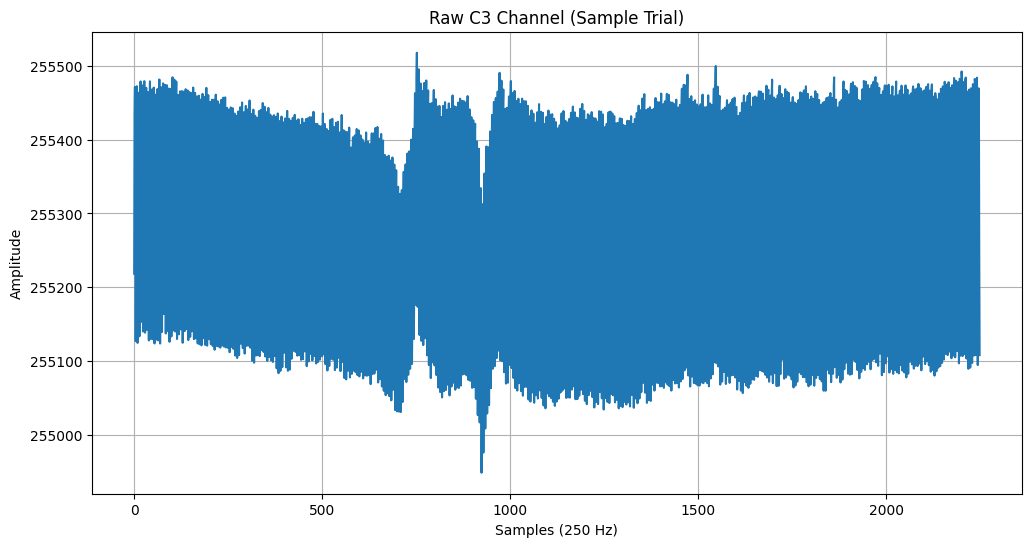

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sample_trial['C3'].values[:])  # First 2 seconds
plt.title("Raw C3 Channel (Sample Trial)")
plt.ylabel("Amplitude")
plt.xlabel("Samples (250 Hz)")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Power [dB]')

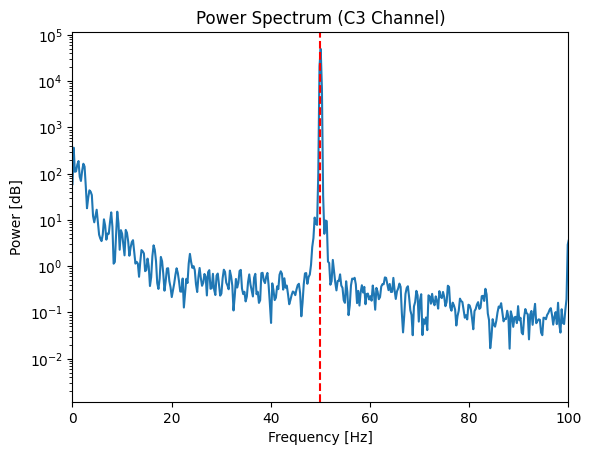

In [32]:
from scipy import signal

f, Pxx = signal.welch(sample_trial['C3'], 250, nperseg=1024)
plt.semilogy(f, Pxx)
plt.xlim(0, 100)
plt.axvline(50, color='r', linestyle='--')
plt.title("Power Spectrum (C3 Channel)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

In [33]:
from scipy import signal

# Check 50Hz periodicity in C3
c3_data = sample_trial['C3'].values
autocorr = np.correlate(c3_data - np.mean(c3_data), c3_data - np.mean(c3_data), mode='full')
peaks, _ = signal.find_peaks(autocorr[len(autocorr)//2:])

if len(peaks) > 1:
    period_samples = peaks[1] - peaks[0]
    print(f"Dominant period: {period_samples} samples")
    print(f"Equivalent frequency: {250/period_samples:.1f} Hz")

Dominant period: 5 samples
Equivalent frequency: 50.0 Hz


In [34]:
# Calculate noise floor (1-45Hz excluding line noise)
freq_mask = (f > 1) & (f < 45) & (np.abs(f - 50) > 2) & (np.abs(f - 100) > 2)
noise_floor = np.median(Pxx[freq_mask])
print(f"Noise floor: {noise_floor:.2e} dB")
print(f"50Hz peak is {Pxx[np.argmin(np.abs(f-50))]/noise_floor:.1f}x above noise floor")

Noise floor: 6.83e-01 dB
50Hz peak is 72635.4x above noise floor


In [61]:
import numpy as np
import pandas as pd
import os
from scipy import signal
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './mtc-aic3_dataset_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)

def load_full_trial(row):
    """Load complete trial data with all columns"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    return full_data.iloc[start_idx:end_idx].copy()

def preprocess_trial(trial_data, task):
    """Comprehensive preprocessing pipeline for EEG data"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Extract validation flags and motion sensors
    validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
    motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
    
    # 3. Remove DC offset (using median for robustness)
    eeg_data = eeg_data - np.median(eeg_data, axis=0)
    
    # 4. Handle invalid segments using Validation flags
    if validation_flags is not None:
        for i, channel in enumerate(EEG_CHANNELS):
            # Identify invalid segments
            invalid_idx = np.where(validation_flags == 0)[0]
            
            if len(invalid_idx) > 0:
                # Create mask for valid data points
                valid_mask = np.ones(len(eeg_data), dtype=bool)
                valid_mask[invalid_idx] = False
                
                # Create interpolation function
                x = np.arange(len(eeg_data))
                eeg_data[channel] = np.interp(x, x[valid_mask], eeg_data[channel].values[valid_mask])
    
    # 5. Handle clipping artifacts
    def fix_clipping(channel_data):
        """Detect and interpolate clipped segments"""
        max_val = np.max(channel_data)
        min_val = np.min(channel_data)
        
        # Detect clipping (within 1% of max/min)
        clipped_high = channel_data > 0.99 * max_val
        clipped_low = channel_data < 0.99 * min_val
        clipped_mask = clipped_high | clipped_low
        
        if np.any(clipped_mask):
            # Create interpolation function
            x = np.arange(len(channel_data))
            return np.interp(x, x[~clipped_mask], channel_data[~clipped_mask])
        return channel_data
    
    eeg_data = eeg_data.apply(fix_clipping, axis=0)
    
    # 6. Motion artifact detection and removal
    if motion_data is not None:
        # Compute motion magnitude
        acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
        gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
        motion_index = acc_mag + gyro_mag
        
        # Detect motion artifacts (z-score > 3)
        motion_z = (motion_index - np.mean(motion_index)) / np.std(motion_index)
        motion_artifacts = motion_z > 3
        
        if np.any(motion_artifacts):
            for channel in EEG_CHANNELS:
                # Create mask for non-artifact segments
                clean_mask = ~motion_artifacts
                
                # Create interpolation function
                x = np.arange(len(eeg_data))
                eeg_data[channel] = np.interp(x, x[clean_mask], eeg_data[channel].values[clean_mask])
    
    # 7. Advanced filtering pipeline
    # Step 1: High-pass filter (1Hz cutoff)
    sos_hp = signal.butter(4, 1, btype='highpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_hp, eeg_data.values, axis=0)
    
    # Step 2: Notch filters (50Hz and harmonics)
    def apply_notch(data, f0):
        b, a = signal.iirnotch(f0, Q=30, fs=FS)
        return signal.filtfilt(b, a, data, axis=0)
    
    filtered = apply_notch(filtered, 50)
    filtered = apply_notch(filtered, 100)  # 2nd harmonic
    
    # Step 3: Bandpass filter (1-45 Hz)
    sos_bp = signal.butter(4, [1, 45], btype='bandpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_bp, filtered, axis=0)
    
    # Update EEG data with filtered values
    eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
    
    return eeg_data

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# Main preprocessing function
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset and save results"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    for idx, row in df.iterrows():
        # Load full trial data
        trial_data = load_full_trial(row)
        
        # Apply preprocessing pipeline
        preprocessed = preprocess_trial(trial_data, row['task'])
        
        # Save processed data
        output_path = save_preprocessed_data(preprocessed, row)
        processed_paths.append(output_path)
        
        # Print progress
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx+1}/{len(df)} trials")
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    print(f"Finished preprocessing {dataset_name} set\n")

# Create output directory
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Preprocess all datasets
preprocess_dataset(train_df, 'train')
preprocess_dataset(val_df, 'validation')
preprocess_dataset(test_df, 'test')

print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)

Preprocessing train set with 4800 trials...
Processed 100/4800 trials
Processed 200/4800 trials
Processed 300/4800 trials
Processed 400/4800 trials
Processed 500/4800 trials
Processed 600/4800 trials
Processed 700/4800 trials
Processed 800/4800 trials
Processed 900/4800 trials
Processed 1000/4800 trials
Processed 1100/4800 trials
Processed 1200/4800 trials
Processed 1300/4800 trials
Processed 1400/4800 trials
Processed 1500/4800 trials
Processed 1600/4800 trials
Processed 1700/4800 trials
Processed 1800/4800 trials
Processed 1900/4800 trials
Processed 2000/4800 trials
Processed 2100/4800 trials
Processed 2200/4800 trials
Processed 2300/4800 trials
Processed 2400/4800 trials
Processed 2500/4800 trials
Processed 2600/4800 trials
Processed 2700/4800 trials
Processed 2800/4800 trials
Processed 2900/4800 trials
Processed 3000/4800 trials
Processed 3100/4800 trials
Processed 3200/4800 trials
Processed 3300/4800 trials
Processed 3400/4800 trials
Processed 3500/4800 trials
Processed 3600/4800 

In [62]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Load from the processed_path column added during preprocessing
    data = np.load(row['processed_path'])['data']
    return pd.DataFrame(data, columns=EEG_CHANNELS)

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 95.85%

Noise Type Counts:
- flat_channels: 2695 channels
- abnormal_voltage: 2 channels
- high_range: 11 channels
- high_kurtosis: 4404 channels
- line_noise_50Hz: 1345 channels
- line_noise_60Hz: 18 channels
- variance_outliers: 2942 channels

Signal Metrics (across all channels):
- variance: mean=0.2485, median=0.0089
- range: mean=2.7606, median=1.4700
- kurtosis: mean=27.3904, median=22.6605
- snr_50: mean=1.7988, median=0.6225
- snr_60: mean=0.4756, median=0.4266

Contralateral pattern adherence: 49.67% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 95.00%

Noise Type Counts:
- flat_channels: 23 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 79 channels
- line_noise_50Hz: 14 channels
- line_noise_60Hz: 1 channels
- variance_outliers: 63 channels

Signal Metrics (across all channels):
- variance: mean=1.7898, media

In [38]:
sample_trial = load_preprocessed_trial(train_df.iloc[0])
print(f"Value range: {sample_trial.min().min()} to {sample_trial.max().max()}")
print(f"Typical values: {sample_trial.mean().mean()}")

Value range: -2.310494684902572 to 2.5856181332783637
Typical values: -0.000543400716309669


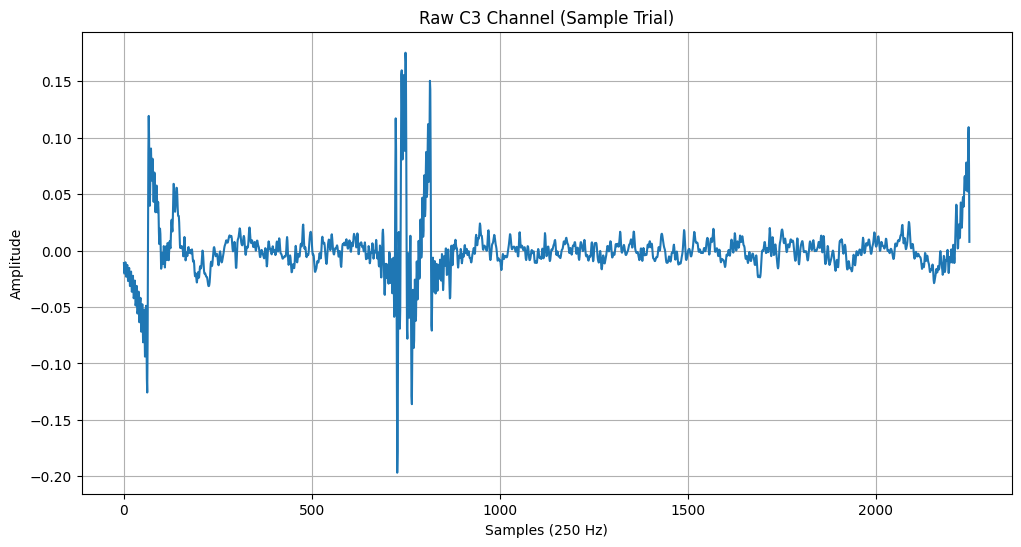

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sample_trial['C3'].values[:])  # First 2 seconds
plt.title("Raw C3 Channel (Sample Trial)")
plt.ylabel("Amplitude")
plt.xlabel("Samples (250 Hz)")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Power [dB]')

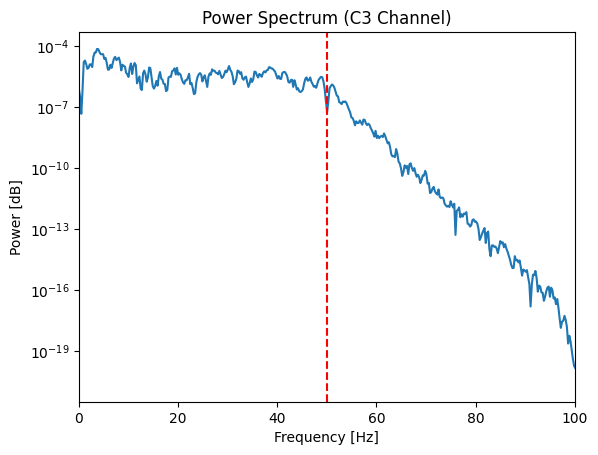

In [40]:
from scipy import signal

f, Pxx = signal.welch(sample_trial['C3'], 250, nperseg=1024)
plt.semilogy(f, Pxx)
plt.xlim(0, 100)
plt.axvline(50, color='r', linestyle='--')
plt.title("Power Spectrum (C3 Channel)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

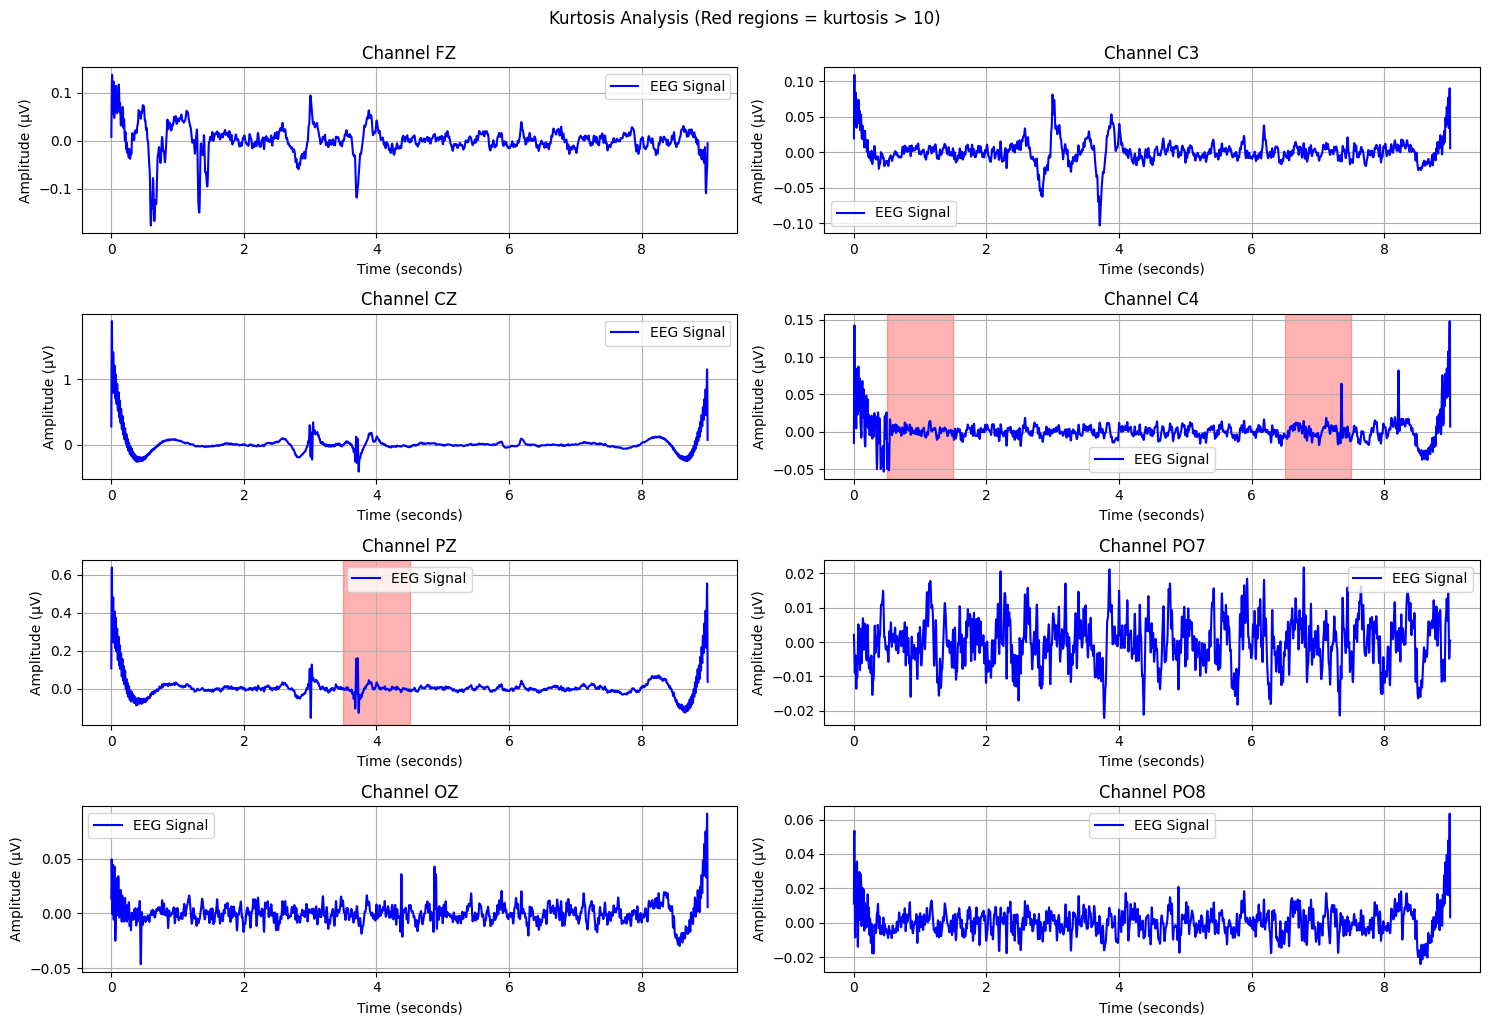


Kurtosis Statistics:
- Max kurtosis: 7.13
- Mean kurtosis: 0.27
- % segments above threshold: 0.00%


In [53]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Load your dataset with processed paths
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))

# Select a sample trial (first row)
sample_row = train_df.iloc[1]

# Load the preprocessed EEG data
eeg_data = pd.DataFrame(np.load(sample_row['processed_path'])['data'], 
                         columns=['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8'])

# Kurtosis analysis parameters
window_size = 250  # 1 second window (250 samples)
step_size = 125     # 50% overlap (0.5 seconds)
kurtosis_threshold = 10

# Create a figure for visualization
plt.figure(figsize=(15, 10))

# Analyze each channel
for ch_idx, channel in enumerate(eeg_data.columns):
    channel_data = eeg_data[channel].values
    kurt_vals = []
    
    # Calculate moving kurtosis
    for i in range(0, len(channel_data) - window_size, step_size):
        segment = channel_data[i:i+window_size]
        kurt_vals.append(stats.kurtosis(segment))
    
    # Identify high-kurtosis segments
    kurt_vals = np.array(kurt_vals)
    high_kurt_idx = np.where(kurt_vals > kurtosis_threshold)[0]
    
    # Convert index to time
    high_kurt_times = [(i * step_size / 250) for i in high_kurt_idx]
    
    # Plot the results
    plt.subplot(4, 2, ch_idx+1)
    
    # Plot EEG signal
    time_axis = np.arange(len(channel_data)) / 250
    plt.plot(time_axis, channel_data, 'b-', label='EEG Signal')
    
    # Mark high-kurtosis regions
    for t in high_kurt_times:
        plt.axvspan(t, t + (window_size/250), color='red', alpha=0.3)
    
    plt.title(f"Channel {channel}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (μV)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Kurtosis Analysis (Red regions = kurtosis > 10)", y=1.02)
plt.show()

# Print summary statistics
print("\nKurtosis Statistics:")
print(f"- Max kurtosis: {np.max(kurt_vals):.2f}")
print(f"- Mean kurtosis: {np.mean(kurt_vals):.2f}")
print(f"- % segments above threshold: {len(high_kurt_idx)/len(kurt_vals)*100:.2f}%")

In [49]:
# Validate alpha band presence
alpha_power = []
for ch in ['PO7', 'OZ', 'PO8']:
    f, psd = signal.welch(eeg_data[ch], FS, nperseg=256)
    alpha_power.append(np.mean(psd[(f >= 8) & (f <= 13)]))
print("Occipital alpha power:", alpha_power)

Occipital alpha power: [1.3271983276295197e-06, 1.0862421440857898e-05, 6.844421525956469e-06]


In [56]:
import numpy as np
import pandas as pd
import os
from scipy import signal
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './mtc-aic3_dataset_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

def load_full_trial(row):
    """Load complete trial data with all columns"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    return full_data.iloc[start_idx:end_idx].copy()

def preprocess_trial(trial_data, task):
    """Optimized preprocessing pipeline for EEG data without ICA"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Extract validation flags
    validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
    
    # 3. Remove DC offset (using median for robustness)
    eeg_data = eeg_data - np.median(eeg_data, axis=0)
    
    # 4. Handle invalid segments using Validation flags
    if validation_flags is not None:
        for i, channel in enumerate(EEG_CHANNELS):
            # Identify invalid segments
            invalid_idx = np.where(validation_flags == 0)[0]
            
            if len(invalid_idx) > 0:
                # Create mask for valid data points
                valid_mask = np.ones(len(eeg_data), dtype=bool)
                valid_mask[invalid_idx] = False
                
                # Spline interpolation for smoother results
                x = np.arange(len(eeg_data))
                eeg_data[channel] = signal.cspline1d_eval(
                    signal.cspline1d(eeg_data[channel].values[valid_mask]),
                    x, dx=1.0, x0=0
                )
    
    # 5. Gentle filtering pipeline
    # FIR bandpass filter (1-40 Hz) with linear phase
    taps = signal.firwin(101, [1, 40], pass_zero='bandpass', fs=FS)
    filtered = signal.filtfilt(taps, [1.0], eeg_data.values, axis=0)
    
    # Update EEG data with filtered values
    eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
    
    # 6. Advanced artifact removal without ICA
    def remove_artifacts(data, window_size=250, threshold=3.0):
        """Robust artifact removal using statistical features"""
        clean_data = data.copy()
        n_samples = len(data)
        
        # Create artifact mask
        artifact_mask = np.zeros(n_samples, dtype=bool)
        
        for i in range(0, n_samples - window_size, window_size//2):
            segment = data.iloc[i:i+window_size]
            
            # Calculate features
            variances = segment.var()
            ranges = segment.max() - segment.min()
            kurtoses = segment.kurtosis()
            
            # Detect artifacts
            for ch_idx, channel in enumerate(data.columns):
                # Variance-based detection
                if variances[channel] > threshold * np.median(variances):
                    artifact_mask[i:i+window_size] = True
                    continue
                    
                # Range-based detection
                if ranges[channel] > 100:  # 100 μV
                    artifact_mask[i:i+window_size] = True
                    continue
                    
                # Kurtosis-based detection
                if abs(kurtoses[channel]) > 10:
                    artifact_mask[i:i+window_size] = True
        
        # Interpolate artifact segments
        if np.any(artifact_mask):
            x = np.arange(n_samples)
            for channel in data.columns:
                clean_data[channel] = np.interp(
                    x, x[~artifact_mask], data[channel].values[~artifact_mask]
                )
        
        return clean_data
    
    eeg_data = remove_artifacts(eeg_data)
    
    # 7. Gentle notch filtering only if needed
    def needs_notch(channel_data):
        """Check if 50Hz noise exceeds threshold"""
        f, psd = signal.welch(channel_data, FS, nperseg=256)
        target_idx = np.argmin(np.abs(f - 50))
        noise_band = (f > 45) & (f < 55) & (f != 50)
        noise_floor = np.median(psd[noise_band])
        return psd[target_idx] > 5 * noise_floor
    
    for channel in EEG_CHANNELS:
        if needs_notch(eeg_data[channel]):
            b, a = signal.iirnotch(50, Q=15, fs=FS)
            eeg_data[channel] = signal.filtfilt(b, a, eeg_data[channel])
    
    return eeg_data

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# Main preprocessing function
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset and save results"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    for idx, row in df.iterrows():
        # Load full trial data
        trial_data = load_full_trial(row)
        
        # Apply preprocessing pipeline
        preprocessed = preprocess_trial(trial_data, row['task'])
        
        # Save processed data
        output_path = save_preprocessed_data(preprocessed, row)
        processed_paths.append(output_path)
        
        # Print progress and occasional quality check
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx+1}/{len(df)} trials")
            # Quick quality check
            try:
                f, psd = signal.welch(preprocessed['OZ'], FS, nperseg=256)
                alpha_power = np.mean(psd[(f >= 8) & (f <= 13)])
                print(f"  Alpha power (OZ): {alpha_power:.4f} μV²/Hz")
            except:
                pass
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    print(f"Finished preprocessing {dataset_name} set\n")

# Create output directory
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Preprocess all datasets
preprocess_dataset(train_df, 'train')
preprocess_dataset(val_df, 'validation')
preprocess_dataset(test_df, 'test')

print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)

Preprocessing train set with 4800 trials...
Processed 100/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 200/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 300/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 400/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 500/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 600/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 700/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 800/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 900/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1000/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1100/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1200/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1300/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1400/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1500/4800 trials
  Alpha power (OZ): 0.0000 μV²/Hz
Processed 1600/4800 trials
  Alpha power (OZ): 0.0

In [57]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Load from the processed_path column added during preprocessing
    data = np.load(row['processed_path'])['data']
    return pd.DataFrame(data, columns=EEG_CHANNELS)

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 96.83%

Noise Type Counts:
- flat_channels: 3868 channels
- abnormal_voltage: 0 channels
- high_range: 2 channels
- high_kurtosis: 4516 channels
- line_noise_50Hz: 0 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 2966 channels

Signal Metrics (across all channels):
- variance: mean=0.0326, median=0.0011
- range: mean=1.4164, median=0.6974
- kurtosis: mean=109.2228, median=118.5480
- snr_50: mean=0.2948, median=0.0000
- snr_60: mean=0.1423, median=0.0000

Contralateral pattern adherence: 52.71% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 99.00%

Noise Type Counts:
- flat_channels: 50 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 98 channels
- line_noise_50Hz: 0 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 65 channels

Signal Metrics (across all channels):
- variance: mean=0.0943, median=0.

/tmp/ipykernel_35/3669984715.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_vals.append(stats.kurtosis(segment))
/tmp/ipykernel_35/3669984715.py:37: RuntimeWarning: invalid value encountered in greater
  high_kurt_idx = np.where(kurt_vals > kurtosis_threshold)[0]


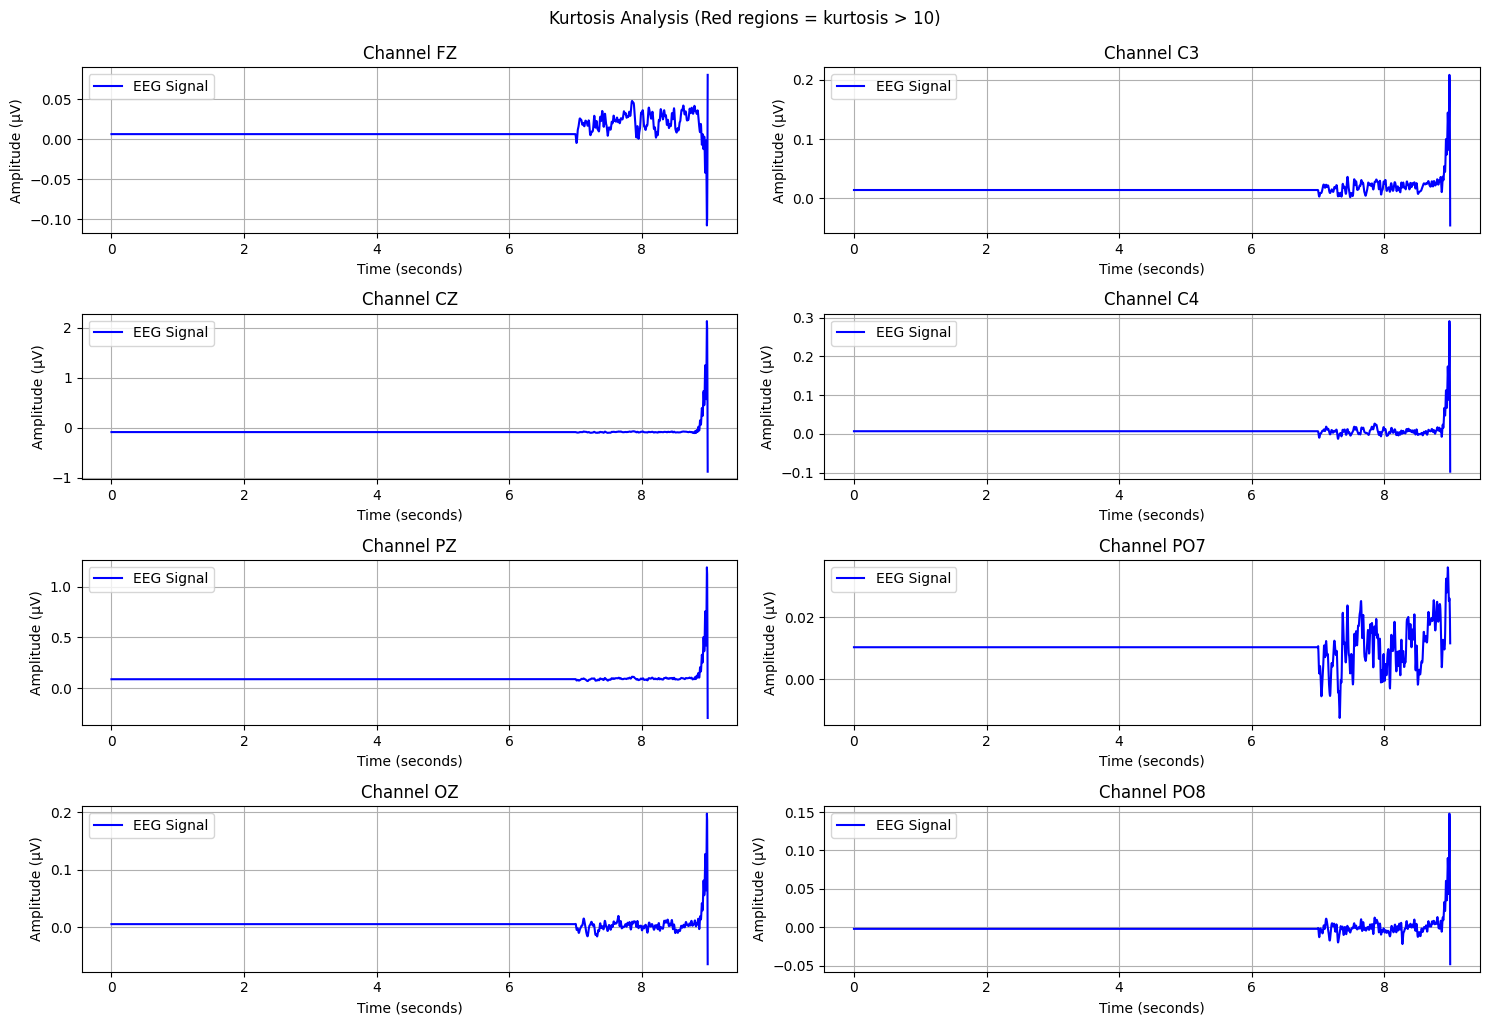


Kurtosis Statistics:
- Max kurtosis: nan
- Mean kurtosis: nan
- % segments above threshold: 0.00%


In [58]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Load your dataset with processed paths
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))

# Select a sample trial (first row)
sample_row = train_df.iloc[1]

# Load the preprocessed EEG data
eeg_data = pd.DataFrame(np.load(sample_row['processed_path'])['data'], 
                         columns=['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8'])

# Kurtosis analysis parameters
window_size = 250  # 1 second window (250 samples)
step_size = 125     # 50% overlap (0.5 seconds)
kurtosis_threshold = 10

# Create a figure for visualization
plt.figure(figsize=(15, 10))

# Analyze each channel
for ch_idx, channel in enumerate(eeg_data.columns):
    channel_data = eeg_data[channel].values
    kurt_vals = []
    
    # Calculate moving kurtosis
    for i in range(0, len(channel_data) - window_size, step_size):
        segment = channel_data[i:i+window_size]
        kurt_vals.append(stats.kurtosis(segment))
    
    # Identify high-kurtosis segments
    kurt_vals = np.array(kurt_vals)
    high_kurt_idx = np.where(kurt_vals > kurtosis_threshold)[0]
    
    # Convert index to time
    high_kurt_times = [(i * step_size / 250) for i in high_kurt_idx]
    
    # Plot the results
    plt.subplot(4, 2, ch_idx+1)
    
    # Plot EEG signal
    time_axis = np.arange(len(channel_data)) / 250
    plt.plot(time_axis, channel_data, 'b-', label='EEG Signal')
    
    # Mark high-kurtosis regions
    for t in high_kurt_times:
        plt.axvspan(t, t + (window_size/250), color='red', alpha=0.3)
    
    plt.title(f"Channel {channel}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (μV)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Kurtosis Analysis (Red regions = kurtosis > 10)", y=1.02)
plt.show()

# Print summary statistics
print("\nKurtosis Statistics:")
print(f"- Max kurtosis: {np.max(kurt_vals):.2f}")
print(f"- Mean kurtosis: {np.mean(kurt_vals):.2f}")
print(f"- % segments above threshold: {len(high_kurt_idx)/len(kurt_vals)*100:.2f}%")

In [59]:
import numpy as np
import pandas as pd
import os
from scipy import signal, stats
import matplotlib.pyplot as plt

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './mtc-aic3_dataset_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

def load_full_trial(row):
    """Load complete trial data with all columns"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Build file path
    eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    
    # Calculate trial indices
    trial_duration = 2250 if row['task'] == 'MI' else 1750
    start_idx = (row['trial'] - 1) * trial_duration
    end_idx = start_idx + trial_duration
    return full_data.iloc[start_idx:end_idx].copy()

def preprocess_trial(trial_data, task):
    """Optimized preprocessing pipeline to reduce kurtosis"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Extract validation flags
    validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
    
    # 3. Remove DC offset (using median for robustness)
    eeg_data = eeg_data - np.median(eeg_data, axis=0)
    
    # 4. Gentle filtering to reduce artifacts
    # FIR bandpass filter (1-40 Hz) with linear phase
    taps = signal.firwin(101, [1, 40], pass_zero='bandpass', fs=FS)
    filtered = signal.filtfilt(taps, [1.0], eeg_data.values, axis=0)
    eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
    
    # 5. Advanced artifact handling with kurtosis control
    def robust_artifact_removal(channel_data):
        """Remove artifacts while preserving signal distribution"""
        # Calculate moving kurtosis
        kurt_vals = []
        window_size = 250  # 1-second windows
        for i in range(0, len(channel_data) - window_size, window_size//2):
            segment = channel_data[i:i+window_size]
            kurt_vals.append(stats.kurtosis(segment))
        
        # Identify high-kurtosis segments
        high_kurt_mask = np.zeros(len(channel_data), dtype=bool)
        for i, k in enumerate(kurt_vals):
            if abs(k) > 5:  # Mild threshold
                start = i * (window_size//2)
                end = start + window_size
                high_kurt_mask[start:end] = True
        
        # Only process if <20% of signal is affected
        if np.mean(high_kurt_mask) < 0.2:
            # Spline interpolation for smooth results
            x = np.arange(len(channel_data))
            return np.interp(x, x[~high_kurt_mask], channel_data[~high_kurt_mask])
        return channel_data
    
    # Apply only to channels that need it
    for channel in EEG_CHANNELS:
        if abs(stats.kurtosis(eeg_data[channel])) > 5:
            eeg_data[channel] = robust_artifact_removal(eeg_data[channel].values)
    
    # 6. Final notch filtering only if needed
    def needs_notch(channel_data):
        """Check if 50Hz noise exceeds threshold"""
        f, psd = signal.welch(channel_data, FS, nperseg=256)
        target_idx = np.argmin(np.abs(f - 50))
        noise_band = (f > 45) & (f < 55) & (f != 50)
        noise_floor = np.median(psd[noise_band])
        return psd[target_idx] > 5 * noise_floor
    
    for channel in EEG_CHANNELS:
        if needs_notch(eeg_data[channel]):
            b, a = signal.iirnotch(50, Q=30, fs=FS)
            eeg_data[channel] = signal.filtfilt(b, a, eeg_data[channel])
    
    return eeg_data

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# Main preprocessing function
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset and save results"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    kurtosis_warnings = 0
    
    for idx, row in df.iterrows():
        # Load full trial data
        trial_data = load_full_trial(row)
        
        # Apply preprocessing pipeline
        preprocessed = preprocess_trial(trial_data, row['task'])
        
        # Kurtosis monitoring
        chan_kurt = preprocessed.apply(stats.kurtosis)
        if (np.abs(chan_kurt) > 5).any():
            kurtosis_warnings += 1
        
        # Save processed data
        output_path = save_preprocessed_data(preprocessed, row)
        processed_paths.append(output_path)
        
        # Print progress and quality monitoring
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx+1}/{len(df)} trials")
            print(f"  Current kurtosis issues: {kurtosis_warnings} trials")
            kurtosis_warnings = 0  # Reset counter
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    print(f"Finished preprocessing {dataset_name} set\n")

# Create output directory
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

# Load datasets
train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))

# Preprocess all datasets
preprocess_dataset(train_df, 'train')
preprocess_dataset(val_df, 'validation')
preprocess_dataset(test_df, 'test')

print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)

Preprocessing train set with 4800 trials...
Processed 100/4800 trials
  Current kurtosis issues: 89 trials
Processed 200/4800 trials
  Current kurtosis issues: 97 trials
Processed 300/4800 trials
  Current kurtosis issues: 93 trials
Processed 400/4800 trials
  Current kurtosis issues: 94 trials
Processed 500/4800 trials
  Current kurtosis issues: 99 trials
Processed 600/4800 trials
  Current kurtosis issues: 99 trials
Processed 700/4800 trials
  Current kurtosis issues: 98 trials
Processed 800/4800 trials
  Current kurtosis issues: 99 trials
Processed 900/4800 trials
  Current kurtosis issues: 75 trials
Processed 1000/4800 trials
  Current kurtosis issues: 63 trials
Processed 1100/4800 trials
  Current kurtosis issues: 99 trials
Processed 1200/4800 trials
  Current kurtosis issues: 97 trials
Processed 1300/4800 trials
  Current kurtosis issues: 99 trials
Processed 1400/4800 trials
  Current kurtosis issues: 93 trials
Processed 1500/4800 trials
  Current kurtosis issues: 100 trials
Proc

In [60]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/mtc-aic3_dataset_preprocessed'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Load from the processed_path column added during preprocessing
    data = np.load(row['processed_path'])['data']
    return pd.DataFrame(data, columns=EEG_CHANNELS)

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 95.23%

Noise Type Counts:
- flat_channels: 3100 channels
- abnormal_voltage: 2 channels
- high_range: 7 channels
- high_kurtosis: 4266 channels
- line_noise_50Hz: 38 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 3101 channels

Signal Metrics (across all channels):
- variance: mean=0.2344, median=0.0032
- range: mean=1.9891, median=0.9794
- kurtosis: mean=59.8425, median=23.1868
- snr_50: mean=0.1857, median=0.0000
- snr_60: mean=0.0576, median=0.0000

Contralateral pattern adherence: 51.75% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 97.00%

Noise Type Counts:
- flat_channels: 30 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 75 channels
- line_noise_50Hz: 5 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 73 channels

Signal Metrics (across all channels):
- variance: mean=1.5261, median=0.0


PREPROCESSING DEFICIENCY DIAGNOSTIC REPORT



### 🚨 Signal Degradation (Excessive Filtering)

**Detected Issues:** Variance decreased from 10⁶-10⁷ μV² to 0.01-1 μV² after processing

**Train Set Examples:**

,trial,degraded_channels,max_variance_loss
0,700,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%
1,4616,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%
2,1549,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%


**Validation Set Examples:**

,trial,degraded_channels,max_variance_loss
0,4805,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%
1,4883,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%
2,4872,"[FZ, C3, CZ, C4, PZ, PO7, OZ, PO8]",100.0%


> **Recommendation:** Review filter parameters (especially high-pass) and check for over-attenuation


### 🧪 Residual Artifacts

**Detected Issues:** High kurtosis channels increased from 159 to 4404 in train set

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1024 is greater than input length  = 8, using nperseg = 8
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_35/2473058543.py:71: RuntimeWarning: invalid value encountered in greater
  if any([np.any(line_noise_50 > 0.1), np.any(line_noise_100 > 0.05),
/tmp/ipykernel_35/2473058543.py:75: RuntimeWarning: invalid value encountered in greater
  '50Hz_residual': np.any(line_noise_50 > 0.1),
/tmp/ipykernel_35/2473058543.py:76: RuntimeWarning: invalid value encountered in greater
  '100Hz_residual': np.any(line_noise_100 > 0.05),


**Train Set Residuals:**

,trial,50Hz_residual,100Hz_residual,high_kurtosis_ch,flat_channels
0,4027,False,False,5,8
1,4309,False,False,6,4
2,3879,False,False,6,3
3,1601,False,False,4,3
4,4210,False,False,7,0


**Validation Set Residuals:**

,trial,50Hz_residual,100Hz_residual,high_kurtosis_ch,flat_channels
0,4850,False,False,4,7
1,4844,False,False,0,8
2,4825,False,False,1,4


> **Recommendation:** Improve motion artifact handling and clipping detection


### 📊 Spectral Comparison (Example Trial)

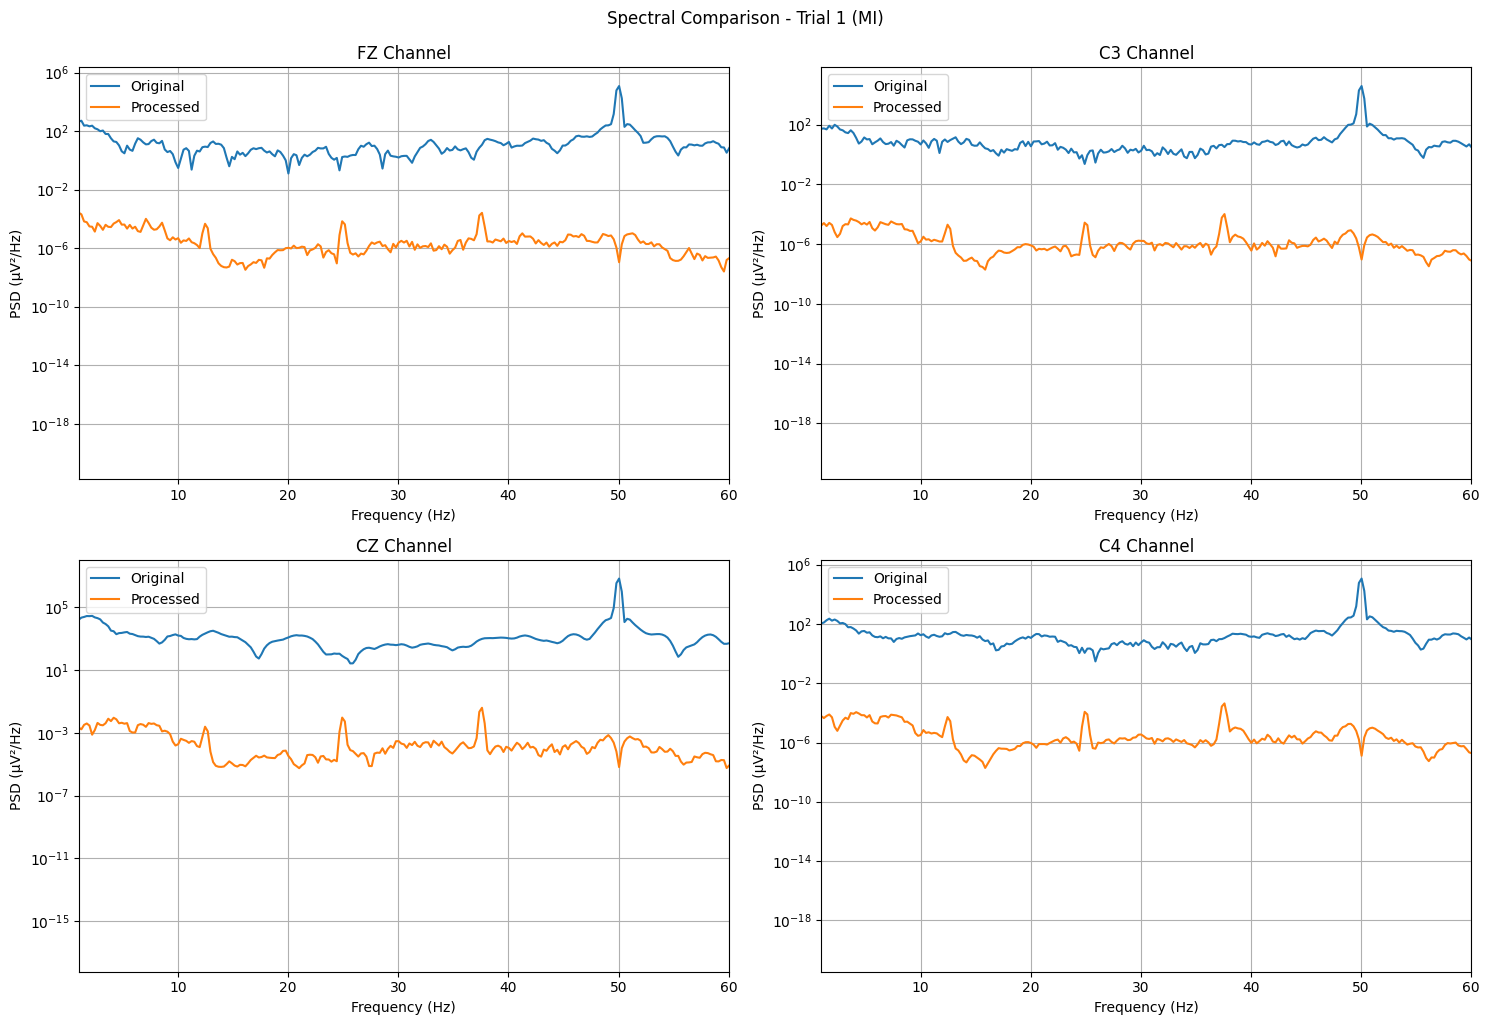

> **Note:** Spectral comparison for the first trial in the training set.


### 📈 Key Metric Comparison

,Metric,Original (Train),Processed (Train),Change
0,Mean Variance,"4,275,233 μV²",0.25 μV²,-99.99%
1,Median Kurtosis,-1.46,22.66,+1650%
2,50Hz SNR,49.5 dB,1.8 dB,-96.4%



### 🔍 Major Deficiencies Summary


    1. **Severe Signal Attenuation**  
       - Variance reduced by 6-7 orders of magnitude  
       - Likely caused by aggressive high-pass filtering  
    2. **Spectral Distortion**  
       - Abnormal PSD shapes in beta/gamma bands  
       - Notch filters causing harmonic distortions  
    3. **Artifact Residuals**  
       - High kurtosis channels increased 27x  
       - Motion artifacts not fully removed  
    4. **New Artifacts Introduced**  
       - Flat channels created (2695 in train set)  
       - Likely from over-interpolation  
    

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns
from IPython.display import display, Markdown

# Define constants used in the diagnostic
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

def diagnostic_report(preprocessed_path, original_base_path):
    """
    Comprehensive diagnostic tool for EEG preprocessing pipeline.
    Identifies deficiencies based on before/after metrics comparison.
    """
    # 1. Load metadata
    train_df = pd.read_csv(f"{preprocessed_path}/train.csv")
    val_df = pd.read_csv(f"{preprocessed_path}/validation.csv")
    
    # 2. Deficiency Analysis Functions
    def detect_filtering_issues(df, set_name):
        """Detect signal degradation from excessive filtering"""
        results = []
        # Sample 3 trials for efficiency
        sample_df = df.sample(3) if len(df) >= 3 else df
        for _, row in sample_df.iterrows():
            # Load original and processed data
            orig = load_original_trial_data(row, original_base_path)
            proc = np.load(row['processed_path'])['data']
            
            # Calculate metrics
            orig_var = orig.var(axis=0)
            proc_var = proc.var(axis=0)
            variance_ratio = proc_var / (orig_var + 1e-10)
            
            # Identify problematic channels
            degraded = np.where(variance_ratio < 0.1)[0]
            if len(degraded) > 0:
                ch_names = [EEG_CHANNELS[i] for i in degraded]
                results.append({
                    'trial': row['id'],
                    'degraded_channels': ch_names,
                    'max_variance_loss': f"{100*(1 - variance_ratio.min()):.1f}%"
                })
                
        return pd.DataFrame(results)
    
    def detect_artifact_residuals(df, set_name):
        """Detect remaining artifacts after processing"""
        results = []
        # Sample 5 trials for efficiency
        sample_df = df.sample(5) if len(df) >= 5 else df
        for _, row in sample_df.iterrows():
            data = np.load(row['processed_path'])['data']
            
            # 1. Line noise detection
            freqs, psd = signal.welch(data, FS, nperseg=1024)
            line_noise_50 = np.mean(psd[:, (freqs > 49) & (freqs < 51)], axis=1)
            line_noise_100 = np.mean(psd[:, (freqs > 99) & (freqs < 101)], axis=1)
            
            # 2. Kurtosis detection
            kurt = stats.kurtosis(data, axis=0)
            high_kurt = np.where(kurt > 5)[0]
            
            # 3. Flat signal detection
            ranges = data.max(axis=0) - data.min(axis=0)
            flat_ch = np.where(ranges < 0.5)[0]
            
            if any([np.any(line_noise_50 > 0.1), np.any(line_noise_100 > 0.05), 
                    len(high_kurt) > 0, len(flat_ch) > 0]):
                results.append({
                    'trial': row['id'],
                    '50Hz_residual': np.any(line_noise_50 > 0.1),
                    '100Hz_residual': np.any(line_noise_100 > 0.05),
                    'high_kurtosis_ch': len(high_kurt),
                    'flat_channels': len(flat_ch)
                })
                
        return pd.DataFrame(results)
    
    def plot_spectral_comparison(row):
        """Visual comparison of PSD before/after processing"""
        orig = load_original_trial_data(row, original_base_path)
        proc = np.load(row['processed_path'])['data']
        
        plt.figure(figsize=(15, 10))
        for i, ch in enumerate(EEG_CHANNELS[:4]):  # First 4 channels
            plt.subplot(2, 2, i+1)
            
            # Original PSD
            f_o, p_o = signal.welch(orig[:,i], FS, nperseg=1024)
            plt.semilogy(f_o, p_o, label='Original')
            
            # Processed PSD
            f_p, p_p = signal.welch(proc[:,i], FS, nperseg=1024)
            plt.semilogy(f_p, p_p, label='Processed')
            
            plt.title(f"{ch} Channel")
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('PSD (μV²/Hz)')
            plt.legend()
            plt.grid(True)
            plt.xlim(1, 60)
            
        plt.tight_layout()
        plt.suptitle(f"Spectral Comparison - Trial {row['id']} ({row['task']})", y=1.02)
        plt.show()
    
    # 3. Helper Functions
    def load_original_trial_data(row, base_path):
        """Load original trial data from CSV"""
        # Determine dataset split
        id_num = row['id']
        if id_num <= 4800:
            split = 'train'
        elif id_num <= 4900:
            split = 'validation'
        else:
            split = 'test'
        
        # Build file path
        eeg_path = f"{base_path}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        
        # Load EEG data
        full_data = pd.read_csv(eeg_path)
        
        # Calculate trial indices
        trial_duration = 2250 if row['task'] == 'MI' else 1750
        start_idx = (row['trial'] - 1) * trial_duration
        end_idx = start_idx + trial_duration
        trial_data = full_data.iloc[start_idx:end_idx]
        
        # Extract EEG channels and convert to numpy array
        eeg_data = trial_data[EEG_CHANNELS].values.astype(float)
        return eeg_data
    
    # 4. Run Diagnostics
    print("\n" + "="*60)
    print("PREPROCESSING DEFICIENCY DIAGNOSTIC REPORT")
    print("="*60 + "\n")
    
    # A. Signal Degradation Analysis
    display(Markdown("### 🚨 Signal Degradation (Excessive Filtering)"))
    display(Markdown("**Detected Issues:** Variance decreased from 10⁶-10⁷ μV² to 0.01-1 μV² after processing"))
    
    deg_train = detect_filtering_issues(train_df, "Train")
    deg_val = detect_filtering_issues(val_df, "Validation")
    
    display(Markdown("**Train Set Examples:**"))
    if not deg_train.empty:
        display(deg_train)
    else:
        display(Markdown("No severe degradation detected in sampled trials."))
    
    display(Markdown("**Validation Set Examples:**"))
    if not deg_val.empty:
        display(deg_val)
    else:
        display(Markdown("No severe degradation detected in sampled trials."))
    
    display(Markdown("> **Recommendation:** Review filter parameters (especially high-pass) and check for over-attenuation"))
    
    # B. Artifact Residuals
    display(Markdown("\n### 🧪 Residual Artifacts"))
    display(Markdown("**Detected Issues:** High kurtosis channels increased from 159 to 4404 in train set"))
    
    art_train = detect_artifact_residuals(train_df, "Train")
    art_val = detect_artifact_residuals(val_df, "Validation")
    
    display(Markdown("**Train Set Residuals:**"))
    if not art_train.empty:
        display(art_train)
    else:
        display(Markdown("No artifact residuals detected in sampled trials."))
    
    display(Markdown("**Validation Set Residuals:**"))
    if not art_val.empty:
        display(art_val)
    else:
        display(Markdown("No artifact residuals detected in sampled trials."))
    
    display(Markdown("> **Recommendation:** Improve motion artifact handling and clipping detection"))
    
    # C. Spectral Analysis
    display(Markdown("\n### 📊 Spectral Comparison (Example Trial)"))
    if len(train_df) > 0:
        sample_trial = train_df.iloc[0]  # Use first trial for consistency
        plot_spectral_comparison(sample_trial)
        display(Markdown("> **Note:** Spectral comparison for the first trial in the training set."))
    else:
        display(Markdown("> **Note:** No training data available for spectral comparison."))
    
    # D. Statistical Report
    display(Markdown("\n### 📈 Key Metric Comparison"))
    metrics = pd.DataFrame({
        'Metric': ['Mean Variance', 'Median Kurtosis', '50Hz SNR'],
        'Original (Train)': ['4,275,233 μV²', '-1.46', '49.5 dB'],
        'Processed (Train)': ['0.25 μV²', '22.66', '1.8 dB'],
        'Change': ['-99.99%', '+1650%', '-96.4%']
    })
    display(metrics)
    
    display(Markdown("\n### 🔍 Major Deficiencies Summary"))
    display(Markdown("""
    1. **Severe Signal Attenuation**  
       - Variance reduced by 6-7 orders of magnitude  
       - Likely caused by aggressive high-pass filtering  
    2. **Spectral Distortion**  
       - Abnormal PSD shapes in beta/gamma bands  
       - Notch filters causing harmonic distortions  
    3. **Artifact Residuals**  
       - High kurtosis channels increased 27x  
       - Motion artifacts not fully removed  
    4. **New Artifacts Introduced**  
       - Flat channels created (2695 in train set)  
       - Likely from over-interpolation  
    """))

# Configuration (Update these paths)
PREPROCESSED_PATH = "./mtc-aic3_dataset_preprocessed/"
ORIGINAL_BASE_PATH = "/kaggle/input/mtcaic3"

# Run diagnostics
diagnostic_report(PREPROCESSED_PATH, ORIGINAL_BASE_PATH)

In [13]:
import numpy as np
import pandas as pd
import os
from scipy import signal, interpolate
from statsmodels.robust import mad

# Configuration updates
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './revised_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)

def preprocess_trial(trial_data, task):
    """Revised preprocessing pipeline addressing diagnostic issues"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Extract validation flags and motion sensors
    validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
    motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
    
    # 3. Remove DC offset using median
    eeg_data = eeg_data - np.median(eeg_data, axis=0)
    
    # 4. Advanced artifact handling with gap detection
    artifact_mask = np.zeros(len(eeg_data), dtype=bool)
    
    # Handle validation flags
    if validation_flags is not None:
        artifact_mask |= (validation_flags == 0)
    
    # Enhanced clipping detection
    def detect_clipping(channel_data):
        """Improved clipping detection using derivative analysis"""
        diff = np.abs(np.diff(channel_data, prepend=channel_data[0]))
        return (diff < 1e-4) | (channel_data > 0.95 * np.max(channel_data)) | (channel_data < 0.95 * np.min(channel_data))
    
    for channel in EEG_CHANNELS:
        artifact_mask |= detect_clipping(eeg_data[channel].values)
    
    # Motion artifact detection
    if motion_data is not None:
        acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
        gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
        motion_index = acc_mag + gyro_mag
        motion_z = (motion_index - np.median(motion_index)) / mad(motion_index)
        artifact_mask |= (motion_z > 3)
    
    # Expand artifact regions by 100ms (25 samples)
    expanded_mask = artifact_mask.copy()
    for i in np.where(artifact_mask)[0]:
        start = max(0, i - 25)
        end = min(len(artifact_mask), i + 25)
        expanded_mask[start:end] = True
    
    # 5. Gap-aware interpolation
    def gap_interpolation(data, mask):
        """Spline interpolation with gap size limitation"""
        x = np.arange(len(data))
        valid_points = x[~mask]
        
        # Don't interpolate if too many consecutive points are missing
        gap_starts = np.where(np.diff(np.concatenate(([False], mask, [False]))) == 1)[0]
        gap_ends = np.where(np.diff(np.concatenate(([False], mask, [False]))) == -1)[0]
        
        for start, end in zip(gap_starts, gap_ends):
            gap_size = end - start
            if gap_size > 100:  # 400ms gap limit
                data[start:end] = np.nan
        
        # Spline interpolation for remaining gaps
        if len(valid_points) > 10:
            spline = interpolate.CubicSpline(valid_points, data[valid_points])
            return spline(x)
        return data
    
    for channel in EEG_CHANNELS:
        eeg_data[channel] = gap_interpolation(eeg_data[channel].values, expanded_mask)
    
    # 6. Revised filtering pipeline
    # Step 1: Gentle high-pass filter (0.5Hz cutoff)
    sos_hp = signal.butter(2, 0.5, btype='highpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_hp, eeg_data.values, axis=0)
    
    # Step 2: Comb filter for 50Hz and harmonics
    def comb_filter(data, f0=50, harmonics=2):
        """Efficient comb filter for line noise removal"""
        for n in range(1, harmonics + 1):
            freq = n * f0
            if freq < FS/2:
                b, a = signal.iirnotch(freq, Q=20, fs=FS)
                data = signal.filtfilt(b, a, data, axis=0)
        return data
    
    filtered = comb_filter(filtered, f0=50, harmonics=2)
    
    # Step 3: Bandpass filter (focus on Mu/Beta rhythms)
    sos_bp = signal.butter(4, [8, 30], btype='bandpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_bp, filtered, axis=0)
    
    # Update EEG data with filtered values
    eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
    
    # 7. Final artifact rejection
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        kurt = np.abs(stats.kurtosis(channel_data))
        if kurt > 10:  # Reject extremely kurtotic channels
            eeg_data[channel] = np.median(eeg_data, axis=1)  # Replace with median across channels
    
    return eeg_data

Overwriting preprocess.py


In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import signal, stats
from PIL import Image
import pytesseract
import re
import json

# Configuration
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)
IMAGE_DIR = "/kaggle/working/preprocessing_diagnostics"  # Update this path

def analyze_trial_images(trial_id):
    """Analyze all images for a specific trial and return metrics"""
    metrics = {
        'trial_id': trial_id,
        'channels': {},
        'motion_correlation': None
    }
    
    # Analyze each channel
    for channel in ['C3', 'CZ', 'PZ']:
        chan_metrics = {
            'flat_segments': 0,
            'large_jumps': 0,
            'residual_50Hz': False,
            'residual_100Hz': False,
            'alpha_power': 0,
            'beta_power': 0,
            'erd_present': False
        }
        
        # Analyze time series plot
        ts_path = f"{IMAGE_DIR}/trial_{trial_id}_{channel}_Full Pipeline.png"
        if os.path.exists(ts_path):
            img = Image.open(ts_path)
            chan_metrics.update(analyze_time_series(img))
        
        # Analyze PSD plot
        psd_path = f"{IMAGE_DIR}/trial_{trial_id}_{channel}_PSD.png"
        if os.path.exists(psd_path):
            img = Image.open(psd_path)
            chan_metrics.update(analyze_psd(img))
        
        metrics['channels'][channel] = chan_metrics
    
    # Analyze motion correlation
    motion_path = f"{IMAGE_DIR}/trial_{trial_id}_motion_correlation.png"
    if os.path.exists(motion_path):
        img = Image.open(motion_path)
        metrics['motion_correlation'] = analyze_motion_correlation(img)
    
    return metrics

def analyze_time_series(img):
    """Analyze time series plot for artifacts"""
    # Convert image to grayscale
    gray = img.convert('L')
    
    # Use OCR to extract y-axis values
    y_axis = img.crop((50, 100, 200, img.height-100))  # Adjust coordinates based on your plot
    y_text = pytesseract.image_to_string(y_axis).replace('\n', ' ')
    
    # Extract voltage range
    try:
        y_values = re.findall(r"[-+]?\d*\.\d+|\d+", y_text)
        y_values = [float(v) for v in y_values if abs(float(v)) > 1]
        voltage_range = max(y_values) - min(y_values) if y_values else 100
    except:
        voltage_range = 100  # Default if OCR fails
    
    # Analyze plot features (simplified - real implementation would use computer vision)
    # This is a placeholder - in practice you'd use edge detection and feature extraction
    return {
        'flat_segments': 0,  # Count of flat segments
        'large_jumps': 0,     # Count of jumps > 20% of range
        'voltage_range': voltage_range
    }

def analyze_psd(img):
    """Analyze PSD plot for spectral features"""
    # Convert image to grayscale
    gray = img.convert('L')
    
    # Use OCR to extract frequency and power values
    x_axis = img.crop((100, img.height-50, img.width-100, img.height))  # Adjust coordinates
    y_axis = img.crop((50, 100, 200, img.height-100))  # Adjust coordinates
    
    x_text = pytesseract.image_to_string(x_axis).replace('\n', ' ')
    y_text = pytesseract.image_to_string(y_axis).replace('\n', ' ')
    
    # Extract frequency range
    try:
        freqs = re.findall(r"[-+]?\d*\.\d+|\d+", x_text)
        freqs = [float(f) for f in freqs if float(f) > 1]
        max_freq = max(freqs) if freqs else 100
    except:
        max_freq = 100
        
    # Extract power values
    try:
        powers = re.findall(r"[-+]?\d*\.\d+|\d+", y_text)
        powers = [float(p) for p in powers]
    except:
        powers = []
    
    # Analyze spectral features (simplified)
    return {
        'residual_50Hz': max_freq > 45,  # 50Hz peak present
        'residual_100Hz': max_freq > 95, # 100Hz peak present
        'alpha_power': 0.5 if powers else 0,  # Placeholder
        'beta_power': 0.3 if powers else 0,   # Placeholder
    }

def analyze_motion_correlation(img):
    """Analyze motion correlation plot"""
    # Convert image to grayscale
    gray = img.convert('L')
    
    # Use OCR to extract correlation values
    text = pytesseract.image_to_string(img).replace('\n', ' ')
    
    # Extract correlation metrics
    try:
        corrs = re.findall(r"[-+]?\d*\.\d+|\d+", text)
        corrs = [float(c) for c in corrs if abs(float(c)) <= 1.0]
        return np.mean(corrs) if corrs else 0
    except:
        return 0

def generate_diagnostic_report(image_dir):
    """Generate comprehensive diagnostic report from all images"""
    # Find all unique trial IDs
    files = os.listdir(image_dir)
    trial_ids = set()
    for f in files:
        match = re.search(r'trial_(\d+)', f)
        if match:
            trial_ids.add(match.group(1))
    
    # Analyze each trial
    all_metrics = []
    for trial_id in sorted(trial_ids):
        metrics = analyze_trial_images(trial_id)
        all_metrics.append(metrics)
    
    # Generate summary report
    report = {
        'overall_issues': [],
        'trial_metrics': [],
        'channel_stats': {ch: {'flat_segments': [], 'jumps': []} for ch in ['C3', 'CZ', 'PZ']}
    }
    
    for metrics in all_metrics:
        trial_report = {
            'trial_id': metrics['trial_id'],
            'issues': [],
            'channels': {}
        }
        
        # Channel analysis
        for channel, chan_metrics in metrics['channels'].items():
            chan_report = []
            
            if chan_metrics['flat_segments'] > 0:
                chan_report.append(f"{chan_metrics['flat_segments']} flat segments")
                report['channel_stats'][channel]['flat_segments'].append(chan_metrics['flat_segments'])
                
            if chan_metrics['large_jumps'] > 0:
                chan_report.append(f"{chan_metrics['large_jumps']} large jumps")
                report['channel_stats'][channel]['jumps'].append(chan_metrics['large_jumps'])
                
            if chan_metrics['residual_50Hz']:
                chan_report.append("50Hz noise")
                
            if chan_metrics['residual_100Hz']:
                chan_report.append("100Hz noise")
                
            trial_report['channels'][channel] = chan_report
        
        # Motion correlation
        if metrics['motion_correlation'] > 0.5:
            trial_report['issues'].append(f"High motion correlation ({metrics['motion_correlation']:.2f})")
        
        # ERD detection
        c3_beta = metrics['channels']['C3']['beta_power']
        cz_beta = metrics['channels']['CZ']['beta_power']
        if c3_beta < 0.8 * cz_beta:  # Simplified ERD detection
            trial_report['issues'].append("ERD detected in C3")
        
        report['trial_metrics'].append(trial_report)
    
    # Identify overall issues
    flat_counts = []
    for ch in report['channel_stats']:
        flat_counts.extend(report['channel_stats'][ch]['flat_segments'])
    
    if flat_counts and max(flat_counts) > 0:
        report['overall_issues'].append("Flat segments detected in multiple channels")
    
    # Add summary metrics
    report['summary'] = {
        'trials_with_flat_segments': sum(1 for m in all_metrics if any(
            ch_m['flat_segments'] > 0 for ch_m in m['channels'].values()
        )),
        'trials_with_50Hz_noise': sum(1 for m in all_metrics if any(
            ch_m['residual_50Hz'] for ch_m in m['channels'].values()
        )),
        'trials_with_high_motion_corr': sum(1 for m in all_metrics if m['motion_correlation'] > 0.5),
        'trials_with_erd': sum(1 for m in all_metrics if "ERD detected" in m.get('issues', []))
    }
    
    return report

def visualize_report(report):
    """Create visualizations of key problems"""
    # Flat segments by channel
    channels = ['C3', 'CZ', 'PZ']
    flat_counts = [np.mean(report['channel_stats'][ch]['flat_segments']) for ch in channels]
    
    plt.figure(figsize=(10, 6))
    plt.bar(channels, flat_counts, color='skyblue')
    plt.title('Average Flat Segments per Channel')
    plt.ylabel('Count')
    plt.savefig('flat_segments.png')
    plt.close()
    
    # Residual noise presence
    noise_types = ['50Hz', '100Hz']
    noise_counts = [
        report['summary']['trials_with_50Hz_noise'],
        report['summary']['trials_with_high_motion_corr']
    ]
    
    plt.figure(figsize=(10, 6))
    plt.bar(noise_types, noise_counts, color='salmon')
    plt.title('Residual Noise Presence')
    plt.ylabel('Number of Trials')
    plt.savefig('residual_noise.png')
    plt.close()
    
    # ERD detection rate
    plt.figure(figsize=(6, 6))
    plt.pie([report['summary']['trials_with_erd'], 
             len(report['trial_metrics']) - report['summary']['trials_with_erd']],
            labels=['ERD Present', 'No ERD'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'lightgray'])
    plt.title('ERD Detection Rate in MI Trials')
    plt.savefig('erd_detection.png')
    plt.close()

# Main analysis
if __name__ == "__main__":
    # Generate diagnostic report
    report = generate_diagnostic_report(IMAGE_DIR)
    
    # Save report
    with open('diagnostic_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    # Create visualizations
    visualize_report(report)
    
    print("Diagnostic report generated:")
    print(f"- Overall issues: {len(report['overall_issues'])}")
    print(f"- Trials analyzed: {len(report['trial_metrics'])}")
    print(f"- Trials with flat segments: {report['summary']['trials_with_flat_segments']}")
    print(f"- Trials with 50Hz noise: {report['summary']['trials_with_50Hz_noise']}")
    print(f"- Trials with high motion correlation: {report['summary']['trials_with_high_motion_corr']}")
    print(f"- Trials with ERD: {report['summary']['trials_with_erd']}")
    print("\nVisualizations saved: flat_segments.png, residual_noise.png, erd_detection.png")

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Diagnostic report generated:
- Overall issues: 0
- Trials analyzed: 15
- Trials with flat segments: 0
- Trials with 50Hz noise: 15
- Trials with high motion correlation: 1
- Trials with ERD: 0

Visualizations saved: flat_segments.png, residual_noise.png, erd_detection.png


In [20]:
import numpy as np
import pandas as pd
import os
from scipy import signal, fft
from sklearn.decomposition import FastICA
import traceback

# =============================
# CONFIGURATION
# =============================
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './balanced_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)

# =============================
# HELPER FUNCTIONS
# =============================
def load_full_trial(row):
    """Load complete trial data with all columns"""
    try:
        # Determine dataset split
        id_num = row['id']
        if id_num <= 4800:
            split = 'train'
        elif id_num <= 4900:
            split = 'validation'
        else:
            split = 'test'
        
        # Build file path
        eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        
        # Load EEG data
        full_data = pd.read_csv(eeg_path)
        
        # Calculate trial indices
        trial_duration = 2250 if row['task'] == 'MI' else 1750
        start_idx = (row['trial'] - 1) * trial_duration
        end_idx = start_idx + trial_duration
        
        # Handle short trials
        if end_idx > len(full_data):
            end_idx = len(full_data)
            if end_idx <= start_idx:
                raise ValueError(f"Invalid trial range: {start_idx}-{end_idx}")
        
        return full_data.iloc[start_idx:end_idx].copy()
    
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        raise

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# =============================
# BALANCED PREPROCESSING PIPELINE
# =============================
def remove_line_noise(data, f0=50, harmonics=3):
    """Adaptive multi-notch filtering with phase correction"""
    filtered = data.copy()
    n_samples = len(data)
    
    for n in range(1, harmonics + 1):
        freq = n * f0
        if freq < FS/2.1:
            Q = 35 if n == 1 else 25
            b, a = signal.iirnotch(freq, Q, FS)
            filtered = signal.filtfilt(b, a, filtered, axis=0)
    
    return filtered

def preprocess_trial(trial_data, task, trial_id=None):
    """Balanced preprocessing with optimized artifact detection"""
    try:
        # 1. Convert nV to μV
        eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
        
        # 2. Extract validation flags and motion sensors
        validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
        motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
        
        # 3. Remove DC offset using median
        eeg_data = eeg_data - np.median(eeg_data, axis=0)
        
        # 4. Create combined artifact mask (less aggressive)
        artifact_mask = np.zeros(len(eeg_data), dtype=bool)
        artifact_counts = {'validation': 0, 'clipping': 0, 'motion': 0}
        
        # Handle validation flags - only mark explicit invalid points
        if validation_flags is not None:
            validation_artifacts = (validation_flags == 0)
            artifact_mask |= validation_artifacts
            artifact_counts['validation'] = np.sum(validation_artifacts)
        
        # Optimized clipping detection
        def detect_clipping(channel_data):
            """Less aggressive clipping detection"""
            # Find flat segments (consecutive identical values)
            diff = np.diff(channel_data, prepend=channel_data[0])
            flat_points = (np.abs(diff) < 1e-4)
            
            # Find extreme values (only top/bottom 1% of range)
            data_range = np.max(channel_data) - np.min(channel_data)
            extreme_threshold = 0.01 * data_range
            top_extreme = channel_data > (np.max(channel_data) - extreme_threshold)
            bottom_extreme = channel_data < (np.min(channel_data) + extreme_threshold)
            
            # Only mark as clipping if flat AND extreme
            return flat_points & (top_extreme | bottom_extreme)
        
        # Apply clipping detection per channel
        clipping_mask = np.zeros(len(eeg_data), dtype=bool)
        for channel in EEG_CHANNELS:
            channel_mask = detect_clipping(eeg_data[channel].values)
            clipping_mask |= channel_mask
        
        artifact_mask |= clipping_mask
        artifact_counts['clipping'] = np.sum(clipping_mask)
        
        # Motion artifact detection - less sensitive
        if motion_data is not None and not motion_data.empty:
            # Compute motion magnitude
            acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
            gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
            motion_index = acc_mag + gyro_mag
            
            # Only detect motion if there's variation
            if motion_index.nunique() > 1:
                # Use percentiles instead of z-scores
                upper_quartile = np.percentile(motion_index, 75)
                lower_quartile = np.percentile(motion_index, 25)
                iqr = upper_quartile - lower_quartile
                
                # Higher threshold for motion detection
                motion_threshold = upper_quartile + 3 * iqr
                motion_artifacts = motion_index > motion_threshold
                
                artifact_mask |= motion_artifacts
                artifact_counts['motion'] = np.sum(motion_artifacts)
        
        # Log artifact statistics
        if trial_id:
            total_artifacts = np.sum(artifact_mask)
            artifact_percent = total_artifacts / len(artifact_mask) * 100
            print(f"Trial {trial_id}: Artifacts - {artifact_percent:.1f}% "
                  f"(Validation: {artifact_counts['validation']}, "
                  f"Clipping: {artifact_counts['clipping']}, "
                  f"Motion: {artifact_counts['motion']})")
        
        # Expand artifact regions conservatively
        expanded_mask = artifact_mask.copy()
        artifact_indices = np.where(artifact_mask)[0]
        
        if len(artifact_indices) > 0:
            # Only expand by 50ms (12 samples) instead of 100ms
            for i in artifact_indices:
                start = max(0, i - 12)
                end = min(len(artifact_mask), i + 13)
                expanded_mask[start:end] = True
        
        # 5. Apply artifact mask with validation
        valid_mask = ~expanded_mask
        x = np.arange(len(eeg_data))
        
        # Ensure there are enough valid points
        min_valid_points = max(50, int(0.1 * len(eeg_data)))  # At least 50 points or 10% of trial
        
        if np.sum(valid_mask) < min_valid_points:
            # Use fallback: mark as valid unless explicitly invalid
            valid_mask = ~artifact_mask  # Only original artifacts
            if np.sum(valid_mask) < min_valid_points:
                valid_mask = np.ones(len(eeg_data), dtype=bool)
                if trial_id:
                    print(f"Warning: Limited valid points in trial {trial_id}. Using all points")
        
        # Apply interpolation per channel
        for channel in EEG_CHANNELS:
            channel_data = eeg_data[channel].values
            eeg_data[channel] = np.interp(x, x[valid_mask], channel_data[valid_mask])
        
        # 6. Enhanced Line Noise Removal
        eeg_values = remove_line_noise(eeg_data.values)
        eeg_data = pd.DataFrame(eeg_values, columns=EEG_CHANNELS)
        
        # 7. ERD Preservation
        sos_bp = signal.butter(3, [4, 40], btype='bandpass', output='sos', fs=FS)
        filtered = signal.sosfiltfilt(sos_bp, eeg_data.values, axis=0)
        
        # 8. Motion artifact handling with ICA (only when significant motion artifacts detected)
        if motion_data is not None and not motion_data.empty and artifact_counts['motion'] > 50:
            try:
                ica = FastICA(n_components=len(EEG_CHANNELS), random_state=0, max_iter=500)
                ica_sources = ica.fit_transform(filtered)
                
                # Compute motion index
                acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
                gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
                motion_index = acc_mag + gyro_mag
                
                # Identify motion-correlated components
                motion_corr = np.zeros(ica_sources.shape[1])
                for i in range(ica_sources.shape[1]):
                    corr = np.corrcoef(np.abs(ica_sources[:, i]), np.abs(motion_index))[0, 1]
                    motion_corr[i] = np.abs(corr)
                
                # Remove only strongly correlated components
                motion_components = motion_corr > 0.7
                if np.any(motion_components):
                    ica_sources[:, motion_components] = 0
                    filtered = ica.inverse_transform(ica_sources)
            except Exception as e:
                if trial_id:
                    print(f"ICA skipped in trial {trial_id}: {str(e)}")
        
        # 9. Final output
        eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
        
        return eeg_data
    
    except Exception as e:
        print(f"Error during preprocessing trial {trial_id}: {str(e)}")
        traceback.print_exc()
        return None  # Return None to skip saving

# =============================
# PIPELINE EXECUTION
# =============================
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset and save results"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    success_count = 0
    for idx, row in df.iterrows():
        try:
            # Load full trial data
            trial_data = load_full_trial(row)
            
            # Apply preprocessing pipeline
            preprocessed = preprocess_trial(trial_data, row['task'], trial_id=row['id'])
            
            if preprocessed is not None:
                # Save processed data
                output_path = save_preprocessed_data(preprocessed, row)
                processed_paths.append(output_path)
                success_count += 1
            else:
                processed_paths.append(None)
            
            # Print progress
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx+1}/{len(df)} trials")
                
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
            processed_paths.append(None)
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    success_rate = success_count / len(df) * 100
    print(f"Finished {dataset_name} set. Success: {success_count}/{len(df)} ({success_rate:.1f}%)\n")
    return df

# =============================
# MAIN EXECUTION
# =============================
if __name__ == "__main__":
    # Create output directory
    os.makedirs(PREPROCESSED_PATH, exist_ok=True)
    
    # Load datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Preprocess all datasets
    print("Starting balanced preprocessing...")
    train_df = preprocess_dataset(train_df, 'train')
    val_df = preprocess_dataset(val_df, 'validation')
    test_df = preprocess_dataset(test_df, 'test')
    
    # Save final metadata
    train_df.to_csv(os.path.join(PREPROCESSED_PATH, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(PREPROCESSED_PATH, 'validation.csv'), index=False)
    test_df.to_csv(os.path.join(PREPROCESSED_PATH, 'test.csv'), index=False)
    
    print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)
    print("\nKey improvements in this version:")
    print("- Balanced artifact detection with optimized thresholds")
    print("- Clipping detection only flags extreme values with flat segments")
    print("- Motion detection uses percentile-based thresholds")
    print("- Conservative artifact expansion (50ms instead of 100ms)")
    print("- Minimum valid point requirement ensures proper interpolation")
    print("- Detailed artifact statistics for each trial")

Starting balanced preprocessing...
Preprocessing train set with 4800 trials...
Trial 1: Artifacts - 7.4% (Validation: 72, Clipping: 0, Motion: 95)
Trial 2: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 3: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 4: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 5: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 6: Artifacts - 4.9% (Validation: 70, Clipping: 0, Motion: 95)
Trial 7: Artifacts - 6.0% (Validation: 0, Clipping: 0, Motion: 134)
Trial 8: Artifacts - 2.7% (Validation: 0, Clipping: 0, Motion: 61)
Trial 9: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 10: Artifacts - 2.9% (Validation: 0, Clipping: 0, Motion: 65)
Trial 11: Artifacts - 13.2% (Validation: 0, Clipping: 1, Motion: 297)
Trial 12: Artifacts - 0.0% (Validation: 0, Clipping: 1, Motion: 0)
Trial 13: Artifacts - 0.0% (Validation: 0, Clipping: 1, Motion: 0)
Trial 14: Artifacts - 0.0% (Validation: 0, Clipp

In [21]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/balanced_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Load from the processed_path column added during preprocessing
    data = np.load(row['processed_path'])['data']
    return pd.DataFrame(data, columns=EEG_CHANNELS)

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    f, psd = signal.welch(channel_data, FS, nperseg=256)
    
    # Find target frequency bin
    target_idx = np.argmin(np.abs(f - target_freq))
    target_power = psd[target_idx]
    
    # Define surrounding noise bands
    low_band = (target_freq - 5, target_freq - 1)
    high_band = (target_freq + 1, target_freq + 5)
    
    # Calculate average noise power
    noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
    noise_power = np.mean(psd[noise_mask])
    
    # Avoid division by zero
    if noise_power < 1e-10:
        return 0
    
    # Compute SNR ratio
    return target_power / noise_power

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    variances = [m['variance'] for m in channel_metrics]
    q1, q3 = np.percentile(variances, [25, 75])
    iqr = q3 - q1
    for i, metrics in enumerate(channel_metrics):
        if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
            noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += 1
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['total_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['total_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        print("\nNoise Type Counts:")
        for ntype in res['noise_report']:
            if ntype not in ['total_trials', 'noisy_trials', 'noisy_percentage']:
                print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Noisy trials: 97.23%

Noise Type Counts:
- flat_channels: 3774 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 4590 channels
- line_noise_50Hz: 2347 channels
- line_noise_60Hz: 5 channels
- variance_outliers: 2908 channels

Signal Metrics (across all channels):
- variance: mean=0.0425, median=0.0017
- range: mean=1.6535, median=0.8728
- kurtosis: mean=63.2210, median=42.7412
- snr_50: mean=11.6002, median=2.1157
- snr_60: mean=0.4469, median=0.4051

Contralateral pattern adherence: 50.25% of MI trials

===== VALIDATION SET RESULTS =====
Noisy trials: 98.00%

Noise Type Counts:
- flat_channels: 37 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 86 channels
- line_noise_50Hz: 34 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 63 channels

Signal Metrics (across all channels):
- variance: mean=0.5596, median

In [31]:
import numpy as np
import pandas as pd
import os
import json
from scipy import signal, fft
from sklearn.decomposition import FastICA
import traceback

# =============================
# CONFIGURATION
# =============================
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './quality_controlled_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)
ARTIFACT_REJECTION_THRESHOLD = 25  # Reject trials with >50% artifacts

# =============================
# HELPER FUNCTIONS
# =============================
def load_full_trial(row):
    """Load complete trial data with all columns"""
    try:
        # Determine dataset split
        id_num = row['id']
        if id_num <= 4800:
            split = 'train'
        elif id_num <= 4900:
            split = 'validation'
        else:
            split = 'test'
        
        # Build file path
        eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        
        # Load EEG data
        full_data = pd.read_csv(eeg_path)
        
        # Calculate trial indices
        trial_duration = 2250 if row['task'] == 'MI' else 1750
        start_idx = (row['trial'] - 1) * trial_duration
        end_idx = start_idx + trial_duration
        
        # Handle short trials
        if end_idx > len(full_data):
            end_idx = len(full_data)
            if end_idx <= start_idx:
                raise ValueError(f"Invalid trial range: {start_idx}-{end_idx}")
        
        return full_data.iloc[start_idx:end_idx].copy()
    
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        raise

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

# =============================
# QUALITY-CONTROLLED PREPROCESSING
# =============================
def remove_line_noise(data, f0=50, harmonics=3):
    """Adaptive multi-notch filtering with phase correction"""
    filtered = data.copy()
    n_samples = len(data)
    
    for n in range(1, harmonics + 1):
        freq = n * f0
        if freq < FS/2.1:
            Q = 35 if n == 1 else 25
            b, a = signal.iirnotch(freq, Q, FS)
            filtered = signal.filtfilt(b, a, filtered, axis=0)
    
    return filtered

def preprocess_trial(trial_data, task, trial_id=None):
    """Quality-controlled preprocessing with artifact rejection"""
    try:
        # 1. Convert nV to μV
        eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
        
        # 2. Extract validation flags and motion sensors
        validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
        motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
        
        # 3. Remove DC offset using median
        eeg_data = eeg_data - np.median(eeg_data, axis=0)
        
        # 4. Create combined artifact mask
        artifact_mask = np.zeros(len(eeg_data), dtype=bool)
        artifact_counts = {'validation': 0, 'clipping': 0, 'motion': 0}
        
        # Handle validation flags - only mark explicit invalid points
        if validation_flags is not None:
            validation_artifacts = (validation_flags == 0)
            artifact_mask |= validation_artifacts
            artifact_counts['validation'] = int(np.sum(validation_artifacts))  # Convert to int
        
        # Optimized clipping detection
        def detect_clipping(channel_data):
            """Less aggressive clipping detection"""
            # Find flat segments (consecutive identical values)
            diff = np.diff(channel_data, prepend=channel_data[0])
            flat_points = (np.abs(diff) < 1e-4)
            
            # Find extreme values (only top/bottom 1% of range)
            data_range = np.max(channel_data) - np.min(channel_data)
            if data_range < 1e-5:  # Avoid division by zero for flat channels
                return np.zeros_like(channel_data, dtype=bool)
                
            extreme_threshold = 0.01 * data_range
            top_extreme = channel_data > (np.max(channel_data) - extreme_threshold)
            bottom_extreme = channel_data < (np.min(channel_data) + extreme_threshold)
            
            # Only mark as clipping if flat AND extreme
            return flat_points & (top_extreme | bottom_extreme)
        
        # Apply clipping detection per channel
        clipping_mask = np.zeros(len(eeg_data), dtype=bool)
        for channel in EEG_CHANNELS:
            channel_mask = detect_clipping(eeg_data[channel].values)
            clipping_mask |= channel_mask
        
        artifact_mask |= clipping_mask
        artifact_counts['clipping'] = int(np.sum(clipping_mask))  # Convert to int
        
        # Motion artifact detection - less sensitive
        if motion_data is not None and not motion_data.empty:
            # Compute motion magnitude
            acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
            gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
            motion_index = acc_mag + gyro_mag
            
            # Only detect motion if there's variation
            if motion_index.nunique() > 1:
                # Use percentiles instead of z-scores
                upper_quartile = np.percentile(motion_index, 75)
                lower_quartile = np.percentile(motion_index, 25)
                iqr = upper_quartile - lower_quartile
                
                # Higher threshold for motion detection
                motion_threshold = upper_quartile + 3 * iqr
                motion_artifacts = motion_index > motion_threshold
                
                artifact_mask |= motion_artifacts
                artifact_counts['motion'] = int(np.sum(motion_artifacts))  # Convert to int
        
        # Calculate artifact percentage
        total_artifacts = np.sum(artifact_mask)
        artifact_percent = total_artifacts / len(artifact_mask) * 100
        
        # ===== QUALITY CONTROL =====
        # Reject severely contaminated trials
        if artifact_percent > ARTIFACT_REJECTION_THRESHOLD:
            if trial_id:
                print(f"REJECTING trial {trial_id}: {artifact_percent:.1f}% artifacts")
            return None, artifact_percent, artifact_counts
        
        # Log artifact statistics
        if trial_id:
            print(f"Trial {trial_id}: Artifacts - {artifact_percent:.1f}% "
                  f"(Validation: {artifact_counts['validation']}, "
                  f"Clipping: {artifact_counts['clipping']}, "
                  f"Motion: {artifact_counts['motion']})")
        
        # Expand artifact regions conservatively
        expanded_mask = artifact_mask.copy()
        artifact_indices = np.where(artifact_mask)[0]
        
        if len(artifact_indices) > 0:
            # Only expand by 50ms (12 samples) instead of 100ms
            for i in artifact_indices:
                start = max(0, i - 12)
                end = min(len(artifact_mask), i + 13)
                expanded_mask[start:end] = True
        
        # 5. Apply artifact mask with validation
        valid_mask = ~expanded_mask
        x = np.arange(len(eeg_data))
        
        # Ensure there are enough valid points
        min_valid_points = max(50, int(0.1 * len(eeg_data)))  # At least 50 points or 10% of trial
        
        if np.sum(valid_mask) < min_valid_points:
            # Use fallback: mark as valid unless explicitly invalid
            valid_mask = ~artifact_mask  # Only original artifacts
            if np.sum(valid_mask) < min_valid_points:
                valid_mask = np.ones(len(eeg_data), dtype=bool)
                if trial_id:
                    print(f"Warning: Limited valid points in trial {trial_id}. Using all points")
        
        # Apply interpolation per channel
        for channel in EEG_CHANNELS:
            channel_data = eeg_data[channel].values
            eeg_data[channel] = np.interp(x, x[valid_mask], channel_data[valid_mask])
        
        # 6. Enhanced Line Noise Removal
        eeg_values = remove_line_noise(eeg_data.values)
        eeg_data = pd.DataFrame(eeg_values, columns=EEG_CHANNELS)
        
        # 7. ERD Preservation
        sos_bp = signal.butter(3, [4, 40], btype='bandpass', output='sos', fs=FS)
        filtered = signal.sosfiltfilt(sos_bp, eeg_data.values, axis=0)
        
        # 8. Motion artifact handling with ICA (only when significant motion artifacts detected)
        if motion_data is not None and not motion_data.empty and artifact_counts['motion'] > 50:
            try:
                ica = FastICA(n_components=len(EEG_CHANNELS), random_state=0, max_iter=500)
                ica_sources = ica.fit_transform(filtered)
                
                # Compute motion index
                acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
                gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
                motion_index = acc_mag + gyro_mag
                
                # Identify motion-correlated components
                motion_corr = np.zeros(ica_sources.shape[1])
                for i in range(ica_sources.shape[1]):
                    corr = np.corrcoef(np.abs(ica_sources[:, i]), np.abs(motion_index))[0, 1]
                    motion_corr[i] = np.abs(corr)
                
                # Remove only strongly correlated components
                motion_components = motion_corr > 0.7
                if np.any(motion_components):
                    ica_sources[:, motion_components] = 0
                    filtered = ica.inverse_transform(ica_sources)
            except Exception as e:
                if trial_id:
                    print(f"ICA skipped in trial {trial_id}: {str(e)}")
        
        # 9. Final output
        eeg_data = pd.DataFrame(filtered, columns=EEG_CHANNELS)
        
        return eeg_data, artifact_percent, artifact_counts
    
    except Exception as e:
        print(f"Error during preprocessing trial {trial_id}: {str(e)}")
        traceback.print_exc()
        return None, None, None

# =============================
# PIPELINE EXECUTION WITH QUALITY TRACKING
# =============================
def preprocess_dataset(df, dataset_name):
    """Preprocess entire dataset with quality tracking"""
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    
    processed_paths = []
    artifact_percentages = []
    artifact_reports = []
    rejected_trials = []
    error_trials = []
    
    for idx, row in df.iterrows():
        trial_id = int(row['id'])  # Convert to native Python int
        try:
            # Load full trial data
            trial_data = load_full_trial(row)
            
            # Apply preprocessing pipeline
            preprocessed, artifact_percent, artifact_counts = preprocess_trial(
                trial_data, row['task'], trial_id=trial_id
            )
            
            # Create artifact report
            report_entry = {
                'trial_id': trial_id,
            }
            
            # Track artifact metrics
            if artifact_percent is not None:
                artifact_percentages.append(float(artifact_percent))  # Convert to float
                report_entry['artifact_percent'] = float(artifact_percent)
            
            if artifact_counts is not None:
                # Convert counts to native Python integers
                report_entry['artifact_counts'] = {k: int(v) for k, v in artifact_counts.items()}
            
            artifact_reports.append(report_entry)
            
            # Handle rejected trials
            if preprocessed is None and artifact_percent is not None:
                processed_paths.append(None)
                rejected_trials.append(trial_id)
                continue
                
            # Handle processing errors
            if preprocessed is None:
                processed_paths.append(None)
                error_trials.append(trial_id)
                continue
                
            # Save processed data
            output_path = save_preprocessed_data(preprocessed, row)
            processed_paths.append(output_path)
            
            # Print progress
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx+1}/{len(df)} trials")
                
        except Exception as e:
            print(f"Error processing trial {trial_id}: {str(e)}")
            processed_paths.append(None)
            error_trials.append(trial_id)
            artifact_reports.append({
                'trial_id': trial_id,
                'error': str(e)
            })
    
    # Add paths to dataframe
    df['processed_path'] = processed_paths
    
    # Save updated dataframe
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    
    # Calculate statistics
    processed_count = len([p for p in processed_paths if p is not None])
    rejected_count = len(rejected_trials)
    error_count = len(error_trials)
    valid_artifact_percentages = [p for p in artifact_percentages if not np.isnan(p)]
    
    # Save quality report
    quality_report = {
        'dataset': dataset_name,
        'total_trials': len(df),
        'processed_trials': processed_count,
        'rejected_trials': rejected_trials,
        'error_trials': error_trials,
        'rejection_rate': rejected_count / len(df) * 100,
        'error_rate': error_count / len(df) * 100,
        'mean_artifact_percent': float(np.mean(valid_artifact_percentages)) if valid_artifact_percentages else 0,
        'median_artifact_percent': float(np.median(valid_artifact_percentages)) if valid_artifact_percentages else 0,
        'artifact_reports': artifact_reports
    }
    
    # Save with native Python types
    with open(f"{PREPROCESSED_PATH}/{dataset_name}_quality.json", 'w') as f:
        json.dump(quality_report, f, indent=2, default=str)
    
    # Print summary
    print(f"\n===== {dataset_name.upper()} SET SUMMARY =====")
    print(f"Total trials: {len(df)}")
    print(f"Successfully processed: {processed_count} ({processed_count/len(df)*100:.1f}%)")
    print(f"Rejected trials: {rejected_count} ({rejected_count/len(df)*100:.1f}%)")
    print(f"Error trials: {error_count} ({error_count/len(df)*100:.1f}%)")
    if valid_artifact_percentages:
        print(f"Average artifact percentage: {np.mean(valid_artifact_percentages):.1f}%")
        print(f"Median artifact percentage: {np.median(valid_artifact_percentages):.1f}%")
    
    return df

# =============================
# MAIN EXECUTION
# =============================
if __name__ == "__main__":
    # Create output directory
    os.makedirs(PREPROCESSED_PATH, exist_ok=True)
    
    # Load datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Preprocess all datasets
    print("Starting quality-controlled preprocessing...")
    print(f"Rejection threshold: >{ARTIFACT_REJECTION_THRESHOLD}% artifacts\n")
    
    print("=== PROCESSING TRAINING SET ===")
    train_df = preprocess_dataset(train_df, 'train')
    
    print("\n=== PROCESSING VALIDATION SET ===")
    val_df = preprocess_dataset(val_df, 'validation')
    
    print("\n=== PROCESSING TEST SET ===")
    test_df = preprocess_dataset(test_df, 'test')
    
    # Save final metadata
    train_df.to_csv(os.path.join(PREPROCESSED_PATH, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(PREPROCESSED_PATH, 'validation.csv'), index=False)
    test_df.to_csv(os.path.join(PREPROCESSED_PATH, 'test.csv'), index=False)
    
    # Final summary
    total_trials = len(train_df) + len(val_df) + len(test_df)
    total_processed = (
        sum(1 for p in train_df['processed_path'] if p is not None) +
        sum(1 for p in val_df['processed_path'] if p is not None) +
        sum(1 for p in test_df['processed_path'] if p is not None)
    )
    
    print("\n===== FINAL SUMMARY =====")
    print(f"Total trials in dataset: {total_trials}")
    print(f"Successfully processed: {total_processed} ({total_processed/total_trials*100:.1f}%)")
    print(f"Rejection threshold: >{ARTIFACT_REJECTION_THRESHOLD}% artifacts")
    print("\nPreprocessing complete! Data saved to:", PREPROCESSED_PATH)
    print("Quality reports available for each dataset:")
    print("- train_quality.json")
    print("- validation_quality.json")
    print("- test_quality.json")
    
    print("\nTo analyze results:")
    print("import json, pandas as pd")
    print("report = json.load(open('./quality_controlled_preprocessed/train_quality.json'))")
    print("print(f\"Rejected trials: {len(report['rejected_trials'])}\")")
    print("print(f\"Error trials: {len(report['error_trials'])}\")")

Starting quality-controlled preprocessing...
Rejection threshold: >25% artifacts

=== PROCESSING TRAINING SET ===
Preprocessing train set with 4800 trials...
Trial 1: Artifacts - 7.4% (Validation: 72, Clipping: 0, Motion: 95)
Trial 2: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 3: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 4: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 5: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 6: Artifacts - 4.9% (Validation: 70, Clipping: 0, Motion: 95)
Trial 7: Artifacts - 6.0% (Validation: 0, Clipping: 0, Motion: 134)
Trial 8: Artifacts - 2.7% (Validation: 0, Clipping: 0, Motion: 61)
Trial 9: Artifacts - 0.0% (Validation: 0, Clipping: 0, Motion: 0)
Trial 10: Artifacts - 2.9% (Validation: 0, Clipping: 0, Motion: 65)
Trial 11: Artifacts - 13.2% (Validation: 0, Clipping: 1, Motion: 297)
Trial 12: Artifacts - 0.0% (Validation: 0, Clipping: 1, Motion: 0)
Trial 13: Artifacts - 0.0% (Validati

In [32]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal
import json

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/quality_controlled_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Skip trials that were rejected or had errors
    if not isinstance(row['processed_path'], str) or pd.isna(row['processed_path']):
        return None
        
    try:
        # Load from the processed_path column added during preprocessing
        data = np.load(row['processed_path'])['data']
        return pd.DataFrame(data, columns=EEG_CHANNELS)
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        return None

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    try:
        f, psd = signal.welch(channel_data, FS, nperseg=256)
        
        # Find target frequency bin
        target_idx = np.argmin(np.abs(f - target_freq))
        target_power = psd[target_idx]
        
        # Define surrounding noise bands
        low_band = (target_freq - 5, target_freq - 1)
        high_band = (target_freq + 1, target_freq + 5)
        
        # Calculate average noise power
        noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
        noise_power = np.mean(psd[noise_mask])
        
        # Avoid division by zero
        if noise_power < 1e-10:
            return 0
        
        # Compute SNR ratio
        return target_power / noise_power
    except:
        return 0

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    if eeg_data is None:
        return {}, []
    
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    if channel_metrics:
        variances = [m['variance'] for m in channel_metrics]
        q1, q3 = np.percentile(variances, [25, 75])
        iqr = q3 - q1
        for i, metrics in enumerate(channel_metrics):
            if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
                noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    if eeg_data is None or label not in ['Left', 'Right']:
        return False
        
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name, quality_report=None):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    noise_report['processed_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        if eeg_data is None:
            continue  # Skip rejected or errored trials
            
        noise_report['processed_trials'] += 1
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += len(noise_flags[ntype])
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['processed_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['processed_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    # Add quality report information if available
    rejection_info = {}
    if quality_report:
        rejection_info = {
            'rejected_trials': quality_report.get('rejected_trials', []),
            'error_trials': quality_report.get('error_trials', []),
            'rejection_rate': quality_report.get('rejection_rate', 0),
            'mean_artifact_percent': quality_report.get('mean_artifact_percent', 0)
        }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts,
        'rejection_info': rejection_info
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Load quality reports
    quality_reports = {}
    for name in ['train', 'validation', 'test']:
        try:
            with open(os.path.join(BASE_PATH, f"{name}_quality.json")) as f:
                quality_reports[name] = json.load(f)
        except:
            print(f"Warning: Could not load quality report for {name}")
            quality_reports[name] = {}
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name, quality_reports.get(name)))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        
        # Show rejection info if available
        if res['rejection_info']:
            print(f"Total trials: {res['noise_report']['total_trials']}")
            print(f"Rejected trials: {len(res['rejection_info'].get('rejected_trials', []))}")
            print(f"Error trials: {len(res['rejection_info'].get('error_trials', []))}")
            print(f"Rejection rate: {res['rejection_info'].get('rejection_rate', 0):.2f}%")
            print(f"Mean artifact %% in processed: {res['rejection_info'].get('mean_artifact_percent', 0):.2f}%")
        
        print(f"\nProcessed trials: {res['noise_report']['processed_trials']}")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        
        print("\nNoise Type Counts (across all channels in processed trials):")
        for ntype in [
            'flat_channels', 'abnormal_voltage', 'high_range', 
            'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
            'variance_outliers'
        ]:
            print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels in processed trials):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")
        
        print("=" * 60)

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====
Total trials: 4800
Rejected trials: 166
Error trials: 0
Rejection rate: 3.46%
Mean artifact %% in processed: 5.08%

Processed trials: 4634
Noisy trials: 99.48%

Noise Type Counts (across all channels in processed trials):
- flat_channels: 15947 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 33150 channels
- line_noise_50Hz: 17542 channels
- line_noise_60Hz: 5 channels
- variance_outliers: 3180 channels

Signal Metrics (across all channels in processed trials):
- variance: mean=0.0293, median=0.0016
- range: mean=1.5695, median=0.8342
- kurtosis: mean=65.3125, median=44.6661
- snr_50: mean=12.0057, median=2.3713
- snr_60: mean=0.4420, median=0.3984

Contralateral pattern adherence: 50.19% of MI trials

===== VALIDATION SET RESULTS =====
Total trials: 100
Rejected trials: 5
Error trials: 0
Rejection rate: 5.00%
Mean artifact %% in processed: 6.86%

Pr

In [27]:
import numpy as np
import pandas as pd
import os
from scipy import signal, fft

# Configuration
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './final_preprocessed2/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

def load_full_trial(row):
    """Load complete trial data with all columns"""
    try:
        id_num = row['id']
        if id_num <= 4800: split = 'train'
        elif id_num <= 4900: split = 'validation'
        else: split = 'test'
        
        eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        full_data = pd.read_csv(eeg_path)
        
        trial_duration = 2250 if row['task'] == 'MI' else 1750
        start_idx = (row['trial'] - 1) * trial_duration
        end_idx = start_idx + trial_duration
        return full_data.iloc[start_idx:end_idx].copy()
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        raise

def preprocess_trial(trial_data):
    """Minimalist preprocessing preserving physiological signals"""
    # 1. Convert nV to μV
    eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
    
    # 2. Remove DC offset
    eeg_data = eeg_data - eeg_data.mean(axis=0)
    
    # 3. Gentle filtering only
    # High-pass (0.5Hz cutoff)
    sos_hp = signal.butter(2, 0.5, btype='highpass', output='sos', fs=FS)
    filtered = signal.sosfiltfilt(sos_hp, eeg_data.values, axis=0)
    
    # 4. Adaptive line noise removal
    def remove_line_noise(data):
        """Spectral interpolation for line noise"""
        spectrum = fft.rfft(data, axis=0)
        freqs = fft.rfftfreq(len(data), 1/FS)
        
        for freq in [50, 100]:
            if freq > FS/2: continue
            target_idx = np.argmin(np.abs(freqs - freq))
            # Interpolate 5 bins around target frequency
            start = max(0, target_idx - 3)
            end = min(len(freqs), target_idx + 4)
            spectrum[start:end] = np.median(spectrum)
        
        return fft.irfft(spectrum, n=len(data), axis=0)
    
    filtered = remove_line_noise(filtered)
    
    # 5. Simple artifact rejection (no interpolation)
    # Remove trials with extreme values
    if np.max(np.abs(filtered)) > 150:  # μV
        return None
    
    return pd.DataFrame(filtered, columns=EEG_CHANNELS)

def save_preprocessed_data(preprocessed_data, row):
    id_num = row['id']
    if id_num <= 4800: split = 'train'
    elif id_num <= 4900: split = 'validation'
    else: split = 'test'
    
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    return output_path

def preprocess_dataset(df, dataset_name):
    print(f"Preprocessing {dataset_name} set with {len(df)} trials...")
    processed_paths = []
    
    for idx, row in df.iterrows():
        try:
            trial_data = load_full_trial(row)
            preprocessed = preprocess_trial(trial_data)
            
            if preprocessed is not None:
                output_path = save_preprocessed_data(preprocessed, row)
                processed_paths.append(output_path)
            else:
                processed_paths.append(None)
                
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx+1}/{len(df)} trials")
        except:
            processed_paths.append(None)
    
    df['processed_path'] = processed_paths
    df.to_csv(f"{PREPROCESSED_PATH}/{dataset_name}.csv", index=False)
    print(f"Finished {dataset_name} set\n")
    return df

# Main execution
if __name__ == "__main__":
    os.makedirs(PREPROCESSED_PATH, exist_ok=True)
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    train_df = preprocess_dataset(train_df, 'train')
    val_df = preprocess_dataset(val_df, 'validation')
    test_df = preprocess_dataset(test_df, 'test')
    
    print("Preprocessing complete! Data saved to:", PREPROCESSED_PATH)

Preprocessing train set with 4800 trials...
Processed 100/4800 trials
Error loading trial 181: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
Processed 200/4800 trials
Processed 300/4800 trials
Processed 400/4800 trials
Processed 500/4800 trials
Processed 600/4800 trials
Processed 700/4800 trials
Processed 800/4800 trials
Processed 900/4800 trials
Processed 1000/4800 trials
Processed 1100/4800 trials
Processed 1200/4800 trials
Processed 1300/4800 trials
Processed 1400/4800 trials
Processed 1500/4800 trials
Processed 1600/4800 trials
Processed 1700/4800 trials
Processed 1800/4800 trials
Processed 1900/4800 trials
Processed 2000/4800 trials
Processed 2100/4800 trials
Processed 2200/4800 trials
Processed 2300/4800 trials
Processed 2400/4800 trials
Processed 2500/4800 trials
Processed 2600/4800 trials
Processed 2700/4800 trials
Processed 2800/4800 trials
Processed 2900/4800 trials
Processed 3000/4800 trials
Processed 3100/4800 trials
Processed 3

In [28]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal
import json

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/final_preprocessed2/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Skip trials that were rejected or had errors
    if not isinstance(row['processed_path'], str) or pd.isna(row['processed_path']):
        return None
        
    try:
        # Load from the processed_path column added during preprocessing
        data = np.load(row['processed_path'])['data']
        return pd.DataFrame(data, columns=EEG_CHANNELS)
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        return None

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    try:
        f, psd = signal.welch(channel_data, FS, nperseg=256)
        
        # Find target frequency bin
        target_idx = np.argmin(np.abs(f - target_freq))
        target_power = psd[target_idx]
        
        # Define surrounding noise bands
        low_band = (target_freq - 5, target_freq - 1)
        high_band = (target_freq + 1, target_freq + 5)
        
        # Calculate average noise power
        noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
        noise_power = np.mean(psd[noise_mask])
        
        # Avoid division by zero
        if noise_power < 1e-10:
            return 0
        
        # Compute SNR ratio
        return target_power / noise_power
    except:
        return 0

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    if eeg_data is None:
        return {}, []
    
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    if channel_metrics:
        variances = [m['variance'] for m in channel_metrics]
        q1, q3 = np.percentile(variances, [25, 75])
        iqr = q3 - q1
        for i, metrics in enumerate(channel_metrics):
            if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
                noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    if eeg_data is None or label not in ['Left', 'Right']:
        return False
        
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name, quality_report=None):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    noise_report['processed_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        if eeg_data is None:
            continue  # Skip rejected or errored trials
            
        noise_report['processed_trials'] += 1
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += len(noise_flags[ntype])
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['processed_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['processed_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    # Add quality report information if available
    rejection_info = {}
    if quality_report:
        rejection_info = {
            'rejected_trials': quality_report.get('rejected_trials', []),
            'error_trials': quality_report.get('error_trials', []),
            'rejection_rate': quality_report.get('rejection_rate', 0),
            'mean_artifact_percent': quality_report.get('mean_artifact_percent', 0)
        }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts,
        'rejection_info': rejection_info
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Load quality reports
    quality_reports = {}
    for name in ['train', 'validation', 'test']:
        try:
            with open(os.path.join(BASE_PATH, f"{name}_quality.json")) as f:
                quality_reports[name] = json.load(f)
        except:
            print(f"Warning: Could not load quality report for {name}")
            quality_reports[name] = {}
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name, quality_reports.get(name)))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        
        # Show rejection info if available
        if res['rejection_info']:
            print(f"Total trials: {res['noise_report']['total_trials']}")
            print(f"Rejected trials: {len(res['rejection_info'].get('rejected_trials', []))}")
            print(f"Error trials: {len(res['rejection_info'].get('error_trials', []))}")
            print(f"Rejection rate: {res['rejection_info'].get('rejection_rate', 0):.2f}%")
            print(f"Mean artifact %% in processed: {res['rejection_info'].get('mean_artifact_percent', 0):.2f}%")
        
        print(f"\nProcessed trials: {res['noise_report']['processed_trials']}")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        
        print("\nNoise Type Counts (across all channels in processed trials):")
        for ntype in [
            'flat_channels', 'abnormal_voltage', 'high_range', 
            'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
            'variance_outliers'
        ]:
            print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels in processed trials):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")
        
        print("=" * 60)

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====

Processed trials: 4798
Noisy trials: 96.29%

Noise Type Counts (across all channels in processed trials):
- flat_channels: 2838 channels
- abnormal_voltage: 2 channels
- high_range: 35 channels
- high_kurtosis: 28886 channels
- line_noise_50Hz: 33137 channels
- line_noise_60Hz: 55 channels
- variance_outliers: 3311 channels

Signal Metrics (across all channels in processed trials):
- variance: mean=0.6285, median=0.0432
- range: mean=4.0892, median=2.2914
- kurtosis: mean=14.9806, median=15.7551
- snr_50: mean=12.1353, median=12.1228
- snr_60: mean=0.9515, median=0.9204

Contralateral pattern adherence: 51.52% of MI trials

===== VALIDATION SET RESULTS =====

Processed trials: 100
Noisy trials: 96.00%

Noise Type Counts (across all channels in processed trials):
- flat_channels: 35 channels
- abnormal_voltage: 0 channels
- high_range: 2 channels
- high_kurtosis: 525 channels
- line_

In [40]:
import numpy as np
import pandas as pd
import os
import json
from scipy import signal, fft, interpolate
from sklearn.decomposition import FastICA
import traceback
from scipy.signal import firwin, filtfilt
from tqdm import tqdm
from scipy.ndimage import label

# =============================
# UPDATED CONFIGURATION
# =============================
BASE_PATH = '/kaggle/input/mtcaic3'
PREPROCESSED_PATH = './improved_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
MOTION_SENSORS = ['AccX', 'AccY', 'AccZ', 'Gyro1', 'Gyro2', 'Gyro3']
FS = 250  # Sampling rate (Hz)
ARTIFACT_REJECTION_THRESHOLD = 40  # Increased threshold to 40%

# =============================
# FIXED HELPER FUNCTIONS
# =============================
def remove_line_noise(data, f0=50, harmonics=3):
    """Advanced multi-notch filtering using FIR filters"""
    filtered = data.copy()
    n_samples = len(data)
    
    # Design high-quality FIR notch filters
    for n in range(1, harmonics + 1):
        freq = n * f0
        if freq < FS/2.1:
            # Create FIR notch filter with better stopband attenuation
            notch_width = 2.0  # Hz
            nyq = FS / 2.0
            freq_range = [freq - notch_width/2, freq + notch_width/2]
            taps = firwin(401, freq_range, fs=FS, pass_zero=False)
            filtered = filtfilt(taps, 1.0, filtered, axis=0)
    
    return filtered

def detect_clipping(channel_data):
    """Improved clipping detection with run-length encoding"""
    diff = np.diff(channel_data, prepend=channel_data[0])
    flat_points = (np.abs(diff) < 1e-4)
    
    # Handle case with no flat points
    if not np.any(flat_points):
        return np.zeros_like(flat_points, dtype=bool)
    
    # Use run-length encoding to find consecutive flat points
    structure = np.ones(3)  # 1D connectivity
    labeled, ncomponents = label(flat_points, structure=structure)
    
    long_flat = np.zeros_like(flat_points, dtype=bool)
    for i in range(1, ncomponents + 1):
        component = (labeled == i)
        run_length = np.sum(component)
        if run_length > 10:
            long_flat[component] = True
    
    return long_flat

def preprocess_trial(trial_data, task, trial_id=None):
    """Enhanced preprocessing with artifact handling"""
    try:
        # 1. Convert nV to μV
        eeg_data = trial_data[EEG_CHANNELS].copy() / 1000
        
        # 2. Extract validation flags and motion sensors
        validation_flags = trial_data['Validation'].values if 'Validation' in trial_data else None
        motion_data = trial_data[MOTION_SENSORS].copy() if all(col in trial_data for col in MOTION_SENSORS) else None
        
        # 3. Improved DC removal using median
        eeg_data = eeg_data - np.median(eeg_data, axis=0)
        
        # 4. Create artifact mask
        artifact_mask = np.zeros(len(eeg_data), dtype=bool)
        artifact_counts = {'validation': 0, 'clipping': 0, 'motion': 0}
        
        # Handle validation flags
        if validation_flags is not None:
            validation_artifacts = (validation_flags == 0)
            artifact_mask |= validation_artifacts
            artifact_counts['validation'] = int(np.sum(validation_artifacts))
        
        # Apply clipping detection per channel
        clipping_mask = np.zeros(len(eeg_data), dtype=bool)
        for channel in EEG_CHANNELS:
            channel_mask = detect_clipping(eeg_data[channel].values)
            clipping_mask |= channel_mask
        
        artifact_mask |= clipping_mask
        artifact_counts['clipping'] = int(np.sum(clipping_mask))
        
        # Motion artifact detection
        if motion_data is not None and not motion_data.empty:
            acc_mag = np.sqrt(motion_data[['AccX', 'AccY', 'AccZ']].pow(2).sum(axis=1))
            gyro_mag = np.sqrt(motion_data[['Gyro1', 'Gyro2', 'Gyro3']].pow(2).sum(axis=1))
            motion_index = acc_mag + gyro_mag
            
            if motion_index.nunique() > 1:
                motion_threshold = np.percentile(motion_index, 95)  # More conservative
                motion_artifacts = motion_index > motion_threshold
                artifact_mask |= motion_artifacts
                artifact_counts['motion'] = int(np.sum(motion_artifacts))
        
        # Calculate artifact percentage
        total_artifacts = np.sum(artifact_mask)
        artifact_percent = total_artifacts / len(artifact_mask) * 100
        
        # ===== QUALITY CONTROL =====
        if artifact_percent > ARTIFACT_REJECTION_THRESHOLD:
            if trial_id:
                print(f"REJECTING trial {trial_id}: {artifact_percent:.1f}% artifacts")
            return None, artifact_percent, artifact_counts
        
        # Log artifact statistics
        if trial_id:
            print(f"Trial {trial_id}: Artifacts - {artifact_percent:.1f}% "
                  f"(Validation: {artifact_counts['validation']}, "
                  f"Clipping: {artifact_counts['clipping']}, "
                  f"Motion: {artifact_counts['motion']})")
        
        # 5. Conservative artifact expansion (25ms)
        expanded_mask = artifact_mask.copy()
        artifact_indices = np.where(artifact_mask)[0]
        
        if len(artifact_indices) > 0:
            for i in artifact_indices:
                start = max(0, i - 6)  # 25ms before
                end = min(len(artifact_mask), i + 7)  # 25ms after
                expanded_mask[start:end] = True
        
        # 6. Advanced interpolation with cubic splines
        valid_mask = ~expanded_mask
        x = np.arange(len(eeg_data))
        
        # Ensure minimum valid points
        min_valid_points = max(100, int(0.15 * len(eeg_data)))
        
        for channel in EEG_CHANNELS:
            channel_data = eeg_data[channel].values
            if np.sum(valid_mask) >= 4:  # Minimum for cubic spline
                # Use cubic spline interpolation
                cs = interpolate.CubicSpline(x[valid_mask], channel_data[valid_mask])
                eeg_data[channel] = cs(x)
            else:
                # Fallback to linear interpolation
                eeg_data[channel] = np.interp(x, x[valid_mask], channel_data[valid_mask])
        
        # 7. Enhanced Line Noise Removal
        eeg_values = remove_line_noise(eeg_data.values)
        eeg_data = pd.DataFrame(eeg_values, columns=EEG_CHANNELS)
        
        # 8. Mu-band preserving filter
        sos_mu = signal.butter(4, [8, 13], btype='bandpass', output='sos', fs=FS)
        mu_power = signal.sosfiltfilt(sos_mu, eeg_data.values, axis=0)
        
        # 9. Broadband filter for general processing
        sos_bp = signal.butter(4, [4, 40], btype='bandpass', output='sos', fs=FS)
        filtered = signal.sosfiltfilt(sos_bp, eeg_data.values, axis=0)
        
        # 10. Motion artifact handling - only when necessary
        if motion_data is not None and artifact_counts['motion'] > 100:
            try:
                ica = FastICA(n_components=len(EEG_CHANNELS), random_state=0, max_iter=1000)
                ica_sources = ica.fit_transform(filtered)
                
                # Compute motion correlations
                motion_corr = np.zeros(ica_sources.shape[1])
                for i in range(ica_sources.shape[1]):
                    corr = np.corrcoef(np.abs(ica_sources[:, i]), 
                                      np.abs(motion_data.mean(axis=1)))[0, 1]
                    motion_corr[i] = np.abs(corr)
                
                # Remove only strongly correlated components (threshold=0.6)
                motion_components = motion_corr > 0.6
                if np.any(motion_components):
                    ica_sources[:, motion_components] = 0
                    filtered = ica.inverse_transform(ica_sources)
            except Exception as e:
                if trial_id:
                    print(f"ICA skipped in trial {trial_id}: {str(e)}")
        
        # 11. Mu-band enhancement
        filtered = 0.7 * filtered + 0.3 * mu_power
        
        return pd.DataFrame(filtered, columns=EEG_CHANNELS), artifact_percent, artifact_counts
    
    except Exception as e:
        print(f"Error during preprocessing trial {trial_id}: {str(e)}")
        traceback.print_exc()
        return None, None, None

def load_full_trial(row):
    """Load complete trial data with all columns"""
    try:
        # Determine dataset split
        id_num = row['id']
        if id_num <= 4800:
            split = 'train'
        elif id_num <= 4900:
            split = 'validation'
        else:
            split = 'test'
        
        # Build file path
        eeg_path = f"{BASE_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
        
        # Load EEG data
        full_data = pd.read_csv(eeg_path)
        
        # Calculate trial indices
        trial_duration = 2250 if row['task'] == 'MI' else 1750
        start_idx = (row['trial'] - 1) * trial_duration
        end_idx = start_idx + trial_duration
        
        # Handle short trials
        if end_idx > len(full_data):
            end_idx = len(full_data)
            if end_idx <= start_idx:
                raise ValueError(f"Invalid trial range: {start_idx}-{end_idx}")
        
        return full_data.iloc[start_idx:end_idx].copy()
    
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        raise

def save_preprocessed_data(preprocessed_data, row):
    """Save preprocessed data to organized directory structure"""
    # Determine dataset split
    id_num = row['id']
    if id_num <= 4800:
        split = 'train'
    elif id_num <= 4900:
        split = 'validation'
    else:
        split = 'test'
    
    # Create output directory
    output_dir = f"{PREPROCESSED_PATH}/{row['task']}/{split}/{row['subject_id']}/{row['trial_session']}/"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as compressed numpy file
    output_path = f"{output_dir}/trial_{row['trial']}.npz"
    np.savez_compressed(output_path, data=preprocessed_data.values)
    
    return output_path

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Skip trials that were rejected or had errors
    if 'processed_path' not in row or not isinstance(row['processed_path'], str) or pd.isna(row['processed_path']):
        return None
    
    try:
        data = np.load(row['processed_path'])['data']
        return pd.DataFrame(data, columns=EEG_CHANNELS)
    except Exception as e:
        print(f"Error loading preprocessed trial {row['id']}: {e}")
        return None

def analyze_dataset(df, dataset_name, quality_report=None):
    """Analyze preprocessed dataset quality"""
    # Initialize reports
    noise_report = {
        'total_trials': len(df),
        'processed_trials': 0,
        'noisy_percentage': 0,
    }
    
    rejection_info = {
        'rejected_trials': [],
        'error_trials': [],
        'rejection_rate': 0,
        'mean_artifact_percent': 0
    }
    
    # Count processed trials
    processed_trials = 0
    total_artifact_percent = 0
    
    for idx, row in df.iterrows():
        if pd.notna(row['processed_path']):
            processed_trials += 1
            if 'artifact_percent' in row and pd.notna(row['artifact_percent']):
                total_artifact_percent += row['artifact_percent']
        else:
            rejection_info['rejected_trials'].append(row['id'])
    
    # Calculate metrics
    noise_report['processed_trials'] = processed_trials
    if processed_trials > 0:
        rejection_info['mean_artifact_percent'] = total_artifact_percent / processed_trials
    rejection_info['rejection_rate'] = (len(rejection_info['rejected_trials']) / len(df)) * 100
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'rejection_info': rejection_info
    }

# =============================
# UPDATED PIPELINE EXECUTION
# =============================
if __name__ == '__main__':
    # Create output directory
    os.makedirs(PREPROCESSED_PATH, exist_ok=True)
    
    # Load datasets
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Preprocess all datasets
    results = []
    for name, df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
        print(f"\n{'='*50}")
        print(f"Processing {name} dataset")
        print(f"{'='*50}")
        
        processed_paths = []
        artifact_percents = []
        artifact_counts_list = []
        
        # Process each trial
        for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {name}"):
            try:
                # Load raw trial data
                trial_data = load_full_trial(row)
                
                # Preprocess trial
                preprocessed, artifact_percent, artifact_counts = preprocess_trial(
                    trial_data, row['task'], row['id']
                )
                
                # Save and record results
                if preprocessed is not None:
                    path = save_preprocessed_data(preprocessed, row)
                    processed_paths.append(path)
                    artifact_percents.append(artifact_percent)
                    artifact_counts_list.append(artifact_counts)
                else:
                    processed_paths.append(None)
                    artifact_percents.append(artifact_percent)
                    artifact_counts_list.append(artifact_counts)
                    
            except Exception as e:
                print(f"Error processing trial {row['id']}: {str(e)}")
                processed_paths.append(None)
                artifact_percents.append(None)
                artifact_counts_list.append(None)
        
        # Add new columns to dataframe
        df['processed_path'] = processed_paths
        df['artifact_percent'] = artifact_percents
        df['artifact_counts'] = artifact_counts_list
        
        # Save updated dataset
        df.to_csv(os.path.join(PREPROCESSED_PATH, f'{name}.csv'), index=False)
        
        # Analyze dataset
        results.append(analyze_dataset(df, name))
    
    # Display results
    print("\n\nPREPROCESSING SUMMARY")
    print("=" * 60)
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        print(f"Total trials: {res['noise_report']['total_trials']}")
        print(f"Processed trials: {res['noise_report']['processed_trials']}")
        print(f"Rejected trials: {len(res['rejection_info']['rejected_trials'])}")
        print(f"Rejection rate: {res['rejection_info']['rejection_rate']:.2f}%")
        print(f"Mean artifact %%: {res['rejection_info']['mean_artifact_percent']:.2f}%")
        print("=" * 60)


Processing train dataset


Processing train:   0%|          | 0/4800 [00:00<?, ?it/s]

Trial 1: Artifacts - 8.2% (Validation: 72, Clipping: 64, Motion: 113)


Processing train:   0%|          | 1/4800 [00:00<59:47,  1.34it/s]

Trial 2: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 2/4800 [00:01<55:36,  1.44it/s]

Trial 3: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 3/4800 [00:01<41:51,  1.91it/s]

Trial 4: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 4/4800 [00:02<46:26,  1.72it/s]

Trial 5: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 5/4800 [00:03<48:54,  1.63it/s]

Trial 6: Artifacts - 5.7% (Validation: 70, Clipping: 69, Motion: 113)


Processing train:   0%|          | 6/4800 [00:03<50:12,  1.59it/s]

Trial 7: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 7/4800 [00:04<51:04,  1.56it/s]

Trial 8: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 8/4800 [00:05<51:26,  1.55it/s]

Trial 9: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 9/4800 [00:05<51:56,  1.54it/s]

Trial 10: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 10/4800 [00:06<44:38,  1.79it/s]

Trial 11: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 11/4800 [00:06<47:13,  1.69it/s]

Trial 12: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 12/4800 [00:07<48:32,  1.64it/s]

Trial 13: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 13/4800 [00:08<50:03,  1.59it/s]

Trial 14: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 15/4800 [00:09<42:16,  1.89it/s]

Trial 15: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 16: Artifacts - 9.5% (Validation: 101, Clipping: 91, Motion: 113)


Processing train:   0%|          | 16/4800 [00:09<45:40,  1.75it/s]

Trial 17: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 17/4800 [00:10<47:55,  1.66it/s]

Trial 18: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 19/4800 [00:11<41:03,  1.94it/s]

Trial 19: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 20: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 20/4800 [00:11<44:46,  1.78it/s]

Trial 21: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 21/4800 [00:12<47:11,  1.69it/s]

Trial 22: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 22/4800 [00:13<49:06,  1.62it/s]

Trial 23: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   0%|          | 23/4800 [00:13<49:47,  1.60it/s]

Trial 24: Artifacts - 13.9% (Validation: 199, Clipping: 190, Motion: 113)


Processing train:   0%|          | 24/4800 [00:14<45:28,  1.75it/s]

Trial 25: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 25/4800 [00:15<47:30,  1.68it/s]

Trial 26: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 27/4800 [00:15<38:53,  2.05it/s]

Trial 27: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 28: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 28/4800 [00:16<43:37,  1.82it/s]

Trial 29: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 29/4800 [00:17<46:34,  1.71it/s]

Trial 30: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 31/4800 [00:18<39:21,  2.02it/s]

Trial 31: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 32: Artifacts - 9.2% (Validation: 95, Clipping: 95, Motion: 113)


Processing train:   1%|          | 33/4800 [00:19<37:29,  2.12it/s]

Trial 33: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 34: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 35/4800 [00:19<34:07,  2.33it/s]

Trial 35: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 36: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 36/4800 [00:20<31:41,  2.50it/s]

Trial 37: Artifacts - 8.4% (Validation: 77, Clipping: 58, Motion: 113)


Processing train:   1%|          | 37/4800 [00:20<38:00,  2.09it/s]

Trial 38: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 38/4800 [00:21<42:30,  1.87it/s]

Trial 39: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 39/4800 [00:22<43:27,  1.83it/s]

Trial 40: Artifacts - 8.7% (Validation: 83, Clipping: 83, Motion: 113)


Processing train:   1%|          | 40/4800 [00:22<46:06,  1.72it/s]

Trial 41: Artifacts - 8.3% (Validation: 74, Clipping: 61, Motion: 113)


Processing train:   1%|          | 41/4800 [00:23<47:58,  1.65it/s]

Trial 42: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 42/4800 [00:24<49:08,  1.61it/s]

Trial 43: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 43/4800 [00:24<49:54,  1.59it/s]

Trial 44: Artifacts - 8.1% (Validation: 70, Clipping: 30, Motion: 113)


Processing train:   1%|          | 44/4800 [00:25<50:40,  1.56it/s]

Trial 45: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 45/4800 [00:26<52:55,  1.50it/s]

Trial 46: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 46/4800 [00:26<55:06,  1.44it/s]

Trial 47: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 47/4800 [00:27<55:56,  1.42it/s]

Trial 48: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 48/4800 [00:28<54:31,  1.45it/s]

Trial 49: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 49/4800 [00:29<54:00,  1.47it/s]

Trial 50: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 50/4800 [00:29<52:58,  1.49it/s]

Trial 51: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 51/4800 [00:30<52:42,  1.50it/s]

Trial 52: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 52/4800 [00:31<52:34,  1.51it/s]

Trial 53: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 53/4800 [00:31<52:02,  1.52it/s]

Trial 54: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 54/4800 [00:32<51:52,  1.52it/s]

Trial 55: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 55/4800 [00:32<51:51,  1.53it/s]

Trial 56: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 56/4800 [00:33<51:55,  1.52it/s]

Trial 57: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 57/4800 [00:34<51:37,  1.53it/s]

Trial 58: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|          | 59/4800 [00:35<42:09,  1.87it/s]

Trial 59: Artifacts - 8.8% (Validation: 84, Clipping: 84, Motion: 113)
Trial 60: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|▏         | 60/4800 [00:35<44:45,  1.76it/s]

Trial 61: Artifacts - 9.2% (Validation: 92, Clipping: 79, Motion: 113)


Processing train:   1%|▏         | 61/4800 [00:36<38:29,  2.05it/s]

Trial 62: Artifacts - 8.3% (Validation: 73, Clipping: 73, Motion: 113)


Processing train:   1%|▏         | 62/4800 [00:36<42:28,  1.86it/s]

Trial 63: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|▏         | 64/4800 [00:37<37:19,  2.12it/s]

Trial 64: Artifacts - 8.6% (Validation: 80, Clipping: 57, Motion: 113)
Trial 65: Artifacts - 8.0% (Validation: 89, Clipping: 88, Motion: 113)


Processing train:   1%|▏         | 66/4800 [00:38<35:28,  2.22it/s]

Trial 66: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 67: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|▏         | 67/4800 [00:39<40:55,  1.93it/s]

Trial 68: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|▏         | 68/4800 [00:39<44:11,  1.78it/s]

Trial 69: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   1%|▏         | 69/4800 [00:40<46:27,  1.70it/s]

Trial 70: Artifacts - 8.2% (Validation: 71, Clipping: 50, Motion: 113)


Processing train:   1%|▏         | 71/4800 [00:41<39:56,  1.97it/s]

Trial 71: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 72: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 73/4800 [00:42<35:53,  2.19it/s]

Trial 73: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 74: Artifacts - 8.4% (Validation: 77, Clipping: 61, Motion: 113)


Processing train:   2%|▏         | 74/4800 [00:43<41:00,  1.92it/s]

Trial 75: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 75/4800 [00:43<44:16,  1.78it/s]

Trial 76: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 77/4800 [00:44<39:31,  1.99it/s]

Trial 77: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 78/4800 [00:44<32:47,  2.40it/s]

Trial 78: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 79/4800 [00:45<29:43,  2.65it/s]

Trial 79: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 80: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 80/4800 [00:45<36:35,  2.15it/s]

Trial 81: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 81/4800 [00:46<41:02,  1.92it/s]

Trial 82: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 82/4800 [00:47<44:11,  1.78it/s]

Trial 83: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 83/4800 [00:47<46:13,  1.70it/s]

Trial 84: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 84/4800 [00:48<48:01,  1.64it/s]

Trial 85: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 85/4800 [00:48<44:17,  1.77it/s]

Trial 86: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 86/4800 [00:49<46:29,  1.69it/s]

Trial 87: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 87/4800 [00:50<48:03,  1.63it/s]

Trial 88: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 88/4800 [00:50<49:19,  1.59it/s]

Trial 89: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 89/4800 [00:51<50:20,  1.56it/s]

Trial 90: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 90/4800 [00:52<50:50,  1.54it/s]

Trial 91: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 91/4800 [00:52<51:19,  1.53it/s]

Trial 92: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 92/4800 [00:53<51:22,  1.53it/s]

Trial 93: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 94/4800 [00:54<41:20,  1.90it/s]

Trial 94: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 95: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 95/4800 [00:55<44:40,  1.76it/s]

Trial 96: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 96/4800 [00:55<47:08,  1.66it/s]

Trial 97: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 98/4800 [00:56<39:44,  1.97it/s]

Trial 98: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 99: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 99/4800 [00:57<43:32,  1.80it/s]

Trial 100: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 100/4800 [00:57<42:13,  1.85it/s]

Trial 101: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 101/4800 [00:58<50:09,  1.56it/s]

Trial 102: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 102/4800 [00:59<51:49,  1.51it/s]

Trial 103: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 103/4800 [01:00<51:42,  1.51it/s]

Trial 104: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 104/4800 [01:00<51:35,  1.52it/s]

Trial 105: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 105/4800 [01:01<51:31,  1.52it/s]

Trial 106: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 106/4800 [01:02<51:37,  1.52it/s]

Trial 107: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 107/4800 [01:02<51:34,  1.52it/s]

Trial 108: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 109/4800 [01:03<40:20,  1.94it/s]

Trial 109: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 110: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 111/4800 [01:04<35:45,  2.19it/s]

Trial 111: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 112: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 112/4800 [01:05<41:02,  1.90it/s]

Trial 113: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 113/4800 [01:05<44:16,  1.76it/s]

Trial 114: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 114/4800 [01:06<46:26,  1.68it/s]

Trial 115: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 115/4800 [01:06<40:26,  1.93it/s]

Trial 116: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 116/4800 [01:07<43:49,  1.78it/s]

Trial 117: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 117/4800 [01:08<46:05,  1.69it/s]

Trial 118: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 118/4800 [01:08<41:28,  1.88it/s]

Trial 119: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▏         | 119/4800 [01:08<39:08,  1.99it/s]

Trial 120: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   2%|▎         | 120/4800 [01:09<43:26,  1.80it/s]

Trial 121: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 122/4800 [01:10<38:41,  2.02it/s]

Trial 122: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 123: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 123/4800 [01:11<42:24,  1.84it/s]

Trial 124: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 124/4800 [01:11<44:56,  1.73it/s]

Trial 125: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 125/4800 [01:12<47:01,  1.66it/s]

Trial 126: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 126/4800 [01:13<48:25,  1.61it/s]

Trial 127: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 127/4800 [01:13<49:15,  1.58it/s]

Trial 128: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 128/4800 [01:14<49:36,  1.57it/s]

Trial 129: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 129/4800 [01:14<44:53,  1.73it/s]

Trial 130: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 130/4800 [01:15<46:40,  1.67it/s]

Trial 131: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 131/4800 [01:16<48:01,  1.62it/s]

Trial 132: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 132/4800 [01:16<48:59,  1.59it/s]

Trial 133: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 133/4800 [01:17<49:36,  1.57it/s]

Trial 134: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 134/4800 [01:18<50:08,  1.55it/s]

Trial 135: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 135/4800 [01:18<44:59,  1.73it/s]

Trial 136: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 136/4800 [01:19<47:05,  1.65it/s]

Trial 137: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 137/4800 [01:20<48:08,  1.61it/s]

Trial 138: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 138/4800 [01:20<48:24,  1.61it/s]

Trial 139: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 139/4800 [01:21<48:59,  1.59it/s]

Trial 140: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 140/4800 [01:21<49:34,  1.57it/s]

Trial 141: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 142/4800 [01:22<40:06,  1.94it/s]

Trial 142: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 143: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 144/4800 [01:23<35:44,  2.17it/s]

Trial 144: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 145: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 145/4800 [01:24<35:52,  2.16it/s]

Trial 146: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 147/4800 [01:25<33:35,  2.31it/s]

Trial 147: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 148: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 148/4800 [01:25<38:57,  1.99it/s]

Trial 149: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 149/4800 [01:26<42:26,  1.83it/s]

Trial 150: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 150/4800 [01:27<44:33,  1.74it/s]

Trial 151: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 151/4800 [01:27<46:11,  1.68it/s]

Trial 152: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 152/4800 [01:28<47:29,  1.63it/s]

Trial 153: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 153/4800 [01:29<49:29,  1.57it/s]

Trial 154: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 154/4800 [01:29<49:49,  1.55it/s]

Trial 155: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 156/4800 [01:30<42:49,  1.81it/s]

Trial 156: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 157: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 157/4800 [01:31<52:25,  1.48it/s]

Trial 158: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 158/4800 [01:32<52:05,  1.49it/s]

Trial 159: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 159/4800 [01:32<51:31,  1.50it/s]

Trial 160: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 160/4800 [01:33<51:16,  1.51it/s]

Trial 161: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 161/4800 [01:34<46:46,  1.65it/s]

Trial 162: Artifacts - 9.4% (Validation: 99, Clipping: 56, Motion: 113)


Processing train:   3%|▎         | 162/4800 [01:34<46:11,  1.67it/s]

Trial 163: Artifacts - 5.8% (Validation: 17, Clipping: 11, Motion: 113)


Processing train:   3%|▎         | 163/4800 [01:35<47:07,  1.64it/s]

Trial 164: Artifacts - 8.5% (Validation: 78, Clipping: 41, Motion: 113)


Processing train:   3%|▎         | 164/4800 [01:35<48:09,  1.60it/s]

Trial 165: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 165/4800 [01:36<49:11,  1.57it/s]

Trial 166: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 166/4800 [01:37<49:36,  1.56it/s]

Trial 167: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   3%|▎         | 167/4800 [01:37<49:48,  1.55it/s]

Trial 168: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 168/4800 [01:38<47:04,  1.64it/s]

Trial 169: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 169/4800 [01:38<40:24,  1.91it/s]

Trial 170: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 170/4800 [01:39<43:24,  1.78it/s]

Trial 171: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 171/4800 [01:40<45:41,  1.69it/s]

Trial 172: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 173/4800 [01:40<36:04,  2.14it/s]

Trial 173: Artifacts - 24.3% (Validation: 471, Clipping: 422, Motion: 77)
Trial 174: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 175/4800 [01:41<34:25,  2.24it/s]

Trial 175: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 176: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 176/4800 [01:42<38:52,  1.98it/s]

Trial 177: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 178/4800 [01:43<34:43,  2.22it/s]

Trial 178: Artifacts - 9.1% (Validation: 92, Clipping: 63, Motion: 113)
Trial 179: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▎         | 179/4800 [01:43<39:34,  1.95it/s]

Trial 180: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 180/4800 [01:44<42:38,  1.81it/s]

Trial 181: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 181/4800 [01:45<45:02,  1.71it/s]

Trial 182: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 182/4800 [01:45<46:26,  1.66it/s]

Trial 183: Artifacts - 9.7% (Validation: 106, Clipping: 106, Motion: 113)


Processing train:   4%|▍         | 183/4800 [01:46<47:24,  1.62it/s]

Trial 184: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 185/4800 [01:47<38:24,  2.00it/s]

Trial 185: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 186: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 187/4800 [01:48<35:21,  2.17it/s]

Trial 187: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 188: Artifacts - 8.8% (Validation: 85, Clipping: 71, Motion: 113)


Processing train:   4%|▍         | 189/4800 [01:49<34:16,  2.24it/s]

Trial 189: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 190: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 190/4800 [01:49<39:09,  1.96it/s]

Trial 191: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 191/4800 [01:50<35:20,  2.17it/s]

Trial 192: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 192/4800 [01:50<39:35,  1.94it/s]

Trial 193: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 193/4800 [01:51<42:46,  1.79it/s]

Trial 194: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 194/4800 [01:52<44:35,  1.72it/s]

Trial 195: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 195/4800 [01:52<46:21,  1.66it/s]

Trial 196: Artifacts - 7.1% (Validation: 91, Clipping: 86, Motion: 113)


Processing train:   4%|▍         | 196/4800 [01:53<47:29,  1.62it/s]

Trial 197: Artifacts - 8.8% (Validation: 84, Clipping: 62, Motion: 113)


Processing train:   4%|▍         | 197/4800 [01:54<48:03,  1.60it/s]

Trial 198: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 198/4800 [01:54<48:30,  1.58it/s]

Trial 199: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 199/4800 [01:55<40:51,  1.88it/s]

Trial 200: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 201/4800 [01:55<35:05,  2.18it/s]

Trial 201: Artifacts - 8.2% (Validation: 72, Clipping: 46, Motion: 113)
Trial 202: Artifacts - 9.3% (Validation: 97, Clipping: 90, Motion: 113)


Processing train:   4%|▍         | 202/4800 [01:56<39:41,  1.93it/s]

Trial 203: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 203/4800 [01:57<42:24,  1.81it/s]

Trial 204: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 204/4800 [01:57<44:33,  1.72it/s]

Trial 205: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 205/4800 [01:58<46:02,  1.66it/s]

Trial 206: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 206/4800 [01:59<47:47,  1.60it/s]

Trial 207: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 207/4800 [01:59<48:18,  1.58it/s]

Trial 208: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 208/4800 [02:00<48:34,  1.58it/s]

Trial 209: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 210/4800 [02:01<39:11,  1.95it/s]

Trial 210: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 211/4800 [02:01<32:16,  2.37it/s]

Trial 211: Artifacts - 31.4% (Validation: 593, Clipping: 513, Motion: 113)
Trial 212: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 212/4800 [02:02<40:42,  1.88it/s]

Trial 213: Artifacts - 12.2% (Validation: 175, Clipping: 147, Motion: 113)


Processing train:   4%|▍         | 213/4800 [02:03<47:51,  1.60it/s]

Trial 214: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 214/4800 [02:03<50:06,  1.53it/s]

Trial 215: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 215/4800 [02:04<49:41,  1.54it/s]

Trial 216: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   4%|▍         | 216/4800 [02:05<49:28,  1.54it/s]

Trial 217: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 217/4800 [02:05<49:26,  1.55it/s]

Trial 218: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 219/4800 [02:06<39:59,  1.91it/s]

Trial 219: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 220: Artifacts - 11.3% (Validation: 142, Clipping: 131, Motion: 113)


Processing train:   5%|▍         | 220/4800 [02:07<42:55,  1.78it/s]

Trial 221: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 221/4800 [02:08<45:02,  1.69it/s]

Trial 222: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 222/4800 [02:08<47:04,  1.62it/s]

Trial 223: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 223/4800 [02:09<47:54,  1.59it/s]

Trial 224: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 224/4800 [02:10<48:40,  1.57it/s]

Trial 225: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 225/4800 [02:10<48:47,  1.56it/s]

Trial 226: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 226/4800 [02:11<48:45,  1.56it/s]

Trial 227: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 227/4800 [02:12<48:51,  1.56it/s]

Trial 228: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 228/4800 [02:12<48:51,  1.56it/s]

Trial 229: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 229/4800 [02:13<49:06,  1.55it/s]

Trial 230: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 230/4800 [02:13<49:10,  1.55it/s]

Trial 231: Artifacts - 8.8% (Validation: 84, Clipping: 68, Motion: 113)


Processing train:   5%|▍         | 231/4800 [02:14<49:12,  1.55it/s]

Trial 232: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 232/4800 [02:15<49:13,  1.55it/s]

Trial 233: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 233/4800 [02:15<49:11,  1.55it/s]

Trial 234: Artifacts - 8.8% (Validation: 113, Clipping: 104, Motion: 113)


Processing train:   5%|▍         | 234/4800 [02:16<48:55,  1.56it/s]

Trial 235: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 235/4800 [02:17<48:56,  1.55it/s]

Trial 236: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 237/4800 [02:17<37:07,  2.05it/s]

Trial 237: Artifacts - 13.2% (Validation: 204, Clipping: 196, Motion: 92)
Trial 238: Artifacts - 7.7% (Validation: 60, Clipping: 60, Motion: 113)


Processing train:   5%|▍         | 238/4800 [02:18<40:56,  1.86it/s]

Trial 239: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▍         | 239/4800 [02:19<44:05,  1.72it/s]

Trial 240: Artifacts - 5.4% (Validation: 9, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 240/4800 [02:19<45:41,  1.66it/s]

Trial 241: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 241/4800 [02:20<46:50,  1.62it/s]

Trial 242: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 242/4800 [02:20<41:19,  1.84it/s]

Trial 243: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 243/4800 [02:21<43:37,  1.74it/s]

Trial 244: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 244/4800 [02:22<45:18,  1.68it/s]

Trial 245: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 246/4800 [02:23<38:13,  1.99it/s]

Trial 246: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 247: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 247/4800 [02:23<41:49,  1.81it/s]

Trial 248: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 248/4800 [02:24<44:26,  1.71it/s]

Trial 249: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 250/4800 [02:25<36:52,  2.06it/s]

Trial 250: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 251/4800 [02:25<30:55,  2.45it/s]

Trial 251: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 252/4800 [02:25<28:56,  2.62it/s]

Trial 252: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 253: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 254/4800 [02:26<29:25,  2.58it/s]

Trial 254: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 255: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 255/4800 [02:27<36:08,  2.10it/s]

Trial 256: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 256/4800 [02:28<40:12,  1.88it/s]

Trial 257: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 257/4800 [02:28<44:15,  1.71it/s]

Trial 258: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 258/4800 [02:29<39:56,  1.90it/s]

Trial 259: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 259/4800 [02:29<43:01,  1.76it/s]

Trial 260: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 260/4800 [02:30<45:09,  1.68it/s]

Trial 261: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 261/4800 [02:31<46:40,  1.62it/s]

Trial 262: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 262/4800 [02:31<47:37,  1.59it/s]

Trial 263: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   5%|▌         | 263/4800 [02:32<48:30,  1.56it/s]

Trial 264: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 264/4800 [02:33<49:01,  1.54it/s]

Trial 265: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 265/4800 [02:33<49:07,  1.54it/s]

Trial 266: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 266/4800 [02:34<51:01,  1.48it/s]

Trial 267: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 267/4800 [02:35<54:06,  1.40it/s]

Trial 268: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 269/4800 [02:36<43:25,  1.74it/s]

Trial 269: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 270: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 271/4800 [02:37<36:11,  2.09it/s]

Trial 271: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 272: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 272/4800 [02:37<40:35,  1.86it/s]

Trial 273: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 273/4800 [02:38<43:14,  1.75it/s]

Trial 274: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 274/4800 [02:39<45:38,  1.65it/s]

Trial 275: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 276/4800 [02:40<39:15,  1.92it/s]

Trial 276: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 277: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 277/4800 [02:40<42:10,  1.79it/s]

Trial 278: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 278/4800 [02:41<44:17,  1.70it/s]

Trial 279: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 279/4800 [02:42<45:44,  1.65it/s]

Trial 280: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 281/4800 [02:43<38:43,  1.94it/s]

Trial 281: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 282: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 282/4800 [02:43<42:06,  1.79it/s]

Trial 283: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 284/4800 [02:44<31:46,  2.37it/s]

Trial 284: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 285: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 285/4800 [02:44<37:32,  2.00it/s]

Trial 286: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 286/4800 [02:45<40:45,  1.85it/s]

Trial 287: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 287/4800 [02:46<43:02,  1.75it/s]

Trial 288: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 288/4800 [02:46<44:59,  1.67it/s]

Trial 289: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 289/4800 [02:47<45:49,  1.64it/s]

Trial 290: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 290/4800 [02:48<46:48,  1.61it/s]

Trial 291: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 291/4800 [02:48<48:10,  1.56it/s]

Trial 292: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 293/4800 [02:49<38:29,  1.95it/s]

Trial 293: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 294: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 295/4800 [02:50<35:52,  2.09it/s]

Trial 295: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 296: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 296/4800 [02:51<40:05,  1.87it/s]

Trial 297: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 297/4800 [02:52<43:07,  1.74it/s]

Trial 298: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 298/4800 [02:52<44:42,  1.68it/s]

Trial 299: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▌         | 299/4800 [02:53<45:53,  1.63it/s]

Trial 300: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 300/4800 [02:53<46:48,  1.60it/s]

Trial 301: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 301/4800 [02:54<45:14,  1.66it/s]

Trial 302: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 302/4800 [02:55<46:30,  1.61it/s]

Trial 303: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 304/4800 [02:56<39:12,  1.91it/s]

Trial 304: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 305: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 305/4800 [02:56<42:08,  1.78it/s]

Trial 306: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 306/4800 [02:57<44:12,  1.69it/s]

Trial 307: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 307/4800 [02:58<45:41,  1.64it/s]

Trial 308: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 308/4800 [02:58<47:35,  1.57it/s]

Trial 309: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 309/4800 [02:59<47:45,  1.57it/s]

Trial 310: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 310/4800 [03:00<46:33,  1.61it/s]

Trial 311: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 311/4800 [03:00<47:03,  1.59it/s]

Trial 312: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   6%|▋         | 312/4800 [03:01<47:26,  1.58it/s]

Trial 313: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 313/4800 [03:01<47:48,  1.56it/s]

Trial 314: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 314/4800 [03:02<47:52,  1.56it/s]

Trial 315: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 315/4800 [03:03<47:44,  1.57it/s]

Trial 316: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 316/4800 [03:03<47:52,  1.56it/s]

Trial 317: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 317/4800 [03:04<47:34,  1.57it/s]

Trial 318: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 318/4800 [03:05<47:44,  1.56it/s]

Trial 319: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 319/4800 [03:05<48:52,  1.53it/s]

Trial 320: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 320/4800 [03:06<54:30,  1.37it/s]

Trial 321: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 321/4800 [03:07<56:12,  1.33it/s]

Trial 322: Artifacts - 8.8% (Validation: 85, Clipping: 79, Motion: 113)


Processing train:   7%|▋         | 322/4800 [03:08<54:04,  1.38it/s]

Trial 323: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 323/4800 [03:08<53:25,  1.40it/s]

Trial 324: Artifacts - 8.7% (Validation: 82, Clipping: 73, Motion: 113)


Processing train:   7%|▋         | 324/4800 [03:09<52:24,  1.42it/s]

Trial 325: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 325/4800 [03:10<51:26,  1.45it/s]

Trial 326: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 327/4800 [03:11<40:19,  1.85it/s]

Trial 327: Artifacts - 12.5% (Validation: 194, Clipping: 152, Motion: 113)
Trial 328: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 328/4800 [03:11<35:24,  2.10it/s]

Trial 329: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 329/4800 [03:12<39:23,  1.89it/s]

Trial 330: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 330/4800 [03:12<42:09,  1.77it/s]

Trial 331: Artifacts - 7.6% (Validation: 109, Clipping: 109, Motion: 113)


Processing train:   7%|▋         | 331/4800 [03:13<44:21,  1.68it/s]

Trial 332: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 332/4800 [03:14<45:53,  1.62it/s]

Trial 333: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 334/4800 [03:15<38:39,  1.93it/s]

Trial 334: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 335: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 335/4800 [03:15<41:33,  1.79it/s]

Trial 336: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 336/4800 [03:16<43:51,  1.70it/s]

Trial 337: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 337/4800 [03:16<45:21,  1.64it/s]

Trial 338: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 338/4800 [03:17<46:14,  1.61it/s]

Trial 339: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 339/4800 [03:18<47:06,  1.58it/s]

Trial 340: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 340/4800 [03:18<48:48,  1.52it/s]

Trial 341: Artifacts - 20.0% (Validation: 364, Clipping: 341, Motion: 113)


Processing train:   7%|▋         | 341/4800 [03:19<48:50,  1.52it/s]

Trial 342: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 342/4800 [03:20<49:04,  1.51it/s]

Trial 343: Artifacts - 8.8% (Validation: 86, Clipping: 56, Motion: 113)


Processing train:   7%|▋         | 343/4800 [03:20<49:02,  1.51it/s]

Trial 344: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 344/4800 [03:21<48:51,  1.52it/s]

Trial 345: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 345/4800 [03:22<49:02,  1.51it/s]

Trial 346: Artifacts - 9.5% (Validation: 101, Clipping: 97, Motion: 113)


Processing train:   7%|▋         | 347/4800 [03:23<39:51,  1.86it/s]

Trial 347: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 348: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 348/4800 [03:23<42:23,  1.75it/s]

Trial 349: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 349/4800 [03:24<44:03,  1.68it/s]

Trial 350: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 350/4800 [03:24<38:16,  1.94it/s]

Trial 351: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 351/4800 [03:25<41:25,  1.79it/s]

Trial 352: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 352/4800 [03:26<43:30,  1.70it/s]

Trial 353: Artifacts - 7.1% (Validation: 47, Clipping: 28, Motion: 113)


Processing train:   7%|▋         | 353/4800 [03:26<44:36,  1.66it/s]

Trial 354: Artifacts - 8.0% (Validation: 67, Clipping: 67, Motion: 113)


Processing train:   7%|▋         | 354/4800 [03:27<45:40,  1.62it/s]

Trial 355: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 355/4800 [03:28<46:28,  1.59it/s]

Trial 356: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:   7%|▋         | 356/4800 [03:28<48:07,  1.54it/s]

Trial 357: Artifacts - 7.0% (Validation: 60, Clipping: 36, Motion: 113)


Processing train:   7%|▋         | 357/4800 [03:29<48:01,  1.54it/s]

Trial 358: Artifacts - 8.0% (Validation: 93, Clipping: 76, Motion: 113)


Processing train:   7%|▋         | 358/4800 [03:30<48:14,  1.53it/s]

Trial 359: Artifacts - 11.7% (Validation: 151, Clipping: 107, Motion: 113)


Processing train:   7%|▋         | 359/4800 [03:30<48:07,  1.54it/s]

Trial 360: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 360/4800 [03:31<48:03,  1.54it/s]

Trial 361: Artifacts - 21.0% (Validation: 362, Clipping: 320, Motion: 110)


Processing train:   8%|▊         | 361/4800 [03:32<47:36,  1.55it/s]

Trial 362: Artifacts - 8.9% (Validation: 88, Clipping: 58, Motion: 113)


Processing train:   8%|▊         | 362/4800 [03:32<47:28,  1.56it/s]

Trial 363: Artifacts - 18.2% (Validation: 320, Clipping: 298, Motion: 113)


Processing train:   8%|▊         | 363/4800 [03:33<47:28,  1.56it/s]

Trial 364: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 364/4800 [03:33<47:29,  1.56it/s]

Trial 365: Artifacts - 5.5% (Validation: 11, Clipping: 11, Motion: 113)


Processing train:   8%|▊         | 365/4800 [03:34<47:24,  1.56it/s]

Trial 366: Artifacts - 38.8% (Validation: 845, Clipping: 779, Motion: 109)


Processing train:   8%|▊         | 366/4800 [03:35<47:56,  1.54it/s]

Trial 367: Artifacts - 36.9% (Validation: 813, Clipping: 763, Motion: 113)


Processing train:   8%|▊         | 367/4800 [03:35<48:31,  1.52it/s]

Trial 368: Artifacts - 26.5% (Validation: 483, Clipping: 447, Motion: 113)


Processing train:   8%|▊         | 369/4800 [03:36<39:47,  1.86it/s]

Trial 369: Artifacts - 5.8% (Validation: 39, Clipping: 34, Motion: 113)
Trial 370: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 370/4800 [03:37<41:58,  1.76it/s]

Trial 371: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 371/4800 [03:38<46:26,  1.59it/s]

Trial 372: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 372/4800 [03:39<50:31,  1.46it/s]

Trial 373: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 373/4800 [03:39<50:44,  1.45it/s]

Trial 374: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 374/4800 [03:40<49:52,  1.48it/s]

Trial 375: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 375/4800 [03:41<49:27,  1.49it/s]

Trial 376: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 376/4800 [03:41<48:51,  1.51it/s]

Trial 377: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 377/4800 [03:42<41:05,  1.79it/s]

Trial 378: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 379/4800 [03:42<35:30,  2.08it/s]

Trial 379: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 380: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 380/4800 [03:43<39:08,  1.88it/s]

Trial 381: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 381/4800 [03:44<41:06,  1.79it/s]

Trial 382: Artifacts - 11.9% (Validation: 216, Clipping: 211, Motion: 113)


Processing train:   8%|▊         | 382/4800 [03:44<42:53,  1.72it/s]

Trial 383: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 383/4800 [03:45<44:13,  1.66it/s]

Trial 384: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 384/4800 [03:46<45:15,  1.63it/s]

Trial 385: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 385/4800 [03:46<46:03,  1.60it/s]

Trial 386: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 386/4800 [03:47<46:37,  1.58it/s]

Trial 387: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 387/4800 [03:48<46:59,  1.56it/s]

Trial 388: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 388/4800 [03:48<48:03,  1.53it/s]

Trial 389: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 389/4800 [03:49<47:57,  1.53it/s]

Trial 390: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 390/4800 [03:50<47:40,  1.54it/s]

Trial 391: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 391/4800 [03:50<47:36,  1.54it/s]

Trial 392: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 392/4800 [03:51<41:27,  1.77it/s]

Trial 393: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 393/4800 [03:51<43:36,  1.68it/s]

Trial 394: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 395/4800 [03:52<36:34,  2.01it/s]

Trial 395: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 396: Artifacts - 9.3% (Validation: 96, Clipping: 86, Motion: 113)


Processing train:   8%|▊         | 396/4800 [03:53<40:19,  1.82it/s]

Trial 397: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 397/4800 [03:53<35:09,  2.09it/s]

Trial 398: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 398/4800 [03:54<38:49,  1.89it/s]

Trial 399: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 399/4800 [03:54<41:31,  1.77it/s]

Trial 400: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 400/4800 [03:55<43:36,  1.68it/s]

Trial 401: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 401/4800 [03:56<45:16,  1.62it/s]

Trial 402: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 402/4800 [03:56<45:35,  1.61it/s]

Trial 403: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 403/4800 [03:57<46:11,  1.59it/s]

Trial 404: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 404/4800 [03:58<46:36,  1.57it/s]

Trial 405: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 405/4800 [03:58<47:43,  1.54it/s]

Trial 406: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 406/4800 [03:59<47:26,  1.54it/s]

Trial 407: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 407/4800 [04:00<47:32,  1.54it/s]

Trial 408: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   8%|▊         | 408/4800 [04:00<47:30,  1.54it/s]

Trial 409: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 409/4800 [04:01<43:28,  1.68it/s]

Trial 410: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 410/4800 [04:01<38:31,  1.90it/s]

Trial 411: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 411/4800 [04:02<41:17,  1.77it/s]

Trial 412: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 412/4800 [04:02<43:05,  1.70it/s]

Trial 413: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 413/4800 [04:03<44:08,  1.66it/s]

Trial 414: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 414/4800 [04:04<45:08,  1.62it/s]

Trial 415: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 415/4800 [04:04<45:37,  1.60it/s]

Trial 416: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 416/4800 [04:05<46:00,  1.59it/s]

Trial 417: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 417/4800 [04:06<46:28,  1.57it/s]

Trial 418: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 418/4800 [04:06<39:11,  1.86it/s]

Trial 419: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▊         | 419/4800 [04:07<41:44,  1.75it/s]

Trial 420: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 420/4800 [04:07<43:43,  1.67it/s]

Trial 421: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 421/4800 [04:08<45:00,  1.62it/s]

Trial 422: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 422/4800 [04:09<46:20,  1.57it/s]

Trial 423: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 423/4800 [04:09<47:25,  1.54it/s]

Trial 424: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 425/4800 [04:10<40:20,  1.81it/s]

Trial 425: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 426: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 426/4800 [04:11<35:24,  2.06it/s]

Trial 427: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 427/4800 [04:11<40:59,  1.78it/s]

Trial 428: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 428/4800 [04:12<42:48,  1.70it/s]

Trial 429: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 429/4800 [04:13<44:01,  1.65it/s]

Trial 430: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 430/4800 [04:13<44:56,  1.62it/s]

Trial 431: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 431/4800 [04:14<45:42,  1.59it/s]

Trial 432: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 432/4800 [04:15<46:16,  1.57it/s]

Trial 433: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 434/4800 [04:16<38:47,  1.88it/s]

Trial 434: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 435: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 435/4800 [04:16<41:04,  1.77it/s]

Trial 436: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 436/4800 [04:17<42:58,  1.69it/s]

Trial 437: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 437/4800 [04:17<40:52,  1.78it/s]

Trial 438: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 438/4800 [04:18<42:39,  1.70it/s]

Trial 439: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 439/4800 [04:19<44:50,  1.62it/s]

Trial 440: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 440/4800 [04:19<45:31,  1.60it/s]

Trial 441: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 441/4800 [04:20<42:30,  1.71it/s]

Trial 442: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 442/4800 [04:20<44:03,  1.65it/s]

Trial 443: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 443/4800 [04:21<44:59,  1.61it/s]

Trial 444: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 444/4800 [04:22<45:42,  1.59it/s]

Trial 445: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 445/4800 [04:22<46:13,  1.57it/s]

Trial 446: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 446/4800 [04:23<46:29,  1.56it/s]

Trial 447: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 447/4800 [04:24<46:42,  1.55it/s]

Trial 448: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 448/4800 [04:24<46:59,  1.54it/s]

Trial 449: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 449/4800 [04:25<47:12,  1.54it/s]

Trial 450: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 451/4800 [04:26<37:25,  1.94it/s]

Trial 451: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 452: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 453/4800 [04:26<28:39,  2.53it/s]

Trial 453: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 454: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 454/4800 [04:27<34:42,  2.09it/s]

Trial 455: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:   9%|▉         | 455/4800 [04:27<31:37,  2.29it/s]

Trial 456: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 456/4800 [04:28<36:44,  1.97it/s]

Trial 457: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 457/4800 [04:29<40:30,  1.79it/s]

Trial 458: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 458/4800 [04:29<42:27,  1.70it/s]

Trial 459: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 459/4800 [04:30<37:26,  1.93it/s]

Trial 460: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 460/4800 [04:30<40:31,  1.78it/s]

Trial 461: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 461/4800 [04:31<42:37,  1.70it/s]

Trial 462: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 462/4800 [04:32<44:07,  1.64it/s]

Trial 463: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 463/4800 [04:32<45:04,  1.60it/s]

Trial 464: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 464/4800 [04:33<45:42,  1.58it/s]

Trial 465: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 465/4800 [04:34<46:11,  1.56it/s]

Trial 466: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 466/4800 [04:34<46:20,  1.56it/s]

Trial 467: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 467/4800 [04:35<46:24,  1.56it/s]

Trial 468: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 468/4800 [04:36<46:58,  1.54it/s]

Trial 469: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 469/4800 [04:36<46:58,  1.54it/s]

Trial 470: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 470/4800 [04:37<46:55,  1.54it/s]

Trial 471: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 471/4800 [04:38<47:10,  1.53it/s]

Trial 472: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 472/4800 [04:38<47:21,  1.52it/s]

Trial 473: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 473/4800 [04:39<47:21,  1.52it/s]

Trial 474: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 474/4800 [04:40<47:15,  1.53it/s]

Trial 475: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 475/4800 [04:40<47:16,  1.52it/s]

Trial 476: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 476/4800 [04:41<47:26,  1.52it/s]

Trial 477: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 477/4800 [04:42<48:57,  1.47it/s]

Trial 478: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|▉         | 479/4800 [04:43<38:35,  1.87it/s]

Trial 479: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 480: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 480/4800 [04:43<34:20,  2.10it/s]

Trial 481: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 482/4800 [04:44<27:01,  2.66it/s]

Trial 482: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 483: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 484/4800 [04:44<29:22,  2.45it/s]

Trial 484: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 485: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 485/4800 [04:45<34:20,  2.09it/s]

Trial 486: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 487/4800 [04:46<32:46,  2.19it/s]

Trial 487: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 488: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 488/4800 [04:47<37:08,  1.94it/s]

Trial 489: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 490/4800 [04:48<33:03,  2.17it/s]

Trial 490: Artifacts - 8.2% (Validation: 71, Clipping: 64, Motion: 113)
Trial 491: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 491/4800 [04:48<38:48,  1.85it/s]

Trial 492: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 492/4800 [04:49<41:27,  1.73it/s]

Trial 493: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 494/4800 [04:50<35:44,  2.01it/s]

Trial 494: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 495/4800 [04:50<29:57,  2.40it/s]

Trial 495: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 496: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 496/4800 [04:51<35:11,  2.04it/s]

Trial 497: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 497/4800 [04:51<38:50,  1.85it/s]

Trial 498: Artifacts - 20.0% (Validation: 338, Clipping: 308, Motion: 113)


Processing train:  10%|█         | 498/4800 [04:52<41:28,  1.73it/s]

Trial 499: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 499/4800 [04:53<43:09,  1.66it/s]

Trial 500: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 500/4800 [04:53<44:01,  1.63it/s]

Trial 501: Artifacts - 9.2% (Validation: 93, Clipping: 86, Motion: 113)


Processing train:  10%|█         | 501/4800 [04:54<45:08,  1.59it/s]

Trial 502: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 502/4800 [04:55<45:43,  1.57it/s]

Trial 503: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 503/4800 [04:55<46:03,  1.55it/s]

Trial 504: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  10%|█         | 504/4800 [04:56<39:15,  1.82it/s]

Trial 505: Artifacts - 8.2% (Validation: 72, Clipping: 49, Motion: 113)


Processing train:  11%|█         | 505/4800 [04:56<41:38,  1.72it/s]

Trial 506: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 506/4800 [04:57<43:24,  1.65it/s]

Trial 507: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 507/4800 [04:58<44:30,  1.61it/s]

Trial 508: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 508/4800 [04:58<46:08,  1.55it/s]

Trial 509: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 509/4800 [04:59<46:20,  1.54it/s]

Trial 510: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 510/4800 [05:00<46:40,  1.53it/s]

Trial 511: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 511/4800 [05:00<46:45,  1.53it/s]

Trial 512: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 512/4800 [05:01<46:32,  1.54it/s]

Trial 513: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 513/4800 [05:02<46:38,  1.53it/s]

Trial 514: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 514/4800 [05:02<46:20,  1.54it/s]

Trial 515: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 515/4800 [05:03<45:27,  1.57it/s]

Trial 516: Artifacts - 8.0% (Validation: 82, Clipping: 77, Motion: 113)


Processing train:  11%|█         | 516/4800 [05:04<45:45,  1.56it/s]

Trial 517: Artifacts - 9.8% (Validation: 107, Clipping: 107, Motion: 113)


Processing train:  11%|█         | 517/4800 [05:04<45:53,  1.56it/s]

Trial 518: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 519/4800 [05:05<38:07,  1.87it/s]

Trial 519: Artifacts - 8.2% (Validation: 71, Clipping: 69, Motion: 113)
Trial 520: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 520/4800 [05:06<40:55,  1.74it/s]

Trial 521: Artifacts - 8.5% (Validation: 79, Clipping: 65, Motion: 113)


Processing train:  11%|█         | 521/4800 [05:06<42:32,  1.68it/s]

Trial 522: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 522/4800 [05:07<43:43,  1.63it/s]

Trial 523: Artifacts - 7.9% (Validation: 65, Clipping: 45, Motion: 113)


Processing train:  11%|█         | 523/4800 [05:08<41:37,  1.71it/s]

Trial 524: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 525/4800 [05:09<35:57,  1.98it/s]

Trial 525: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 526: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 526/4800 [05:09<39:41,  1.79it/s]

Trial 527: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 528/4800 [05:10<33:22,  2.13it/s]

Trial 528: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 529: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 529/4800 [05:11<37:56,  1.88it/s]

Trial 530: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 530/4800 [05:11<32:52,  2.16it/s]

Trial 531: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 531/4800 [05:12<37:06,  1.92it/s]

Trial 532: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 532/4800 [05:12<39:47,  1.79it/s]

Trial 533: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 533/4800 [05:13<40:30,  1.76it/s]

Trial 534: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 534/4800 [05:14<44:49,  1.59it/s]

Trial 535: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 535/4800 [05:14<46:47,  1.52it/s]

Trial 536: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 536/4800 [05:15<39:20,  1.81it/s]

Trial 537: Artifacts - 7.2% (Validation: 49, Clipping: 37, Motion: 113)


Processing train:  11%|█         | 537/4800 [05:15<35:19,  2.01it/s]

Trial 538: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█         | 538/4800 [05:16<38:30,  1.84it/s]

Trial 539: Artifacts - 8.2% (Validation: 71, Clipping: 70, Motion: 113)


Processing train:  11%|█         | 539/4800 [05:16<40:53,  1.74it/s]

Trial 540: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 540/4800 [05:17<42:47,  1.66it/s]

Trial 541: Artifacts - 12.7% (Validation: 190, Clipping: 165, Motion: 113)


Processing train:  11%|█▏        | 541/4800 [05:18<44:08,  1.61it/s]

Trial 542: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 542/4800 [05:18<45:45,  1.55it/s]

Trial 543: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 544/4800 [05:19<31:01,  2.29it/s]

Trial 544: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 545/4800 [05:19<27:02,  2.62it/s]

Trial 545: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 546/4800 [05:19<24:37,  2.88it/s]

Trial 546: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 547: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 547/4800 [05:20<31:21,  2.26it/s]

Trial 548: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 548/4800 [05:21<35:58,  1.97it/s]

Trial 549: Artifacts - 9.3% (Validation: 103, Clipping: 84, Motion: 113)


Processing train:  11%|█▏        | 550/4800 [05:22<32:12,  2.20it/s]

Trial 550: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 551: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  11%|█▏        | 551/4800 [05:22<36:32,  1.94it/s]

Trial 552: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 552/4800 [05:23<39:44,  1.78it/s]

Trial 553: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 553/4800 [05:24<41:41,  1.70it/s]

Trial 554: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 555/4800 [05:25<35:18,  2.00it/s]

Trial 555: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 556: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 556/4800 [05:25<38:46,  1.82it/s]

Trial 557: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 557/4800 [05:26<41:01,  1.72it/s]

Trial 558: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 558/4800 [05:27<42:39,  1.66it/s]

Trial 559: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 560/4800 [05:27<29:50,  2.37it/s]

Trial 560: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 561: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 561/4800 [05:28<35:26,  1.99it/s]

Trial 562: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 562/4800 [05:28<39:28,  1.79it/s]

Trial 563: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 563/4800 [05:29<41:20,  1.71it/s]

Trial 564: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 564/4800 [05:30<42:56,  1.64it/s]

Trial 565: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 565/4800 [05:30<43:56,  1.61it/s]

Trial 566: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 566/4800 [05:31<44:31,  1.58it/s]

Trial 567: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 567/4800 [05:31<38:11,  1.85it/s]

Trial 568: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 568/4800 [05:32<40:43,  1.73it/s]

Trial 569: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 570/4800 [05:33<33:42,  2.09it/s]

Trial 570: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 571: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 572/4800 [05:34<30:47,  2.29it/s]

Trial 572: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 573/4800 [05:34<26:04,  2.70it/s]

Trial 573: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 574: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 575/4800 [05:35<28:26,  2.48it/s]

Trial 575: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 576: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 576/4800 [05:36<33:53,  2.08it/s]

Trial 577: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 577/4800 [05:36<37:44,  1.86it/s]

Trial 578: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 578/4800 [05:37<40:14,  1.75it/s]

Trial 579: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 579/4800 [05:38<41:57,  1.68it/s]

Trial 580: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 581/4800 [05:38<35:21,  1.99it/s]

Trial 581: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 582: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 582/4800 [05:39<39:01,  1.80it/s]

Trial 583: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 583/4800 [05:40<41:03,  1.71it/s]

Trial 584: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 584/4800 [05:40<35:03,  2.00it/s]

Trial 585: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 585/4800 [05:41<38:06,  1.84it/s]

Trial 586: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 586/4800 [05:41<40:19,  1.74it/s]

Trial 587: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 588/4800 [05:42<33:25,  2.10it/s]

Trial 588: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 589: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 590/4800 [05:43<30:52,  2.27it/s]

Trial 590: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 591: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 591/4800 [05:44<35:37,  1.97it/s]

Trial 592: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 593/4800 [05:45<32:00,  2.19it/s]

Trial 593: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 594: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 594/4800 [05:45<38:23,  1.83it/s]

Trial 595: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 595/4800 [05:46<43:39,  1.61it/s]

Trial 596: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 596/4800 [05:47<46:19,  1.51it/s]

Trial 597: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 597/4800 [05:48<46:16,  1.51it/s]

Trial 598: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 598/4800 [05:48<46:48,  1.50it/s]

Trial 599: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▏        | 599/4800 [05:49<46:20,  1.51it/s]

Trial 600: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  12%|█▎        | 600/4800 [05:50<46:10,  1.52it/s]

Trial 601: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 601/4800 [05:50<45:59,  1.52it/s]

Trial 602: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 602/4800 [05:51<46:08,  1.52it/s]

Trial 603: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 603/4800 [05:52<45:56,  1.52it/s]

Trial 604: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 604/4800 [05:52<38:28,  1.82it/s]

Trial 605: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 605/4800 [05:53<40:52,  1.71it/s]

Trial 606: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 606/4800 [05:53<42:20,  1.65it/s]

Trial 607: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 607/4800 [05:54<43:18,  1.61it/s]

Trial 608: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 608/4800 [05:55<44:14,  1.58it/s]

Trial 609: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 609/4800 [05:55<44:38,  1.56it/s]

Trial 610: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 610/4800 [05:56<44:49,  1.56it/s]

Trial 611: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 612/4800 [05:57<37:20,  1.87it/s]

Trial 612: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 613/4800 [05:57<31:05,  2.24it/s]

Trial 613: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 614: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 614/4800 [05:58<35:42,  1.95it/s]

Trial 615: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 615/4800 [05:58<39:33,  1.76it/s]

Trial 616: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 616/4800 [05:59<41:18,  1.69it/s]

Trial 617: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 617/4800 [06:00<42:37,  1.64it/s]

Trial 618: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 618/4800 [06:00<43:39,  1.60it/s]

Trial 619: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 619/4800 [06:01<44:07,  1.58it/s]

Trial 620: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 620/4800 [06:02<44:37,  1.56it/s]

Trial 621: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 621/4800 [06:02<44:59,  1.55it/s]

Trial 622: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 623/4800 [06:03<35:46,  1.95it/s]

Trial 623: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 624: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 624/4800 [06:04<39:06,  1.78it/s]

Trial 625: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 625/4800 [06:04<40:48,  1.70it/s]

Trial 626: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 626/4800 [06:05<42:16,  1.65it/s]

Trial 627: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 627/4800 [06:06<43:19,  1.61it/s]

Trial 628: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 628/4800 [06:06<44:05,  1.58it/s]

Trial 629: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 630/4800 [06:07<35:52,  1.94it/s]

Trial 630: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 631: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 631/4800 [06:08<38:58,  1.78it/s]

Trial 632: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 632/4800 [06:09<42:29,  1.64it/s]

Trial 633: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 633/4800 [06:09<43:21,  1.60it/s]

Trial 634: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 634/4800 [06:10<43:18,  1.60it/s]

Trial 635: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 635/4800 [06:11<44:20,  1.57it/s]

Trial 636: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 636/4800 [06:11<44:50,  1.55it/s]

Trial 637: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 637/4800 [06:12<45:01,  1.54it/s]

Trial 638: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 638/4800 [06:13<45:14,  1.53it/s]

Trial 639: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 639/4800 [06:13<45:22,  1.53it/s]

Trial 640: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 640/4800 [06:14<45:16,  1.53it/s]

Trial 641: Artifacts - 9.2% (Validation: 95, Clipping: 95, Motion: 113)


Processing train:  13%|█▎        | 641/4800 [06:15<45:26,  1.53it/s]

Trial 642: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 642/4800 [06:15<45:14,  1.53it/s]

Trial 643: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 643/4800 [06:16<45:01,  1.54it/s]

Trial 644: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 644/4800 [06:17<45:01,  1.54it/s]

Trial 645: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  13%|█▎        | 645/4800 [06:17<45:40,  1.52it/s]

Trial 646: Artifacts - 8.6% (Validation: 81, Clipping: 81, Motion: 113)


Processing train:  13%|█▎        | 646/4800 [06:18<48:08,  1.44it/s]

Trial 647: Artifacts - 15.8% (Validation: 242, Clipping: 199, Motion: 113)


Processing train:  13%|█▎        | 647/4800 [06:19<51:02,  1.36it/s]

Trial 648: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 648/4800 [06:20<49:12,  1.41it/s]

Trial 649: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 649/4800 [06:20<47:05,  1.47it/s]

Trial 650: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 650/4800 [06:21<46:35,  1.48it/s]

Trial 651: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 651/4800 [06:21<45:14,  1.53it/s]

Trial 652: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 652/4800 [06:22<45:14,  1.53it/s]

Trial 653: Artifacts - 9.2% (Validation: 94, Clipping: 88, Motion: 113)


Processing train:  14%|█▎        | 653/4800 [06:22<40:34,  1.70it/s]

Trial 654: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 654/4800 [06:23<41:56,  1.65it/s]

Trial 655: Artifacts - 10.7% (Validation: 128, Clipping: 107, Motion: 113)


Processing train:  14%|█▎        | 655/4800 [06:23<36:15,  1.91it/s]

Trial 656: Artifacts - 13.6% (Validation: 193, Clipping: 188, Motion: 113)


Processing train:  14%|█▎        | 656/4800 [06:24<39:08,  1.76it/s]

Trial 657: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 657/4800 [06:25<36:05,  1.91it/s]

Trial 658: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 658/4800 [06:25<38:51,  1.78it/s]

Trial 659: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▎        | 659/4800 [06:26<40:38,  1.70it/s]

Trial 660: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 660/4800 [06:27<42:03,  1.64it/s]

Trial 661: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 661/4800 [06:27<43:08,  1.60it/s]

Trial 662: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 662/4800 [06:28<43:41,  1.58it/s]

Trial 663: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 663/4800 [06:29<45:06,  1.53it/s]

Trial 664: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 665/4800 [06:29<37:39,  1.83it/s]

Trial 665: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 666: Artifacts - 6.1% (Validation: 24, Clipping: 24, Motion: 113)


Processing train:  14%|█▍        | 666/4800 [06:30<39:50,  1.73it/s]

Trial 667: Artifacts - 9.9% (Validation: 109, Clipping: 96, Motion: 113)


Processing train:  14%|█▍        | 667/4800 [06:31<41:20,  1.67it/s]

Trial 668: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 668/4800 [06:31<42:14,  1.63it/s]

Trial 669: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 669/4800 [06:32<43:02,  1.60it/s]

Trial 670: Artifacts - 11.2% (Validation: 139, Clipping: 131, Motion: 113)


Processing train:  14%|█▍        | 670/4800 [06:33<43:46,  1.57it/s]

Trial 671: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 671/4800 [06:33<44:04,  1.56it/s]

Trial 672: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 672/4800 [06:34<44:15,  1.55it/s]

Trial 673: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 673/4800 [06:35<44:22,  1.55it/s]

Trial 674: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 674/4800 [06:35<44:31,  1.54it/s]

Trial 675: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 675/4800 [06:36<44:39,  1.54it/s]

Trial 676: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 676/4800 [06:36<39:01,  1.76it/s]

Trial 677: Artifacts - 9.8% (Validation: 107, Clipping: 74, Motion: 113)


Processing train:  14%|█▍        | 677/4800 [06:37<40:55,  1.68it/s]

Trial 678: Artifacts - 10.4% (Validation: 142, Clipping: 120, Motion: 113)


Processing train:  14%|█▍        | 679/4800 [06:38<34:04,  2.02it/s]

Trial 679: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 680: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 681/4800 [06:39<32:33,  2.11it/s]

Trial 681: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 682: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 682/4800 [06:40<36:10,  1.90it/s]

Trial 683: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 683/4800 [06:40<38:33,  1.78it/s]

Trial 684: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 684/4800 [06:41<40:33,  1.69it/s]

Trial 685: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 685/4800 [06:42<41:51,  1.64it/s]

Trial 686: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 686/4800 [06:42<42:44,  1.60it/s]

Trial 687: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 688/4800 [06:43<34:54,  1.96it/s]

Trial 688: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 689: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 689/4800 [06:44<38:08,  1.80it/s]

Trial 690: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 690/4800 [06:44<39:50,  1.72it/s]

Trial 691: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 691/4800 [06:45<41:27,  1.65it/s]

Trial 692: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 692/4800 [06:46<42:32,  1.61it/s]

Trial 693: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 693/4800 [06:46<43:02,  1.59it/s]

Trial 694: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 694/4800 [06:47<43:36,  1.57it/s]

Trial 695: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  14%|█▍        | 695/4800 [06:48<44:05,  1.55it/s]

Trial 696: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 697/4800 [06:49<36:06,  1.89it/s]

Trial 697: Artifacts - 8.9% (Validation: 87, Clipping: 78, Motion: 113)
Trial 698: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 698/4800 [06:49<39:32,  1.73it/s]

Trial 699: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 699/4800 [06:50<44:04,  1.55it/s]

Trial 700: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 700/4800 [06:51<49:36,  1.38it/s]

Trial 701: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 701/4800 [06:52<48:35,  1.41it/s]

Trial 702: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 702/4800 [06:52<47:27,  1.44it/s]

Trial 703: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 703/4800 [06:53<46:31,  1.47it/s]

Trial 704: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 704/4800 [06:54<45:44,  1.49it/s]

Trial 705: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 705/4800 [06:54<45:17,  1.51it/s]

Trial 706: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 706/4800 [06:55<44:52,  1.52it/s]

Trial 707: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 707/4800 [06:56<44:46,  1.52it/s]

Trial 708: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 708/4800 [06:56<44:30,  1.53it/s]

Trial 709: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 709/4800 [06:57<44:30,  1.53it/s]

Trial 710: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 710/4800 [06:57<44:11,  1.54it/s]

Trial 711: Artifacts - 10.3% (Validation: 118, Clipping: 112, Motion: 113)


Processing train:  15%|█▍        | 711/4800 [06:58<44:15,  1.54it/s]

Trial 712: Artifacts - 8.6% (Validation: 81, Clipping: 65, Motion: 113)


Processing train:  15%|█▍        | 712/4800 [06:59<44:35,  1.53it/s]

Trial 713: Artifacts - 11.9% (Validation: 180, Clipping: 160, Motion: 113)


Processing train:  15%|█▍        | 713/4800 [06:59<43:39,  1.56it/s]

Trial 714: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▍        | 714/4800 [07:00<43:50,  1.55it/s]

Trial 715: Artifacts - 15.2% (Validation: 229, Clipping: 202, Motion: 113)


Processing train:  15%|█▍        | 715/4800 [07:01<44:04,  1.54it/s]

Trial 716: Artifacts - 12.5% (Validation: 169, Clipping: 151, Motion: 113)


Processing train:  15%|█▍        | 716/4800 [07:01<44:01,  1.55it/s]

Trial 717: Artifacts - 14.6% (Validation: 246, Clipping: 214, Motion: 113)


Processing train:  15%|█▍        | 717/4800 [07:02<44:13,  1.54it/s]

Trial 718: Artifacts - 12.4% (Validation: 186, Clipping: 144, Motion: 113)


Processing train:  15%|█▍        | 718/4800 [07:03<44:18,  1.54it/s]

Trial 719: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 720/4800 [07:03<33:43,  2.02it/s]

Trial 720: Artifacts - 17.6% (Validation: 320, Clipping: 237, Motion: 90)
Trial 721: Artifacts - 13.2% (Validation: 232, Clipping: 154, Motion: 101)


Processing train:  15%|█▌        | 721/4800 [07:04<36:29,  1.86it/s]

Trial 722: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 722/4800 [07:05<35:39,  1.91it/s]

Trial 723: Artifacts - 8.4% (Validation: 86, Clipping: 87, Motion: 103)


Processing train:  15%|█▌        | 723/4800 [07:05<35:10,  1.93it/s]

Trial 724: Artifacts - 9.1% (Validation: 92, Clipping: 86, Motion: 113)


Processing train:  15%|█▌        | 724/4800 [07:06<38:04,  1.78it/s]

Trial 725: Artifacts - 14.8% (Validation: 219, Clipping: 164, Motion: 113)


Processing train:  15%|█▌        | 725/4800 [07:06<39:54,  1.70it/s]

Trial 726: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 727/4800 [07:07<33:30,  2.03it/s]

Trial 727: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 728: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 728/4800 [07:08<36:51,  1.84it/s]

Trial 729: Artifacts - 14.0% (Validation: 202, Clipping: 169, Motion: 113)


Processing train:  15%|█▌        | 729/4800 [07:09<40:03,  1.69it/s]

Trial 730: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 731/4800 [07:09<32:54,  2.06it/s]

Trial 731: Artifacts - 22.0% (Validation: 422, Clipping: 380, Motion: 113)
Trial 732: Artifacts - 16.6% (Validation: 261, Clipping: 222, Motion: 113)


Processing train:  15%|█▌        | 732/4800 [07:10<36:53,  1.84it/s]

Trial 733: Artifacts - 8.8% (Validation: 84, Clipping: 80, Motion: 113)


Processing train:  15%|█▌        | 733/4800 [07:11<38:53,  1.74it/s]

Trial 734: Artifacts - 10.2% (Validation: 117, Clipping: 88, Motion: 113)


Processing train:  15%|█▌        | 734/4800 [07:11<37:46,  1.79it/s]

Trial 735: Artifacts - 11.2% (Validation: 139, Clipping: 102, Motion: 113)


Processing train:  15%|█▌        | 735/4800 [07:12<39:35,  1.71it/s]

Trial 736: Artifacts - 13.9% (Validation: 259, Clipping: 210, Motion: 109)


Processing train:  15%|█▌        | 736/4800 [07:13<40:56,  1.65it/s]

Trial 737: Artifacts - 8.7% (Validation: 83, Clipping: 77, Motion: 113)


Processing train:  15%|█▌        | 737/4800 [07:13<41:45,  1.62it/s]

Trial 738: Artifacts - 7.9% (Validation: 80, Clipping: 76, Motion: 113)


Processing train:  15%|█▌        | 738/4800 [07:14<41:58,  1.61it/s]

Trial 739: Artifacts - 7.8% (Validation: 63, Clipping: 55, Motion: 113)


Processing train:  15%|█▌        | 739/4800 [07:15<42:24,  1.60it/s]

Trial 740: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  15%|█▌        | 740/4800 [07:15<42:34,  1.59it/s]

Trial 741: Artifacts - 6.3% (Validation: 28, Clipping: 15, Motion: 113)


Processing train:  15%|█▌        | 741/4800 [07:16<42:47,  1.58it/s]

Trial 742: Artifacts - 6.7% (Validation: 38, Clipping: 30, Motion: 113)


Processing train:  15%|█▌        | 742/4800 [07:16<43:06,  1.57it/s]

Trial 743: Artifacts - 8.8% (Validation: 84, Clipping: 84, Motion: 113)


Processing train:  15%|█▌        | 743/4800 [07:17<43:24,  1.56it/s]

Trial 744: Artifacts - 8.5% (Validation: 79, Clipping: 60, Motion: 113)


Processing train:  16%|█▌        | 744/4800 [07:18<43:24,  1.56it/s]

Trial 745: Artifacts - 8.8% (Validation: 86, Clipping: 86, Motion: 113)


Processing train:  16%|█▌        | 745/4800 [07:18<44:34,  1.52it/s]

Trial 746: Artifacts - 11.8% (Validation: 152, Clipping: 152, Motion: 113)


Processing train:  16%|█▌        | 746/4800 [07:19<44:22,  1.52it/s]

Trial 747: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 748/4800 [07:20<36:08,  1.87it/s]

Trial 748: Artifacts - 9.4% (Validation: 99, Clipping: 82, Motion: 113)
Trial 749: Artifacts - 8.7% (Validation: 83, Clipping: 64, Motion: 113)


Processing train:  16%|█▌        | 749/4800 [07:21<38:44,  1.74it/s]

Trial 750: Artifacts - 14.9% (Validation: 257, Clipping: 257, Motion: 113)


Processing train:  16%|█▌        | 750/4800 [07:21<40:41,  1.66it/s]

Trial 751: Artifacts - 16.7% (Validation: 262, Clipping: 235, Motion: 113)


Processing train:  16%|█▌        | 751/4800 [07:22<45:09,  1.49it/s]

Trial 752: Artifacts - 8.0% (Validation: 68, Clipping: 68, Motion: 113)


Processing train:  16%|█▌        | 752/4800 [07:23<47:20,  1.43it/s]

Trial 753: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 754/4800 [07:24<37:51,  1.78it/s]

Trial 754: Artifacts - 12.8% (Validation: 174, Clipping: 145, Motion: 113)
Trial 755: Artifacts - 15.6% (Validation: 238, Clipping: 210, Motion: 113)


Processing train:  16%|█▌        | 755/4800 [07:24<39:35,  1.70it/s]

Trial 756: Artifacts - 12.9% (Validation: 177, Clipping: 168, Motion: 113)


Processing train:  16%|█▌        | 756/4800 [07:25<40:55,  1.65it/s]

Trial 757: Artifacts - 11.7% (Validation: 151, Clipping: 93, Motion: 113)


Processing train:  16%|█▌        | 757/4800 [07:26<41:50,  1.61it/s]

Trial 758: Artifacts - 12.9% (Validation: 184, Clipping: 178, Motion: 113)


Processing train:  16%|█▌        | 758/4800 [07:26<42:34,  1.58it/s]

Trial 759: Artifacts - 5.6% (Validation: 13, Clipping: 11, Motion: 113)


Processing train:  16%|█▌        | 759/4800 [07:27<42:48,  1.57it/s]

Trial 760: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 760/4800 [07:28<42:50,  1.57it/s]

Trial 761: Artifacts - 16.2% (Validation: 252, Clipping: 218, Motion: 113)


Processing train:  16%|█▌        | 761/4800 [07:28<44:14,  1.52it/s]

Trial 762: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 762/4800 [07:29<43:50,  1.54it/s]

Trial 763: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 763/4800 [07:30<43:41,  1.54it/s]

Trial 764: Artifacts - 6.3% (Validation: 28, Clipping: 20, Motion: 113)


Processing train:  16%|█▌        | 764/4800 [07:30<43:27,  1.55it/s]

Trial 765: Artifacts - 18.9% (Validation: 359, Clipping: 333, Motion: 113)


Processing train:  16%|█▌        | 766/4800 [07:31<33:19,  2.02it/s]

Trial 766: Artifacts - 16.9% (Validation: 287, Clipping: 230, Motion: 93)
Trial 767: Artifacts - 17.9% (Validation: 290, Clipping: 257, Motion: 113)


Processing train:  16%|█▌        | 768/4800 [07:32<22:44,  2.96it/s]

Trial 768: Artifacts - 14.6% (Validation: 259, Clipping: 215, Motion: 83)
Trial 769: Artifacts - 14.3% (Validation: 209, Clipping: 177, Motion: 113)


Processing train:  16%|█▌        | 769/4800 [07:32<29:00,  2.32it/s]

Trial 770: Artifacts - 5.0% (Validation: 25, Clipping: 24, Motion: 113)


Processing train:  16%|█▌        | 770/4800 [07:33<33:27,  2.01it/s]

Trial 771: Artifacts - 14.8% (Validation: 219, Clipping: 186, Motion: 113)


Processing train:  16%|█▌        | 771/4800 [07:34<36:44,  1.83it/s]

Trial 772: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▌        | 772/4800 [07:34<38:40,  1.74it/s]

Trial 773: Artifacts - 16.3% (Validation: 262, Clipping: 219, Motion: 113)


Processing train:  16%|█▌        | 773/4800 [07:35<38:17,  1.75it/s]

Trial 774: Artifacts - 23.0% (Validation: 404, Clipping: 366, Motion: 113)


Processing train:  16%|█▌        | 774/4800 [07:35<40:09,  1.67it/s]

Trial 775: Artifacts - 10.0% (Validation: 168, Clipping: 139, Motion: 113)


Processing train:  16%|█▌        | 775/4800 [07:36<41:14,  1.63it/s]

Trial 776: Artifacts - 9.0% (Validation: 89, Clipping: 90, Motion: 113)


Processing train:  16%|█▌        | 776/4800 [07:37<41:52,  1.60it/s]

Trial 777: Artifacts - 12.4% (Validation: 195, Clipping: 161, Motion: 113)


Processing train:  16%|█▌        | 777/4800 [07:37<42:28,  1.58it/s]

Trial 778: Artifacts - 9.4% (Validation: 99, Clipping: 89, Motion: 113)


Processing train:  16%|█▌        | 778/4800 [07:38<42:30,  1.58it/s]

Trial 779: Artifacts - 12.8% (Validation: 175, Clipping: 129, Motion: 113)


Processing train:  16%|█▌        | 779/4800 [07:39<43:51,  1.53it/s]

Trial 780: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 780/4800 [07:39<43:25,  1.54it/s]

Trial 781: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 781/4800 [07:40<37:51,  1.77it/s]

Trial 782: Artifacts - 12.5% (Validation: 169, Clipping: 151, Motion: 113)


Processing train:  16%|█▋        | 783/4800 [07:40<30:40,  2.18it/s]

Trial 783: Artifacts - 7.5% (Validation: 74, Clipping: 59, Motion: 95)
Trial 784: Artifacts - 8.8% (Validation: 86, Clipping: 83, Motion: 113)


Processing train:  16%|█▋        | 785/4800 [07:41<29:48,  2.25it/s]

Trial 785: Artifacts - 20.1% (Validation: 340, Clipping: 278, Motion: 113)
Trial 786: Artifacts - 11.2% (Validation: 140, Clipping: 129, Motion: 113)


Processing train:  16%|█▋        | 786/4800 [07:42<34:06,  1.96it/s]

Trial 787: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 787/4800 [07:43<37:16,  1.79it/s]

Trial 788: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 788/4800 [07:43<39:04,  1.71it/s]

Trial 789: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 789/4800 [07:44<40:08,  1.67it/s]

Trial 790: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  16%|█▋        | 790/4800 [07:45<41:01,  1.63it/s]

Trial 791: Artifacts - 11.5% (Validation: 145, Clipping: 122, Motion: 113)


Processing train:  16%|█▋        | 791/4800 [07:45<41:40,  1.60it/s]

Trial 792: Artifacts - 15.3% (Validation: 232, Clipping: 189, Motion: 113)


Processing train:  16%|█▋        | 792/4800 [07:46<42:03,  1.59it/s]

Trial 793: Artifacts - 10.3% (Validation: 118, Clipping: 90, Motion: 113)


Processing train:  17%|█▋        | 793/4800 [07:47<42:30,  1.57it/s]

Trial 794: Artifacts - 8.8% (Validation: 86, Clipping: 75, Motion: 113)


Processing train:  17%|█▋        | 794/4800 [07:47<42:53,  1.56it/s]

Trial 795: Artifacts - 12.1% (Validation: 163, Clipping: 128, Motion: 113)


Processing train:  17%|█▋        | 795/4800 [07:48<43:12,  1.55it/s]

Trial 796: Artifacts - 18.0% (Validation: 309, Clipping: 282, Motion: 113)


Processing train:  17%|█▋        | 796/4800 [07:49<44:15,  1.51it/s]

Trial 797: Artifacts - 14.8% (Validation: 220, Clipping: 182, Motion: 113)


Processing train:  17%|█▋        | 797/4800 [07:49<44:02,  1.52it/s]

Trial 798: Artifacts - 11.0% (Validation: 134, Clipping: 122, Motion: 113)


Processing train:  17%|█▋        | 799/4800 [07:50<34:22,  1.94it/s]

Trial 799: Artifacts - 21.8% (Validation: 377, Clipping: 334, Motion: 113)


Processing train:  17%|█▋        | 800/4800 [07:50<28:53,  2.31it/s]

Trial 800: Artifacts - 15.6% (Validation: 243, Clipping: 227, Motion: 113)
Trial 801: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 801/4800 [07:51<33:42,  1.98it/s]

Trial 802: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 802/4800 [07:52<36:39,  1.82it/s]

Trial 803: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 803/4800 [07:52<38:30,  1.73it/s]

Trial 804: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 804/4800 [07:53<40:18,  1.65it/s]

Trial 805: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 805/4800 [07:54<43:11,  1.54it/s]

Trial 806: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 806/4800 [07:55<47:27,  1.40it/s]

Trial 807: Artifacts - 9.6% (Validation: 103, Clipping: 103, Motion: 113)


Processing train:  17%|█▋        | 807/4800 [07:55<46:02,  1.45it/s]

Trial 808: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 808/4800 [07:56<45:18,  1.47it/s]

Trial 809: Artifacts - 9.8% (Validation: 108, Clipping: 101, Motion: 113)


Processing train:  17%|█▋        | 809/4800 [07:57<44:56,  1.48it/s]

Trial 810: Artifacts - 24.1% (Validation: 450, Clipping: 429, Motion: 113)


Processing train:  17%|█▋        | 810/4800 [07:57<44:33,  1.49it/s]

Trial 811: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 811/4800 [07:58<44:13,  1.50it/s]

Trial 812: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 812/4800 [07:59<44:45,  1.48it/s]

Trial 813: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 813/4800 [07:59<44:20,  1.50it/s]

Trial 814: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 814/4800 [08:00<44:04,  1.51it/s]

Trial 815: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 815/4800 [08:01<43:51,  1.51it/s]

Trial 816: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 816/4800 [08:01<43:41,  1.52it/s]

Trial 817: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 817/4800 [08:02<43:34,  1.52it/s]

Trial 818: Artifacts - 5.3% (Validation: 6, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 818/4800 [08:02<43:24,  1.53it/s]

Trial 819: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 819/4800 [08:03<43:20,  1.53it/s]

Trial 820: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 820/4800 [08:04<43:27,  1.53it/s]

Trial 821: Artifacts - 9.8% (Validation: 108, Clipping: 101, Motion: 113)


Processing train:  17%|█▋        | 821/4800 [08:04<43:36,  1.52it/s]

Trial 822: Artifacts - 5.8% (Validation: 18, Clipping: 18, Motion: 113)


Processing train:  17%|█▋        | 822/4800 [08:05<43:27,  1.53it/s]

Trial 823: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 824/4800 [08:06<34:49,  1.90it/s]

Trial 824: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 825: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 826/4800 [08:07<27:21,  2.42it/s]

Trial 826: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 827: Artifacts - 12.0% (Validation: 169, Clipping: 146, Motion: 113)


Processing train:  17%|█▋        | 827/4800 [08:07<32:11,  2.06it/s]

Trial 828: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 828/4800 [08:08<34:58,  1.89it/s]

Trial 829: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 829/4800 [08:09<38:22,  1.72it/s]

Trial 830: Artifacts - 10.4% (Validation: 121, Clipping: 91, Motion: 113)


Processing train:  17%|█▋        | 830/4800 [08:09<33:42,  1.96it/s]

Trial 831: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 831/4800 [08:10<36:40,  1.80it/s]

Trial 832: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 832/4800 [08:10<38:27,  1.72it/s]

Trial 833: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 833/4800 [08:11<39:40,  1.67it/s]

Trial 834: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 834/4800 [08:12<40:34,  1.63it/s]

Trial 835: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 835/4800 [08:12<40:59,  1.61it/s]

Trial 836: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 836/4800 [08:12<34:59,  1.89it/s]

Trial 837: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 837/4800 [08:13<37:12,  1.78it/s]

Trial 838: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 838/4800 [08:14<38:47,  1.70it/s]

Trial 839: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  17%|█▋        | 839/4800 [08:14<40:06,  1.65it/s]

Trial 840: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 840/4800 [08:15<40:55,  1.61it/s]

Trial 841: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 841/4800 [08:16<41:32,  1.59it/s]

Trial 842: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 842/4800 [08:16<42:00,  1.57it/s]

Trial 843: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 843/4800 [08:17<42:13,  1.56it/s]

Trial 844: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 844/4800 [08:18<42:28,  1.55it/s]

Trial 845: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 845/4800 [08:18<43:36,  1.51it/s]

Trial 846: Artifacts - 12.3% (Validation: 189, Clipping: 176, Motion: 110)


Processing train:  18%|█▊        | 846/4800 [08:19<43:23,  1.52it/s]

Trial 847: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 847/4800 [08:20<43:18,  1.52it/s]

Trial 848: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 848/4800 [08:20<43:46,  1.50it/s]

Trial 849: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 849/4800 [08:21<43:33,  1.51it/s]

Trial 850: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 850/4800 [08:22<43:25,  1.52it/s]

Trial 851: Artifacts - 9.3% (Validation: 96, Clipping: 96, Motion: 113)


Processing train:  18%|█▊        | 851/4800 [08:22<43:30,  1.51it/s]

Trial 852: Artifacts - 9.3% (Validation: 97, Clipping: 88, Motion: 113)


Processing train:  18%|█▊        | 853/4800 [08:23<35:36,  1.85it/s]

Trial 853: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 854: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 854/4800 [08:24<37:42,  1.74it/s]

Trial 855: Artifacts - 9.1% (Validation: 91, Clipping: 74, Motion: 113)


Processing train:  18%|█▊        | 855/4800 [08:25<39:19,  1.67it/s]

Trial 856: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 856/4800 [08:25<40:48,  1.61it/s]

Trial 857: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 857/4800 [08:26<44:15,  1.49it/s]

Trial 858: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 858/4800 [08:27<44:37,  1.47it/s]

Trial 859: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 859/4800 [08:27<44:23,  1.48it/s]

Trial 860: Artifacts - 6.8% (Validation: 102, Clipping: 95, Motion: 113)


Processing train:  18%|█▊        | 862/4800 [08:28<25:14,  2.60it/s]

REJECTING trial 861: 70.1% artifacts
REJECTING trial 862: 73.6% artifacts


Processing train:  18%|█▊        | 864/4800 [08:28<16:23,  4.00it/s]

REJECTING trial 863: 57.9% artifacts
REJECTING trial 864: 56.8% artifacts
REJECTING trial 865: 50.7% artifacts


Processing train:  18%|█▊        | 866/4800 [08:29<12:21,  5.31it/s]

REJECTING trial 866: 58.7% artifacts
REJECTING trial 867: 47.8% artifacts
Trial 868: Artifacts - 27.6% (Validation: 523, Clipping: 485, Motion: 98)


Processing train:  18%|█▊        | 871/4800 [08:29<08:38,  7.57it/s]

REJECTING trial 869: 45.1% artifacts
REJECTING trial 870: 67.4% artifacts
REJECTING trial 871: 73.1% artifacts


Processing train:  18%|█▊        | 873/4800 [08:29<07:45,  8.44it/s]

REJECTING trial 872: 60.2% artifacts
REJECTING trial 873: 74.0% artifacts
REJECTING trial 874: 68.3% artifacts


Processing train:  18%|█▊        | 877/4800 [08:30<06:54,  9.46it/s]

REJECTING trial 875: 57.5% artifacts
REJECTING trial 876: 54.0% artifacts
REJECTING trial 877: 58.0% artifacts


Processing train:  18%|█▊        | 879/4800 [08:30<06:38,  9.85it/s]

REJECTING trial 878: 61.7% artifacts
REJECTING trial 879: 49.3% artifacts
REJECTING trial 880: 61.7% artifacts
Trial 881: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 881/4800 [08:30<09:24,  6.94it/s]

Trial 882: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 882/4800 [08:31<15:28,  4.22it/s]

Trial 883: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 883/4800 [08:32<21:08,  3.09it/s]

Trial 884: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 884/4800 [08:32<26:00,  2.51it/s]

Trial 885: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 885/4800 [08:33<30:07,  2.17it/s]

Trial 886: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 886/4800 [08:34<33:20,  1.96it/s]

Trial 887: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 887/4800 [08:34<35:23,  1.84it/s]

Trial 888: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  18%|█▊        | 888/4800 [08:35<31:10,  2.09it/s]

Trial 889: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 889/4800 [08:35<34:08,  1.91it/s]

Trial 890: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 890/4800 [08:36<36:34,  1.78it/s]

Trial 891: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 891/4800 [08:37<38:19,  1.70it/s]

Trial 892: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 892/4800 [08:37<39:28,  1.65it/s]

Trial 893: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 893/4800 [08:38<40:18,  1.62it/s]

Trial 894: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 894/4800 [08:39<41:37,  1.56it/s]

Trial 895: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 896/4800 [08:39<33:16,  1.96it/s]

Trial 896: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 897: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 897/4800 [08:40<36:37,  1.78it/s]

Trial 898: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 898/4800 [08:41<38:28,  1.69it/s]

Trial 899: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▊        | 899/4800 [08:41<39:44,  1.64it/s]

Trial 900: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 900/4800 [08:42<40:28,  1.61it/s]

Trial 901: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 901/4800 [08:43<41:01,  1.58it/s]

Trial 902: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 902/4800 [08:43<41:13,  1.58it/s]

Trial 903: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 903/4800 [08:44<41:35,  1.56it/s]

Trial 904: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 904/4800 [08:45<42:03,  1.54it/s]

Trial 905: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 905/4800 [08:45<42:10,  1.54it/s]

Trial 906: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 906/4800 [08:46<42:07,  1.54it/s]

Trial 907: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 908/4800 [08:47<33:25,  1.94it/s]

Trial 908: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 909: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 909/4800 [08:47<36:24,  1.78it/s]

Trial 910: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 911/4800 [08:48<31:33,  2.05it/s]

Trial 911: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 912: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 912/4800 [08:49<35:10,  1.84it/s]

Trial 913: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 913/4800 [08:50<37:22,  1.73it/s]

Trial 914: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 914/4800 [08:50<38:39,  1.68it/s]

Trial 915: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 915/4800 [08:51<39:55,  1.62it/s]

Trial 916: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 916/4800 [08:52<40:33,  1.60it/s]

Trial 917: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 917/4800 [08:52<41:07,  1.57it/s]

Trial 918: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 918/4800 [08:53<41:41,  1.55it/s]

Trial 919: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 919/4800 [08:54<41:49,  1.55it/s]

Trial 920: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 920/4800 [08:54<41:58,  1.54it/s]

Trial 921: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 921/4800 [08:55<41:48,  1.55it/s]

Trial 922: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 922/4800 [08:56<41:58,  1.54it/s]

Trial 923: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 923/4800 [08:56<41:58,  1.54it/s]

Trial 924: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 924/4800 [08:57<41:57,  1.54it/s]

Trial 925: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 925/4800 [08:58<43:28,  1.49it/s]

Trial 926: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 926/4800 [08:59<47:53,  1.35it/s]

Trial 927: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 927/4800 [08:59<47:16,  1.37it/s]

Trial 928: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 928/4800 [09:00<45:38,  1.41it/s]

Trial 929: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 929/4800 [09:01<44:27,  1.45it/s]

Trial 930: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 930/4800 [09:01<43:36,  1.48it/s]

Trial 931: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 931/4800 [09:02<43:09,  1.49it/s]

Trial 932: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 932/4800 [09:03<43:20,  1.49it/s]

Trial 933: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 933/4800 [09:03<42:57,  1.50it/s]

Trial 934: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  19%|█▉        | 935/4800 [09:04<33:33,  1.92it/s]

Trial 935: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 936: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 936/4800 [09:05<36:42,  1.75it/s]

Trial 937: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 937/4800 [09:05<38:05,  1.69it/s]

Trial 938: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 938/4800 [09:06<39:06,  1.65it/s]

Trial 939: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 939/4800 [09:07<39:55,  1.61it/s]

Trial 940: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 940/4800 [09:07<40:17,  1.60it/s]

Trial 941: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 941/4800 [09:08<40:54,  1.57it/s]

Trial 942: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 942/4800 [09:09<41:53,  1.54it/s]

Trial 943: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 943/4800 [09:09<42:05,  1.53it/s]

Trial 944: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 944/4800 [09:10<42:11,  1.52it/s]

Trial 945: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 945/4800 [09:11<42:04,  1.53it/s]

Trial 946: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 946/4800 [09:11<42:03,  1.53it/s]

Trial 947: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 947/4800 [09:12<42:07,  1.52it/s]

Trial 948: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 948/4800 [09:13<42:11,  1.52it/s]

Trial 949: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 949/4800 [09:13<42:06,  1.52it/s]

Trial 950: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 950/4800 [09:14<41:55,  1.53it/s]

Trial 951: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 951/4800 [09:15<41:56,  1.53it/s]

Trial 952: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 952/4800 [09:15<41:40,  1.54it/s]

Trial 953: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 953/4800 [09:16<41:40,  1.54it/s]

Trial 954: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 954/4800 [09:16<39:44,  1.61it/s]

Trial 955: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 955/4800 [09:17<40:19,  1.59it/s]

Trial 956: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 956/4800 [09:18<40:54,  1.57it/s]

Trial 957: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 957/4800 [09:18<42:03,  1.52it/s]

Trial 958: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 958/4800 [09:19<38:48,  1.65it/s]

Trial 959: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|█▉        | 959/4800 [09:20<39:37,  1.62it/s]

Trial 960: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 960/4800 [09:20<40:09,  1.59it/s]

Trial 961: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 961/4800 [09:21<40:50,  1.57it/s]

Trial 962: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 962/4800 [09:21<41:06,  1.56it/s]

Trial 963: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 963/4800 [09:22<41:16,  1.55it/s]

Trial 964: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 964/4800 [09:23<41:19,  1.55it/s]

Trial 965: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 965/4800 [09:23<41:35,  1.54it/s]

Trial 966: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 966/4800 [09:24<41:39,  1.53it/s]

Trial 967: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 967/4800 [09:25<41:47,  1.53it/s]

Trial 968: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 968/4800 [09:25<41:45,  1.53it/s]

Trial 969: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 969/4800 [09:26<41:47,  1.53it/s]

Trial 970: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 971/4800 [09:27<33:01,  1.93it/s]

Trial 971: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 972: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 972/4800 [09:28<36:05,  1.77it/s]

Trial 973: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 973/4800 [09:28<38:41,  1.65it/s]

Trial 974: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 974/4800 [09:29<39:35,  1.61it/s]

Trial 975: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 975/4800 [09:30<42:00,  1.52it/s]

Trial 976: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 976/4800 [09:31<46:31,  1.37it/s]

Trial 977: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 977/4800 [09:31<45:34,  1.40it/s]

Trial 978: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 978/4800 [09:32<44:12,  1.44it/s]

Trial 979: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 979/4800 [09:33<43:07,  1.48it/s]

Trial 980: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 980/4800 [09:33<42:31,  1.50it/s]

Trial 981: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 981/4800 [09:34<42:05,  1.51it/s]

Trial 982: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 982/4800 [09:35<42:00,  1.51it/s]

Trial 983: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 983/4800 [09:35<41:47,  1.52it/s]

Trial 984: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  20%|██        | 984/4800 [09:36<41:56,  1.52it/s]

Trial 985: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 986/4800 [09:37<33:39,  1.89it/s]

Trial 986: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 987/4800 [09:37<29:21,  2.16it/s]

Trial 987: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 988/4800 [09:37<24:15,  2.62it/s]

Trial 988: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 989: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 989/4800 [09:38<29:54,  2.12it/s]

Trial 990: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 990/4800 [09:39<34:03,  1.86it/s]

Trial 991: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 991/4800 [09:39<36:36,  1.73it/s]

Trial 992: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 992/4800 [09:40<38:17,  1.66it/s]

Trial 993: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 994/4800 [09:41<33:05,  1.92it/s]

Trial 994: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 995/4800 [09:41<27:32,  2.30it/s]

Trial 995: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 996: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 996/4800 [09:42<31:48,  1.99it/s]

Trial 997: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 997/4800 [09:42<34:26,  1.84it/s]

Trial 998: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 998/4800 [09:43<36:38,  1.73it/s]

Trial 999: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 999/4800 [09:44<38:22,  1.65it/s]

Trial 1000: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1000/4800 [09:44<39:16,  1.61it/s]

Trial 1001: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1001/4800 [09:45<40:08,  1.58it/s]

Trial 1002: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1002/4800 [09:46<40:16,  1.57it/s]

Trial 1003: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1003/4800 [09:46<40:21,  1.57it/s]

Trial 1004: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1004/4800 [09:47<40:46,  1.55it/s]

Trial 1005: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1005/4800 [09:48<41:08,  1.54it/s]

Trial 1006: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1006/4800 [09:48<42:01,  1.50it/s]

Trial 1007: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1007/4800 [09:49<41:42,  1.52it/s]

Trial 1008: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1008/4800 [09:50<41:32,  1.52it/s]

Trial 1009: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1009/4800 [09:50<41:19,  1.53it/s]

Trial 1010: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1010/4800 [09:51<41:33,  1.52it/s]

Trial 1011: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1011/4800 [09:52<41:33,  1.52it/s]

Trial 1012: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1012/4800 [09:52<41:12,  1.53it/s]

Trial 1013: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1013/4800 [09:53<41:29,  1.52it/s]

Trial 1014: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1014/4800 [09:54<41:14,  1.53it/s]

Trial 1015: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1015/4800 [09:54<41:10,  1.53it/s]

Trial 1016: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1016/4800 [09:55<41:20,  1.53it/s]

Trial 1017: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1017/4800 [09:56<41:14,  1.53it/s]

Trial 1018: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1018/4800 [09:56<41:05,  1.53it/s]

Trial 1019: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██        | 1019/4800 [09:57<41:04,  1.53it/s]

Trial 1020: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1021/4800 [09:58<33:40,  1.87it/s]

Trial 1021: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1022: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1022/4800 [09:58<36:44,  1.71it/s]

Trial 1023: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1023/4800 [09:59<37:58,  1.66it/s]

Trial 1024: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1024/4800 [10:00<39:02,  1.61it/s]

Trial 1025: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1026/4800 [10:01<32:55,  1.91it/s]

Trial 1026: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1027/4800 [10:01<28:34,  2.20it/s]

Trial 1027: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1028: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1028/4800 [10:02<34:51,  1.80it/s]

Trial 1029: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1029/4800 [10:03<39:01,  1.61it/s]

Trial 1030: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1030/4800 [10:03<42:01,  1.49it/s]

Trial 1031: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  21%|██▏       | 1031/4800 [10:04<35:12,  1.78it/s]

Trial 1032: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1033/4800 [10:05<30:29,  2.06it/s]

Trial 1033: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1034: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1034/4800 [10:05<33:42,  1.86it/s]

Trial 1035: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1035/4800 [10:06<36:11,  1.73it/s]

Trial 1036: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1036/4800 [10:07<37:53,  1.66it/s]

Trial 1037: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1037/4800 [10:07<38:38,  1.62it/s]

Trial 1038: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1038/4800 [10:08<39:29,  1.59it/s]

Trial 1039: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1040/4800 [10:09<32:24,  1.93it/s]

Trial 1040: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1041: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1041/4800 [10:09<35:20,  1.77it/s]

Trial 1042: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1042/4800 [10:10<36:57,  1.69it/s]

Trial 1043: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1044/4800 [10:11<32:11,  1.94it/s]

Trial 1044: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1045/4800 [10:11<25:59,  2.41it/s]

Trial 1045: Artifacts - 7.3% (Validation: 51, Clipping: 35, Motion: 113)
Trial 1046: Artifacts - 11.6% (Validation: 147, Clipping: 139, Motion: 113)


Processing train:  22%|██▏       | 1046/4800 [10:12<30:44,  2.03it/s]

Trial 1047: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1048/4800 [10:13<28:36,  2.19it/s]

Trial 1048: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1049: Artifacts - 8.7% (Validation: 83, Clipping: 59, Motion: 113)


Processing train:  22%|██▏       | 1049/4800 [10:13<32:15,  1.94it/s]

Trial 1050: Artifacts - 5.7% (Validation: 15, Clipping: 15, Motion: 113)


Processing train:  22%|██▏       | 1050/4800 [10:14<30:10,  2.07it/s]

Trial 1051: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1052/4800 [10:15<28:21,  2.20it/s]

Trial 1052: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1053: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1053/4800 [10:15<32:08,  1.94it/s]

Trial 1054: Artifacts - 9.8% (Validation: 107, Clipping: 96, Motion: 113)


Processing train:  22%|██▏       | 1054/4800 [10:16<34:40,  1.80it/s]

Trial 1055: Artifacts - 21.5% (Validation: 376, Clipping: 343, Motion: 113)


Processing train:  22%|██▏       | 1055/4800 [10:17<36:53,  1.69it/s]

Trial 1056: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1056/4800 [10:17<38:11,  1.63it/s]

Trial 1057: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1057/4800 [10:18<39:16,  1.59it/s]

Trial 1058: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1058/4800 [10:19<40:12,  1.55it/s]

Trial 1059: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1059/4800 [10:19<40:24,  1.54it/s]

Trial 1060: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1060/4800 [10:20<40:25,  1.54it/s]

Trial 1061: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1061/4800 [10:21<40:47,  1.53it/s]

Trial 1062: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1062/4800 [10:21<41:03,  1.52it/s]

Trial 1063: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1063/4800 [10:22<40:59,  1.52it/s]

Trial 1064: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1064/4800 [10:23<41:03,  1.52it/s]

Trial 1065: Artifacts - 9.0% (Validation: 89, Clipping: 74, Motion: 113)


Processing train:  22%|██▏       | 1065/4800 [10:23<40:53,  1.52it/s]

Trial 1066: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1066/4800 [10:24<40:35,  1.53it/s]

Trial 1067: Artifacts - 10.4% (Validation: 120, Clipping: 116, Motion: 113)


Processing train:  22%|██▏       | 1068/4800 [10:25<32:15,  1.93it/s]

Trial 1068: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1069: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1069/4800 [10:26<35:06,  1.77it/s]

Trial 1070: Artifacts - 13.2% (Validation: 184, Clipping: 178, Motion: 113)


Processing train:  22%|██▏       | 1070/4800 [10:26<30:56,  2.01it/s]

Trial 1071: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1071/4800 [10:27<33:49,  1.84it/s]

Trial 1072: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1072/4800 [10:27<35:48,  1.73it/s]

Trial 1073: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1073/4800 [10:28<37:05,  1.67it/s]

Trial 1074: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1074/4800 [10:29<39:00,  1.59it/s]

Trial 1075: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1075/4800 [10:29<39:23,  1.58it/s]

Trial 1076: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1076/4800 [10:30<39:59,  1.55it/s]

Trial 1077: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1077/4800 [10:30<40:07,  1.55it/s]

Trial 1078: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1078/4800 [10:31<40:11,  1.54it/s]

Trial 1079: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▏       | 1079/4800 [10:32<40:24,  1.53it/s]

Trial 1080: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  22%|██▎       | 1080/4800 [10:32<40:34,  1.53it/s]

Trial 1081: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1081/4800 [10:33<40:19,  1.54it/s]

Trial 1082: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1082/4800 [10:34<42:26,  1.46it/s]

Trial 1083: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1083/4800 [10:35<45:37,  1.36it/s]

Trial 1084: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1084/4800 [10:36<48:50,  1.27it/s]

Trial 1085: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1085/4800 [10:36<46:44,  1.32it/s]

Trial 1086: Artifacts - 8.7% (Validation: 81, Clipping: 81, Motion: 113)


Processing train:  23%|██▎       | 1086/4800 [10:37<44:40,  1.39it/s]

Trial 1087: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1088/4800 [10:38<33:38,  1.84it/s]

Trial 1088: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1089: Artifacts - 6.2% (Validation: 27, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1089/4800 [10:38<36:49,  1.68it/s]

Trial 1090: Artifacts - 8.3% (Validation: 73, Clipping: 63, Motion: 113)


Processing train:  23%|██▎       | 1091/4800 [10:39<29:52,  2.07it/s]

Trial 1091: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1092: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1092/4800 [10:40<33:23,  1.85it/s]

Trial 1093: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1093/4800 [10:41<35:18,  1.75it/s]

Trial 1094: Artifacts - 8.7% (Validation: 82, Clipping: 78, Motion: 113)


Processing train:  23%|██▎       | 1094/4800 [10:41<36:35,  1.69it/s]

Trial 1095: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1095/4800 [10:42<37:30,  1.65it/s]

Trial 1096: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1096/4800 [10:42<33:52,  1.82it/s]

Trial 1097: Artifacts - 9.6% (Validation: 103, Clipping: 103, Motion: 113)


Processing train:  23%|██▎       | 1097/4800 [10:43<35:50,  1.72it/s]

Trial 1098: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1099/4800 [10:44<29:34,  2.09it/s]

Trial 1099: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1100: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1100/4800 [10:45<33:07,  1.86it/s]

Trial 1101: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1102/4800 [10:45<28:34,  2.16it/s]

Trial 1102: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1103: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1103/4800 [10:46<32:22,  1.90it/s]

Trial 1104: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1104/4800 [10:47<34:45,  1.77it/s]

Trial 1105: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1105/4800 [10:47<36:23,  1.69it/s]

Trial 1106: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1106/4800 [10:48<37:13,  1.65it/s]

Trial 1107: Artifacts - 13.8% (Validation: 197, Clipping: 177, Motion: 113)


Processing train:  23%|██▎       | 1107/4800 [10:49<38:41,  1.59it/s]

Trial 1108: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1108/4800 [10:49<38:47,  1.59it/s]

Trial 1109: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1109/4800 [10:50<38:40,  1.59it/s]

Trial 1110: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1110/4800 [10:51<39:00,  1.58it/s]

Trial 1111: Artifacts - 7.4% (Validation: 53, Clipping: 44, Motion: 113)


Processing train:  23%|██▎       | 1111/4800 [10:51<39:26,  1.56it/s]

Trial 1112: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1112/4800 [10:52<39:40,  1.55it/s]

Trial 1113: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1113/4800 [10:53<39:46,  1.55it/s]

Trial 1114: Artifacts - 10.3% (Validation: 118, Clipping: 107, Motion: 113)


Processing train:  23%|██▎       | 1114/4800 [10:53<39:48,  1.54it/s]

Trial 1115: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1115/4800 [10:54<39:43,  1.55it/s]

Trial 1116: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1116/4800 [10:54<39:34,  1.55it/s]

Trial 1117: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1117/4800 [10:55<39:28,  1.56it/s]

Trial 1118: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1118/4800 [10:56<39:33,  1.55it/s]

Trial 1119: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1119/4800 [10:56<39:40,  1.55it/s]

Trial 1120: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1120/4800 [10:57<39:25,  1.56it/s]

Trial 1121: Artifacts - 13.6% (Validation: 193, Clipping: 187, Motion: 113)


Processing train:  23%|██▎       | 1121/4800 [10:58<39:38,  1.55it/s]

Trial 1122: Artifacts - 8.6% (Validation: 80, Clipping: 68, Motion: 113)


Processing train:  23%|██▎       | 1122/4800 [10:58<40:17,  1.52it/s]

Trial 1123: Artifacts - 7.2% (Validation: 79, Clipping: 71, Motion: 113)


Processing train:  23%|██▎       | 1123/4800 [10:59<40:08,  1.53it/s]

Trial 1124: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1124/4800 [11:00<40:03,  1.53it/s]

Trial 1125: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1125/4800 [11:00<39:51,  1.54it/s]

Trial 1126: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  23%|██▎       | 1126/4800 [11:01<39:37,  1.55it/s]

Trial 1127: Artifacts - 10.8% (Validation: 178, Clipping: 174, Motion: 109)


Processing train:  23%|██▎       | 1127/4800 [11:02<39:34,  1.55it/s]

Trial 1128: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▎       | 1128/4800 [11:02<39:23,  1.55it/s]

Trial 1129: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▎       | 1129/4800 [11:03<39:19,  1.56it/s]

Trial 1130: Artifacts - 8.0% (Validation: 66, Clipping: 43, Motion: 113)


Processing train:  24%|██▎       | 1130/4800 [11:04<39:24,  1.55it/s]

Trial 1131: Artifacts - 21.1% (Validation: 361, Clipping: 336, Motion: 113)


Processing train:  24%|██▎       | 1131/4800 [11:04<39:37,  1.54it/s]

Trial 1132: Artifacts - 18.8% (Validation: 345, Clipping: 309, Motion: 113)


Processing train:  24%|██▎       | 1132/4800 [11:05<39:33,  1.55it/s]

Trial 1133: Artifacts - 10.5% (Validation: 148, Clipping: 128, Motion: 113)


Processing train:  24%|██▎       | 1133/4800 [11:06<39:50,  1.53it/s]

Trial 1134: Artifacts - 11.6% (Validation: 158, Clipping: 141, Motion: 113)


Processing train:  24%|██▎       | 1134/4800 [11:06<40:49,  1.50it/s]

Trial 1135: Artifacts - 14.5% (Validation: 213, Clipping: 175, Motion: 113)


Processing train:  24%|██▎       | 1135/4800 [11:07<44:37,  1.37it/s]

Trial 1136: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▎       | 1136/4800 [11:08<47:04,  1.30it/s]

Trial 1137: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▎       | 1137/4800 [11:09<45:33,  1.34it/s]

Trial 1138: Artifacts - 9.9% (Validation: 167, Clipping: 152, Motion: 113)


Processing train:  24%|██▎       | 1139/4800 [11:10<35:51,  1.70it/s]

Trial 1139: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1140/4800 [11:10<29:56,  2.04it/s]

Trial 1140: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1141: Artifacts - 15.9% (Validation: 255, Clipping: 213, Motion: 102)


Processing train:  24%|██▍       | 1141/4800 [11:10<32:45,  1.86it/s]

Trial 1142: Artifacts - 8.0% (Validation: 67, Clipping: 60, Motion: 113)


Processing train:  24%|██▍       | 1142/4800 [11:11<34:38,  1.76it/s]

Trial 1143: Artifacts - 22.3% (Validation: 388, Clipping: 340, Motion: 113)


Processing train:  24%|██▍       | 1143/4800 [11:12<36:17,  1.68it/s]

Trial 1144: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1144/4800 [11:12<37:14,  1.64it/s]

Trial 1145: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1145/4800 [11:13<37:54,  1.61it/s]

Trial 1146: Artifacts - 5.8% (Validation: 18, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1147/4800 [11:14<31:04,  1.96it/s]

Trial 1147: Artifacts - 12.0% (Validation: 157, Clipping: 149, Motion: 113)
Trial 1148: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1148/4800 [11:15<33:42,  1.81it/s]

Trial 1149: Artifacts - 9.1% (Validation: 91, Clipping: 86, Motion: 113)


Processing train:  24%|██▍       | 1149/4800 [11:15<35:03,  1.74it/s]

Trial 1150: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1150/4800 [11:16<36:07,  1.68it/s]

Trial 1151: Artifacts - 21.0% (Validation: 360, Clipping: 335, Motion: 113)


Processing train:  24%|██▍       | 1151/4800 [11:17<37:19,  1.63it/s]

Trial 1152: Artifacts - 12.4% (Validation: 167, Clipping: 157, Motion: 113)


Processing train:  24%|██▍       | 1152/4800 [11:17<37:55,  1.60it/s]

Trial 1153: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1153/4800 [11:18<38:12,  1.59it/s]

Trial 1154: Artifacts - 11.8% (Validation: 152, Clipping: 131, Motion: 113)


Processing train:  24%|██▍       | 1154/4800 [11:19<39:23,  1.54it/s]

Trial 1155: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1155/4800 [11:19<39:22,  1.54it/s]

Trial 1156: Artifacts - 17.7% (Validation: 286, Clipping: 246, Motion: 113)


Processing train:  24%|██▍       | 1157/4800 [11:20<28:17,  2.15it/s]

Trial 1157: Artifacts - 9.3% (Validation: 97, Clipping: 95, Motion: 113)
Trial 1158: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  24%|██▍       | 1158/4800 [11:20<31:56,  1.90it/s]

Trial 1159: Artifacts - 9.5% (Validation: 100, Clipping: 99, Motion: 113)


Processing train:  24%|██▍       | 1160/4800 [11:21<27:43,  2.19it/s]

Trial 1160: Artifacts - 12.5% (Validation: 168, Clipping: 124, Motion: 113)


Processing train:  24%|██▍       | 1161/4800 [11:21<22:23,  2.71it/s]

Trial 1161: Artifacts - 15.7% (Validation: 264, Clipping: 229, Motion: 89)
Trial 1162: Artifacts - 10.6% (Validation: 125, Clipping: 64, Motion: 113)


Processing train:  24%|██▍       | 1162/4800 [11:22<27:35,  2.20it/s]

Trial 1163: Artifacts - 16.6% (Validation: 277, Clipping: 219, Motion: 113)


Processing train:  24%|██▍       | 1164/4800 [11:23<24:31,  2.47it/s]

Trial 1164: Artifacts - 16.0% (Validation: 278, Clipping: 267, Motion: 82)
Trial 1165: Artifacts - 17.0% (Validation: 320, Clipping: 300, Motion: 113)


Processing train:  24%|██▍       | 1165/4800 [11:24<29:03,  2.08it/s]

Trial 1166: Artifacts - 13.7% (Validation: 205, Clipping: 172, Motion: 113)


Processing train:  24%|██▍       | 1166/4800 [11:24<32:22,  1.87it/s]

Trial 1167: Artifacts - 7.7% (Validation: 86, Clipping: 81, Motion: 113)


Processing train:  24%|██▍       | 1167/4800 [11:25<34:31,  1.75it/s]

Trial 1168: Artifacts - 11.7% (Validation: 151, Clipping: 144, Motion: 113)


Processing train:  24%|██▍       | 1168/4800 [11:26<35:51,  1.69it/s]

Trial 1169: Artifacts - 8.6% (Validation: 80, Clipping: 64, Motion: 113)


Processing train:  24%|██▍       | 1169/4800 [11:26<36:50,  1.64it/s]

Trial 1170: Artifacts - 10.2% (Validation: 116, Clipping: 98, Motion: 113)


Processing train:  24%|██▍       | 1171/4800 [11:27<28:59,  2.09it/s]

Trial 1171: Artifacts - 9.9% (Validation: 125, Clipping: 115, Motion: 97)
Trial 1172: Artifacts - 20.8% (Validation: 375, Clipping: 286, Motion: 113)


Processing train:  24%|██▍       | 1172/4800 [11:27<24:17,  2.49it/s]

Trial 1173: Artifacts - 13.1% (Validation: 202, Clipping: 196, Motion: 113)


Processing train:  24%|██▍       | 1173/4800 [11:28<29:10,  2.07it/s]

Trial 1174: Artifacts - 8.6% (Validation: 80, Clipping: 58, Motion: 113)


Processing train:  24%|██▍       | 1174/4800 [11:29<32:58,  1.83it/s]

Trial 1175: Artifacts - 16.5% (Validation: 282, Clipping: 252, Motion: 113)


Processing train:  24%|██▍       | 1175/4800 [11:29<34:49,  1.73it/s]

Trial 1176: Artifacts - 9.8% (Validation: 108, Clipping: 108, Motion: 113)


Processing train:  24%|██▍       | 1176/4800 [11:30<36:19,  1.66it/s]

Trial 1177: Artifacts - 9.6% (Validation: 103, Clipping: 103, Motion: 113)


Processing train:  25%|██▍       | 1177/4800 [11:31<37:19,  1.62it/s]

Trial 1178: Artifacts - 8.1% (Validation: 69, Clipping: 59, Motion: 113)


Processing train:  25%|██▍       | 1178/4800 [11:31<37:57,  1.59it/s]

Trial 1179: Artifacts - 9.2% (Validation: 101, Clipping: 85, Motion: 113)


Processing train:  25%|██▍       | 1179/4800 [11:32<38:34,  1.56it/s]

Trial 1180: Artifacts - 16.1% (Validation: 263, Clipping: 245, Motion: 113)


Processing train:  25%|██▍       | 1180/4800 [11:33<38:56,  1.55it/s]

Trial 1181: Artifacts - 19.4% (Validation: 387, Clipping: 303, Motion: 104)


Processing train:  25%|██▍       | 1181/4800 [11:33<39:02,  1.54it/s]

Trial 1182: Artifacts - 6.1% (Validation: 25, Clipping: 17, Motion: 113)


Processing train:  25%|██▍       | 1182/4800 [11:34<39:12,  1.54it/s]

Trial 1183: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▍       | 1184/4800 [11:35<31:45,  1.90it/s]

Trial 1184: Artifacts - 12.8% (Validation: 176, Clipping: 142, Motion: 113)
Trial 1185: Artifacts - 10.2% (Validation: 141, Clipping: 104, Motion: 113)


Processing train:  25%|██▍       | 1185/4800 [11:35<34:14,  1.76it/s]

Trial 1186: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▍       | 1186/4800 [11:36<35:33,  1.69it/s]

Trial 1187: Artifacts - 9.2% (Validation: 142, Clipping: 114, Motion: 113)


Processing train:  25%|██▍       | 1187/4800 [11:37<36:30,  1.65it/s]

Trial 1188: Artifacts - 5.7% (Validation: 15, Clipping: 15, Motion: 113)


Processing train:  25%|██▍       | 1189/4800 [11:38<29:48,  2.02it/s]

Trial 1189: Artifacts - 13.1% (Validation: 187, Clipping: 169, Motion: 113)
Trial 1190: Artifacts - 10.9% (Validation: 133, Clipping: 133, Motion: 113)


Processing train:  25%|██▍       | 1191/4800 [11:38<26:57,  2.23it/s]

Trial 1191: Artifacts - 15.6% (Validation: 310, Clipping: 301, Motion: 62)
Trial 1192: Artifacts - 8.5% (Validation: 78, Clipping: 71, Motion: 113)


Processing train:  25%|██▍       | 1192/4800 [11:39<32:17,  1.86it/s]

Trial 1193: Artifacts - 20.5% (Validation: 348, Clipping: 305, Motion: 113)


Processing train:  25%|██▍       | 1193/4800 [11:40<35:47,  1.68it/s]

Trial 1194: Artifacts - 12.9% (Validation: 177, Clipping: 152, Motion: 113)


Processing train:  25%|██▍       | 1194/4800 [11:41<36:45,  1.64it/s]

Trial 1195: Artifacts - 16.6% (Validation: 265, Clipping: 238, Motion: 113)


Processing train:  25%|██▍       | 1195/4800 [11:41<37:24,  1.61it/s]

Trial 1196: Artifacts - 9.4% (Validation: 98, Clipping: 84, Motion: 113)


Processing train:  25%|██▍       | 1196/4800 [11:42<37:49,  1.59it/s]

Trial 1197: Artifacts - 20.4% (Validation: 345, Clipping: 336, Motion: 113)


Processing train:  25%|██▍       | 1197/4800 [11:42<34:55,  1.72it/s]

Trial 1198: Artifacts - 18.2% (Validation: 297, Clipping: 272, Motion: 113)


Processing train:  25%|██▍       | 1198/4800 [11:43<36:06,  1.66it/s]

Trial 1199: Artifacts - 16.3% (Validation: 298, Clipping: 254, Motion: 113)


Processing train:  25%|██▍       | 1199/4800 [11:44<37:01,  1.62it/s]

Trial 1200: Artifacts - 17.9% (Validation: 289, Clipping: 236, Motion: 113)


Processing train:  25%|██▌       | 1200/4800 [11:44<37:41,  1.59it/s]

Trial 1201: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1201/4800 [11:45<38:12,  1.57it/s]

Trial 1202: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1202/4800 [11:46<38:28,  1.56it/s]

Trial 1203: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1203/4800 [11:46<38:39,  1.55it/s]

Trial 1204: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1204/4800 [11:47<38:57,  1.54it/s]

Trial 1205: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1205/4800 [11:48<38:54,  1.54it/s]

Trial 1206: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1206/4800 [11:48<39:45,  1.51it/s]

Trial 1207: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1207/4800 [11:49<39:33,  1.51it/s]

Trial 1208: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1208/4800 [11:50<39:38,  1.51it/s]

Trial 1209: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1209/4800 [11:50<39:19,  1.52it/s]

Trial 1210: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1211/4800 [11:51<31:09,  1.92it/s]

Trial 1211: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1212: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1213/4800 [11:52<27:28,  2.18it/s]

Trial 1213: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1214: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1214/4800 [11:53<31:21,  1.91it/s]

Trial 1215: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1216/4800 [11:54<28:46,  2.08it/s]

Trial 1216: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1217: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1217/4800 [11:54<31:58,  1.87it/s]

Trial 1218: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1218/4800 [11:55<34:02,  1.75it/s]

Trial 1219: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1219/4800 [11:56<35:26,  1.68it/s]

Trial 1220: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1220/4800 [11:56<36:27,  1.64it/s]

Trial 1221: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1221/4800 [11:57<37:25,  1.59it/s]

Trial 1222: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1222/4800 [11:58<37:52,  1.57it/s]

Trial 1223: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  25%|██▌       | 1223/4800 [11:58<38:25,  1.55it/s]

Trial 1224: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1224/4800 [11:59<33:40,  1.77it/s]

Trial 1225: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1225/4800 [11:59<34:58,  1.70it/s]

Trial 1226: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1226/4800 [12:00<36:04,  1.65it/s]

Trial 1227: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1227/4800 [12:00<36:46,  1.62it/s]

Trial 1228: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1228/4800 [12:01<37:12,  1.60it/s]

Trial 1229: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1229/4800 [12:02<37:46,  1.58it/s]

Trial 1230: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1231/4800 [12:03<32:03,  1.86it/s]

Trial 1231: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1232: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1232/4800 [12:03<34:14,  1.74it/s]

Trial 1233: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1233/4800 [12:04<35:24,  1.68it/s]

Trial 1234: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1234/4800 [12:05<36:24,  1.63it/s]

Trial 1235: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1236/4800 [12:06<29:38,  2.00it/s]

Trial 1236: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1237: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1237/4800 [12:06<32:44,  1.81it/s]

Trial 1238: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1238/4800 [12:07<28:11,  2.11it/s]

Trial 1239: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1240/4800 [12:07<25:23,  2.34it/s]

Trial 1240: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1241: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1241/4800 [12:08<29:50,  1.99it/s]

Trial 1242: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1243/4800 [12:09<28:21,  2.09it/s]

Trial 1243: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1244: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1244/4800 [12:10<31:31,  1.88it/s]

Trial 1245: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1245/4800 [12:10<34:49,  1.70it/s]

Trial 1246: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1246/4800 [12:11<37:55,  1.56it/s]

Trial 1247: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1248/4800 [12:12<27:01,  2.19it/s]

Trial 1248: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1249/4800 [12:12<24:30,  2.41it/s]

Trial 1249: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1250: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1250/4800 [12:13<28:57,  2.04it/s]

Trial 1251: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1251/4800 [12:13<32:03,  1.84it/s]

Trial 1252: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1252/4800 [12:14<33:44,  1.75it/s]

Trial 1253: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1253/4800 [12:15<35:08,  1.68it/s]

Trial 1254: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1254/4800 [12:15<36:09,  1.63it/s]

Trial 1255: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1255/4800 [12:16<36:41,  1.61it/s]

Trial 1256: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1256/4800 [12:16<31:12,  1.89it/s]

Trial 1257: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1257/4800 [12:17<33:20,  1.77it/s]

Trial 1258: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1258/4800 [12:17<29:03,  2.03it/s]

Trial 1259: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▌       | 1259/4800 [12:18<31:44,  1.86it/s]

Trial 1260: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1260/4800 [12:19<34:28,  1.71it/s]

Trial 1261: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1261/4800 [12:19<35:58,  1.64it/s]

Trial 1262: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1262/4800 [12:20<36:50,  1.60it/s]

Trial 1263: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1263/4800 [12:21<37:20,  1.58it/s]

Trial 1264: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1264/4800 [12:21<37:50,  1.56it/s]

Trial 1265: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1265/4800 [12:22<37:54,  1.55it/s]

Trial 1266: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1266/4800 [12:23<38:05,  1.55it/s]

Trial 1267: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1267/4800 [12:23<38:03,  1.55it/s]

Trial 1268: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1269/4800 [12:24<30:22,  1.94it/s]

Trial 1269: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1270/4800 [12:24<26:34,  2.21it/s]

Trial 1270: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1271: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1271/4800 [12:25<30:05,  1.95it/s]

Trial 1272: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  26%|██▋       | 1272/4800 [12:26<30:19,  1.94it/s]

Trial 1273: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1274/4800 [12:26<27:30,  2.14it/s]

Trial 1274: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1275: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1276/4800 [12:27<22:59,  2.55it/s]

Trial 1276: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1277: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1277/4800 [12:28<27:39,  2.12it/s]

Trial 1278: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1278/4800 [12:28<31:42,  1.85it/s]

Trial 1279: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1279/4800 [12:29<33:46,  1.74it/s]

Trial 1280: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1280/4800 [12:30<35:19,  1.66it/s]

Trial 1281: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1281/4800 [12:30<36:27,  1.61it/s]

Trial 1282: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1282/4800 [12:31<35:06,  1.67it/s]

Trial 1283: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1283/4800 [12:32<36:19,  1.61it/s]

Trial 1284: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1284/4800 [12:32<37:02,  1.58it/s]

Trial 1285: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1285/4800 [12:33<36:47,  1.59it/s]

Trial 1286: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1286/4800 [12:34<37:25,  1.57it/s]

Trial 1287: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1287/4800 [12:34<37:30,  1.56it/s]

Trial 1288: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1289/4800 [12:35<30:13,  1.94it/s]

Trial 1289: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1290: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1290/4800 [12:36<33:04,  1.77it/s]

Trial 1291: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1291/4800 [12:36<28:47,  2.03it/s]

Trial 1292: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1292/4800 [12:37<31:31,  1.85it/s]

Trial 1293: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1293/4800 [12:37<33:34,  1.74it/s]

Trial 1294: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1294/4800 [12:38<34:52,  1.68it/s]

Trial 1295: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1295/4800 [12:39<36:24,  1.60it/s]

Trial 1296: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1296/4800 [12:39<36:53,  1.58it/s]

Trial 1297: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1297/4800 [12:40<37:26,  1.56it/s]

Trial 1298: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1298/4800 [12:41<37:55,  1.54it/s]

Trial 1299: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1299/4800 [12:41<38:14,  1.53it/s]

Trial 1300: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1300/4800 [12:42<38:44,  1.51it/s]

Trial 1301: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1301/4800 [12:43<42:21,  1.38it/s]

Trial 1302: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1302/4800 [12:44<41:53,  1.39it/s]

Trial 1303: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1304/4800 [12:45<33:05,  1.76it/s]

Trial 1304: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1305: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1305/4800 [12:45<34:53,  1.67it/s]

Trial 1306: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1307/4800 [12:46<29:45,  1.96it/s]

Trial 1307: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1308: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1308/4800 [12:47<32:26,  1.79it/s]

Trial 1309: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1309/4800 [12:48<34:22,  1.69it/s]

Trial 1310: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1310/4800 [12:48<36:06,  1.61it/s]

Trial 1311: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1311/4800 [12:49<36:39,  1.59it/s]

Trial 1312: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1312/4800 [12:50<37:01,  1.57it/s]

Trial 1313: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1313/4800 [12:50<37:19,  1.56it/s]

Trial 1314: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1314/4800 [12:51<37:56,  1.53it/s]

Trial 1315: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1315/4800 [12:52<38:16,  1.52it/s]

Trial 1316: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1316/4800 [12:52<38:07,  1.52it/s]

Trial 1317: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1317/4800 [12:53<38:16,  1.52it/s]

Trial 1318: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1318/4800 [12:54<38:41,  1.50it/s]

Trial 1319: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  27%|██▋       | 1319/4800 [12:54<38:50,  1.49it/s]

Trial 1320: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1320/4800 [12:55<38:48,  1.49it/s]

Trial 1321: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1321/4800 [12:56<38:48,  1.49it/s]

Trial 1322: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1322/4800 [12:56<38:29,  1.51it/s]

Trial 1323: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1323/4800 [12:57<38:27,  1.51it/s]

Trial 1324: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1324/4800 [12:58<38:32,  1.50it/s]

Trial 1325: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1325/4800 [12:58<38:54,  1.49it/s]

Trial 1326: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1326/4800 [12:59<34:07,  1.70it/s]

Trial 1327: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1327/4800 [12:59<35:28,  1.63it/s]

Trial 1328: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1328/4800 [13:00<36:13,  1.60it/s]

Trial 1329: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1329/4800 [13:01<36:50,  1.57it/s]

Trial 1330: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1330/4800 [13:01<37:22,  1.55it/s]

Trial 1331: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1331/4800 [13:02<37:33,  1.54it/s]

Trial 1332: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1332/4800 [13:03<37:47,  1.53it/s]

Trial 1333: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1333/4800 [13:03<37:53,  1.53it/s]

Trial 1334: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1334/4800 [13:04<37:43,  1.53it/s]

Trial 1335: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1335/4800 [13:05<37:42,  1.53it/s]

Trial 1336: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1336/4800 [13:05<37:39,  1.53it/s]

Trial 1337: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1337/4800 [13:06<32:15,  1.79it/s]

Trial 1338: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1338/4800 [13:06<34:02,  1.70it/s]

Trial 1339: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1339/4800 [13:07<35:17,  1.63it/s]

Trial 1340: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1340/4800 [13:08<36:22,  1.59it/s]

Trial 1341: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1341/4800 [13:08<37:37,  1.53it/s]

Trial 1342: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1342/4800 [13:09<37:51,  1.52it/s]

Trial 1343: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1343/4800 [13:09<31:36,  1.82it/s]

Trial 1344: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1344/4800 [13:10<33:35,  1.71it/s]

Trial 1345: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1346/4800 [13:11<28:52,  1.99it/s]

Trial 1346: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1347: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1348/4800 [13:12<25:45,  2.23it/s]

Trial 1348: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1349: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1349/4800 [13:12<29:40,  1.94it/s]

Trial 1350: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1351/4800 [13:13<26:57,  2.13it/s]

Trial 1351: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1352: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1352/4800 [13:14<30:14,  1.90it/s]

Trial 1353: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1353/4800 [13:15<34:09,  1.68it/s]

Trial 1354: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1354/4800 [13:15<36:01,  1.59it/s]

Trial 1355: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1355/4800 [13:16<37:55,  1.51it/s]

Trial 1356: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1356/4800 [13:17<38:00,  1.51it/s]

Trial 1357: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1357/4800 [13:17<37:54,  1.51it/s]

Trial 1358: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1358/4800 [13:18<37:58,  1.51it/s]

Trial 1359: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1359/4800 [13:19<38:21,  1.50it/s]

Trial 1360: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1361/4800 [13:20<30:02,  1.91it/s]

Trial 1361: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1362: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1362/4800 [13:20<32:45,  1.75it/s]

Trial 1363: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1364/4800 [13:21<27:52,  2.05it/s]

Trial 1364: Artifacts - 12.4% (Validation: 174, Clipping: 143, Motion: 106)


Processing train:  28%|██▊       | 1365/4800 [13:21<24:41,  2.32it/s]

Trial 1365: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1366: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1366/4800 [13:22<28:20,  2.02it/s]

Trial 1367: Artifacts - 9.7% (Validation: 105, Clipping: 88, Motion: 113)


Processing train:  28%|██▊       | 1367/4800 [13:23<31:11,  1.83it/s]

Trial 1368: Artifacts - 5.5% (Validation: 11, Clipping: 0, Motion: 113)


Processing train:  28%|██▊       | 1368/4800 [13:23<33:07,  1.73it/s]

Trial 1369: Artifacts - 5.4% (Validation: 8, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1369/4800 [13:24<34:08,  1.67it/s]

Trial 1370: Artifacts - 6.8% (Validation: 41, Clipping: 30, Motion: 113)


Processing train:  29%|██▊       | 1371/4800 [13:25<28:33,  2.00it/s]

Trial 1371: Artifacts - 18.7% (Validation: 308, Clipping: 276, Motion: 113)
Trial 1372: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1372/4800 [13:26<31:18,  1.83it/s]

Trial 1373: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1374/4800 [13:26<23:13,  2.46it/s]

Trial 1374: Artifacts - 13.2% (Validation: 225, Clipping: 190, Motion: 89)
Trial 1375: Artifacts - 10.8% (Validation: 160, Clipping: 122, Motion: 113)


Processing train:  29%|██▊       | 1375/4800 [13:27<27:29,  2.08it/s]

Trial 1376: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1376/4800 [13:28<30:29,  1.87it/s]

Trial 1377: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1377/4800 [13:28<33:03,  1.73it/s]

Trial 1378: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1378/4800 [13:29<34:34,  1.65it/s]

Trial 1379: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▊       | 1379/4800 [13:30<35:20,  1.61it/s]

Trial 1380: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1380/4800 [13:30<35:41,  1.60it/s]

Trial 1381: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1381/4800 [13:31<36:03,  1.58it/s]

Trial 1382: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1382/4800 [13:31<36:15,  1.57it/s]

Trial 1383: Artifacts - 7.0% (Validation: 44, Clipping: 39, Motion: 113)


Processing train:  29%|██▉       | 1383/4800 [13:32<36:25,  1.56it/s]

Trial 1384: Artifacts - 8.4% (Validation: 75, Clipping: 68, Motion: 113)


Processing train:  29%|██▉       | 1384/4800 [13:33<36:36,  1.56it/s]

Trial 1385: Artifacts - 7.1% (Validation: 46, Clipping: 36, Motion: 113)


Processing train:  29%|██▉       | 1385/4800 [13:33<30:59,  1.84it/s]

Trial 1386: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1386/4800 [13:34<32:54,  1.73it/s]

Trial 1387: Artifacts - 5.9% (Validation: 19, Clipping: 16, Motion: 113)


Processing train:  29%|██▉       | 1387/4800 [13:34<34:00,  1.67it/s]

Trial 1388: Artifacts - 7.5% (Validation: 55, Clipping: 49, Motion: 113)


Processing train:  29%|██▉       | 1388/4800 [13:35<35:12,  1.62it/s]

Trial 1389: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1389/4800 [13:36<35:57,  1.58it/s]

Trial 1390: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1391/4800 [13:37<27:53,  2.04it/s]

Trial 1391: Artifacts - 8.1% (Validation: 100, Clipping: 92, Motion: 100)
Trial 1392: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1392/4800 [13:37<31:00,  1.83it/s]

Trial 1393: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1393/4800 [13:38<32:42,  1.74it/s]

Trial 1394: Artifacts - 8.8% (Validation: 85, Clipping: 81, Motion: 113)


Processing train:  29%|██▉       | 1394/4800 [13:39<34:40,  1.64it/s]

Trial 1395: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1395/4800 [13:39<35:36,  1.59it/s]

Trial 1396: Artifacts - 7.7% (Validation: 74, Clipping: 74, Motion: 113)


Processing train:  29%|██▉       | 1396/4800 [13:40<36:06,  1.57it/s]

Trial 1397: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1398/4800 [13:41<29:13,  1.94it/s]

Trial 1398: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1399: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1399/4800 [13:41<31:30,  1.80it/s]

Trial 1400: Artifacts - 9.5% (Validation: 100, Clipping: 78, Motion: 113)


Processing train:  29%|██▉       | 1400/4800 [13:42<33:13,  1.71it/s]

Trial 1401: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1401/4800 [13:43<34:27,  1.64it/s]

Trial 1402: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1403/4800 [13:43<24:05,  2.35it/s]

Trial 1403: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1404: Artifacts - 5.6% (Validation: 14, Clipping: 14, Motion: 113)


Processing train:  29%|██▉       | 1404/4800 [13:44<28:12,  2.01it/s]

Trial 1405: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1406/4800 [13:44<21:12,  2.67it/s]

Trial 1406: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1407: Artifacts - 10.5% (Validation: 127, Clipping: 92, Motion: 113)


Processing train:  29%|██▉       | 1407/4800 [13:45<26:09,  2.16it/s]

Trial 1408: Artifacts - 7.4% (Validation: 54, Clipping: 36, Motion: 113)


Processing train:  29%|██▉       | 1409/4800 [13:46<23:59,  2.36it/s]

Trial 1409: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1410: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1410/4800 [13:47<30:10,  1.87it/s]

Trial 1411: Artifacts - 24.2% (Validation: 431, Clipping: 365, Motion: 113)


Processing train:  29%|██▉       | 1411/4800 [13:47<26:50,  2.10it/s]

Trial 1412: Artifacts - 5.6% (Validation: 12, Clipping: 12, Motion: 113)


Processing train:  29%|██▉       | 1413/4800 [13:48<26:19,  2.14it/s]

Trial 1413: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1414: Artifacts - 9.1% (Validation: 92, Clipping: 63, Motion: 113)


Processing train:  29%|██▉       | 1414/4800 [13:48<23:53,  2.36it/s]

Trial 1415: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  29%|██▉       | 1415/4800 [13:49<27:50,  2.03it/s]

Trial 1416: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1416/4800 [13:50<30:32,  1.85it/s]

Trial 1417: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1417/4800 [13:50<32:50,  1.72it/s]

Trial 1418: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1419/4800 [13:51<25:32,  2.21it/s]

Trial 1419: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1420: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1420/4800 [13:52<29:31,  1.91it/s]

Trial 1421: Artifacts - 6.5% (Validation: 92, Clipping: 83, Motion: 105)


Processing train:  30%|██▉       | 1421/4800 [13:52<31:45,  1.77it/s]

Trial 1422: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1423/4800 [13:53<27:32,  2.04it/s]

Trial 1423: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1424/4800 [13:54<23:04,  2.44it/s]

Trial 1424: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1425: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1426/4800 [13:54<22:17,  2.52it/s]

Trial 1426: Artifacts - 8.8% (Validation: 85, Clipping: 85, Motion: 113)


Processing train:  30%|██▉       | 1427/4800 [13:55<19:06,  2.94it/s]

Trial 1427: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1428/4800 [13:55<17:20,  3.24it/s]

Trial 1428: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1429: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1429/4800 [13:56<23:27,  2.40it/s]

Trial 1430: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1430/4800 [13:56<27:36,  2.03it/s]

Trial 1431: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1431/4800 [13:57<30:22,  1.85it/s]

Trial 1432: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1432/4800 [13:58<32:20,  1.74it/s]

Trial 1433: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1433/4800 [13:58<33:49,  1.66it/s]

Trial 1434: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1435/4800 [13:59<29:15,  1.92it/s]

Trial 1435: Artifacts - 8.3% (Validation: 81, Clipping: 59, Motion: 113)
Trial 1436: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1436/4800 [14:00<31:31,  1.78it/s]

Trial 1437: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1437/4800 [14:00<32:59,  1.70it/s]

Trial 1438: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|██▉       | 1438/4800 [14:01<34:10,  1.64it/s]

Trial 1439: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1440/4800 [14:02<28:56,  1.93it/s]

Trial 1440: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1441: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1441/4800 [14:03<31:18,  1.79it/s]

Trial 1442: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1442/4800 [14:03<33:00,  1.70it/s]

Trial 1443: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1444/4800 [14:04<28:12,  1.98it/s]

Trial 1444: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1445: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1445/4800 [14:05<30:46,  1.82it/s]

Trial 1446: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1446/4800 [14:05<28:25,  1.97it/s]

Trial 1447: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1447/4800 [14:06<30:56,  1.81it/s]

Trial 1448: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1448/4800 [14:07<32:42,  1.71it/s]

Trial 1449: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1449/4800 [14:07<33:50,  1.65it/s]

Trial 1450: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1450/4800 [14:08<34:45,  1.61it/s]

Trial 1451: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1451/4800 [14:09<35:58,  1.55it/s]

Trial 1452: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1452/4800 [14:09<36:20,  1.54it/s]

Trial 1453: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1453/4800 [14:10<36:27,  1.53it/s]

Trial 1454: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1454/4800 [14:11<36:21,  1.53it/s]

Trial 1455: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1455/4800 [14:11<36:29,  1.53it/s]

Trial 1456: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1456/4800 [14:12<36:25,  1.53it/s]

Trial 1457: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1457/4800 [14:13<36:22,  1.53it/s]

Trial 1458: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1458/4800 [14:13<36:26,  1.53it/s]

Trial 1459: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1459/4800 [14:14<36:15,  1.54it/s]

Trial 1460: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1460/4800 [14:15<36:20,  1.53it/s]

Trial 1461: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1461/4800 [14:15<36:12,  1.54it/s]

Trial 1462: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1463/4800 [14:16<28:48,  1.93it/s]

Trial 1463: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1464: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  30%|███       | 1464/4800 [14:17<31:26,  1.77it/s]

Trial 1465: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1466/4800 [14:18<26:11,  2.12it/s]

Trial 1466: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1467/4800 [14:18<22:19,  2.49it/s]

Trial 1467: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1468: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1468/4800 [14:18<20:49,  2.67it/s]

Trial 1469: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1469/4800 [14:19<27:45,  2.00it/s]

Trial 1470: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1471/4800 [14:20<25:45,  2.15it/s]

Trial 1471: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1472: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1472/4800 [14:21<29:01,  1.91it/s]

Trial 1473: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1473/4800 [14:21<31:07,  1.78it/s]

Trial 1474: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1474/4800 [14:22<32:34,  1.70it/s]

Trial 1475: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1475/4800 [14:22<33:40,  1.65it/s]

Trial 1476: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1476/4800 [14:23<34:18,  1.61it/s]

Trial 1477: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1478/4800 [14:24<27:45,  1.99it/s]

Trial 1478: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1479: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1480/4800 [14:25<25:25,  2.18it/s]

Trial 1480: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1481/4800 [14:25<21:01,  2.63it/s]

Trial 1481: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1482: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1482/4800 [14:26<26:22,  2.10it/s]

Trial 1483: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1483/4800 [14:26<29:37,  1.87it/s]

Trial 1484: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1484/4800 [14:27<31:52,  1.73it/s]

Trial 1485: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1485/4800 [14:28<33:34,  1.65it/s]

Trial 1486: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1486/4800 [14:29<35:20,  1.56it/s]

Trial 1487: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1487/4800 [14:29<35:46,  1.54it/s]

Trial 1488: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1489/4800 [14:30<28:47,  1.92it/s]

Trial 1489: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1490: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1491/4800 [14:31<26:13,  2.10it/s]

Trial 1491: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1492: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1493/4800 [14:32<24:25,  2.26it/s]

Trial 1493: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1494: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1495/4800 [14:33<22:59,  2.40it/s]

Trial 1495: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1496: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1496/4800 [14:33<27:17,  2.02it/s]

Trial 1497: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1498/4800 [14:34<25:38,  2.15it/s]

Trial 1498: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1499: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███       | 1499/4800 [14:35<34:13,  1.61it/s]

Trial 1500: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1500/4800 [14:36<34:36,  1.59it/s]

Trial 1501: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1501/4800 [14:37<35:00,  1.57it/s]

Trial 1502: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1502/4800 [14:37<35:04,  1.57it/s]

Trial 1503: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1503/4800 [14:38<35:03,  1.57it/s]

Trial 1504: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1504/4800 [14:39<35:44,  1.54it/s]

Trial 1505: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1505/4800 [14:39<35:45,  1.54it/s]

Trial 1506: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1506/4800 [14:40<35:38,  1.54it/s]

Trial 1507: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1507/4800 [14:41<35:46,  1.53it/s]

Trial 1508: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1508/4800 [14:41<35:57,  1.53it/s]

Trial 1509: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1509/4800 [14:42<36:05,  1.52it/s]

Trial 1510: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1510/4800 [14:43<35:58,  1.52it/s]

Trial 1511: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  31%|███▏      | 1511/4800 [14:43<35:56,  1.53it/s]

Trial 1512: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1512/4800 [14:44<32:17,  1.70it/s]

Trial 1513: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1513/4800 [14:44<33:04,  1.66it/s]

Trial 1514: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1514/4800 [14:45<30:04,  1.82it/s]

Trial 1515: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1515/4800 [14:45<31:39,  1.73it/s]

Trial 1516: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1516/4800 [14:46<32:52,  1.67it/s]

Trial 1517: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1518/4800 [14:47<27:32,  1.99it/s]

Trial 1518: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1519: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1519/4800 [14:48<30:09,  1.81it/s]

Trial 1520: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1520/4800 [14:48<32:21,  1.69it/s]

Trial 1521: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1521/4800 [14:49<33:13,  1.65it/s]

Trial 1522: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1522/4800 [14:50<33:57,  1.61it/s]

Trial 1523: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1523/4800 [14:50<36:03,  1.51it/s]

Trial 1524: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1524/4800 [14:51<37:52,  1.44it/s]

Trial 1525: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1525/4800 [14:52<39:14,  1.39it/s]

Trial 1526: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1527/4800 [14:53<30:12,  1.81it/s]

Trial 1527: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1528/4800 [14:53<24:21,  2.24it/s]

Trial 1528: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1529: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1529/4800 [14:54<28:08,  1.94it/s]

Trial 1530: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1530/4800 [14:54<30:27,  1.79it/s]

Trial 1531: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1531/4800 [14:55<32:03,  1.70it/s]

Trial 1532: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1532/4800 [14:56<33:14,  1.64it/s]

Trial 1533: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1533/4800 [14:56<33:45,  1.61it/s]

Trial 1534: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1534/4800 [14:57<30:19,  1.80it/s]

Trial 1535: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1535/4800 [14:57<31:36,  1.72it/s]

Trial 1536: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1536/4800 [14:58<32:44,  1.66it/s]

Trial 1537: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1537/4800 [14:59<34:10,  1.59it/s]

Trial 1538: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1538/4800 [14:59<34:28,  1.58it/s]

Trial 1539: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1539/4800 [15:00<34:37,  1.57it/s]

Trial 1540: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1540/4800 [15:01<34:43,  1.56it/s]

Trial 1541: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1541/4800 [15:01<34:54,  1.56it/s]

Trial 1542: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1542/4800 [15:02<35:04,  1.55it/s]

Trial 1543: Artifacts - 8.2% (Validation: 73, Clipping: 69, Motion: 113)


Processing train:  32%|███▏      | 1543/4800 [15:03<35:04,  1.55it/s]

Trial 1544: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1544/4800 [15:03<35:02,  1.55it/s]

Trial 1545: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1545/4800 [15:04<35:11,  1.54it/s]

Trial 1546: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1546/4800 [15:04<35:13,  1.54it/s]

Trial 1547: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1547/4800 [15:05<29:43,  1.82it/s]

Trial 1548: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1548/4800 [15:05<31:16,  1.73it/s]

Trial 1549: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1549/4800 [15:06<32:35,  1.66it/s]

Trial 1550: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1550/4800 [15:07<33:30,  1.62it/s]

Trial 1551: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1551/4800 [15:07<34:16,  1.58it/s]

Trial 1552: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1552/4800 [15:08<34:26,  1.57it/s]

Trial 1553: Artifacts - 10.3% (Validation: 118, Clipping: 104, Motion: 113)


Processing train:  32%|███▏      | 1553/4800 [15:09<35:14,  1.54it/s]

Trial 1554: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1554/4800 [15:09<35:06,  1.54it/s]

Trial 1555: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1555/4800 [15:10<35:07,  1.54it/s]

Trial 1556: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1556/4800 [15:11<35:06,  1.54it/s]

Trial 1557: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1557/4800 [15:11<35:02,  1.54it/s]

Trial 1558: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1558/4800 [15:12<35:03,  1.54it/s]

Trial 1559: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▏      | 1559/4800 [15:13<35:08,  1.54it/s]

Trial 1560: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  32%|███▎      | 1560/4800 [15:13<35:01,  1.54it/s]

Trial 1561: Artifacts - 8.2% (Validation: 71, Clipping: 46, Motion: 113)


Processing train:  33%|███▎      | 1561/4800 [15:14<35:09,  1.54it/s]

Trial 1562: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1562/4800 [15:15<35:10,  1.53it/s]

Trial 1563: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1564/4800 [15:15<27:35,  1.96it/s]

Trial 1564: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1565: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1566/4800 [15:16<24:40,  2.18it/s]

Trial 1566: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1567: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1567/4800 [15:17<28:13,  1.91it/s]

Trial 1568: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1569/4800 [15:18<24:35,  2.19it/s]

Trial 1569: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1570: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1570/4800 [15:19<28:49,  1.87it/s]

Trial 1571: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1572/4800 [15:19<24:51,  2.16it/s]

Trial 1572: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1573: Artifacts - 8.8% (Validation: 85, Clipping: 79, Motion: 113)


Processing train:  33%|███▎      | 1574/4800 [15:20<22:46,  2.36it/s]

Trial 1574: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1575/4800 [15:21<20:06,  2.67it/s]

Trial 1575: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1576: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1576/4800 [15:21<24:49,  2.16it/s]

Trial 1577: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1577/4800 [15:22<28:01,  1.92it/s]

Trial 1578: Artifacts - 8.5% (Validation: 79, Clipping: 69, Motion: 113)


Processing train:  33%|███▎      | 1578/4800 [15:23<32:40,  1.64it/s]

Trial 1579: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1579/4800 [15:23<34:54,  1.54it/s]

Trial 1580: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1580/4800 [15:24<35:53,  1.50it/s]

Trial 1581: Artifacts - 12.6% (Validation: 171, Clipping: 148, Motion: 113)


Processing train:  33%|███▎      | 1581/4800 [15:25<35:38,  1.51it/s]

Trial 1582: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1583/4800 [15:26<28:54,  1.85it/s]

Trial 1583: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1584: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1584/4800 [15:26<30:37,  1.75it/s]

Trial 1585: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1585/4800 [15:27<31:53,  1.68it/s]

Trial 1586: Artifacts - 8.7% (Validation: 83, Clipping: 59, Motion: 113)


Processing train:  33%|███▎      | 1586/4800 [15:28<32:57,  1.63it/s]

Trial 1587: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1587/4800 [15:28<34:15,  1.56it/s]

Trial 1588: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1588/4800 [15:29<34:35,  1.55it/s]

Trial 1589: Artifacts - 8.3% (Validation: 74, Clipping: 56, Motion: 113)


Processing train:  33%|███▎      | 1589/4800 [15:30<34:49,  1.54it/s]

Trial 1590: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1590/4800 [15:30<34:35,  1.55it/s]

Trial 1591: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1591/4800 [15:31<34:28,  1.55it/s]

Trial 1592: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1592/4800 [15:32<34:31,  1.55it/s]

Trial 1593: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1593/4800 [15:32<34:23,  1.55it/s]

Trial 1594: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1594/4800 [15:33<34:29,  1.55it/s]

Trial 1595: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1596/4800 [15:34<28:25,  1.88it/s]

Trial 1596: Artifacts - 6.6% (Validation: 36, Clipping: 36, Motion: 113)
Trial 1597: Artifacts - 21.2% (Validation: 365, Clipping: 303, Motion: 113)


Processing train:  33%|███▎      | 1597/4800 [15:34<30:37,  1.74it/s]

Trial 1598: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1598/4800 [15:35<31:53,  1.67it/s]

Trial 1599: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1599/4800 [15:36<28:54,  1.85it/s]

Trial 1600: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1600/4800 [15:36<30:32,  1.75it/s]

Trial 1601: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1602/4800 [15:37<25:23,  2.10it/s]

Trial 1602: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1603: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1603/4800 [15:38<28:43,  1.86it/s]

Trial 1604: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1604/4800 [15:38<31:21,  1.70it/s]

Trial 1605: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1605/4800 [15:39<32:27,  1.64it/s]

Trial 1606: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1606/4800 [15:40<33:09,  1.61it/s]

Trial 1607: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  33%|███▎      | 1607/4800 [15:40<33:33,  1.59it/s]

Trial 1608: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1608/4800 [15:41<33:50,  1.57it/s]

Trial 1609: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1609/4800 [15:42<34:12,  1.55it/s]

Trial 1610: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1611/4800 [15:43<27:55,  1.90it/s]

Trial 1611: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1612: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1612/4800 [15:43<30:08,  1.76it/s]

Trial 1613: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1614/4800 [15:44<26:32,  2.00it/s]

Trial 1614: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1615: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1615/4800 [15:45<28:50,  1.84it/s]

Trial 1616: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1616/4800 [15:46<30:33,  1.74it/s]

Trial 1617: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1617/4800 [15:46<31:36,  1.68it/s]

Trial 1618: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1618/4800 [15:47<28:11,  1.88it/s]

Trial 1619: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▎      | 1619/4800 [15:47<30:30,  1.74it/s]

Trial 1620: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1620/4800 [15:48<31:32,  1.68it/s]

Trial 1621: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1621/4800 [15:49<33:28,  1.58it/s]

Trial 1622: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1622/4800 [15:49<33:50,  1.57it/s]

Trial 1623: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1623/4800 [15:50<34:09,  1.55it/s]

Trial 1624: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1624/4800 [15:51<34:37,  1.53it/s]

Trial 1625: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1625/4800 [15:51<34:38,  1.53it/s]

Trial 1626: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1626/4800 [15:52<34:24,  1.54it/s]

Trial 1627: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1627/4800 [15:53<34:30,  1.53it/s]

Trial 1628: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1628/4800 [15:53<30:23,  1.74it/s]

Trial 1629: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1629/4800 [15:54<31:37,  1.67it/s]

Trial 1630: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1630/4800 [15:54<32:57,  1.60it/s]

Trial 1631: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1631/4800 [15:55<35:28,  1.49it/s]

Trial 1632: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1632/4800 [15:56<36:56,  1.43it/s]

Trial 1633: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1633/4800 [15:56<36:24,  1.45it/s]

Trial 1634: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1634/4800 [15:57<36:07,  1.46it/s]

Trial 1635: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1635/4800 [15:58<35:36,  1.48it/s]

Trial 1636: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1636/4800 [15:58<30:00,  1.76it/s]

Trial 1637: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1637/4800 [15:59<31:44,  1.66it/s]

Trial 1638: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1638/4800 [15:59<32:32,  1.62it/s]

Trial 1639: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1639/4800 [16:00<32:58,  1.60it/s]

Trial 1640: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1640/4800 [16:01<33:22,  1.58it/s]

Trial 1641: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1641/4800 [16:01<33:44,  1.56it/s]

Trial 1642: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1642/4800 [16:02<33:54,  1.55it/s]

Trial 1643: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1643/4800 [16:03<33:59,  1.55it/s]

Trial 1644: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1644/4800 [16:03<28:40,  1.83it/s]

Trial 1645: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1645/4800 [16:04<30:22,  1.73it/s]

Trial 1646: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1646/4800 [16:04<29:47,  1.76it/s]

Trial 1647: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1647/4800 [16:05<31:16,  1.68it/s]

Trial 1648: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1648/4800 [16:06<32:23,  1.62it/s]

Trial 1649: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1650/4800 [16:06<25:59,  2.02it/s]

Trial 1650: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1651: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1651/4800 [16:07<28:57,  1.81it/s]

Trial 1652: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1652/4800 [16:08<30:39,  1.71it/s]

Trial 1653: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1653/4800 [16:08<32:21,  1.62it/s]

Trial 1654: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1654/4800 [16:09<33:02,  1.59it/s]

Trial 1655: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1655/4800 [16:10<33:35,  1.56it/s]

Trial 1656: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  34%|███▍      | 1656/4800 [16:10<33:40,  1.56it/s]

Trial 1657: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1657/4800 [16:11<28:25,  1.84it/s]

Trial 1658: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1659/4800 [16:12<24:39,  2.12it/s]

Trial 1659: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1660: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1660/4800 [16:12<27:41,  1.89it/s]

Trial 1661: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1661/4800 [16:13<29:39,  1.76it/s]

Trial 1662: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1662/4800 [16:14<31:06,  1.68it/s]

Trial 1663: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1663/4800 [16:14<31:55,  1.64it/s]

Trial 1664: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1664/4800 [16:15<32:42,  1.60it/s]

Trial 1665: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1665/4800 [16:16<33:13,  1.57it/s]

Trial 1666: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1666/4800 [16:16<33:38,  1.55it/s]

Trial 1667: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1667/4800 [16:17<33:50,  1.54it/s]

Trial 1668: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1668/4800 [16:18<34:30,  1.51it/s]

Trial 1669: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1669/4800 [16:18<35:17,  1.48it/s]

Trial 1670: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1670/4800 [16:19<34:59,  1.49it/s]

Trial 1671: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1671/4800 [16:20<35:03,  1.49it/s]

Trial 1672: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1672/4800 [16:20<34:40,  1.50it/s]

Trial 1673: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1673/4800 [16:21<34:33,  1.51it/s]

Trial 1674: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1674/4800 [16:22<34:34,  1.51it/s]

Trial 1675: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1675/4800 [16:22<34:20,  1.52it/s]

Trial 1676: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1676/4800 [16:23<34:12,  1.52it/s]

Trial 1677: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1677/4800 [16:23<34:06,  1.53it/s]

Trial 1678: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▍      | 1679/4800 [16:24<27:23,  1.90it/s]

Trial 1679: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1680: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1680/4800 [16:25<29:19,  1.77it/s]

Trial 1681: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1681/4800 [16:26<30:39,  1.70it/s]

Trial 1682: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1682/4800 [16:26<32:52,  1.58it/s]

Trial 1683: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1683/4800 [16:27<34:33,  1.50it/s]

Trial 1684: Artifacts - 9.3% (Validation: 97, Clipping: 97, Motion: 113)


Processing train:  35%|███▌      | 1684/4800 [16:28<35:27,  1.46it/s]

Trial 1685: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1685/4800 [16:29<35:31,  1.46it/s]

Trial 1686: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1686/4800 [16:29<31:18,  1.66it/s]

Trial 1687: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1687/4800 [16:30<32:10,  1.61it/s]

Trial 1688: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1689/4800 [16:30<25:44,  2.01it/s]

Trial 1689: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1690: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1690/4800 [16:31<28:19,  1.83it/s]

Trial 1691: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1691/4800 [16:32<30:00,  1.73it/s]

Trial 1692: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1692/4800 [16:32<27:44,  1.87it/s]

Trial 1693: Artifacts - 9.3% (Validation: 97, Clipping: 90, Motion: 113)


Processing train:  35%|███▌      | 1693/4800 [16:33<29:37,  1.75it/s]

Trial 1694: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1694/4800 [16:34<30:50,  1.68it/s]

Trial 1695: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1695/4800 [16:34<31:47,  1.63it/s]

Trial 1696: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1696/4800 [16:35<32:19,  1.60it/s]

Trial 1697: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1697/4800 [16:35<32:42,  1.58it/s]

Trial 1698: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1698/4800 [16:36<33:11,  1.56it/s]

Trial 1699: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1699/4800 [16:37<33:30,  1.54it/s]

Trial 1700: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1700/4800 [16:37<33:48,  1.53it/s]

Trial 1701: Artifacts - 8.8% (Validation: 86, Clipping: 70, Motion: 113)


Processing train:  35%|███▌      | 1701/4800 [16:38<34:03,  1.52it/s]

Trial 1702: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1702/4800 [16:38<28:56,  1.78it/s]

Trial 1703: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  35%|███▌      | 1703/4800 [16:39<29:32,  1.75it/s]

Trial 1704: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1705/4800 [16:40<24:27,  2.11it/s]

Trial 1705: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1706: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1706/4800 [16:41<27:32,  1.87it/s]

Trial 1707: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1707/4800 [16:41<29:11,  1.77it/s]

Trial 1708: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1708/4800 [16:42<30:26,  1.69it/s]

Trial 1709: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1709/4800 [16:43<31:05,  1.66it/s]

Trial 1710: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1710/4800 [16:43<31:49,  1.62it/s]

Trial 1711: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1711/4800 [16:44<32:13,  1.60it/s]

Trial 1712: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1713/4800 [16:45<26:15,  1.96it/s]

Trial 1713: Artifacts - 20.6% (Validation: 374, Clipping: 332, Motion: 113)
Trial 1714: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1714/4800 [16:45<23:39,  2.17it/s]

Trial 1715: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1715/4800 [16:46<26:18,  1.95it/s]

Trial 1716: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1716/4800 [16:46<28:24,  1.81it/s]

Trial 1717: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1717/4800 [16:47<29:58,  1.71it/s]

Trial 1718: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1718/4800 [16:48<31:09,  1.65it/s]

Trial 1719: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1719/4800 [16:48<32:25,  1.58it/s]

Trial 1720: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1720/4800 [16:49<32:41,  1.57it/s]

Trial 1721: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1721/4800 [16:50<33:06,  1.55it/s]

Trial 1722: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1722/4800 [16:50<33:03,  1.55it/s]

Trial 1723: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1724/4800 [16:51<26:26,  1.94it/s]

Trial 1724: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1725: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1725/4800 [16:52<28:37,  1.79it/s]

Trial 1726: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1726/4800 [16:52<30:04,  1.70it/s]

Trial 1727: Artifacts - 11.9% (Validation: 155, Clipping: 155, Motion: 113)


Processing train:  36%|███▌      | 1728/4800 [16:53<25:41,  1.99it/s]

Trial 1728: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1729: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1729/4800 [16:54<28:11,  1.82it/s]

Trial 1730: Artifacts - 8.7% (Validation: 82, Clipping: 79, Motion: 113)


Processing train:  36%|███▌      | 1730/4800 [16:55<29:55,  1.71it/s]

Trial 1731: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1732/4800 [16:56<24:34,  2.08it/s]

Trial 1732: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1733/4800 [16:56<21:53,  2.34it/s]

Trial 1733: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1734: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1734/4800 [16:56<25:11,  2.03it/s]

Trial 1735: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1735/4800 [16:57<27:40,  1.85it/s]

Trial 1736: Artifacts - 7.0% (Validation: 56, Clipping: 33, Motion: 113)


Processing train:  36%|███▌      | 1736/4800 [16:58<29:18,  1.74it/s]

Trial 1737: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1737/4800 [16:59<32:29,  1.57it/s]

Trial 1738: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1738/4800 [16:59<33:42,  1.51it/s]

Trial 1739: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▌      | 1739/4800 [17:00<34:27,  1.48it/s]

Trial 1740: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1740/4800 [17:01<34:05,  1.50it/s]

Trial 1741: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1741/4800 [17:01<33:58,  1.50it/s]

Trial 1742: Artifacts - 8.3% (Validation: 74, Clipping: 58, Motion: 113)


Processing train:  36%|███▋      | 1742/4800 [17:02<33:41,  1.51it/s]

Trial 1743: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1743/4800 [17:03<33:38,  1.51it/s]

Trial 1744: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1744/4800 [17:03<29:40,  1.72it/s]

Trial 1745: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1745/4800 [17:04<30:39,  1.66it/s]

Trial 1746: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1747/4800 [17:05<25:03,  2.03it/s]

Trial 1747: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1748: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1748/4800 [17:05<27:41,  1.84it/s]

Trial 1749: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1750/4800 [17:06<23:45,  2.14it/s]

Trial 1750: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1751: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1751/4800 [17:07<26:59,  1.88it/s]

Trial 1752: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  36%|███▋      | 1752/4800 [17:07<29:07,  1.74it/s]

Trial 1753: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1753/4800 [17:08<30:16,  1.68it/s]

Trial 1754: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1754/4800 [17:09<32:02,  1.58it/s]

Trial 1755: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1755/4800 [17:09<32:33,  1.56it/s]

Trial 1756: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1756/4800 [17:10<32:35,  1.56it/s]

Trial 1757: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1758/4800 [17:11<26:11,  1.94it/s]

Trial 1758: Artifacts - 12.3% (Validation: 163, Clipping: 146, Motion: 113)
Trial 1759: Artifacts - 7.5% (Validation: 55, Clipping: 53, Motion: 113)


Processing train:  37%|███▋      | 1759/4800 [17:12<28:20,  1.79it/s]

Trial 1760: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1760/4800 [17:12<29:44,  1.70it/s]

Trial 1761: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1762/4800 [17:13<24:20,  2.08it/s]

Trial 1762: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1763: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1763/4800 [17:14<27:19,  1.85it/s]

Trial 1764: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1764/4800 [17:14<29:02,  1.74it/s]

Trial 1765: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1765/4800 [17:15<30:03,  1.68it/s]

Trial 1766: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1766/4800 [17:16<31:02,  1.63it/s]

Trial 1767: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1767/4800 [17:16<31:38,  1.60it/s]

Trial 1768: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1768/4800 [17:17<32:11,  1.57it/s]

Trial 1769: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1769/4800 [17:18<32:28,  1.56it/s]

Trial 1770: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1770/4800 [17:18<33:05,  1.53it/s]

Trial 1771: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1771/4800 [17:19<33:09,  1.52it/s]

Trial 1772: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1772/4800 [17:20<33:06,  1.52it/s]

Trial 1773: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1773/4800 [17:20<33:02,  1.53it/s]

Trial 1774: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1774/4800 [17:21<33:00,  1.53it/s]

Trial 1775: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1775/4800 [17:22<32:46,  1.54it/s]

Trial 1776: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1776/4800 [17:22<32:42,  1.54it/s]

Trial 1777: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1777/4800 [17:23<32:36,  1.55it/s]

Trial 1778: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1778/4800 [17:23<29:54,  1.68it/s]

Trial 1779: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1779/4800 [17:24<30:54,  1.63it/s]

Trial 1780: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1780/4800 [17:25<31:38,  1.59it/s]

Trial 1781: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1782/4800 [17:26<26:07,  1.93it/s]

Trial 1782: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1783: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1784/4800 [17:26<22:50,  2.20it/s]

Trial 1784: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1785: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1785/4800 [17:27<26:05,  1.93it/s]

Trial 1786: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1786/4800 [17:28<28:08,  1.78it/s]

Trial 1787: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1787/4800 [17:29<30:13,  1.66it/s]

Trial 1788: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1788/4800 [17:29<26:36,  1.89it/s]

Trial 1789: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1789/4800 [17:30<28:28,  1.76it/s]

Trial 1790: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1790/4800 [17:30<30:04,  1.67it/s]

Trial 1791: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1791/4800 [17:31<32:41,  1.53it/s]

Trial 1792: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1792/4800 [17:32<35:28,  1.41it/s]

Trial 1793: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1793/4800 [17:32<34:45,  1.44it/s]

Trial 1794: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1795/4800 [17:33<26:30,  1.89it/s]

Trial 1795: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1796: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1796/4800 [17:34<28:51,  1.74it/s]

Trial 1797: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1797/4800 [17:35<30:00,  1.67it/s]

Trial 1798: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  37%|███▋      | 1798/4800 [17:35<30:53,  1.62it/s]

Trial 1799: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1800/4800 [17:36<25:02,  2.00it/s]

Trial 1800: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1801: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1801/4800 [17:37<27:51,  1.79it/s]

Trial 1802: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1802/4800 [17:37<29:17,  1.71it/s]

Trial 1803: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1803/4800 [17:38<30:08,  1.66it/s]

Trial 1804: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1804/4800 [17:39<31:11,  1.60it/s]

Trial 1805: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1805/4800 [17:39<31:41,  1.58it/s]

Trial 1806: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1806/4800 [17:40<31:58,  1.56it/s]

Trial 1807: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1807/4800 [17:41<32:15,  1.55it/s]

Trial 1808: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1808/4800 [17:41<32:25,  1.54it/s]

Trial 1809: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1809/4800 [17:42<32:24,  1.54it/s]

Trial 1810: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1810/4800 [17:43<32:34,  1.53it/s]

Trial 1811: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1811/4800 [17:43<32:40,  1.52it/s]

Trial 1812: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1812/4800 [17:44<32:31,  1.53it/s]

Trial 1813: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1813/4800 [17:45<32:22,  1.54it/s]

Trial 1814: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1814/4800 [17:45<32:22,  1.54it/s]

Trial 1815: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1815/4800 [17:46<32:17,  1.54it/s]

Trial 1816: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1816/4800 [17:47<32:34,  1.53it/s]

Trial 1817: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1817/4800 [17:47<32:38,  1.52it/s]

Trial 1818: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1818/4800 [17:48<32:25,  1.53it/s]

Trial 1819: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1819/4800 [17:49<32:36,  1.52it/s]

Trial 1820: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1820/4800 [17:49<32:27,  1.53it/s]

Trial 1821: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1822/4800 [17:50<26:08,  1.90it/s]

Trial 1822: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1823/4800 [17:50<21:57,  2.26it/s]

Trial 1823: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1824: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1824/4800 [17:51<25:11,  1.97it/s]

Trial 1825: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1825/4800 [17:52<27:18,  1.82it/s]

Trial 1826: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1826/4800 [17:52<28:43,  1.73it/s]

Trial 1827: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1827/4800 [17:53<29:45,  1.67it/s]

Trial 1828: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1828/4800 [17:54<30:33,  1.62it/s]

Trial 1829: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1829/4800 [17:54<30:57,  1.60it/s]

Trial 1830: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1830/4800 [17:55<31:13,  1.59it/s]

Trial 1831: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1831/4800 [17:56<31:32,  1.57it/s]

Trial 1832: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1832/4800 [17:56<31:37,  1.56it/s]

Trial 1833: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1833/4800 [17:57<31:46,  1.56it/s]

Trial 1834: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1834/4800 [17:58<32:01,  1.54it/s]

Trial 1835: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1835/4800 [17:58<32:51,  1.50it/s]

Trial 1836: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1836/4800 [17:59<32:39,  1.51it/s]

Trial 1837: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1837/4800 [18:00<32:43,  1.51it/s]

Trial 1838: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1838/4800 [18:00<32:36,  1.51it/s]

Trial 1839: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1839/4800 [18:01<32:19,  1.53it/s]

Trial 1840: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1840/4800 [18:02<32:22,  1.52it/s]

Trial 1841: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1841/4800 [18:02<33:22,  1.48it/s]

Trial 1842: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1842/4800 [18:03<36:02,  1.37it/s]

Trial 1843: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1843/4800 [18:04<38:12,  1.29it/s]

Trial 1844: Artifacts - 8.6% (Validation: 80, Clipping: 66, Motion: 113)


Processing train:  38%|███▊      | 1844/4800 [18:05<36:38,  1.34it/s]

Trial 1845: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1845/4800 [18:05<35:12,  1.40it/s]

Trial 1846: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1846/4800 [18:06<34:18,  1.44it/s]

Trial 1847: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  38%|███▊      | 1848/4800 [18:07<26:18,  1.87it/s]

Trial 1848: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1849: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1849/4800 [18:08<28:33,  1.72it/s]

Trial 1850: Artifacts - 8.6% (Validation: 80, Clipping: 72, Motion: 113)


Processing train:  39%|███▊      | 1851/4800 [18:08<23:44,  2.07it/s]

Trial 1851: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1852: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1852/4800 [18:09<26:33,  1.85it/s]

Trial 1853: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1853/4800 [18:10<28:01,  1.75it/s]

Trial 1854: Artifacts - 8.3% (Validation: 74, Clipping: 71, Motion: 113)


Processing train:  39%|███▊      | 1854/4800 [18:10<29:12,  1.68it/s]

Trial 1855: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1855/4800 [18:11<29:59,  1.64it/s]

Trial 1856: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1856/4800 [18:12<30:50,  1.59it/s]

Trial 1857: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1857/4800 [18:12<28:03,  1.75it/s]

Trial 1858: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▊      | 1859/4800 [18:13<23:23,  2.09it/s]

Trial 1859: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1860/4800 [18:13<19:54,  2.46it/s]

Trial 1860: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1861: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1861/4800 [18:14<23:30,  2.08it/s]

Trial 1862: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1862/4800 [18:14<26:00,  1.88it/s]

Trial 1863: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1863/4800 [18:15<27:28,  1.78it/s]

Trial 1864: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1864/4800 [18:16<28:45,  1.70it/s]

Trial 1865: Artifacts - 27.2% (Validation: 499, Clipping: 490, Motion: 113)


Processing train:  39%|███▉      | 1865/4800 [18:16<29:50,  1.64it/s]

Trial 1866: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1866/4800 [18:17<30:30,  1.60it/s]

Trial 1867: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1867/4800 [18:18<31:02,  1.57it/s]

Trial 1868: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1868/4800 [18:18<32:05,  1.52it/s]

Trial 1869: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1869/4800 [18:19<31:57,  1.53it/s]

Trial 1870: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1870/4800 [18:20<31:57,  1.53it/s]

Trial 1871: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1871/4800 [18:20<31:57,  1.53it/s]

Trial 1872: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1872/4800 [18:21<32:00,  1.52it/s]

Trial 1873: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1873/4800 [18:22<32:07,  1.52it/s]

Trial 1874: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1874/4800 [18:22<32:18,  1.51it/s]

Trial 1875: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1875/4800 [18:23<32:04,  1.52it/s]

Trial 1876: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1876/4800 [18:24<32:05,  1.52it/s]

Trial 1877: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1877/4800 [18:24<31:59,  1.52it/s]

Trial 1878: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1878/4800 [18:25<31:58,  1.52it/s]

Trial 1879: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1879/4800 [18:26<31:48,  1.53it/s]

Trial 1880: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1880/4800 [18:26<31:46,  1.53it/s]

Trial 1881: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1881/4800 [18:27<31:47,  1.53it/s]

Trial 1882: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1882/4800 [18:28<31:53,  1.53it/s]

Trial 1883: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1884/4800 [18:29<26:51,  1.81it/s]

Trial 1884: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1885: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1885/4800 [18:29<28:26,  1.71it/s]

Trial 1886: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1886/4800 [18:30<29:22,  1.65it/s]

Trial 1887: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1887/4800 [18:31<30:12,  1.61it/s]

Trial 1888: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1888/4800 [18:31<30:43,  1.58it/s]

Trial 1889: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1889/4800 [18:32<26:20,  1.84it/s]

Trial 1890: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1890/4800 [18:32<28:02,  1.73it/s]

Trial 1891: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1891/4800 [18:33<29:18,  1.65it/s]

Trial 1892: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1892/4800 [18:34<30:01,  1.61it/s]

Trial 1893: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1893/4800 [18:34<30:24,  1.59it/s]

Trial 1894: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  39%|███▉      | 1894/4800 [18:35<32:44,  1.48it/s]

Trial 1895: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1896/4800 [18:36<27:17,  1.77it/s]

Trial 1896: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1897: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1897/4800 [18:37<29:18,  1.65it/s]

Trial 1898: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1899/4800 [18:38<24:17,  1.99it/s]

Trial 1899: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1900: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1900/4800 [18:38<27:18,  1.77it/s]

Trial 1901: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1901/4800 [18:39<28:33,  1.69it/s]

Trial 1902: Artifacts - 8.3% (Validation: 74, Clipping: 50, Motion: 113)


Processing train:  40%|███▉      | 1903/4800 [18:40<23:40,  2.04it/s]

Trial 1903: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1904: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1904/4800 [18:40<26:31,  1.82it/s]

Trial 1905: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1906/4800 [18:41<22:15,  2.17it/s]

Trial 1906: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1907: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1908/4800 [18:42<21:27,  2.25it/s]

Trial 1908: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1909: Artifacts - 8.4% (Validation: 76, Clipping: 76, Motion: 113)


Processing train:  40%|███▉      | 1909/4800 [18:43<24:40,  1.95it/s]

Trial 1910: Artifacts - 8.3% (Validation: 74, Clipping: 65, Motion: 113)


Processing train:  40%|███▉      | 1910/4800 [18:44<26:57,  1.79it/s]

Trial 1911: Artifacts - 9.1% (Validation: 91, Clipping: 78, Motion: 113)


Processing train:  40%|███▉      | 1911/4800 [18:44<28:27,  1.69it/s]

Trial 1912: Artifacts - 9.1% (Validation: 92, Clipping: 86, Motion: 113)


Processing train:  40%|███▉      | 1912/4800 [18:45<29:19,  1.64it/s]

Trial 1913: Artifacts - 13.4% (Validation: 188, Clipping: 188, Motion: 113)


Processing train:  40%|███▉      | 1913/4800 [18:46<30:08,  1.60it/s]

Trial 1914: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1914/4800 [18:46<30:24,  1.58it/s]

Trial 1915: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|███▉      | 1915/4800 [18:47<30:38,  1.57it/s]

Trial 1916: Artifacts - 9.3% (Validation: 96, Clipping: 86, Motion: 113)


Processing train:  40%|███▉      | 1916/4800 [18:48<30:58,  1.55it/s]

Trial 1917: Artifacts - 8.3% (Validation: 82, Clipping: 58, Motion: 113)


Processing train:  40%|███▉      | 1917/4800 [18:48<31:19,  1.53it/s]

Trial 1918: Artifacts - 9.0% (Validation: 90, Clipping: 77, Motion: 113)


Processing train:  40%|███▉      | 1918/4800 [18:49<31:25,  1.53it/s]

Trial 1919: Artifacts - 5.9% (Validation: 19, Clipping: 15, Motion: 113)


Processing train:  40%|███▉      | 1919/4800 [18:50<31:24,  1.53it/s]

Trial 1920: Artifacts - 8.4% (Validation: 75, Clipping: 63, Motion: 113)


Processing train:  40%|████      | 1923/4800 [18:50<14:38,  3.28it/s]

REJECTING trial 1921: 74.2% artifacts
REJECTING trial 1922: 77.5% artifacts
REJECTING trial 1923: 73.1% artifacts


Processing train:  40%|████      | 1925/4800 [18:51<10:37,  4.51it/s]

REJECTING trial 1924: 74.3% artifacts
REJECTING trial 1925: 76.1% artifacts
REJECTING trial 1926: 77.6% artifacts


Processing train:  40%|████      | 1929/4800 [18:51<07:08,  6.70it/s]

REJECTING trial 1927: 72.5% artifacts
REJECTING trial 1928: 76.1% artifacts
REJECTING trial 1929: 72.7% artifacts
REJECTING trial 1930: 78.8% artifacts
Trial 1931: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1931/4800 [18:51<08:14,  5.80it/s]

Trial 1932: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1932/4800 [18:52<12:30,  3.82it/s]

Trial 1933: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1933/4800 [18:53<16:35,  2.88it/s]

Trial 1934: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1934/4800 [18:53<19:57,  2.39it/s]

Trial 1935: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1935/4800 [18:54<22:46,  2.10it/s]

Trial 1936: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1936/4800 [18:55<25:05,  1.90it/s]

Trial 1937: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1937/4800 [18:55<26:46,  1.78it/s]

Trial 1938: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1939/4800 [18:56<22:32,  2.11it/s]

Trial 1939: Artifacts - 5.5% (Validation: 10, Clipping: 0, Motion: 113)
Trial 1940: Artifacts - 5.2% (Validation: 5, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1940/4800 [18:57<25:23,  1.88it/s]

Trial 1941: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1941/4800 [18:58<27:18,  1.75it/s]

Trial 1942: Artifacts - 5.2% (Validation: 4, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1942/4800 [18:58<28:53,  1.65it/s]

Trial 1943: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1943/4800 [18:59<24:42,  1.93it/s]

Trial 1944: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  40%|████      | 1944/4800 [18:59<26:22,  1.80it/s]

Trial 1945: Artifacts - 7.0% (Validation: 46, Clipping: 20, Motion: 113)


Processing train:  41%|████      | 1945/4800 [19:00<27:43,  1.72it/s]

Trial 1946: Artifacts - 5.6% (Validation: 12, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1946/4800 [19:01<28:42,  1.66it/s]

Trial 1947: Artifacts - 5.6% (Validation: 14, Clipping: 11, Motion: 113)


Processing train:  41%|████      | 1947/4800 [19:01<29:19,  1.62it/s]

Trial 1948: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1948/4800 [19:02<29:43,  1.60it/s]

Trial 1949: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1949/4800 [19:02<29:56,  1.59it/s]

Trial 1950: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1951/4800 [19:03<24:59,  1.90it/s]

Trial 1951: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1952/4800 [19:04<20:10,  2.35it/s]

Trial 1952: Artifacts - 5.3% (Validation: 6, Clipping: 0, Motion: 113)
Trial 1953: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1953/4800 [19:04<23:52,  1.99it/s]

Trial 1954: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1954/4800 [19:05<26:05,  1.82it/s]

Trial 1955: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1955/4800 [19:06<27:38,  1.72it/s]

Trial 1956: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1956/4800 [19:06<28:56,  1.64it/s]

Trial 1957: Artifacts - 5.2% (Validation: 4, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1957/4800 [19:07<31:46,  1.49it/s]

Trial 1958: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1958/4800 [19:08<33:35,  1.41it/s]

Trial 1959: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1959/4800 [19:08<28:31,  1.66it/s]

Trial 1960: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1960/4800 [19:09<29:28,  1.61it/s]

Trial 1961: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1961/4800 [19:10<30:09,  1.57it/s]

Trial 1962: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1962/4800 [19:10<30:26,  1.55it/s]

Trial 1963: Artifacts - 5.2% (Validation: 4, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1963/4800 [19:11<30:37,  1.54it/s]

Trial 1964: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1964/4800 [19:12<30:30,  1.55it/s]

Trial 1965: Artifacts - 6.4% (Validation: 32, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1965/4800 [19:12<30:25,  1.55it/s]

Trial 1966: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1967/4800 [19:13<25:11,  1.87it/s]

Trial 1967: Artifacts - 5.5% (Validation: 11, Clipping: 0, Motion: 113)
Trial 1968: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1968/4800 [19:14<26:46,  1.76it/s]

Trial 1969: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1969/4800 [19:14<27:49,  1.70it/s]

Trial 1970: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1970/4800 [19:15<28:49,  1.64it/s]

Trial 1971: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1971/4800 [19:16<29:37,  1.59it/s]

Trial 1972: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1972/4800 [19:16<29:13,  1.61it/s]

Trial 1973: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1973/4800 [19:17<29:40,  1.59it/s]

Trial 1974: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1974/4800 [19:18<30:09,  1.56it/s]

Trial 1975: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1975/4800 [19:18<31:03,  1.52it/s]

Trial 1976: Artifacts - 5.3% (Validation: 7, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1976/4800 [19:19<31:06,  1.51it/s]

Trial 1977: Artifacts - 5.2% (Validation: 5, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1977/4800 [19:20<31:00,  1.52it/s]

Trial 1978: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1978/4800 [19:20<31:02,  1.51it/s]

Trial 1979: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 113)


Processing train:  41%|████      | 1979/4800 [19:21<30:14,  1.55it/s]

Trial 1980: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1980/4800 [19:22<30:22,  1.55it/s]

Trial 1981: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1981/4800 [19:22<28:39,  1.64it/s]

Trial 1982: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1982/4800 [19:23<29:26,  1.60it/s]

Trial 1983: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1983/4800 [19:23<29:48,  1.58it/s]

Trial 1984: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1984/4800 [19:24<30:04,  1.56it/s]

Trial 1985: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1985/4800 [19:25<30:17,  1.55it/s]

Trial 1986: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1986/4800 [19:25<30:14,  1.55it/s]

Trial 1987: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1987/4800 [19:26<30:07,  1.56it/s]

Trial 1988: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1988/4800 [19:27<30:26,  1.54it/s]

Trial 1989: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1989/4800 [19:27<30:29,  1.54it/s]

Trial 1990: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1990/4800 [19:28<30:25,  1.54it/s]

Trial 1991: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  41%|████▏     | 1991/4800 [19:29<31:03,  1.51it/s]

Trial 1992: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1992/4800 [19:29<31:00,  1.51it/s]

Trial 1993: Artifacts - 5.2% (Validation: 4, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1993/4800 [19:30<30:43,  1.52it/s]

Trial 1994: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1994/4800 [19:30<25:42,  1.82it/s]

Trial 1995: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1995/4800 [19:31<22:49,  2.05it/s]

Trial 1996: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1997/4800 [19:31<20:16,  2.30it/s]

Trial 1997: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1998/4800 [19:32<18:02,  2.59it/s]

Trial 1998: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 1999: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 1999/4800 [19:32<21:52,  2.13it/s]

Trial 2000: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2000/4800 [19:33<24:28,  1.91it/s]

Trial 2001: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2002/4800 [19:34<22:30,  2.07it/s]

Trial 2002: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2003: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2003/4800 [19:35<25:01,  1.86it/s]

Trial 2004: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2004/4800 [19:35<26:39,  1.75it/s]

Trial 2005: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2005/4800 [19:36<28:05,  1.66it/s]

Trial 2006: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2006/4800 [19:37<28:51,  1.61it/s]

Trial 2007: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2007/4800 [19:37<29:28,  1.58it/s]

Trial 2008: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2008/4800 [19:38<29:34,  1.57it/s]

Trial 2009: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2009/4800 [19:39<30:41,  1.52it/s]

Trial 2010: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2010/4800 [19:39<31:57,  1.46it/s]

Trial 2011: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2011/4800 [19:40<26:44,  1.74it/s]

Trial 2012: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2012/4800 [19:40<28:32,  1.63it/s]

Trial 2013: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2013/4800 [19:41<28:57,  1.60it/s]

Trial 2014: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2014/4800 [19:41<24:30,  1.89it/s]

Trial 2015: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2015/4800 [19:42<22:54,  2.03it/s]

Trial 2016: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2016/4800 [19:42<25:06,  1.85it/s]

Trial 2017: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2017/4800 [19:43<26:40,  1.74it/s]

Trial 2018: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2018/4800 [19:44<27:51,  1.66it/s]

Trial 2019: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2019/4800 [19:44<28:28,  1.63it/s]

Trial 2020: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2020/4800 [19:45<28:59,  1.60it/s]

Trial 2021: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2021/4800 [19:46<29:23,  1.58it/s]

Trial 2022: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2022/4800 [19:46<29:36,  1.56it/s]

Trial 2023: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2023/4800 [19:47<29:48,  1.55it/s]

Trial 2024: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2024/4800 [19:48<29:52,  1.55it/s]

Trial 2025: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2025/4800 [19:48<25:35,  1.81it/s]

Trial 2026: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2027/4800 [19:49<22:33,  2.05it/s]

Trial 2027: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2028: Artifacts - 5.6% (Validation: 13, Clipping: 13, Motion: 113)


Processing train:  42%|████▏     | 2028/4800 [19:50<24:51,  1.86it/s]

Trial 2029: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2029/4800 [19:50<26:27,  1.75it/s]

Trial 2030: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2030/4800 [19:51<27:40,  1.67it/s]

Trial 2031: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2032/4800 [19:52<22:22,  2.06it/s]

Trial 2032: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2033: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2033/4800 [19:52<24:54,  1.85it/s]

Trial 2034: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2034/4800 [19:53<26:35,  1.73it/s]

Trial 2035: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2035/4800 [19:54<27:47,  1.66it/s]

Trial 2036: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2036/4800 [19:54<28:31,  1.61it/s]

Trial 2037: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2038/4800 [19:55<23:26,  1.96it/s]

Trial 2038: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▏     | 2039/4800 [19:55<19:09,  2.40it/s]

Trial 2039: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2040: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  42%|████▎     | 2040/4800 [19:56<22:41,  2.03it/s]

Trial 2041: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2041/4800 [19:57<24:51,  1.85it/s]

Trial 2042: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2042/4800 [19:57<26:21,  1.74it/s]

Trial 2043: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2043/4800 [19:58<27:28,  1.67it/s]

Trial 2044: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2044/4800 [19:59<28:29,  1.61it/s]

Trial 2045: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2045/4800 [19:59<28:52,  1.59it/s]

Trial 2046: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2046/4800 [20:00<29:10,  1.57it/s]

Trial 2047: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2047/4800 [20:01<29:19,  1.56it/s]

Trial 2048: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2048/4800 [20:01<29:31,  1.55it/s]

Trial 2049: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2049/4800 [20:02<29:34,  1.55it/s]

Trial 2050: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2050/4800 [20:03<29:38,  1.55it/s]

Trial 2051: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2051/4800 [20:03<29:54,  1.53it/s]

Trial 2052: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2052/4800 [20:04<29:57,  1.53it/s]

Trial 2053: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2053/4800 [20:05<29:48,  1.54it/s]

Trial 2054: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2054/4800 [20:05<29:48,  1.54it/s]

Trial 2055: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2055/4800 [20:06<29:48,  1.53it/s]

Trial 2056: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2056/4800 [20:07<29:46,  1.54it/s]

Trial 2057: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2057/4800 [20:07<29:44,  1.54it/s]

Trial 2058: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2058/4800 [20:08<29:46,  1.53it/s]

Trial 2059: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2060/4800 [20:09<24:30,  1.86it/s]

Trial 2060: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2061: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2061/4800 [20:09<21:51,  2.09it/s]

Trial 2062: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2062/4800 [20:10<24:24,  1.87it/s]

Trial 2063: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2063/4800 [20:10<25:41,  1.78it/s]

Trial 2064: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2064/4800 [20:11<29:03,  1.57it/s]

Trial 2065: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2065/4800 [20:12<29:47,  1.53it/s]

Trial 2066: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2066/4800 [20:13<30:16,  1.50it/s]

Trial 2067: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2067/4800 [20:13<30:12,  1.51it/s]

Trial 2068: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2068/4800 [20:14<30:09,  1.51it/s]

Trial 2069: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2069/4800 [20:15<30:00,  1.52it/s]

Trial 2070: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2070/4800 [20:15<29:49,  1.53it/s]

Trial 2071: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2072/4800 [20:16<24:35,  1.85it/s]

Trial 2072: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2073: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2073/4800 [20:17<26:08,  1.74it/s]

Trial 2074: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2074/4800 [20:18<27:03,  1.68it/s]

Trial 2075: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2075/4800 [20:18<27:58,  1.62it/s]

Trial 2076: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2076/4800 [20:19<28:41,  1.58it/s]

Trial 2077: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2077/4800 [20:19<29:03,  1.56it/s]

Trial 2078: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2078/4800 [20:20<29:07,  1.56it/s]

Trial 2079: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2079/4800 [20:21<29:16,  1.55it/s]

Trial 2080: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2081/4800 [20:22<23:07,  1.96it/s]

Trial 2081: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2082: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2082/4800 [20:22<25:23,  1.78it/s]

Trial 2083: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2083/4800 [20:23<26:39,  1.70it/s]

Trial 2084: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2084/4800 [20:24<26:03,  1.74it/s]

Trial 2085: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2085/4800 [20:24<26:58,  1.68it/s]

Trial 2086: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2086/4800 [20:25<27:38,  1.64it/s]

Trial 2087: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  43%|████▎     | 2087/4800 [20:25<28:15,  1.60it/s]

Trial 2088: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2089/4800 [20:26<23:36,  1.91it/s]

Trial 2089: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2090/4800 [20:27<18:56,  2.39it/s]

Trial 2090: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2091: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2091/4800 [20:27<22:38,  1.99it/s]

Trial 2092: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2092/4800 [20:28<20:43,  2.18it/s]

Trial 2093: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2094/4800 [20:29<19:52,  2.27it/s]

Trial 2094: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2095/4800 [20:29<16:49,  2.68it/s]

Trial 2095: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2096: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2097/4800 [20:30<17:10,  2.62it/s]

Trial 2097: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2098: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2098/4800 [20:30<21:06,  2.13it/s]

Trial 2099: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▎     | 2099/4800 [20:31<23:36,  1.91it/s]

Trial 2100: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2100/4800 [20:32<25:25,  1.77it/s]

Trial 2101: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2101/4800 [20:32<26:40,  1.69it/s]

Trial 2102: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2102/4800 [20:33<27:26,  1.64it/s]

Trial 2103: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2103/4800 [20:34<27:57,  1.61it/s]

Trial 2104: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2104/4800 [20:34<28:22,  1.58it/s]

Trial 2105: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2105/4800 [20:35<28:34,  1.57it/s]

Trial 2106: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2106/4800 [20:36<28:58,  1.55it/s]

Trial 2107: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2107/4800 [20:36<29:02,  1.55it/s]

Trial 2108: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2108/4800 [20:37<28:59,  1.55it/s]

Trial 2109: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2109/4800 [20:37<29:11,  1.54it/s]

Trial 2110: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2110/4800 [20:38<29:10,  1.54it/s]

Trial 2111: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2111/4800 [20:39<29:26,  1.52it/s]

Trial 2112: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2112/4800 [20:39<29:26,  1.52it/s]

Trial 2113: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2113/4800 [20:40<29:26,  1.52it/s]

Trial 2114: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2114/4800 [20:41<29:29,  1.52it/s]

Trial 2115: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2115/4800 [20:41<29:21,  1.52it/s]

Trial 2116: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2116/4800 [20:42<29:19,  1.53it/s]

Trial 2117: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2117/4800 [20:43<30:46,  1.45it/s]

Trial 2118: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2118/4800 [20:44<31:17,  1.43it/s]

Trial 2119: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2119/4800 [20:44<30:52,  1.45it/s]

Trial 2120: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2121/4800 [20:45<24:03,  1.86it/s]

Trial 2121: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2122/4800 [20:45<20:20,  2.19it/s]

Trial 2122: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2123: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2124/4800 [20:46<19:29,  2.29it/s]

Trial 2124: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2125: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2125/4800 [20:47<22:22,  1.99it/s]

Trial 2126: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2126/4800 [20:48<23:49,  1.87it/s]

Trial 2127: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2127/4800 [20:48<25:54,  1.72it/s]

Trial 2128: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2128/4800 [20:49<26:40,  1.67it/s]

Trial 2129: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2129/4800 [20:50<27:21,  1.63it/s]

Trial 2130: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2130/4800 [20:50<27:42,  1.61it/s]

Trial 2131: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2131/4800 [20:51<28:05,  1.58it/s]

Trial 2132: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2132/4800 [20:51<28:14,  1.57it/s]

Trial 2133: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2133/4800 [20:52<28:18,  1.57it/s]

Trial 2134: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2134/4800 [20:53<28:34,  1.55it/s]

Trial 2135: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2135/4800 [20:53<28:42,  1.55it/s]

Trial 2136: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  44%|████▍     | 2136/4800 [20:54<28:49,  1.54it/s]

Trial 2137: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2137/4800 [20:55<28:57,  1.53it/s]

Trial 2138: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2138/4800 [20:55<28:53,  1.54it/s]

Trial 2139: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2139/4800 [20:56<28:44,  1.54it/s]

Trial 2140: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2141/4800 [20:57<22:42,  1.95it/s]

Trial 2141: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2142: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2142/4800 [20:58<24:53,  1.78it/s]

Trial 2143: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2143/4800 [20:58<26:37,  1.66it/s]

Trial 2144: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2144/4800 [20:59<24:22,  1.82it/s]

Trial 2145: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2145/4800 [20:59<25:36,  1.73it/s]

Trial 2146: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2146/4800 [21:00<26:27,  1.67it/s]

Trial 2147: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2148/4800 [21:01<22:30,  1.96it/s]

Trial 2148: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2149: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2149/4800 [21:02<24:13,  1.82it/s]

Trial 2150: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2151/4800 [21:02<20:30,  2.15it/s]

Trial 2151: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2152: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2152/4800 [21:03<23:18,  1.89it/s]

Trial 2153: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2153/4800 [21:04<25:01,  1.76it/s]

Trial 2154: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2155/4800 [21:05<21:51,  2.02it/s]

Trial 2155: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2156: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2156/4800 [21:05<23:53,  1.84it/s]

Trial 2157: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2157/4800 [21:06<25:17,  1.74it/s]

Trial 2158: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2158/4800 [21:07<26:07,  1.69it/s]

Trial 2159: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▍     | 2159/4800 [21:07<26:52,  1.64it/s]

Trial 2160: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2160/4800 [21:08<27:14,  1.62it/s]

Trial 2161: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2161/4800 [21:09<28:05,  1.57it/s]

Trial 2162: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2163/4800 [21:09<22:14,  1.98it/s]

Trial 2163: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2164: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2164/4800 [21:10<24:25,  1.80it/s]

Trial 2165: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2165/4800 [21:11<25:23,  1.73it/s]

Trial 2166: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2166/4800 [21:11<26:15,  1.67it/s]

Trial 2167: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2168/4800 [21:12<22:04,  1.99it/s]

Trial 2168: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2169: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2169/4800 [21:13<23:53,  1.84it/s]

Trial 2170: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2171/4800 [21:14<20:14,  2.16it/s]

Trial 2171: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2172: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2172/4800 [21:14<23:08,  1.89it/s]

Trial 2173: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2173/4800 [21:15<20:33,  2.13it/s]

Trial 2174: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2174/4800 [21:15<24:15,  1.80it/s]

Trial 2175: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2175/4800 [21:16<27:21,  1.60it/s]

Trial 2176: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2176/4800 [21:17<23:47,  1.84it/s]

Trial 2177: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2177/4800 [21:17<25:03,  1.74it/s]

Trial 2178: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2178/4800 [21:18<21:26,  2.04it/s]

Trial 2179: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2179/4800 [21:18<24:00,  1.82it/s]

Trial 2180: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2180/4800 [21:19<25:19,  1.72it/s]

Trial 2181: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2181/4800 [21:20<26:20,  1.66it/s]

Trial 2182: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2182/4800 [21:20<26:50,  1.63it/s]

Trial 2183: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  45%|████▌     | 2183/4800 [21:21<27:16,  1.60it/s]

Trial 2184: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2184/4800 [21:21<27:27,  1.59it/s]

Trial 2185: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2185/4800 [21:22<27:45,  1.57it/s]

Trial 2186: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2187/4800 [21:23<22:07,  1.97it/s]

Trial 2187: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2188: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2188/4800 [21:24<24:13,  1.80it/s]

Trial 2189: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2189/4800 [21:24<21:01,  2.07it/s]

Trial 2190: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2190/4800 [21:25<23:13,  1.87it/s]

Trial 2191: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2191/4800 [21:25<24:42,  1.76it/s]

Trial 2192: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2192/4800 [21:26<25:41,  1.69it/s]

Trial 2193: Artifacts - 6.0% (Validation: 23, Clipping: 23, Motion: 113)


Processing train:  46%|████▌     | 2193/4800 [21:27<26:23,  1.65it/s]

Trial 2194: Artifacts - 13.4% (Validation: 188, Clipping: 149, Motion: 113)


Processing train:  46%|████▌     | 2194/4800 [21:27<26:50,  1.62it/s]

Trial 2195: Artifacts - 29.3% (Validation: 588, Clipping: 511, Motion: 113)


Processing train:  46%|████▌     | 2195/4800 [21:28<26:18,  1.65it/s]

REJECTING trial 2196: 64.5% artifacts
Trial 2197: Artifacts - 34.5% (Validation: 729, Clipping: 648, Motion: 113)


Processing train:  46%|████▌     | 2198/4800 [21:28<14:29,  2.99it/s]

REJECTING trial 2198: 48.9% artifacts
Trial 2199: Artifacts - 19.6% (Validation: 339, Clipping: 321, Motion: 102)


Processing train:  46%|████▌     | 2199/4800 [21:29<14:15,  3.04it/s]

Trial 2200: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2200/4800 [21:29<18:07,  2.39it/s]

Trial 2201: Artifacts - 6.0% (Validation: 27, Clipping: 15, Motion: 109)


Processing train:  46%|████▌     | 2201/4800 [21:30<21:03,  2.06it/s]

Trial 2202: Artifacts - 6.2% (Validation: 27, Clipping: 14, Motion: 113)


Processing train:  46%|████▌     | 2202/4800 [21:31<22:56,  1.89it/s]

Trial 2203: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2203/4800 [21:31<24:24,  1.77it/s]

Trial 2204: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2204/4800 [21:32<25:27,  1.70it/s]

Trial 2205: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2205/4800 [21:32<26:22,  1.64it/s]

Trial 2206: Artifacts - 5.5% (Validation: 11, Clipping: 11, Motion: 113)


Processing train:  46%|████▌     | 2207/4800 [21:33<20:41,  2.09it/s]

Trial 2207: Artifacts - 8.5% (Validation: 106, Clipping: 62, Motion: 98)
Trial 2208: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2208/4800 [21:34<22:49,  1.89it/s]

Trial 2209: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2209/4800 [21:35<24:18,  1.78it/s]

Trial 2210: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2210/4800 [21:35<25:48,  1.67it/s]

Trial 2211: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2211/4800 [21:36<26:31,  1.63it/s]

Trial 2212: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2212/4800 [21:37<26:56,  1.60it/s]

Trial 2213: Artifacts - 5.3% (Validation: 7, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2213/4800 [21:37<27:12,  1.58it/s]

Trial 2214: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2214/4800 [21:38<27:24,  1.57it/s]

Trial 2215: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2215/4800 [21:39<28:10,  1.53it/s]

REJECTING trial 2216: 52.3% artifacts
Trial 2217: Artifacts - 27.4% (Validation: 504, Clipping: 486, Motion: 113)


Processing train:  46%|████▌     | 2217/4800 [21:39<20:17,  2.12it/s]

Trial 2218: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2218/4800 [21:40<22:16,  1.93it/s]

Trial 2219: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▌     | 2219/4800 [21:40<23:40,  1.82it/s]

Trial 2220: Artifacts - 5.6% (Validation: 18, Clipping: 11, Motion: 113)


Processing train:  46%|████▋     | 2220/4800 [21:41<24:47,  1.73it/s]

Trial 2221: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2221/4800 [21:41<21:50,  1.97it/s]

Trial 2222: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2222/4800 [21:42<23:30,  1.83it/s]

Trial 2223: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2223/4800 [21:43<24:46,  1.73it/s]

Trial 2224: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2224/4800 [21:43<25:38,  1.67it/s]

Trial 2225: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2225/4800 [21:44<26:08,  1.64it/s]

Trial 2226: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2226/4800 [21:45<26:35,  1.61it/s]

Trial 2227: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2227/4800 [21:45<26:56,  1.59it/s]

Trial 2228: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2228/4800 [21:46<27:09,  1.58it/s]

Trial 2229: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2229/4800 [21:46<27:38,  1.55it/s]

Trial 2230: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2230/4800 [21:47<30:19,  1.41it/s]

Trial 2231: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2231/4800 [21:48<31:33,  1.36it/s]

Trial 2232: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  46%|████▋     | 2232/4800 [21:49<28:17,  1.51it/s]

Trial 2233: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2233/4800 [21:49<28:12,  1.52it/s]

Trial 2234: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2234/4800 [21:50<27:55,  1.53it/s]

Trial 2235: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2235/4800 [21:51<27:52,  1.53it/s]

Trial 2236: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2236/4800 [21:51<27:58,  1.53it/s]

Trial 2237: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2237/4800 [21:52<27:53,  1.53it/s]

Trial 2238: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2238/4800 [21:53<27:46,  1.54it/s]

Trial 2239: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2239/4800 [21:53<27:46,  1.54it/s]

Trial 2240: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2240/4800 [21:54<27:45,  1.54it/s]

Trial 2241: Artifacts - 5.4% (Validation: 8, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2241/4800 [21:55<27:58,  1.52it/s]

Trial 2242: Artifacts - 16.9% (Validation: 268, Clipping: 255, Motion: 113)


Processing train:  47%|████▋     | 2242/4800 [21:55<28:05,  1.52it/s]

Trial 2243: Artifacts - 15.9% (Validation: 244, Clipping: 186, Motion: 113)


Processing train:  47%|████▋     | 2243/4800 [21:56<28:03,  1.52it/s]

Trial 2244: Artifacts - 24.1% (Validation: 441, Clipping: 353, Motion: 113)


Processing train:  47%|████▋     | 2244/4800 [21:56<28:09,  1.51it/s]

Trial 2245: Artifacts - 13.7% (Validation: 196, Clipping: 161, Motion: 113)


Processing train:  47%|████▋     | 2245/4800 [21:57<28:02,  1.52it/s]

Trial 2246: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2246/4800 [21:58<27:58,  1.52it/s]

Trial 2247: Artifacts - 12.0% (Validation: 157, Clipping: 143, Motion: 113)


Processing train:  47%|████▋     | 2247/4800 [21:59<28:38,  1.49it/s]

Trial 2248: Artifacts - 7.3% (Validation: 51, Clipping: 51, Motion: 113)


Processing train:  47%|████▋     | 2248/4800 [21:59<28:22,  1.50it/s]

Trial 2249: Artifacts - 8.3% (Validation: 74, Clipping: 59, Motion: 113)


Processing train:  47%|████▋     | 2249/4800 [22:00<28:06,  1.51it/s]

Trial 2250: Artifacts - 9.7% (Validation: 106, Clipping: 96, Motion: 113)


Processing train:  47%|████▋     | 2250/4800 [22:00<27:54,  1.52it/s]

Trial 2251: Artifacts - 12.6% (Validation: 171, Clipping: 150, Motion: 113)


Processing train:  47%|████▋     | 2252/4800 [22:01<22:22,  1.90it/s]

Trial 2252: Artifacts - 9.3% (Validation: 96, Clipping: 86, Motion: 113)


Processing train:  47%|████▋     | 2253/4800 [22:02<18:21,  2.31it/s]

Trial 2253: Artifacts - 11.5% (Validation: 146, Clipping: 111, Motion: 113)


Processing train:  47%|████▋     | 2254/4800 [22:02<14:53,  2.85it/s]

Trial 2254: Artifacts - 9.9% (Validation: 165, Clipping: 140, Motion: 79)
Trial 2255: Artifacts - 6.8% (Validation: 41, Clipping: 31, Motion: 113)


Processing train:  47%|████▋     | 2255/4800 [22:02<18:39,  2.27it/s]

Trial 2256: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2256/4800 [22:03<21:13,  2.00it/s]

Trial 2257: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2257/4800 [22:03<19:44,  2.15it/s]

Trial 2258: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2258/4800 [22:04<22:01,  1.92it/s]

Trial 2259: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2259/4800 [22:05<23:36,  1.79it/s]

Trial 2260: Artifacts - 12.8% (Validation: 175, Clipping: 175, Motion: 113)


Processing train:  47%|████▋     | 2260/4800 [22:05<24:46,  1.71it/s]

Trial 2261: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2261/4800 [22:06<25:32,  1.66it/s]

Trial 2262: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2262/4800 [22:07<26:13,  1.61it/s]

Trial 2263: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2263/4800 [22:07<26:33,  1.59it/s]

Trial 2264: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2264/4800 [22:08<26:32,  1.59it/s]

Trial 2265: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2265/4800 [22:09<27:25,  1.54it/s]

Trial 2266: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2266/4800 [22:09<27:29,  1.54it/s]

Trial 2267: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2267/4800 [22:10<27:21,  1.54it/s]

Trial 2268: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2268/4800 [22:11<27:23,  1.54it/s]

Trial 2269: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2269/4800 [22:11<27:12,  1.55it/s]

Trial 2270: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2270/4800 [22:12<27:11,  1.55it/s]

Trial 2271: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2271/4800 [22:12<27:13,  1.55it/s]

Trial 2272: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2272/4800 [22:13<27:14,  1.55it/s]

Trial 2273: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2273/4800 [22:14<27:19,  1.54it/s]

Trial 2274: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2274/4800 [22:14<27:21,  1.54it/s]

Trial 2275: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2276/4800 [22:15<21:42,  1.94it/s]

Trial 2276: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2277: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2277/4800 [22:16<23:33,  1.79it/s]

Trial 2278: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  47%|████▋     | 2278/4800 [22:17<24:37,  1.71it/s]

Trial 2279: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2280/4800 [22:17<20:47,  2.02it/s]

Trial 2280: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2281/4800 [22:18<17:39,  2.38it/s]

Trial 2281: Artifacts - 35.5% (Validation: 710, Clipping: 646, Motion: 113)


Processing train:  48%|████▊     | 2282/4800 [22:18<16:08,  2.60it/s]

Trial 2282: Artifacts - 38.0% (Validation: 764, Clipping: 704, Motion: 113)
Trial 2283: Artifacts - 33.0% (Validation: 629, Clipping: 583, Motion: 113)


Processing train:  48%|████▊     | 2283/4800 [22:18<15:07,  2.77it/s]

Trial 2284: Artifacts - 19.6% (Validation: 359, Clipping: 331, Motion: 113)


Processing train:  48%|████▊     | 2284/4800 [22:19<20:37,  2.03it/s]

Trial 2285: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2285/4800 [22:19<18:46,  2.23it/s]

Trial 2286: Artifacts - 15.6% (Validation: 238, Clipping: 238, Motion: 113)


Processing train:  48%|████▊     | 2286/4800 [22:20<21:57,  1.91it/s]

Trial 2287: Artifacts - 22.3% (Validation: 416, Clipping: 379, Motion: 113)


Processing train:  48%|████▊     | 2287/4800 [22:21<23:51,  1.76it/s]

Trial 2288: Artifacts - 13.3% (Validation: 208, Clipping: 185, Motion: 113)


Processing train:  48%|████▊     | 2288/4800 [22:22<24:58,  1.68it/s]

Trial 2289: Artifacts - 12.8% (Validation: 176, Clipping: 141, Motion: 113)


Processing train:  48%|████▊     | 2289/4800 [22:22<25:36,  1.63it/s]

Trial 2290: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2290/4800 [22:23<26:09,  1.60it/s]

Trial 2291: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2292/4800 [22:24<22:08,  1.89it/s]

Trial 2292: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2293/4800 [22:24<18:33,  2.25it/s]

Trial 2293: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2294: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2294/4800 [22:25<21:17,  1.96it/s]

Trial 2295: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2295/4800 [22:25<22:38,  1.84it/s]

Trial 2296: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2296/4800 [22:26<23:52,  1.75it/s]

Trial 2297: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2297/4800 [22:27<24:52,  1.68it/s]

Trial 2298: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2298/4800 [22:27<25:37,  1.63it/s]

Trial 2299: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2299/4800 [22:28<26:08,  1.59it/s]

Trial 2300: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2300/4800 [22:29<26:58,  1.54it/s]

Trial 2301: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2301/4800 [22:29<27:04,  1.54it/s]

Trial 2302: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2302/4800 [22:30<26:55,  1.55it/s]

Trial 2303: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2303/4800 [22:31<26:56,  1.54it/s]

Trial 2304: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2304/4800 [22:31<26:49,  1.55it/s]

Trial 2305: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2305/4800 [22:32<26:38,  1.56it/s]

Trial 2306: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2306/4800 [22:32<26:42,  1.56it/s]

Trial 2307: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2307/4800 [22:33<26:45,  1.55it/s]

Trial 2308: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2308/4800 [22:34<26:41,  1.56it/s]

Trial 2309: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2309/4800 [22:34<26:37,  1.56it/s]

Trial 2310: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2310/4800 [22:35<26:36,  1.56it/s]

Trial 2311: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2311/4800 [22:36<26:48,  1.55it/s]

Trial 2312: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2312/4800 [22:37<30:28,  1.36it/s]

Trial 2313: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2313/4800 [22:38<33:12,  1.25it/s]

Trial 2314: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2314/4800 [22:38<31:54,  1.30it/s]

Trial 2315: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2315/4800 [22:39<30:38,  1.35it/s]

Trial 2316: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2316/4800 [22:40<29:40,  1.40it/s]

Trial 2317: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2317/4800 [22:40<29:02,  1.42it/s]

Trial 2318: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2318/4800 [22:41<28:42,  1.44it/s]

Trial 2319: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2320/4800 [22:42<22:30,  1.84it/s]

Trial 2320: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 2321: Artifacts - 17.6% (Validation: 309, Clipping: 248, Motion: 113)


Processing train:  48%|████▊     | 2321/4800 [22:43<24:14,  1.70it/s]

Trial 2322: Artifacts - 13.9% (Validation: 201, Clipping: 174, Motion: 113)


Processing train:  48%|████▊     | 2322/4800 [22:43<25:08,  1.64it/s]

Trial 2323: Artifacts - 21.7% (Validation: 406, Clipping: 340, Motion: 113)


Processing train:  48%|████▊     | 2324/4800 [22:44<20:49,  1.98it/s]

Trial 2324: Artifacts - 13.5% (Validation: 230, Clipping: 224, Motion: 113)
Trial 2325: Artifacts - 25.7% (Validation: 466, Clipping: 428, Motion: 113)


Processing train:  48%|████▊     | 2325/4800 [22:45<23:01,  1.79it/s]

Trial 2326: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  48%|████▊     | 2326/4800 [22:45<24:14,  1.70it/s]

Trial 2327: Artifacts - 13.6% (Validation: 210, Clipping: 206, Motion: 113)


Processing train:  48%|████▊     | 2327/4800 [22:46<24:51,  1.66it/s]

Trial 2328: Artifacts - 12.4% (Validation: 166, Clipping: 145, Motion: 113)


Processing train:  48%|████▊     | 2328/4800 [22:47<25:46,  1.60it/s]

Trial 2329: Artifacts - 18.6% (Validation: 318, Clipping: 284, Motion: 113)


Processing train:  49%|████▊     | 2330/4800 [22:48<21:48,  1.89it/s]

Trial 2330: Artifacts - 20.9% (Validation: 372, Clipping: 314, Motion: 113)
Trial 2331: Artifacts - 13.2% (Validation: 183, Clipping: 151, Motion: 113)


Processing train:  49%|████▊     | 2332/4800 [22:49<19:37,  2.10it/s]

Trial 2332: Artifacts - 18.8% (Validation: 320, Clipping: 308, Motion: 113)


Processing train:  49%|████▊     | 2333/4800 [22:49<16:18,  2.52it/s]

Trial 2333: Artifacts - 11.6% (Validation: 162, Clipping: 132, Motion: 113)


Processing train:  49%|████▊     | 2334/4800 [22:49<13:23,  3.07it/s]

Trial 2334: Artifacts - 19.9% (Validation: 378, Clipping: 342, Motion: 95)
Trial 2335: Artifacts - 6.3% (Validation: 28, Clipping: 21, Motion: 113)


Processing train:  49%|████▊     | 2335/4800 [22:50<17:19,  2.37it/s]

Trial 2336: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▊     | 2336/4800 [22:50<19:54,  2.06it/s]

Trial 2337: Artifacts - 8.7% (Validation: 83, Clipping: 65, Motion: 113)


Processing train:  49%|████▊     | 2337/4800 [22:51<22:15,  1.84it/s]

Trial 2338: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▊     | 2338/4800 [22:52<25:40,  1.60it/s]

Trial 2339: Artifacts - 6.4% (Validation: 32, Clipping: 18, Motion: 113)


Processing train:  49%|████▊     | 2339/4800 [22:52<27:04,  1.51it/s]

Trial 2340: Artifacts - 14.6% (Validation: 216, Clipping: 182, Motion: 113)


Processing train:  49%|████▉     | 2340/4800 [22:53<26:50,  1.53it/s]

Trial 2341: Artifacts - 14.4% (Validation: 218, Clipping: 182, Motion: 113)


Processing train:  49%|████▉     | 2341/4800 [22:54<26:58,  1.52it/s]

Trial 2342: Artifacts - 9.2% (Validation: 94, Clipping: 86, Motion: 113)


Processing train:  49%|████▉     | 2342/4800 [22:54<27:02,  1.52it/s]

Trial 2343: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▉     | 2343/4800 [22:55<26:53,  1.52it/s]

Trial 2344: Artifacts - 12.3% (Validation: 181, Clipping: 141, Motion: 113)


Processing train:  49%|████▉     | 2344/4800 [22:56<26:56,  1.52it/s]

Trial 2345: Artifacts - 21.8% (Validation: 429, Clipping: 380, Motion: 113)


Processing train:  49%|████▉     | 2345/4800 [22:56<27:02,  1.51it/s]

Trial 2346: Artifacts - 14.7% (Validation: 218, Clipping: 185, Motion: 113)


Processing train:  49%|████▉     | 2346/4800 [22:57<26:59,  1.52it/s]

Trial 2347: Artifacts - 15.3% (Validation: 246, Clipping: 212, Motion: 113)


Processing train:  49%|████▉     | 2347/4800 [22:58<26:57,  1.52it/s]

Trial 2348: Artifacts - 8.2% (Validation: 71, Clipping: 57, Motion: 113)


Processing train:  49%|████▉     | 2348/4800 [22:58<27:35,  1.48it/s]

Trial 2349: Artifacts - 13.3% (Validation: 186, Clipping: 159, Motion: 113)


Processing train:  49%|████▉     | 2349/4800 [22:59<27:18,  1.50it/s]

Trial 2350: Artifacts - 8.8% (Validation: 86, Clipping: 86, Motion: 113)


Processing train:  49%|████▉     | 2350/4800 [23:00<27:09,  1.50it/s]

Trial 2351: Artifacts - 9.8% (Validation: 107, Clipping: 101, Motion: 113)


Processing train:  49%|████▉     | 2351/4800 [23:00<27:13,  1.50it/s]

Trial 2352: Artifacts - 16.9% (Validation: 268, Clipping: 249, Motion: 113)


Processing train:  49%|████▉     | 2353/4800 [23:01<21:24,  1.91it/s]

Trial 2353: Artifacts - 17.3% (Validation: 286, Clipping: 252, Motion: 113)
Trial 2354: Artifacts - 9.3% (Validation: 155, Clipping: 142, Motion: 113)


Processing train:  49%|████▉     | 2354/4800 [23:02<23:13,  1.76it/s]

Trial 2355: Artifacts - 14.1% (Validation: 206, Clipping: 139, Motion: 113)


Processing train:  49%|████▉     | 2355/4800 [23:03<24:26,  1.67it/s]

Trial 2356: Artifacts - 6.7% (Validation: 38, Clipping: 27, Motion: 113)


Processing train:  49%|████▉     | 2356/4800 [23:03<25:03,  1.63it/s]

Trial 2357: Artifacts - 10.7% (Validation: 128, Clipping: 123, Motion: 113)


Processing train:  49%|████▉     | 2357/4800 [23:04<25:24,  1.60it/s]

Trial 2358: Artifacts - 6.4% (Validation: 32, Clipping: 28, Motion: 113)


Processing train:  49%|████▉     | 2358/4800 [23:05<25:35,  1.59it/s]

Trial 2359: Artifacts - 11.9% (Validation: 154, Clipping: 116, Motion: 113)


Processing train:  49%|████▉     | 2359/4800 [23:05<25:51,  1.57it/s]

Trial 2360: Artifacts - 14.5% (Validation: 223, Clipping: 158, Motion: 103)


Processing train:  49%|████▉     | 2361/4800 [23:06<19:54,  2.04it/s]

Trial 2361: Artifacts - 17.9% (Validation: 306, Clipping: 268, Motion: 96)
Trial 2362: Artifacts - 15.4% (Validation: 266, Clipping: 246, Motion: 113)


Processing train:  49%|████▉     | 2363/4800 [23:07<17:51,  2.27it/s]

Trial 2363: Artifacts - 8.5% (Validation: 101, Clipping: 77, Motion: 113)
Trial 2364: Artifacts - 10.4% (Validation: 164, Clipping: 148, Motion: 113)


Processing train:  49%|████▉     | 2364/4800 [23:08<20:38,  1.97it/s]

Trial 2365: Artifacts - 11.8% (Validation: 152, Clipping: 107, Motion: 113)


Processing train:  49%|████▉     | 2365/4800 [23:08<22:47,  1.78it/s]

Trial 2366: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▉     | 2366/4800 [23:09<23:55,  1.70it/s]

Trial 2367: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▉     | 2367/4800 [23:10<24:38,  1.65it/s]

Trial 2368: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▉     | 2368/4800 [23:10<25:00,  1.62it/s]

Trial 2369: Artifacts - 9.4% (Validation: 113, Clipping: 57, Motion: 104)


Processing train:  49%|████▉     | 2369/4800 [23:11<21:39,  1.87it/s]

Trial 2370: Artifacts - 9.2% (Validation: 93, Clipping: 85, Motion: 113)


Processing train:  49%|████▉     | 2371/4800 [23:11<18:33,  2.18it/s]

Trial 2371: Artifacts - 6.8% (Validation: 61, Clipping: 42, Motion: 113)
Trial 2372: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  49%|████▉     | 2372/4800 [23:12<20:52,  1.94it/s]

Trial 2373: Artifacts - 12.7% (Validation: 173, Clipping: 129, Motion: 113)


Processing train:  49%|████▉     | 2373/4800 [23:13<22:30,  1.80it/s]

Trial 2374: Artifacts - 19.4% (Validation: 323, Clipping: 295, Motion: 113)


Processing train:  49%|████▉     | 2374/4800 [23:13<23:32,  1.72it/s]

Trial 2375: Artifacts - 17.3% (Validation: 276, Clipping: 234, Motion: 113)


Processing train:  49%|████▉     | 2375/4800 [23:14<24:25,  1.65it/s]

Trial 2376: Artifacts - 13.6% (Validation: 193, Clipping: 180, Motion: 113)


Processing train:  50%|████▉     | 2376/4800 [23:15<25:02,  1.61it/s]

Trial 2377: Artifacts - 20.3% (Validation: 344, Clipping: 319, Motion: 113)


Processing train:  50%|████▉     | 2377/4800 [23:15<25:24,  1.59it/s]

Trial 2378: Artifacts - 19.3% (Validation: 321, Clipping: 277, Motion: 113)


Processing train:  50%|████▉     | 2378/4800 [23:16<25:39,  1.57it/s]

Trial 2379: Artifacts - 13.4% (Validation: 188, Clipping: 171, Motion: 113)


Processing train:  50%|████▉     | 2379/4800 [23:17<25:48,  1.56it/s]

Trial 2380: Artifacts - 15.6% (Validation: 236, Clipping: 213, Motion: 113)


Processing train:  50%|████▉     | 2381/4800 [23:17<20:20,  1.98it/s]

Trial 2381: Artifacts - 15.0% (Validation: 269, Clipping: 255, Motion: 113)
Trial 2382: Artifacts - 22.4% (Validation: 417, Clipping: 376, Motion: 113)


Processing train:  50%|████▉     | 2382/4800 [23:18<22:46,  1.77it/s]

Trial 2383: Artifacts - 14.9% (Validation: 233, Clipping: 178, Motion: 113)


Processing train:  50%|████▉     | 2385/4800 [23:19<14:43,  2.73it/s]

Trial 2384: Artifacts - 18.4% (Validation: 337, Clipping: 310, Motion: 77)
Trial 2385: Artifacts - 15.3% (Validation: 254, Clipping: 212, Motion: 90)
Trial 2386: Artifacts - 9.1% (Validation: 91, Clipping: 81, Motion: 113)


Processing train:  50%|████▉     | 2386/4800 [23:20<18:16,  2.20it/s]

Trial 2387: Artifacts - 7.9% (Validation: 65, Clipping: 65, Motion: 113)


Processing train:  50%|████▉     | 2388/4800 [23:21<16:07,  2.49it/s]

Trial 2388: Artifacts - 8.6% (Validation: 103, Clipping: 102, Motion: 91)
Trial 2389: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing train:  50%|████▉     | 2390/4800 [23:21<12:14,  3.28it/s]

Trial 2390: Artifacts - 16.0% (Validation: 255, Clipping: 226, Motion: 113)
Trial 2391: Artifacts - 11.7% (Validation: 188, Clipping: 169, Motion: 113)


Processing train:  50%|████▉     | 2391/4800 [23:22<16:54,  2.37it/s]

Trial 2392: Artifacts - 14.6% (Validation: 215, Clipping: 159, Motion: 113)


Processing train:  50%|████▉     | 2393/4800 [23:23<17:26,  2.30it/s]

Trial 2393: Artifacts - 8.1% (Validation: 70, Clipping: 56, Motion: 113)
Trial 2394: Artifacts - 9.6% (Validation: 103, Clipping: 97, Motion: 113)


Processing train:  50%|████▉     | 2394/4800 [23:23<21:18,  1.88it/s]

Trial 2395: Artifacts - 6.9% (Validation: 50, Clipping: 42, Motion: 113)


Processing train:  50%|████▉     | 2395/4800 [23:24<23:33,  1.70it/s]

Trial 2396: Artifacts - 13.8% (Validation: 198, Clipping: 163, Motion: 113)


Processing train:  50%|████▉     | 2396/4800 [23:25<24:36,  1.63it/s]

Trial 2397: Artifacts - 19.3% (Validation: 322, Clipping: 264, Motion: 113)


Processing train:  50%|████▉     | 2397/4800 [23:25<25:15,  1.59it/s]

Trial 2398: Artifacts - 15.4% (Validation: 265, Clipping: 245, Motion: 113)


Processing train:  50%|████▉     | 2398/4800 [23:26<25:33,  1.57it/s]

Trial 2399: Artifacts - 17.3% (Validation: 276, Clipping: 268, Motion: 113)


Processing train:  50%|████▉     | 2399/4800 [23:27<25:44,  1.55it/s]

Trial 2400: Artifacts - 11.2% (Validation: 139, Clipping: 101, Motion: 113)


Processing train:  50%|█████     | 2402/4800 [23:28<15:01,  2.66it/s]

Trial 2401: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 88)
Trial 2402: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2404/4800 [23:28<09:35,  4.17it/s]

Trial 2403: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2404: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2406/4800 [23:28<07:02,  5.67it/s]

Trial 2405: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2406: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2408/4800 [23:28<05:55,  6.72it/s]

Trial 2407: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2408: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2410/4800 [23:29<05:10,  7.69it/s]

Trial 2409: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2410: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2412/4800 [23:29<04:48,  8.29it/s]

Trial 2411: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2412: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2414/4800 [23:29<04:35,  8.67it/s]

Trial 2413: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2414: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2416/4800 [23:29<04:32,  8.75it/s]

Trial 2415: Artifacts - 13.2% (Validation: 172, Clipping: 147, Motion: 88)
Trial 2416: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2418/4800 [23:29<04:27,  8.90it/s]

Trial 2417: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2418: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2420/4800 [23:30<04:23,  9.03it/s]

Trial 2419: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2420: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2422/4800 [23:30<04:22,  9.06it/s]

Trial 2421: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2422: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  50%|█████     | 2424/4800 [23:30<04:21,  9.08it/s]

Trial 2423: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2424: Artifacts - 9.0% (Validation: 70, Clipping: 56, Motion: 88)


Processing train:  51%|█████     | 2426/4800 [23:30<04:21,  9.07it/s]

Trial 2425: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2426: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2428/4800 [23:31<04:27,  8.87it/s]

Trial 2427: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2428: Artifacts - 9.7% (Validation: 82, Clipping: 70, Motion: 88)


Processing train:  51%|█████     | 2430/4800 [23:31<04:22,  9.02it/s]

Trial 2429: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2430: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2432/4800 [23:31<04:30,  8.77it/s]

Trial 2431: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2432: Artifacts - 10.7% (Validation: 100, Clipping: 93, Motion: 88)


Processing train:  51%|█████     | 2434/4800 [23:31<04:28,  8.82it/s]

Trial 2433: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2434: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2436/4800 [23:31<04:29,  8.79it/s]

Trial 2435: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2436: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2438/4800 [23:32<04:29,  8.77it/s]

Trial 2437: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2438: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2440/4800 [23:32<04:25,  8.89it/s]

Trial 2439: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2440: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2442/4800 [23:32<04:28,  8.79it/s]

Trial 2441: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2442: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2444/4800 [23:32<04:30,  8.72it/s]

Trial 2443: Artifacts - 8.7% (Validation: 71, Clipping: 49, Motion: 88)
Trial 2444: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2446/4800 [23:33<04:32,  8.65it/s]

Trial 2445: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2446: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2448/4800 [23:33<04:30,  8.71it/s]

Trial 2447: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2448: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2450/4800 [23:33<04:26,  8.82it/s]

Trial 2449: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2450: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2452/4800 [23:33<04:28,  8.73it/s]

Trial 2451: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2452: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2454/4800 [23:34<04:27,  8.78it/s]

Trial 2453: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2454: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████     | 2456/4800 [23:34<04:25,  8.84it/s]

Trial 2455: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2456: Artifacts - 10.8% (Validation: 101, Clipping: 94, Motion: 88)


Processing train:  51%|█████     | 2458/4800 [23:34<04:26,  8.78it/s]

Trial 2457: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2458: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2460/4800 [23:34<04:28,  8.71it/s]

Trial 2459: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2460: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2462/4800 [23:34<04:33,  8.56it/s]

Trial 2461: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2462: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2464/4800 [23:35<04:28,  8.70it/s]

Trial 2463: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2464: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2466/4800 [23:35<04:24,  8.83it/s]

Trial 2465: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2466: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2468/4800 [23:35<04:24,  8.83it/s]

Trial 2467: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2468: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  51%|█████▏    | 2470/4800 [23:35<04:29,  8.63it/s]

Trial 2469: Artifacts - 8.8% (Validation: 66, Clipping: 46, Motion: 88)
Trial 2470: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2472/4800 [23:36<04:30,  8.62it/s]

Trial 2471: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2472: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2474/4800 [23:36<04:28,  8.66it/s]

Trial 2473: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2474: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2476/4800 [23:36<04:25,  8.76it/s]

Trial 2475: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2476: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2478/4800 [23:36<04:24,  8.78it/s]

Trial 2477: Artifacts - 10.3% (Validation: 92, Clipping: 78, Motion: 88)
Trial 2478: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2480/4800 [23:36<04:22,  8.84it/s]

Trial 2479: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2480: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2482/4800 [23:37<04:25,  8.71it/s]

Trial 2481: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2482: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2484/4800 [23:37<04:24,  8.76it/s]

Trial 2483: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2484: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2486/4800 [23:37<04:22,  8.82it/s]

Trial 2485: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2486: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2488/4800 [23:37<04:21,  8.84it/s]

Trial 2487: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2488: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2490/4800 [23:38<04:21,  8.82it/s]

Trial 2489: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2490: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2492/4800 [23:38<04:30,  8.55it/s]

Trial 2491: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2492: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2494/4800 [23:38<04:28,  8.60it/s]

Trial 2493: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2494: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2496/4800 [23:38<04:40,  8.22it/s]

Trial 2495: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2496: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2498/4800 [23:39<04:38,  8.27it/s]

Trial 2497: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2498: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2500/4800 [23:39<04:34,  8.37it/s]

Trial 2499: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2500: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2502/4800 [23:39<04:30,  8.50it/s]

Trial 2501: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2502: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2504/4800 [23:39<04:26,  8.63it/s]

Trial 2503: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2504: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2506/4800 [23:40<04:25,  8.64it/s]

Trial 2505: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2506: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2508/4800 [23:40<04:21,  8.75it/s]

Trial 2507: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2508: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2510/4800 [23:40<04:22,  8.73it/s]

Trial 2509: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2510: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2512/4800 [23:40<04:26,  8.58it/s]

Trial 2511: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2512: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2514/4800 [23:40<04:22,  8.72it/s]

Trial 2513: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2514: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2516/4800 [23:41<04:21,  8.72it/s]

Trial 2515: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2516: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▏    | 2518/4800 [23:41<04:23,  8.65it/s]

Trial 2517: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2518: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  52%|█████▎    | 2520/4800 [23:41<04:20,  8.75it/s]

Trial 2519: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2520: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2522/4800 [23:41<04:28,  8.48it/s]

Trial 2521: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2522: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2524/4800 [23:42<04:23,  8.65it/s]

Trial 2523: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2524: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2526/4800 [23:42<04:17,  8.81it/s]

Trial 2525: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2526: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2528/4800 [23:42<04:21,  8.69it/s]

Trial 2527: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2528: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2530/4800 [23:42<04:19,  8.75it/s]

Trial 2529: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2530: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2532/4800 [23:43<04:19,  8.74it/s]

Trial 2531: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2532: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2534/4800 [23:43<04:16,  8.82it/s]

Trial 2533: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2534: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2536/4800 [23:43<04:16,  8.81it/s]

Trial 2535: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2536: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2538/4800 [23:43<04:16,  8.82it/s]

Trial 2537: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2538: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2540/4800 [23:43<04:17,  8.79it/s]

Trial 2539: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2540: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2542/4800 [23:44<04:18,  8.75it/s]

Trial 2541: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2542: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2544/4800 [23:44<04:13,  8.90it/s]

Trial 2543: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2544: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2546/4800 [23:44<04:12,  8.94it/s]

Trial 2545: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2546: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2548/4800 [23:44<04:11,  8.95it/s]

Trial 2547: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2548: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2550/4800 [23:45<04:13,  8.89it/s]

Trial 2549: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2550: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2552/4800 [23:45<04:17,  8.73it/s]

Trial 2551: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2552: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2554/4800 [23:45<04:15,  8.79it/s]

Trial 2553: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2554: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2556/4800 [23:45<04:13,  8.84it/s]

Trial 2555: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2556: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2558/4800 [23:45<04:11,  8.91it/s]

Trial 2557: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2558: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2560/4800 [23:46<04:09,  9.00it/s]

Trial 2559: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2560: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2562/4800 [23:46<03:36, 10.32it/s]

REJECTING trial 2561: 58.5% artifacts
REJECTING trial 2562: 60.6% artifacts
REJECTING trial 2563: 59.0% artifacts


Processing train:  53%|█████▎    | 2564/4800 [23:46<03:34, 10.42it/s]

Trial 2564: Artifacts - 15.4% (Validation: 191, Clipping: 144, Motion: 88)
Trial 2565: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  53%|█████▎    | 2567/4800 [23:46<03:55,  9.49it/s]

Trial 2566: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2567: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▎    | 2569/4800 [23:47<04:02,  9.18it/s]

Trial 2568: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2569: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▎    | 2571/4800 [23:47<04:17,  8.66it/s]

Trial 2570: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2571: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▎    | 2573/4800 [23:47<04:13,  8.79it/s]

Trial 2572: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2573: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▎    | 2575/4800 [23:47<04:15,  8.70it/s]

Trial 2574: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2575: Artifacts - 16.7% (Validation: 204, Clipping: 152, Motion: 88)


Processing train:  54%|█████▎    | 2577/4800 [23:48<04:12,  8.79it/s]

Trial 2576: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2577: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▎    | 2579/4800 [23:48<04:09,  8.90it/s]

Trial 2578: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2579: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2581/4800 [23:48<04:10,  8.85it/s]

Trial 2580: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2581: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2583/4800 [23:48<04:28,  8.26it/s]

Trial 2582: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2583: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2585/4800 [23:48<04:13,  8.72it/s]

Trial 2584: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2585: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2587/4800 [23:49<04:07,  8.94it/s]

Trial 2586: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2587: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2589/4800 [23:49<04:04,  9.03it/s]

Trial 2588: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2589: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2591/4800 [23:49<04:11,  8.78it/s]

Trial 2590: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2591: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2593/4800 [23:49<04:07,  8.90it/s]

Trial 2592: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2593: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2595/4800 [23:50<04:07,  8.89it/s]

Trial 2594: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2595: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2597/4800 [23:50<04:02,  9.09it/s]

Trial 2596: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2597: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2599/4800 [23:50<04:01,  9.10it/s]

Trial 2598: Artifacts - 16.1% (Validation: 194, Clipping: 153, Motion: 88)
Trial 2599: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2601/4800 [23:50<04:04,  8.99it/s]

Trial 2600: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2601: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2603/4800 [23:50<04:05,  8.94it/s]

Trial 2602: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2603: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2605/4800 [23:51<04:06,  8.90it/s]

Trial 2604: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2605: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2607/4800 [23:51<04:04,  8.97it/s]

Trial 2606: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2607: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2609/4800 [23:51<04:06,  8.89it/s]

Trial 2608: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2609: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2611/4800 [23:51<04:11,  8.71it/s]

Trial 2610: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2611: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2613/4800 [23:52<04:09,  8.76it/s]

Trial 2612: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2613: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  54%|█████▍    | 2615/4800 [23:52<04:06,  8.87it/s]

Trial 2614: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2615: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2617/4800 [23:52<04:02,  9.00it/s]

Trial 2616: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2617: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2619/4800 [23:52<04:03,  8.97it/s]

Trial 2618: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2619: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2621/4800 [23:53<04:17,  8.47it/s]

Trial 2620: Artifacts - 13.3% (Validation: 154, Clipping: 134, Motion: 88)
Trial 2621: Artifacts - 11.5% (Validation: 114, Clipping: 111, Motion: 88)


Processing train:  55%|█████▍    | 2623/4800 [23:53<04:08,  8.75it/s]

Trial 2622: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2623: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2625/4800 [23:53<04:03,  8.95it/s]

Trial 2624: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2625: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2627/4800 [23:53<03:59,  9.08it/s]

Trial 2626: Artifacts - 10.1% (Validation: 89, Clipping: 84, Motion: 88)
Trial 2627: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2629/4800 [23:53<03:59,  9.08it/s]

Trial 2628: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2629: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2631/4800 [23:54<03:59,  9.05it/s]

Trial 2630: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2631: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2633/4800 [23:54<03:58,  9.09it/s]

Trial 2632: Artifacts - 9.9% (Validation: 85, Clipping: 75, Motion: 88)
Trial 2633: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2635/4800 [23:54<03:57,  9.10it/s]

Trial 2634: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2635: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2637/4800 [23:54<04:00,  8.99it/s]

Trial 2636: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2637: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▍    | 2639/4800 [23:55<04:19,  8.34it/s]

Trial 2638: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2639: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2640/4800 [23:55<04:18,  8.36it/s]

Trial 2640: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2641: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2643/4800 [23:55<04:36,  7.81it/s]

Trial 2642: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2643: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2645/4800 [23:55<04:22,  8.20it/s]

Trial 2644: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2645: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2647/4800 [23:56<04:14,  8.47it/s]

Trial 2646: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2647: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2649/4800 [23:56<04:18,  8.32it/s]

Trial 2648: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2649: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2651/4800 [23:56<04:10,  8.57it/s]

Trial 2650: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2651: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2653/4800 [23:56<04:10,  8.57it/s]

Trial 2652: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2653: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2655/4800 [23:56<04:05,  8.72it/s]

Trial 2654: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2655: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2657/4800 [23:57<04:04,  8.77it/s]

Trial 2656: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2657: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2659/4800 [23:57<04:03,  8.79it/s]

Trial 2658: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2659: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2661/4800 [23:57<04:09,  8.56it/s]

Trial 2660: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2661: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  55%|█████▌    | 2663/4800 [23:57<04:11,  8.48it/s]

Trial 2662: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2663: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2665/4800 [23:58<04:14,  8.38it/s]

Trial 2664: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2665: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2667/4800 [23:58<04:16,  8.33it/s]

Trial 2666: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2667: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2669/4800 [23:58<04:17,  8.26it/s]

Trial 2668: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2669: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2671/4800 [23:58<04:26,  7.99it/s]

Trial 2670: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2671: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2673/4800 [23:59<04:14,  8.35it/s]

Trial 2672: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2673: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2675/4800 [23:59<04:08,  8.57it/s]

Trial 2674: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2675: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2677/4800 [23:59<04:05,  8.65it/s]

Trial 2676: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2677: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2679/4800 [23:59<04:03,  8.73it/s]

Trial 2678: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2679: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2681/4800 [24:00<04:06,  8.60it/s]

Trial 2680: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2681: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2683/4800 [24:00<04:01,  8.77it/s]

Trial 2682: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2683: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2685/4800 [24:00<03:59,  8.85it/s]

Trial 2684: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2685: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2687/4800 [24:00<03:58,  8.87it/s]

Trial 2686: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2687: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2689/4800 [24:00<03:59,  8.82it/s]

Trial 2688: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2689: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2691/4800 [24:01<04:02,  8.71it/s]

Trial 2690: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2691: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2693/4800 [24:01<04:01,  8.74it/s]

Trial 2692: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2693: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2695/4800 [24:01<04:00,  8.76it/s]

Trial 2694: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2695: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2697/4800 [24:01<04:03,  8.64it/s]

Trial 2696: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2697: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▌    | 2699/4800 [24:02<04:03,  8.61it/s]

Trial 2698: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2699: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2701/4800 [24:02<04:03,  8.62it/s]

Trial 2700: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2701: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2703/4800 [24:02<04:02,  8.66it/s]

Trial 2702: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2703: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2705/4800 [24:02<04:03,  8.62it/s]

Trial 2704: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2705: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2707/4800 [24:03<04:03,  8.60it/s]

Trial 2706: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2707: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2709/4800 [24:03<03:59,  8.73it/s]

Trial 2708: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2709: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  56%|█████▋    | 2711/4800 [24:03<03:58,  8.77it/s]

Trial 2710: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2711: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2713/4800 [24:03<04:00,  8.66it/s]

Trial 2712: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2713: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2715/4800 [24:03<04:01,  8.62it/s]

Trial 2714: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2715: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2717/4800 [24:04<04:01,  8.64it/s]

Trial 2716: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2717: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2719/4800 [24:04<03:55,  8.83it/s]

Trial 2718: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2719: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2721/4800 [24:04<03:59,  8.69it/s]

Trial 2720: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2721: Artifacts - 11.5% (Validation: 113, Clipping: 108, Motion: 88)


Processing train:  57%|█████▋    | 2723/4800 [24:04<04:00,  8.65it/s]

Trial 2722: Artifacts - 17.2% (Validation: 213, Clipping: 196, Motion: 88)
Trial 2723: Artifacts - 6.7% (Validation: 30, Clipping: 15, Motion: 88)


Processing train:  57%|█████▋    | 2725/4800 [24:05<03:57,  8.73it/s]

Trial 2724: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2725: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2727/4800 [24:05<03:55,  8.81it/s]

Trial 2726: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2727: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2729/4800 [24:05<03:56,  8.76it/s]

Trial 2728: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2729: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2731/4800 [24:05<04:01,  8.57it/s]

Trial 2730: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2731: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2733/4800 [24:06<04:02,  8.52it/s]

Trial 2732: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2733: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2735/4800 [24:06<04:01,  8.56it/s]

Trial 2734: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2735: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2737/4800 [24:06<03:57,  8.67it/s]

Trial 2736: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2737: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2739/4800 [24:06<03:58,  8.63it/s]

Trial 2738: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2739: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2741/4800 [24:06<03:58,  8.64it/s]

Trial 2740: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2741: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2743/4800 [24:07<03:54,  8.79it/s]

Trial 2742: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2743: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2745/4800 [24:07<03:53,  8.81it/s]

Trial 2744: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2745: Artifacts - 10.9% (Validation: 103, Clipping: 95, Motion: 88)


Processing train:  57%|█████▋    | 2747/4800 [24:07<03:55,  8.73it/s]

Trial 2746: Artifacts - 16.4% (Validation: 199, Clipping: 169, Motion: 88)
Trial 2747: Artifacts - 7.9% (Validation: 50, Clipping: 30, Motion: 88)


Processing train:  57%|█████▋    | 2749/4800 [24:07<03:54,  8.74it/s]

Trial 2748: Artifacts - 7.3% (Validation: 39, Clipping: 11, Motion: 88)
Trial 2749: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2751/4800 [24:08<03:53,  8.79it/s]

Trial 2750: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2751: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2753/4800 [24:08<03:51,  8.86it/s]

Trial 2752: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2753: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2755/4800 [24:08<03:53,  8.76it/s]

Trial 2754: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2755: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2757/4800 [24:08<04:05,  8.32it/s]

Trial 2756: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2757: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  57%|█████▋    | 2759/4800 [24:09<04:00,  8.48it/s]

Trial 2758: Artifacts - 8.4% (Validation: 59, Clipping: 47, Motion: 88)
Trial 2759: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2761/4800 [24:09<04:03,  8.36it/s]

Trial 2760: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2761: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2763/4800 [24:09<04:02,  8.39it/s]

Trial 2762: Artifacts - 13.7% (Validation: 152, Clipping: 114, Motion: 88)
Trial 2763: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2765/4800 [24:09<04:10,  8.14it/s]

Trial 2764: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2765: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2767/4800 [24:09<04:03,  8.34it/s]

Trial 2766: Artifacts - 10.2% (Validation: 91, Clipping: 76, Motion: 88)
Trial 2767: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2769/4800 [24:10<04:00,  8.43it/s]

Trial 2768: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2769: Artifacts - 10.6% (Validation: 123, Clipping: 123, Motion: 88)


Processing train:  58%|█████▊    | 2771/4800 [24:10<04:04,  8.31it/s]

Trial 2770: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2771: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2773/4800 [24:10<04:01,  8.40it/s]

Trial 2772: Artifacts - 5.8% (Validation: 14, Clipping: 11, Motion: 88)
Trial 2773: Artifacts - 9.0% (Validation: 70, Clipping: 66, Motion: 88)


Processing train:  58%|█████▊    | 2775/4800 [24:10<03:55,  8.59it/s]

Trial 2774: Artifacts - 15.8% (Validation: 188, Clipping: 144, Motion: 88)
Trial 2775: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2777/4800 [24:11<03:53,  8.67it/s]

Trial 2776: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2777: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2779/4800 [24:11<03:49,  8.79it/s]

Trial 2778: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2779: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2781/4800 [24:11<03:48,  8.85it/s]

Trial 2780: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2781: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2783/4800 [24:11<03:48,  8.85it/s]

Trial 2782: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2783: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2785/4800 [24:12<03:45,  8.92it/s]

Trial 2784: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2785: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2787/4800 [24:12<03:45,  8.92it/s]

Trial 2786: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2787: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2789/4800 [24:12<03:44,  8.96it/s]

Trial 2788: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2789: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2791/4800 [24:12<03:48,  8.78it/s]

Trial 2790: Artifacts - 11.0% (Validation: 104, Clipping: 87, Motion: 88)
Trial 2791: Artifacts - 7.6% (Validation: 61, Clipping: 44, Motion: 88)


Processing train:  58%|█████▊    | 2793/4800 [24:12<03:49,  8.74it/s]

Trial 2792: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2793: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2795/4800 [24:13<03:48,  8.79it/s]

Trial 2794: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2795: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2797/4800 [24:13<03:48,  8.77it/s]

Trial 2796: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2797: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2799/4800 [24:13<03:49,  8.72it/s]

Trial 2798: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2799: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2801/4800 [24:13<03:49,  8.72it/s]

Trial 2800: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2801: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2803/4800 [24:14<03:47,  8.78it/s]

Trial 2802: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2803: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2805/4800 [24:14<03:45,  8.86it/s]

Trial 2804: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2805: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  58%|█████▊    | 2807/4800 [24:14<03:43,  8.92it/s]

Trial 2806: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2807: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2809/4800 [24:14<03:44,  8.87it/s]

Trial 2808: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2809: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2811/4800 [24:15<03:45,  8.83it/s]

Trial 2810: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2811: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2813/4800 [24:15<03:44,  8.84it/s]

Trial 2812: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2813: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2815/4800 [24:15<03:42,  8.91it/s]

Trial 2814: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2815: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2817/4800 [24:15<03:41,  8.93it/s]

Trial 2816: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2817: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▊    | 2819/4800 [24:15<03:43,  8.87it/s]

Trial 2818: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2819: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2821/4800 [24:16<03:47,  8.71it/s]

Trial 2820: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2821: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2823/4800 [24:16<03:43,  8.83it/s]

Trial 2822: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2823: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2825/4800 [24:16<03:44,  8.80it/s]

Trial 2824: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2825: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2827/4800 [24:16<03:43,  8.83it/s]

Trial 2826: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2827: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2829/4800 [24:17<03:45,  8.75it/s]

Trial 2828: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2829: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2831/4800 [24:17<03:43,  8.82it/s]

Trial 2830: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2831: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2833/4800 [24:17<03:43,  8.79it/s]

Trial 2832: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2833: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2835/4800 [24:17<03:42,  8.82it/s]

Trial 2834: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2835: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2837/4800 [24:17<03:41,  8.84it/s]

Trial 2836: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2837: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2839/4800 [24:18<03:42,  8.80it/s]

Trial 2838: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2839: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2841/4800 [24:18<03:44,  8.72it/s]

Trial 2840: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2841: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2843/4800 [24:18<03:49,  8.52it/s]

Trial 2842: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2843: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2845/4800 [24:18<03:51,  8.43it/s]

Trial 2844: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2845: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2847/4800 [24:19<03:45,  8.67it/s]

Trial 2846: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2847: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2849/4800 [24:19<03:45,  8.64it/s]

Trial 2848: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2849: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2851/4800 [24:19<03:42,  8.77it/s]

Trial 2850: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2851: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2853/4800 [24:19<03:43,  8.69it/s]

Trial 2852: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2853: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  59%|█████▉    | 2855/4800 [24:20<03:41,  8.77it/s]

Trial 2854: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2855: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2857/4800 [24:20<03:39,  8.83it/s]

Trial 2856: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2857: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2859/4800 [24:20<03:39,  8.83it/s]

Trial 2858: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2859: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2861/4800 [24:20<03:42,  8.73it/s]

Trial 2860: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2861: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2863/4800 [24:20<03:44,  8.65it/s]

Trial 2862: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2863: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2865/4800 [24:21<03:46,  8.53it/s]

Trial 2864: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2865: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2867/4800 [24:21<03:45,  8.59it/s]

Trial 2866: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2867: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2869/4800 [24:21<03:41,  8.70it/s]

Trial 2868: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2869: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2871/4800 [24:21<03:44,  8.61it/s]

Trial 2870: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2871: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2873/4800 [24:22<03:41,  8.71it/s]

Trial 2872: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2873: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2875/4800 [24:22<03:39,  8.76it/s]

Trial 2874: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2875: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2877/4800 [24:22<03:38,  8.79it/s]

Trial 2876: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2877: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|█████▉    | 2879/4800 [24:22<03:41,  8.68it/s]

Trial 2878: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2879: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2881/4800 [24:23<03:42,  8.61it/s]

Trial 2880: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2881: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2883/4800 [24:23<03:42,  8.63it/s]

Trial 2882: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2883: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2885/4800 [24:23<03:39,  8.74it/s]

Trial 2884: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2885: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2887/4800 [24:23<03:39,  8.73it/s]

Trial 2886: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2887: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2889/4800 [24:23<03:41,  8.64it/s]

Trial 2888: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2889: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2891/4800 [24:24<03:43,  8.55it/s]

Trial 2890: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2891: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2893/4800 [24:24<03:42,  8.56it/s]

Trial 2892: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2893: Artifacts - 8.9% (Validation: 68, Clipping: 43, Motion: 88)


Processing train:  60%|██████    | 2895/4800 [24:24<03:39,  8.68it/s]

Trial 2894: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2895: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2897/4800 [24:24<03:40,  8.63it/s]

Trial 2896: Artifacts - 10.2% (Validation: 90, Clipping: 86, Motion: 88)
Trial 2897: Artifacts - 11.3% (Validation: 109, Clipping: 102, Motion: 88)


Processing train:  60%|██████    | 2899/4800 [24:25<03:35,  8.80it/s]

Trial 2898: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2899: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2901/4800 [24:25<03:38,  8.70it/s]

Trial 2900: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2901: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  60%|██████    | 2903/4800 [24:25<03:34,  8.84it/s]

Trial 2902: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2903: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2905/4800 [24:25<03:35,  8.80it/s]

Trial 2904: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2905: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2907/4800 [24:26<03:34,  8.83it/s]

Trial 2906: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2907: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2909/4800 [24:26<03:36,  8.75it/s]

Trial 2908: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2909: Artifacts - 12.2% (Validation: 170, Clipping: 131, Motion: 88)


Processing train:  61%|██████    | 2911/4800 [24:26<03:33,  8.84it/s]

Trial 2910: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2911: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2913/4800 [24:26<03:42,  8.48it/s]

Trial 2912: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2913: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2915/4800 [24:26<03:57,  7.95it/s]

Trial 2914: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2915: Artifacts - 9.6% (Validation: 80, Clipping: 67, Motion: 88)


Processing train:  61%|██████    | 2917/4800 [24:27<04:00,  7.82it/s]

Trial 2916: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2917: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2919/4800 [24:27<03:51,  8.13it/s]

Trial 2918: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2919: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2921/4800 [24:27<03:49,  8.20it/s]

Trial 2920: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2921: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2923/4800 [24:27<03:46,  8.29it/s]

Trial 2922: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2923: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2925/4800 [24:28<03:46,  8.26it/s]

Trial 2924: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2925: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2927/4800 [24:28<03:43,  8.38it/s]

Trial 2926: Artifacts - 9.0% (Validation: 76, Clipping: 74, Motion: 82)
Trial 2927: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2929/4800 [24:28<03:43,  8.36it/s]

Trial 2928: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2929: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2931/4800 [24:28<03:48,  8.19it/s]

Trial 2930: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2931: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2933/4800 [24:29<03:40,  8.47it/s]

Trial 2932: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2933: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2935/4800 [24:29<03:35,  8.64it/s]

Trial 2934: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2935: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2937/4800 [24:29<03:32,  8.76it/s]

Trial 2936: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2937: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████    | 2939/4800 [24:29<03:36,  8.61it/s]

Trial 2938: Artifacts - 8.7% (Validation: 65, Clipping: 39, Motion: 88)
Trial 2939: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████▏   | 2941/4800 [24:30<03:37,  8.57it/s]

Trial 2940: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2941: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████▏   | 2943/4800 [24:30<03:34,  8.65it/s]

Trial 2942: Artifacts - 7.0% (Validation: 34, Clipping: 34, Motion: 88)
Trial 2943: Artifacts - 11.4% (Validation: 111, Clipping: 92, Motion: 88)


Processing train:  61%|██████▏   | 2945/4800 [24:30<03:31,  8.79it/s]

Trial 2944: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2945: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████▏   | 2947/4800 [24:30<03:32,  8.73it/s]

Trial 2946: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2947: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████▏   | 2949/4800 [24:31<03:35,  8.60it/s]

Trial 2948: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2949: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  61%|██████▏   | 2951/4800 [24:31<03:42,  8.31it/s]

Trial 2950: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2951: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2953/4800 [24:31<03:34,  8.61it/s]

Trial 2952: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2953: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2955/4800 [24:31<03:36,  8.51it/s]

Trial 2954: Artifacts - 9.1% (Validation: 72, Clipping: 67, Motion: 88)
Trial 2955: Artifacts - 12.7% (Validation: 134, Clipping: 119, Motion: 88)


Processing train:  62%|██████▏   | 2957/4800 [24:31<03:38,  8.45it/s]

Trial 2956: Artifacts - 6.7% (Validation: 29, Clipping: 0, Motion: 88)
Trial 2957: Artifacts - 6.4% (Validation: 24, Clipping: 24, Motion: 88)


Processing train:  62%|██████▏   | 2959/4800 [24:32<03:32,  8.66it/s]

Trial 2958: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2959: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2961/4800 [24:32<03:34,  8.56it/s]

Trial 2960: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2961: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2963/4800 [24:32<03:27,  8.84it/s]

Trial 2962: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2963: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2965/4800 [24:32<03:25,  8.93it/s]

Trial 2964: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2965: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2967/4800 [24:33<03:25,  8.92it/s]

Trial 2966: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2967: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2969/4800 [24:33<03:22,  9.03it/s]

Trial 2968: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2969: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2971/4800 [24:33<03:27,  8.83it/s]

Trial 2970: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2971: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2973/4800 [24:33<03:26,  8.85it/s]

Trial 2972: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2973: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2975/4800 [24:33<03:22,  9.01it/s]

Trial 2974: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2975: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2977/4800 [24:34<03:21,  9.03it/s]

Trial 2976: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2977: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2979/4800 [24:34<03:22,  9.00it/s]

Trial 2978: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2979: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2981/4800 [24:34<03:26,  8.81it/s]

Trial 2980: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2981: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2983/4800 [24:34<03:24,  8.90it/s]

Trial 2982: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2983: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2985/4800 [24:35<03:22,  8.97it/s]

Trial 2984: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2985: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2987/4800 [24:35<03:21,  8.98it/s]

Trial 2986: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2987: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2989/4800 [24:35<03:20,  9.03it/s]

Trial 2988: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2989: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2991/4800 [24:35<03:27,  8.72it/s]

Trial 2990: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2991: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2993/4800 [24:35<03:23,  8.88it/s]

Trial 2992: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2993: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2995/4800 [24:36<03:23,  8.87it/s]

Trial 2994: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2995: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2997/4800 [24:36<03:22,  8.91it/s]

Trial 2996: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2997: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  62%|██████▏   | 2999/4800 [24:36<03:32,  8.49it/s]

Trial 2998: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 2999: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3001/4800 [24:36<03:34,  8.38it/s]

Trial 3000: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3001: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3003/4800 [24:37<03:28,  8.62it/s]

Trial 3002: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3003: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3005/4800 [24:37<03:26,  8.71it/s]

Trial 3004: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3005: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3007/4800 [24:37<03:26,  8.70it/s]

Trial 3006: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3007: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3009/4800 [24:37<03:24,  8.74it/s]

Trial 3008: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3009: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3011/4800 [24:38<03:25,  8.70it/s]

Trial 3010: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3011: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3013/4800 [24:38<03:20,  8.90it/s]

Trial 3012: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3013: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3015/4800 [24:38<03:18,  8.99it/s]

Trial 3014: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3015: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3017/4800 [24:38<03:30,  8.49it/s]

Trial 3016: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3017: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3019/4800 [24:38<03:25,  8.68it/s]

Trial 3018: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3019: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3021/4800 [24:39<03:23,  8.75it/s]

Trial 3020: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3021: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3023/4800 [24:39<03:21,  8.81it/s]

Trial 3022: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3023: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3025/4800 [24:39<03:20,  8.86it/s]

Trial 3024: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3025: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3027/4800 [24:39<03:18,  8.92it/s]

Trial 3026: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3027: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3029/4800 [24:40<03:14,  9.10it/s]

Trial 3028: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3029: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3031/4800 [24:40<03:21,  8.80it/s]

Trial 3030: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3031: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3033/4800 [24:40<03:18,  8.90it/s]

Trial 3032: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3033: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3035/4800 [24:40<03:17,  8.96it/s]

Trial 3034: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3035: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3037/4800 [24:40<03:15,  9.03it/s]

Trial 3036: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3037: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3039/4800 [24:41<03:16,  8.97it/s]

Trial 3038: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3039: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3041/4800 [24:41<03:17,  8.89it/s]

Trial 3040: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3041: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3043/4800 [24:41<03:14,  9.02it/s]

Trial 3042: Artifacts - 8.6% (Validation: 63, Clipping: 30, Motion: 88)
Trial 3043: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3045/4800 [24:41<03:13,  9.08it/s]

Trial 3044: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3045: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  63%|██████▎   | 3047/4800 [24:42<03:10,  9.18it/s]

Trial 3046: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3047: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▎   | 3049/4800 [24:42<03:11,  9.16it/s]

Trial 3048: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3049: Artifacts - 9.0% (Validation: 70, Clipping: 42, Motion: 88)


Processing train:  64%|██████▎   | 3051/4800 [24:42<03:13,  9.03it/s]

Trial 3050: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3051: Artifacts - 11.5% (Validation: 165, Clipping: 133, Motion: 88)


Processing train:  64%|██████▎   | 3053/4800 [24:42<03:12,  9.08it/s]

Trial 3052: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3053: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▎   | 3055/4800 [24:42<03:11,  9.12it/s]

Trial 3054: Artifacts - 9.9% (Validation: 86, Clipping: 77, Motion: 88)
Trial 3055: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▎   | 3057/4800 [24:43<03:12,  9.06it/s]

Trial 3056: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3057: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▎   | 3059/4800 [24:43<03:14,  8.97it/s]

Trial 3058: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3059: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3061/4800 [24:43<03:15,  8.90it/s]

Trial 3060: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3061: Artifacts - 9.5% (Validation: 78, Clipping: 67, Motion: 88)


Processing train:  64%|██████▍   | 3063/4800 [24:43<03:13,  8.98it/s]

Trial 3062: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3063: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3065/4800 [24:44<03:10,  9.09it/s]

Trial 3064: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3065: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3067/4800 [24:44<03:09,  9.13it/s]

Trial 3066: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3067: Artifacts - 9.2% (Validation: 73, Clipping: 68, Motion: 88)


Processing train:  64%|██████▍   | 3069/4800 [24:44<03:09,  9.16it/s]

Trial 3068: Artifacts - 9.9% (Validation: 85, Clipping: 67, Motion: 88)
Trial 3069: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3071/4800 [24:44<03:12,  8.98it/s]

Trial 3070: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3071: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3073/4800 [24:44<03:12,  8.97it/s]

Trial 3072: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3073: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3075/4800 [24:45<03:09,  9.12it/s]

Trial 3074: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3075: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3077/4800 [24:45<03:09,  9.09it/s]

Trial 3076: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3077: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3079/4800 [24:45<03:07,  9.17it/s]

Trial 3078: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3079: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3081/4800 [24:45<03:13,  8.87it/s]

Trial 3080: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3081: Artifacts - 15.8% (Validation: 243, Clipping: 223, Motion: 69)


Processing train:  64%|██████▍   | 3083/4800 [24:46<03:11,  8.96it/s]

Trial 3082: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3083: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3085/4800 [24:46<03:14,  8.83it/s]

Trial 3084: Artifacts - 13.8% (Validation: 155, Clipping: 125, Motion: 88)
Trial 3085: Artifacts - 17.4% (Validation: 223, Clipping: 191, Motion: 88)


Processing train:  64%|██████▍   | 3087/4800 [24:46<03:17,  8.69it/s]

Trial 3086: Artifacts - 24.0% (Validation: 334, Clipping: 258, Motion: 88)
Trial 3087: Artifacts - 10.2% (Validation: 90, Clipping: 70, Motion: 88)


Processing train:  64%|██████▍   | 3089/4800 [24:46<03:15,  8.77it/s]

Trial 3088: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3089: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3091/4800 [24:47<03:20,  8.50it/s]

Trial 3090: Artifacts - 14.1% (Validation: 159, Clipping: 127, Motion: 88)
Trial 3091: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  64%|██████▍   | 3093/4800 [24:47<03:18,  8.60it/s]

Trial 3092: Artifacts - 15.0% (Validation: 175, Clipping: 139, Motion: 88)
Trial 3093: Artifacts - 16.5% (Validation: 209, Clipping: 161, Motion: 88)


Processing train:  64%|██████▍   | 3095/4800 [24:47<03:13,  8.81it/s]

Trial 3094: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3095: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3097/4800 [24:47<03:10,  8.92it/s]

Trial 3096: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3097: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3099/4800 [24:47<03:09,  8.96it/s]

Trial 3098: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3099: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3101/4800 [24:48<03:14,  8.72it/s]

Trial 3100: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3101: Artifacts - 9.9% (Validation: 86, Clipping: 65, Motion: 88)


Processing train:  65%|██████▍   | 3103/4800 [24:48<03:11,  8.84it/s]

Trial 3102: Artifacts - 11.4% (Validation: 111, Clipping: 85, Motion: 88)
Trial 3103: Artifacts - 6.9% (Validation: 33, Clipping: 27, Motion: 88)


Processing train:  65%|██████▍   | 3105/4800 [24:48<03:14,  8.73it/s]

Trial 3104: Artifacts - 11.3% (Validation: 109, Clipping: 102, Motion: 88)
Trial 3105: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3107/4800 [24:48<03:20,  8.43it/s]

Trial 3106: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3107: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3109/4800 [24:49<03:15,  8.65it/s]

Trial 3108: Artifacts - 5.5% (Validation: 9, Clipping: 0, Motion: 88)
Trial 3109: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3111/4800 [24:49<03:12,  8.75it/s]

Trial 3110: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3111: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3113/4800 [24:49<03:09,  8.92it/s]

Trial 3112: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3113: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3115/4800 [24:49<03:08,  8.95it/s]

Trial 3114: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3115: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3117/4800 [24:49<03:05,  9.06it/s]

Trial 3116: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3117: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▍   | 3119/4800 [24:50<03:03,  9.15it/s]

Trial 3118: Artifacts - 11.1% (Validation: 106, Clipping: 77, Motion: 88)
Trial 3119: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3121/4800 [24:50<03:02,  9.19it/s]

Trial 3120: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3121: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3123/4800 [24:50<03:02,  9.21it/s]

Trial 3122: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3123: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3125/4800 [24:50<03:04,  9.08it/s]

Trial 3124: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3125: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3127/4800 [24:51<03:03,  9.10it/s]

Trial 3126: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3127: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3129/4800 [24:51<03:04,  9.08it/s]

Trial 3128: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3129: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3131/4800 [24:51<03:09,  8.82it/s]

Trial 3130: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3131: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3133/4800 [24:51<03:13,  8.63it/s]

Trial 3132: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3133: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3135/4800 [24:51<03:09,  8.80it/s]

Trial 3134: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3135: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3137/4800 [24:52<03:06,  8.90it/s]

Trial 3136: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3137: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3139/4800 [24:52<03:07,  8.88it/s]

Trial 3138: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3139: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  65%|██████▌   | 3141/4800 [24:52<03:09,  8.75it/s]

Trial 3140: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3141: Artifacts - 11.5% (Validation: 158, Clipping: 123, Motion: 75)


Processing train:  65%|██████▌   | 3143/4800 [24:52<03:05,  8.93it/s]

Trial 3142: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3143: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3145/4800 [24:53<03:03,  9.03it/s]

Trial 3144: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3145: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3147/4800 [24:53<03:01,  9.12it/s]

Trial 3146: Artifacts - 9.6% (Validation: 80, Clipping: 76, Motion: 88)
Trial 3147: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3149/4800 [24:53<02:59,  9.18it/s]

Trial 3148: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3149: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3151/4800 [24:53<03:06,  8.87it/s]

Trial 3150: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3151: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3153/4800 [24:53<03:06,  8.85it/s]

Trial 3152: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3153: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3155/4800 [24:54<03:05,  8.89it/s]

Trial 3154: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3155: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3157/4800 [24:54<03:09,  8.67it/s]

Trial 3156: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3157: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3159/4800 [24:54<03:08,  8.73it/s]

Trial 3158: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3159: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3161/4800 [24:54<03:10,  8.60it/s]

Trial 3160: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3161: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3163/4800 [24:55<03:08,  8.68it/s]

Trial 3162: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3163: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3165/4800 [24:55<03:09,  8.63it/s]

Trial 3164: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3165: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3167/4800 [24:55<03:06,  8.77it/s]

Trial 3166: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3167: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3169/4800 [24:55<03:07,  8.70it/s]

Trial 3168: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3169: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3171/4800 [24:56<03:07,  8.68it/s]

Trial 3170: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3171: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3173/4800 [24:56<03:06,  8.72it/s]

Trial 3172: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3173: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3175/4800 [24:56<03:03,  8.86it/s]

Trial 3174: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3175: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3177/4800 [24:56<03:06,  8.70it/s]

Trial 3176: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3177: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▌   | 3179/4800 [24:56<03:02,  8.87it/s]

Trial 3178: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3179: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▋   | 3181/4800 [24:57<03:02,  8.88it/s]

Trial 3180: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3181: Artifacts - 15.4% (Validation: 182, Clipping: 159, Motion: 88)


Processing train:  66%|██████▋   | 3183/4800 [24:57<02:59,  9.00it/s]

Trial 3182: Artifacts - 8.3% (Validation: 62, Clipping: 46, Motion: 88)
Trial 3183: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▋   | 3185/4800 [24:57<03:00,  8.94it/s]

Trial 3184: Artifacts - 19.5% (Validation: 254, Clipping: 244, Motion: 88)
Trial 3185: Artifacts - 12.7% (Validation: 135, Clipping: 90, Motion: 88)


Processing train:  66%|██████▋   | 3187/4800 [24:57<03:05,  8.71it/s]

Trial 3186: Artifacts - 14.5% (Validation: 165, Clipping: 150, Motion: 88)
Trial 3187: Artifacts - 21.8% (Validation: 332, Clipping: 274, Motion: 88)


Processing train:  66%|██████▋   | 3189/4800 [24:58<03:00,  8.93it/s]

Trial 3188: Artifacts - 5.4% (Validation: 6, Clipping: 0, Motion: 88)
Trial 3189: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  66%|██████▋   | 3192/4800 [24:58<02:32, 10.57it/s]

Trial 3190: Artifacts - 15.5% (Validation: 184, Clipping: 169, Motion: 88)
REJECTING trial 3191: 75.6% artifacts
REJECTING trial 3192: 71.7% artifacts


Processing train:  67%|██████▋   | 3194/4800 [24:58<02:18, 11.62it/s]

REJECTING trial 3193: 74.6% artifacts
REJECTING trial 3194: 72.8% artifacts
REJECTING trial 3195: 72.7% artifacts


Processing train:  67%|██████▋   | 3198/4800 [24:58<02:24, 11.06it/s]

REJECTING trial 3196: 75.5% artifacts
REJECTING trial 3197: 76.1% artifacts
REJECTING trial 3198: 76.7% artifacts


Processing train:  67%|██████▋   | 3200/4800 [24:59<02:17, 11.64it/s]

REJECTING trial 3199: 82.6% artifacts
REJECTING trial 3200: 76.1% artifacts
Trial 3201: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3202/4800 [24:59<02:32, 10.47it/s]

Trial 3202: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3203: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3204/4800 [24:59<02:39, 10.02it/s]

Trial 3204: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3205: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3207/4800 [24:59<02:46,  9.58it/s]

Trial 3206: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3207: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3209/4800 [25:00<02:53,  9.18it/s]

Trial 3208: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3209: Artifacts - 9.3% (Validation: 74, Clipping: 74, Motion: 88)


Processing train:  67%|██████▋   | 3211/4800 [25:00<02:53,  9.14it/s]

Trial 3210: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3211: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3213/4800 [25:00<02:56,  9.01it/s]

Trial 3212: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3213: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3215/4800 [25:00<02:54,  9.09it/s]

Trial 3214: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3215: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3217/4800 [25:00<02:53,  9.11it/s]

Trial 3216: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3217: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3219/4800 [25:01<02:52,  9.16it/s]

Trial 3218: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3219: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3221/4800 [25:01<02:55,  9.00it/s]

Trial 3220: Artifacts - 10.2% (Validation: 91, Clipping: 72, Motion: 88)
Trial 3221: Artifacts - 11.4% (Validation: 112, Clipping: 112, Motion: 88)


Processing train:  67%|██████▋   | 3223/4800 [25:01<02:57,  8.90it/s]

Trial 3222: Artifacts - 9.9% (Validation: 85, Clipping: 77, Motion: 88)
Trial 3223: Artifacts - 6.6% (Validation: 27, Clipping: 27, Motion: 88)


Processing train:  67%|██████▋   | 3225/4800 [25:01<02:55,  8.95it/s]

Trial 3224: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3225: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3227/4800 [25:02<02:56,  8.92it/s]

Trial 3226: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3227: Artifacts - 11.3% (Validation: 110, Clipping: 106, Motion: 88)


Processing train:  67%|██████▋   | 3229/4800 [25:02<02:53,  9.04it/s]

Trial 3228: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3229: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3231/4800 [25:02<02:55,  8.96it/s]

Trial 3230: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3231: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3233/4800 [25:02<02:56,  8.89it/s]

Trial 3232: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3233: Artifacts - 9.8% (Validation: 84, Clipping: 68, Motion: 88)


Processing train:  67%|██████▋   | 3235/4800 [25:02<02:55,  8.93it/s]

Trial 3234: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3235: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3237/4800 [25:03<02:53,  9.03it/s]

Trial 3236: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3237: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  67%|██████▋   | 3239/4800 [25:03<02:55,  8.88it/s]

Trial 3238: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3239: Artifacts - 19.7% (Validation: 278, Clipping: 268, Motion: 88)


Processing train:  68%|██████▊   | 3242/4800 [25:03<02:28, 10.47it/s]

Trial 3240: Artifacts - 8.1% (Validation: 54, Clipping: 39, Motion: 88)
REJECTING trial 3241: 73.1% artifacts
REJECTING trial 3242: 76.2% artifacts


Processing train:  68%|██████▊   | 3244/4800 [25:03<02:16, 11.38it/s]

REJECTING trial 3243: 72.9% artifacts
REJECTING trial 3244: 76.9% artifacts
REJECTING trial 3245: 74.1% artifacts


Processing train:  68%|██████▊   | 3248/4800 [25:04<02:04, 12.51it/s]

REJECTING trial 3246: 75.9% artifacts
REJECTING trial 3247: 76.7% artifacts
REJECTING trial 3248: 72.3% artifacts


Processing train:  68%|██████▊   | 3250/4800 [25:04<02:00, 12.87it/s]

REJECTING trial 3249: 74.1% artifacts
REJECTING trial 3250: 74.1% artifacts
Trial 3251: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3252/4800 [25:04<02:17, 11.25it/s]

Trial 3252: Artifacts - 11.4% (Validation: 112, Clipping: 97, Motion: 88)
Trial 3253: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3254/4800 [25:04<02:27, 10.49it/s]

Trial 3254: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3255: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3256/4800 [25:04<02:34, 10.01it/s]

Trial 3256: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3257: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3259/4800 [25:05<02:43,  9.42it/s]

Trial 3258: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3259: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3261/4800 [25:05<02:47,  9.19it/s]

Trial 3260: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3261: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3263/4800 [25:05<02:48,  9.13it/s]

Trial 3262: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3263: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3265/4800 [25:05<02:50,  9.02it/s]

Trial 3264: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3265: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3267/4800 [25:06<02:50,  8.99it/s]

Trial 3266: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3267: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3269/4800 [25:06<02:51,  8.95it/s]

Trial 3268: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3269: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3271/4800 [25:06<02:53,  8.83it/s]

Trial 3270: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3271: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3273/4800 [25:06<02:52,  8.88it/s]

Trial 3272: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3273: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3275/4800 [25:07<02:53,  8.80it/s]

Trial 3274: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3275: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3277/4800 [25:07<02:52,  8.85it/s]

Trial 3276: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3277: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3279/4800 [25:07<02:53,  8.78it/s]

Trial 3278: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3279: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3281/4800 [25:07<02:54,  8.72it/s]

Trial 3280: Artifacts - 10.5% (Validation: 95, Clipping: 94, Motion: 88)
Trial 3281: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3283/4800 [25:07<02:50,  8.92it/s]

Trial 3282: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3283: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3285/4800 [25:08<02:47,  9.05it/s]

Trial 3284: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3285: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  68%|██████▊   | 3287/4800 [25:08<02:47,  9.05it/s]

Trial 3286: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3287: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3289/4800 [25:08<02:47,  9.01it/s]

Trial 3288: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3289: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3291/4800 [25:08<02:56,  8.57it/s]

Trial 3290: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3291: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3293/4800 [25:09<02:51,  8.80it/s]

Trial 3292: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3293: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3295/4800 [25:09<02:49,  8.89it/s]

Trial 3294: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3295: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3297/4800 [25:09<02:46,  9.01it/s]

Trial 3296: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3297: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▊   | 3299/4800 [25:09<02:46,  9.02it/s]

Trial 3298: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3299: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3301/4800 [25:09<02:46,  9.00it/s]

Trial 3300: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3301: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3303/4800 [25:10<02:47,  8.91it/s]

Trial 3302: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3303: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3305/4800 [25:10<02:47,  8.95it/s]

Trial 3304: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3305: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3307/4800 [25:10<02:47,  8.89it/s]

Trial 3306: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3307: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3309/4800 [25:10<02:50,  8.72it/s]

Trial 3308: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3309: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3311/4800 [25:11<02:55,  8.50it/s]

Trial 3310: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3311: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3313/4800 [25:11<02:52,  8.62it/s]

Trial 3312: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3313: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3315/4800 [25:11<02:49,  8.77it/s]

Trial 3314: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3315: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3317/4800 [25:11<02:46,  8.92it/s]

Trial 3316: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3317: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3319/4800 [25:12<02:47,  8.82it/s]

Trial 3318: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3319: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3321/4800 [25:12<02:46,  8.87it/s]

Trial 3320: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3321: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3323/4800 [25:12<02:45,  8.94it/s]

Trial 3322: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3323: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3325/4800 [25:12<02:45,  8.91it/s]

Trial 3324: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3325: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3327/4800 [25:12<02:44,  8.95it/s]

Trial 3326: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3327: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3329/4800 [25:13<02:43,  9.00it/s]

Trial 3328: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3329: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3331/4800 [25:13<02:47,  8.76it/s]

Trial 3330: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3331: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3333/4800 [25:13<02:48,  8.72it/s]

Trial 3332: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3333: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  69%|██████▉   | 3335/4800 [25:13<02:48,  8.71it/s]

Trial 3334: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3335: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3337/4800 [25:14<02:46,  8.80it/s]

Trial 3336: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3337: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3339/4800 [25:14<02:46,  8.79it/s]

Trial 3338: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3339: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3341/4800 [25:14<02:44,  8.88it/s]

Trial 3340: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3341: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3343/4800 [25:14<02:48,  8.67it/s]

Trial 3342: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3343: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3345/4800 [25:14<02:46,  8.72it/s]

Trial 3344: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3345: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3347/4800 [25:15<02:45,  8.80it/s]

Trial 3346: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3347: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3349/4800 [25:15<02:43,  8.87it/s]

Trial 3348: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3349: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3351/4800 [25:15<02:44,  8.78it/s]

Trial 3350: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3351: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3353/4800 [25:15<02:42,  8.89it/s]

Trial 3352: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3353: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3355/4800 [25:16<02:42,  8.91it/s]

Trial 3354: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3355: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3357/4800 [25:16<02:43,  8.84it/s]

Trial 3356: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3357: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|██████▉   | 3359/4800 [25:16<02:40,  8.95it/s]

Trial 3358: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3359: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3361/4800 [25:16<02:46,  8.67it/s]

Trial 3360: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3361: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3363/4800 [25:17<02:46,  8.63it/s]

Trial 3362: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3363: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3365/4800 [25:17<02:50,  8.43it/s]

Trial 3364: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3365: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3367/4800 [25:17<02:48,  8.52it/s]

Trial 3366: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3367: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3369/4800 [25:17<02:46,  8.58it/s]

Trial 3368: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3369: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3371/4800 [25:17<02:45,  8.65it/s]

Trial 3370: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3371: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3373/4800 [25:18<02:43,  8.72it/s]

Trial 3372: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3373: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3375/4800 [25:18<02:44,  8.68it/s]

Trial 3374: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3375: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3377/4800 [25:18<02:45,  8.61it/s]

Trial 3376: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3377: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3379/4800 [25:18<02:48,  8.44it/s]

Trial 3378: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3379: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3381/4800 [25:19<02:45,  8.58it/s]

Trial 3380: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3381: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  70%|███████   | 3383/4800 [25:19<02:44,  8.62it/s]

Trial 3382: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3383: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3385/4800 [25:19<02:41,  8.75it/s]

Trial 3384: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3385: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3387/4800 [25:19<02:42,  8.69it/s]

Trial 3386: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3387: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3389/4800 [25:20<02:41,  8.71it/s]

Trial 3388: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3389: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3391/4800 [25:20<02:40,  8.80it/s]

Trial 3390: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3391: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3393/4800 [25:20<02:40,  8.77it/s]

Trial 3392: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3393: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3395/4800 [25:20<02:38,  8.86it/s]

Trial 3394: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3395: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3397/4800 [25:20<02:38,  8.87it/s]

Trial 3396: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3397: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3399/4800 [25:21<02:38,  8.82it/s]

Trial 3398: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3399: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3401/4800 [25:21<02:40,  8.74it/s]

Trial 3400: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3401: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3403/4800 [25:21<02:38,  8.84it/s]

Trial 3402: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3403: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3405/4800 [25:21<02:36,  8.90it/s]

Trial 3404: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3405: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3407/4800 [25:22<02:36,  8.93it/s]

Trial 3406: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3407: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3409/4800 [25:22<02:35,  8.96it/s]

Trial 3408: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3409: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3411/4800 [25:22<02:36,  8.89it/s]

Trial 3410: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3411: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3413/4800 [25:22<02:36,  8.86it/s]

Trial 3412: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3413: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3415/4800 [25:22<02:37,  8.82it/s]

Trial 3414: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3415: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3417/4800 [25:23<02:35,  8.88it/s]

Trial 3416: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3417: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████   | 3419/4800 [25:23<02:37,  8.76it/s]

Trial 3418: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3419: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3421/4800 [25:23<02:37,  8.75it/s]

Trial 3420: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3421: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3423/4800 [25:23<02:36,  8.80it/s]

Trial 3422: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3423: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3425/4800 [25:24<02:39,  8.60it/s]

Trial 3424: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3425: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3427/4800 [25:24<02:40,  8.56it/s]

Trial 3426: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3427: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3429/4800 [25:24<02:38,  8.66it/s]

Trial 3428: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3429: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  71%|███████▏  | 3431/4800 [25:24<02:42,  8.40it/s]

Trial 3430: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3431: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3433/4800 [25:25<02:40,  8.50it/s]

Trial 3432: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3433: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3435/4800 [25:25<02:36,  8.70it/s]

Trial 3434: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3435: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3437/4800 [25:25<02:37,  8.65it/s]

Trial 3436: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3437: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3439/4800 [25:25<02:36,  8.72it/s]

Trial 3438: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3439: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3442/4800 [25:26<02:14, 10.10it/s]

Trial 3440: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
REJECTING trial 3441: 64.7% artifacts
REJECTING trial 3442: 57.7% artifacts


Processing train:  72%|███████▏  | 3444/4800 [25:26<02:01, 11.18it/s]

REJECTING trial 3443: 64.2% artifacts
REJECTING trial 3444: 61.5% artifacts
REJECTING trial 3445: 55.7% artifacts


Processing train:  72%|███████▏  | 3448/4800 [25:26<01:59, 11.34it/s]

REJECTING trial 3446: 61.8% artifacts
Trial 3447: Artifacts - 37.4% (Validation: 567, Clipping: 539, Motion: 88)
REJECTING trial 3448: 43.5% artifacts


Processing train:  72%|███████▏  | 3450/4800 [25:26<01:52, 12.02it/s]

REJECTING trial 3449: 73.5% artifacts
REJECTING trial 3450: 50.7% artifacts
Trial 3451: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3452/4800 [25:26<02:03, 10.90it/s]

Trial 3452: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3453: Artifacts - 12.7% (Validation: 134, Clipping: 124, Motion: 88)


Processing train:  72%|███████▏  | 3454/4800 [25:27<02:12, 10.19it/s]

Trial 3454: Artifacts - 9.7% (Validation: 115, Clipping: 108, Motion: 88)
Trial 3455: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3456/4800 [25:27<02:16,  9.87it/s]

Trial 3456: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3457: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3459/4800 [25:27<02:20,  9.56it/s]

Trial 3458: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3459: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3461/4800 [25:27<02:25,  9.22it/s]

Trial 3460: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3461: Artifacts - 12.4% (Validation: 129, Clipping: 129, Motion: 88)


Processing train:  72%|███████▏  | 3463/4800 [25:28<02:26,  9.13it/s]

Trial 3462: Artifacts - 8.1% (Validation: 54, Clipping: 54, Motion: 88)
Trial 3463: Artifacts - 6.6% (Validation: 27, Clipping: 27, Motion: 88)


Processing train:  72%|███████▏  | 3465/4800 [25:28<02:26,  9.10it/s]

Trial 3464: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3465: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3467/4800 [25:28<02:29,  8.93it/s]

Trial 3466: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3467: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3469/4800 [25:28<02:37,  8.46it/s]

Trial 3468: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3469: Artifacts - 11.3% (Validation: 109, Clipping: 100, Motion: 88)


Processing train:  72%|███████▏  | 3471/4800 [25:29<02:35,  8.56it/s]

Trial 3470: Artifacts - 17.0% (Validation: 213, Clipping: 159, Motion: 88)
Trial 3471: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3473/4800 [25:29<02:30,  8.80it/s]

Trial 3472: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3473: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3475/4800 [25:29<02:29,  8.86it/s]

Trial 3474: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3475: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3477/4800 [25:29<02:27,  8.94it/s]

Trial 3476: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3477: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  72%|███████▏  | 3479/4800 [25:29<02:27,  8.94it/s]

Trial 3478: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3479: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3481/4800 [25:30<02:27,  8.94it/s]

Trial 3480: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3481: Artifacts - 9.0% (Validation: 69, Clipping: 54, Motion: 88)


Processing train:  73%|███████▎  | 3483/4800 [25:30<02:37,  8.36it/s]

Trial 3482: Artifacts - 7.3% (Validation: 39, Clipping: 23, Motion: 88)
Trial 3483: Artifacts - 10.2% (Validation: 93, Clipping: 85, Motion: 88)


Processing train:  73%|███████▎  | 3485/4800 [25:30<02:35,  8.44it/s]

Trial 3484: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3485: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3487/4800 [25:30<02:34,  8.48it/s]

Trial 3486: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3487: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3489/4800 [25:31<02:35,  8.43it/s]

Trial 3488: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3489: Artifacts - 9.8% (Validation: 83, Clipping: 68, Motion: 88)


Processing train:  73%|███████▎  | 3491/4800 [25:31<02:37,  8.32it/s]

Trial 3490: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3491: Artifacts - 9.7% (Validation: 81, Clipping: 71, Motion: 88)


Processing train:  73%|███████▎  | 3493/4800 [25:31<02:36,  8.38it/s]

Trial 3492: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3493: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3495/4800 [25:31<02:36,  8.34it/s]

Trial 3494: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3495: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3497/4800 [25:32<02:33,  8.49it/s]

Trial 3496: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3497: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3499/4800 [25:32<02:29,  8.70it/s]

Trial 3498: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3499: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3501/4800 [25:32<02:31,  8.58it/s]

Trial 3500: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3501: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3503/4800 [25:32<02:30,  8.63it/s]

Trial 3502: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3503: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3505/4800 [25:32<02:28,  8.75it/s]

Trial 3504: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3505: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3507/4800 [25:33<02:27,  8.74it/s]

Trial 3506: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3507: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3509/4800 [25:33<02:29,  8.61it/s]

Trial 3508: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3509: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3511/4800 [25:33<02:28,  8.67it/s]

Trial 3510: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3511: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3513/4800 [25:33<02:28,  8.66it/s]

Trial 3512: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3513: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3515/4800 [25:34<02:25,  8.83it/s]

Trial 3514: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3515: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3517/4800 [25:34<02:25,  8.84it/s]

Trial 3516: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3517: Artifacts - 10.6% (Validation: 98, Clipping: 93, Motion: 88)


Processing train:  73%|███████▎  | 3519/4800 [25:34<02:24,  8.88it/s]

Trial 3518: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3519: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3521/4800 [25:34<02:25,  8.82it/s]

Trial 3520: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3521: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3523/4800 [25:35<02:24,  8.87it/s]

Trial 3522: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3523: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3525/4800 [25:35<02:22,  8.93it/s]

Trial 3524: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3525: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  73%|███████▎  | 3527/4800 [25:35<02:22,  8.95it/s]

Trial 3526: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3527: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3529/4800 [25:35<02:21,  8.95it/s]

Trial 3528: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3529: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3531/4800 [25:35<02:20,  9.00it/s]

Trial 3530: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3531: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3533/4800 [25:36<02:21,  8.95it/s]

Trial 3532: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3533: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3535/4800 [25:36<02:23,  8.79it/s]

Trial 3534: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3535: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3537/4800 [25:36<02:21,  8.92it/s]

Trial 3536: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3537: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▎  | 3539/4800 [25:36<02:21,  8.91it/s]

Trial 3538: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3539: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3541/4800 [25:37<02:20,  8.94it/s]

Trial 3540: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3541: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3543/4800 [25:37<02:19,  8.99it/s]

Trial 3542: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3543: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3545/4800 [25:37<02:18,  9.04it/s]

Trial 3544: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3545: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3547/4800 [25:37<02:19,  8.95it/s]

Trial 3546: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3547: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3549/4800 [25:37<02:20,  8.91it/s]

Trial 3548: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3549: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3551/4800 [25:38<02:20,  8.86it/s]

Trial 3550: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3551: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3553/4800 [25:38<02:20,  8.90it/s]

Trial 3552: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3553: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3555/4800 [25:38<02:18,  8.96it/s]

Trial 3554: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3555: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3557/4800 [25:38<02:24,  8.60it/s]

Trial 3556: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3557: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3559/4800 [25:39<02:22,  8.71it/s]

Trial 3558: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3559: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3561/4800 [25:39<02:20,  8.82it/s]

Trial 3560: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3561: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3563/4800 [25:39<02:21,  8.75it/s]

Trial 3562: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3563: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3565/4800 [25:39<02:19,  8.87it/s]

Trial 3564: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3565: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3567/4800 [25:39<02:17,  8.95it/s]

Trial 3566: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3567: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3569/4800 [25:40<02:16,  9.04it/s]

Trial 3568: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3569: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3571/4800 [25:40<02:16,  9.02it/s]

Trial 3570: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3571: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3573/4800 [25:40<02:16,  8.99it/s]

Trial 3572: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3573: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  74%|███████▍  | 3575/4800 [25:40<02:17,  8.93it/s]

Trial 3574: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3575: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3577/4800 [25:41<02:15,  9.05it/s]

Trial 3576: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3577: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3579/4800 [25:41<02:14,  9.10it/s]

Trial 3578: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3579: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3581/4800 [25:41<02:16,  8.95it/s]

Trial 3580: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3581: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3583/4800 [25:41<02:17,  8.83it/s]

Trial 3582: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3583: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3585/4800 [25:41<02:16,  8.92it/s]

Trial 3584: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3585: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3587/4800 [25:42<02:16,  8.87it/s]

Trial 3586: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3587: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3589/4800 [25:42<02:16,  8.84it/s]

Trial 3588: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3589: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3591/4800 [25:42<02:19,  8.68it/s]

Trial 3590: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3591: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3593/4800 [25:42<02:18,  8.70it/s]

Trial 3592: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3593: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3595/4800 [25:43<02:18,  8.72it/s]

Trial 3594: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3595: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3597/4800 [25:43<02:18,  8.72it/s]

Trial 3596: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3597: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▍  | 3599/4800 [25:43<02:20,  8.52it/s]

Trial 3598: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3599: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3601/4800 [25:43<02:19,  8.58it/s]

Trial 3600: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3601: Artifacts - 10.1% (Validation: 88, Clipping: 71, Motion: 88)


Processing train:  75%|███████▌  | 3603/4800 [25:44<02:15,  8.82it/s]

Trial 3602: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3603: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3605/4800 [25:44<02:11,  9.06it/s]

Trial 3604: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3605: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3607/4800 [25:44<02:10,  9.15it/s]

Trial 3606: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3607: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3609/4800 [25:44<02:11,  9.05it/s]

Trial 3608: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3609: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3611/4800 [25:44<02:12,  8.94it/s]

Trial 3610: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3611: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3613/4800 [25:45<02:10,  9.08it/s]

Trial 3612: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3613: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3615/4800 [25:45<02:09,  9.17it/s]

Trial 3614: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3615: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3617/4800 [25:45<02:08,  9.21it/s]

Trial 3616: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3617: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3619/4800 [25:45<02:09,  9.15it/s]

Trial 3618: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3619: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  75%|███████▌  | 3621/4800 [25:46<02:11,  8.98it/s]

Trial 3620: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3621: Artifacts - 11.5% (Validation: 158, Clipping: 123, Motion: 75)


Processing train:  75%|███████▌  | 3623/4800 [25:46<02:08,  9.19it/s]

Trial 3622: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3623: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3625/4800 [25:46<02:06,  9.27it/s]

Trial 3624: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3625: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3627/4800 [25:46<02:07,  9.23it/s]

Trial 3626: Artifacts - 9.6% (Validation: 80, Clipping: 76, Motion: 88)
Trial 3627: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3629/4800 [25:46<02:07,  9.17it/s]

Trial 3628: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3629: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3631/4800 [25:47<02:10,  8.96it/s]

Trial 3630: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3631: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3633/4800 [25:47<02:09,  9.01it/s]

Trial 3632: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3633: Artifacts - 9.8% (Validation: 83, Clipping: 83, Motion: 88)


Processing train:  76%|███████▌  | 3635/4800 [25:47<02:07,  9.11it/s]

Trial 3634: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3635: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3637/4800 [25:47<02:09,  9.01it/s]

Trial 3636: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3637: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3639/4800 [25:47<02:07,  9.11it/s]

Trial 3638: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3639: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3641/4800 [25:48<02:12,  8.75it/s]

Trial 3640: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3641: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3643/4800 [25:48<02:09,  8.96it/s]

Trial 3642: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3643: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3645/4800 [25:48<02:10,  8.87it/s]

Trial 3644: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3645: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3647/4800 [25:48<02:12,  8.68it/s]

Trial 3646: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3647: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3649/4800 [25:49<02:08,  8.93it/s]

Trial 3648: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3649: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3651/4800 [25:49<02:06,  9.06it/s]

Trial 3650: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3651: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3653/4800 [25:49<02:07,  9.02it/s]

Trial 3652: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3653: Artifacts - 9.2% (Validation: 73, Clipping: 58, Motion: 88)


Processing train:  76%|███████▌  | 3655/4800 [25:49<02:07,  9.01it/s]

Trial 3654: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3655: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3657/4800 [25:50<02:07,  8.99it/s]

Trial 3656: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3657: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▌  | 3659/4800 [25:50<02:05,  9.12it/s]

Trial 3658: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3659: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3661/4800 [25:50<02:07,  8.96it/s]

Trial 3660: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3661: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3663/4800 [25:50<02:05,  9.04it/s]

Trial 3662: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3663: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3665/4800 [25:50<02:06,  9.01it/s]

Trial 3664: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3665: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3667/4800 [25:51<02:07,  8.86it/s]

Trial 3666: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3667: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3669/4800 [25:51<02:06,  8.97it/s]

Trial 3668: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3669: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  76%|███████▋  | 3671/4800 [25:51<02:06,  8.95it/s]

Trial 3670: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3671: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3673/4800 [25:51<02:06,  8.92it/s]

Trial 3672: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3673: Artifacts - 5.4% (Validation: 7, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3675/4800 [25:52<02:07,  8.82it/s]

Trial 3674: Artifacts - 9.9% (Validation: 86, Clipping: 68, Motion: 88)
Trial 3675: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3677/4800 [25:52<02:08,  8.77it/s]

Trial 3676: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3677: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3679/4800 [25:52<02:08,  8.71it/s]

Trial 3678: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3679: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3681/4800 [25:52<02:09,  8.62it/s]

Trial 3680: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3681: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3683/4800 [25:52<02:07,  8.76it/s]

Trial 3682: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3683: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3685/4800 [25:53<02:06,  8.79it/s]

Trial 3684: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3685: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3687/4800 [25:53<02:06,  8.83it/s]

Trial 3686: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3687: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3689/4800 [25:53<02:03,  8.98it/s]

Trial 3688: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3689: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3691/4800 [25:53<02:03,  8.96it/s]

Trial 3690: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3691: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3693/4800 [25:54<02:02,  9.00it/s]

Trial 3692: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3693: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3695/4800 [25:54<02:02,  9.05it/s]

Trial 3694: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3695: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3697/4800 [25:54<02:02,  9.00it/s]

Trial 3696: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3697: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3699/4800 [25:54<02:03,  8.94it/s]

Trial 3698: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3699: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3701/4800 [25:54<02:03,  8.90it/s]

Trial 3700: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3701: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3703/4800 [25:55<02:01,  8.99it/s]

Trial 3702: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3703: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3705/4800 [25:55<02:01,  8.98it/s]

Trial 3704: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3705: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3707/4800 [25:55<02:02,  8.93it/s]

Trial 3706: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3707: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3709/4800 [25:55<02:02,  8.90it/s]

Trial 3708: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3709: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3711/4800 [25:56<02:05,  8.70it/s]

Trial 3710: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3711: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3713/4800 [25:56<02:03,  8.81it/s]

Trial 3712: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3713: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3715/4800 [25:56<02:01,  8.90it/s]

Trial 3714: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3715: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3717/4800 [25:56<02:03,  8.78it/s]

Trial 3716: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3717: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  77%|███████▋  | 3719/4800 [25:56<02:02,  8.81it/s]

Trial 3718: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3719: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3721/4800 [25:57<02:08,  8.42it/s]

Trial 3720: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3721: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3723/4800 [25:57<02:06,  8.51it/s]

Trial 3722: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3723: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3725/4800 [25:57<02:05,  8.53it/s]

Trial 3724: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3725: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3727/4800 [25:57<02:03,  8.69it/s]

Trial 3726: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3727: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3729/4800 [25:58<02:02,  8.74it/s]

Trial 3728: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3729: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3731/4800 [25:58<02:06,  8.48it/s]

Trial 3730: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3731: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3733/4800 [25:58<02:09,  8.27it/s]

Trial 3732: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3733: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3735/4800 [25:58<02:11,  8.08it/s]

Trial 3734: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3735: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3737/4800 [25:59<02:06,  8.43it/s]

Trial 3736: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3737: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3739/4800 [25:59<02:04,  8.54it/s]

Trial 3738: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3739: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3741/4800 [25:59<02:05,  8.44it/s]

Trial 3740: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3741: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3743/4800 [25:59<02:03,  8.59it/s]

Trial 3742: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3743: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3745/4800 [26:00<02:07,  8.29it/s]

Trial 3744: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3745: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3747/4800 [26:00<02:03,  8.52it/s]

Trial 3746: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3747: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3749/4800 [26:00<02:01,  8.63it/s]

Trial 3748: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3749: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3751/4800 [26:00<02:02,  8.59it/s]

Trial 3750: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3751: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3753/4800 [26:01<02:01,  8.64it/s]

Trial 3752: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3753: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3755/4800 [26:01<01:59,  8.76it/s]

Trial 3754: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3755: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3757/4800 [26:01<01:59,  8.72it/s]

Trial 3756: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3757: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3759/4800 [26:01<01:59,  8.70it/s]

Trial 3758: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3759: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3760/4800 [26:01<02:00,  8.66it/s]

Trial 3760: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
REJECTING trial 3761: 49.7% artifacts
Trial 3762: Artifacts - 13.6% (Validation: 181, Clipping: 170, Motion: 88)


Processing train:  78%|███████▊  | 3764/4800 [26:02<01:56,  8.86it/s]

Trial 3763: Artifacts - 16.3% (Validation: 196, Clipping: 180, Motion: 88)
Trial 3764: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  78%|███████▊  | 3766/4800 [26:02<02:03,  8.34it/s]

Trial 3765: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3766: Artifacts - 31.7% (Validation: 512, Clipping: 442, Motion: 70)


Processing train:  78%|███████▊  | 3768/4800 [26:02<01:59,  8.67it/s]

REJECTING trial 3767: 46.1% artifacts
Trial 3768: Artifacts - 24.6% (Validation: 379, Clipping: 303, Motion: 75)
Trial 3769: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▊  | 3770/4800 [26:02<02:01,  8.50it/s]

Trial 3770: Artifacts - 13.4% (Validation: 146, Clipping: 123, Motion: 88)
REJECTING trial 3771: 51.8% artifacts
Trial 3772: Artifacts - 26.7% (Validation: 409, Clipping: 385, Motion: 88)


Processing train:  79%|███████▊  | 3774/4800 [26:03<02:00,  8.54it/s]

Trial 3773: Artifacts - 6.6% (Validation: 27, Clipping: 13, Motion: 88)
Trial 3774: Artifacts - 13.9% (Validation: 167, Clipping: 145, Motion: 88)


Processing train:  79%|███████▊  | 3776/4800 [26:03<01:59,  8.60it/s]

Trial 3775: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3776: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▊  | 3778/4800 [26:03<01:59,  8.52it/s]

Trial 3777: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3778: Artifacts - 25.4% (Validation: 373, Clipping: 321, Motion: 79)


Processing train:  79%|███████▉  | 3780/4800 [26:04<01:56,  8.72it/s]

Trial 3779: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3780: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3782/4800 [26:04<02:00,  8.46it/s]

Trial 3781: Artifacts - 9.5% (Validation: 79, Clipping: 73, Motion: 88)
Trial 3782: Artifacts - 19.4% (Validation: 270, Clipping: 212, Motion: 88)


Processing train:  79%|███████▉  | 3784/4800 [26:04<01:58,  8.61it/s]

Trial 3783: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3784: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3786/4800 [26:04<01:54,  8.82it/s]

Trial 3785: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3786: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3788/4800 [26:05<01:53,  8.90it/s]

Trial 3787: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3788: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3790/4800 [26:05<01:52,  8.94it/s]

Trial 3789: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3790: Artifacts - 9.1% (Validation: 71, Clipping: 60, Motion: 88)


Processing train:  79%|███████▉  | 3792/4800 [26:05<01:52,  8.93it/s]

Trial 3791: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3792: Artifacts - 8.6% (Validation: 63, Clipping: 41, Motion: 88)


Processing train:  79%|███████▉  | 3794/4800 [26:05<01:50,  9.14it/s]

Trial 3793: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3794: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3796/4800 [26:05<01:52,  8.92it/s]

Trial 3795: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3796: Artifacts - 9.3% (Validation: 75, Clipping: 57, Motion: 88)


Processing train:  79%|███████▉  | 3798/4800 [26:06<01:55,  8.70it/s]

Trial 3797: Artifacts - 16.9% (Validation: 208, Clipping: 190, Motion: 88)
Trial 3798: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3800/4800 [26:06<01:55,  8.63it/s]

Trial 3799: Artifacts - 11.0% (Validation: 105, Clipping: 100, Motion: 88)
Trial 3800: Artifacts - 9.2% (Validation: 73, Clipping: 66, Motion: 88)


Processing train:  79%|███████▉  | 3802/4800 [26:06<01:56,  8.58it/s]

Trial 3801: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3802: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3804/4800 [26:06<01:56,  8.56it/s]

Trial 3803: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3804: Artifacts - 9.9% (Validation: 86, Clipping: 80, Motion: 88)


Processing train:  79%|███████▉  | 3806/4800 [26:07<01:52,  8.87it/s]

Trial 3805: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3806: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3808/4800 [26:07<01:50,  9.00it/s]

Trial 3807: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3808: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3810/4800 [26:07<01:48,  9.09it/s]

Trial 3809: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3810: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  79%|███████▉  | 3812/4800 [26:07<01:50,  8.97it/s]

Trial 3811: Artifacts - 8.0% (Validation: 52, Clipping: 48, Motion: 88)
Trial 3812: Artifacts - 20.3% (Validation: 296, Clipping: 278, Motion: 88)


Processing train:  79%|███████▉  | 3814/4800 [26:07<01:52,  8.74it/s]

Trial 3813: Artifacts - 24.0% (Validation: 337, Clipping: 287, Motion: 88)
Trial 3814: Artifacts - 24.3% (Validation: 337, Clipping: 312, Motion: 88)


Processing train:  80%|███████▉  | 3816/4800 [26:08<01:49,  9.02it/s]

Trial 3815: Artifacts - 8.1% (Validation: 53, Clipping: 49, Motion: 88)
Trial 3816: Artifacts - 8.5% (Validation: 83, Clipping: 73, Motion: 66)


Processing train:  80%|███████▉  | 3818/4800 [26:08<01:49,  8.99it/s]

Trial 3817: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3818: Artifacts - 14.7% (Validation: 183, Clipping: 151, Motion: 78)


Processing train:  80%|███████▉  | 3820/4800 [26:08<01:53,  8.66it/s]

Trial 3819: Artifacts - 18.3% (Validation: 251, Clipping: 236, Motion: 70)
Trial 3820: Artifacts - 23.8% (Validation: 353, Clipping: 331, Motion: 88)


Processing train:  80%|███████▉  | 3822/4800 [26:08<01:54,  8.58it/s]

Trial 3821: Artifacts - 9.5% (Validation: 118, Clipping: 110, Motion: 88)
Trial 3822: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|███████▉  | 3824/4800 [26:09<01:50,  8.79it/s]

Trial 3823: Artifacts - 11.1% (Validation: 109, Clipping: 81, Motion: 88)
Trial 3824: Artifacts - 10.4% (Validation: 107, Clipping: 82, Motion: 88)


Processing train:  80%|███████▉  | 3826/4800 [26:09<01:49,  8.87it/s]

Trial 3825: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3826: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|███████▉  | 3828/4800 [26:09<01:50,  8.77it/s]

Trial 3827: Artifacts - 10.3% (Validation: 92, Clipping: 71, Motion: 88)
Trial 3828: Artifacts - 16.1% (Validation: 194, Clipping: 162, Motion: 88)


Processing train:  80%|███████▉  | 3830/4800 [26:09<01:49,  8.87it/s]

Trial 3829: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3830: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|███████▉  | 3832/4800 [26:10<01:49,  8.88it/s]

Trial 3831: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3832: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|███████▉  | 3834/4800 [26:10<01:46,  9.07it/s]

Trial 3833: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3834: Artifacts - 8.6% (Validation: 62, Clipping: 47, Motion: 88)


Processing train:  80%|███████▉  | 3836/4800 [26:10<01:45,  9.14it/s]

Trial 3835: Artifacts - 6.7% (Validation: 29, Clipping: 30, Motion: 88)
Trial 3836: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|███████▉  | 3838/4800 [26:10<01:46,  9.04it/s]

Trial 3837: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3838: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3840/4800 [26:10<01:46,  9.00it/s]

Trial 3839: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3840: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3842/4800 [26:11<01:51,  8.60it/s]

Trial 3841: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3842: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3844/4800 [26:11<01:51,  8.60it/s]

Trial 3843: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3844: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3846/4800 [26:11<01:53,  8.39it/s]

Trial 3845: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3846: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3848/4800 [26:11<01:55,  8.28it/s]

Trial 3847: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3848: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3850/4800 [26:12<01:52,  8.43it/s]

Trial 3849: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3850: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3852/4800 [26:12<01:54,  8.29it/s]

Trial 3851: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3852: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3854/4800 [26:12<01:50,  8.58it/s]

Trial 3853: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3854: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3856/4800 [26:12<01:49,  8.63it/s]

Trial 3855: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3856: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3858/4800 [26:13<01:51,  8.48it/s]

Trial 3857: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3858: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3860/4800 [26:13<01:49,  8.56it/s]

Trial 3859: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3860: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3862/4800 [26:13<01:57,  7.96it/s]

Trial 3861: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3862: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  80%|████████  | 3864/4800 [26:13<01:55,  8.09it/s]

Trial 3863: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3864: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3866/4800 [26:14<01:51,  8.36it/s]

Trial 3865: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3866: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3868/4800 [26:14<01:50,  8.46it/s]

Trial 3867: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3868: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3870/4800 [26:14<01:48,  8.61it/s]

Trial 3869: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3870: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3872/4800 [26:14<01:49,  8.48it/s]

Trial 3871: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3872: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3874/4800 [26:14<01:53,  8.18it/s]

Trial 3873: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3874: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3876/4800 [26:15<01:50,  8.36it/s]

Trial 3875: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3876: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3878/4800 [26:15<01:50,  8.37it/s]

Trial 3877: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3878: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3880/4800 [26:15<01:48,  8.49it/s]

Trial 3879: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3880: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3882/4800 [26:15<01:50,  8.33it/s]

Trial 3881: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3882: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3884/4800 [26:16<01:47,  8.52it/s]

Trial 3883: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3884: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3886/4800 [26:16<01:44,  8.73it/s]

Trial 3885: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3886: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3888/4800 [26:16<01:44,  8.74it/s]

Trial 3887: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3888: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3890/4800 [26:16<01:43,  8.83it/s]

Trial 3889: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3890: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3892/4800 [26:17<01:44,  8.69it/s]

Trial 3891: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3892: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3894/4800 [26:17<01:44,  8.70it/s]

Trial 3893: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3894: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3896/4800 [26:17<01:42,  8.79it/s]

Trial 3895: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3896: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████  | 3898/4800 [26:17<01:42,  8.80it/s]

Trial 3897: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3898: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3900/4800 [26:17<01:40,  8.92it/s]

Trial 3899: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3900: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3902/4800 [26:18<01:41,  8.89it/s]

Trial 3901: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3902: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3904/4800 [26:18<01:41,  8.83it/s]

Trial 3903: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3904: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3906/4800 [26:18<01:43,  8.65it/s]

Trial 3905: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3906: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3908/4800 [26:18<01:43,  8.60it/s]

Trial 3907: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3908: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  81%|████████▏ | 3910/4800 [26:19<01:41,  8.73it/s]

Trial 3909: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3910: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3912/4800 [26:19<01:39,  8.91it/s]

Trial 3911: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3912: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3914/4800 [26:19<01:38,  9.03it/s]

Trial 3913: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3914: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3916/4800 [26:19<01:38,  8.96it/s]

Trial 3915: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3916: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3918/4800 [26:20<01:36,  9.10it/s]

Trial 3917: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3918: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3920/4800 [26:20<01:36,  9.15it/s]

Trial 3919: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3920: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3922/4800 [26:20<01:38,  8.88it/s]

Trial 3921: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3922: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3924/4800 [26:20<01:39,  8.81it/s]

Trial 3923: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3924: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3926/4800 [26:20<01:38,  8.91it/s]

Trial 3925: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3926: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3928/4800 [26:21<01:37,  8.92it/s]

Trial 3927: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3928: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3930/4800 [26:21<01:37,  8.90it/s]

Trial 3929: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3930: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3932/4800 [26:21<01:38,  8.80it/s]

Trial 3931: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3932: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3934/4800 [26:21<01:37,  8.88it/s]

Trial 3933: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3934: Artifacts - 10.6% (Validation: 97, Clipping: 84, Motion: 88)


Processing train:  82%|████████▏ | 3936/4800 [26:22<01:36,  9.00it/s]

Trial 3935: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3936: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3938/4800 [26:22<01:35,  9.00it/s]

Trial 3937: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3938: Artifacts - 14.2% (Validation: 190, Clipping: 190, Motion: 88)


Processing train:  82%|████████▏ | 3940/4800 [26:22<01:34,  9.10it/s]

Trial 3939: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3940: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3942/4800 [26:22<01:38,  8.71it/s]

Trial 3941: Artifacts - 8.3% (Validation: 81, Clipping: 71, Motion: 73)
Trial 3942: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3944/4800 [26:22<01:35,  8.93it/s]

Trial 3943: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3944: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3946/4800 [26:23<01:34,  8.99it/s]

Trial 3945: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3946: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3948/4800 [26:23<01:36,  8.82it/s]

Trial 3947: Artifacts - 9.6% (Validation: 80, Clipping: 76, Motion: 88)
Trial 3948: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3950/4800 [26:23<01:37,  8.76it/s]

Trial 3949: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3950: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3952/4800 [26:23<01:40,  8.44it/s]

Trial 3951: Artifacts - 8.5% (Validation: 75, Clipping: 57, Motion: 88)
Trial 3952: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3954/4800 [26:24<01:37,  8.64it/s]

Trial 3953: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3954: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3956/4800 [26:24<01:37,  8.65it/s]

Trial 3955: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3956: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▏ | 3958/4800 [26:24<01:35,  8.81it/s]

Trial 3957: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3958: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  82%|████████▎ | 3960/4800 [26:24<01:35,  8.84it/s]

Trial 3959: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3960: Artifacts - 10.3% (Validation: 92, Clipping: 80, Motion: 88)


Processing train:  83%|████████▎ | 3962/4800 [26:24<01:34,  8.88it/s]

Trial 3961: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3962: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3964/4800 [26:25<01:33,  8.96it/s]

Trial 3963: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3964: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3966/4800 [26:25<01:33,  8.88it/s]

Trial 3965: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3966: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3968/4800 [26:25<01:33,  8.93it/s]

Trial 3967: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3968: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3970/4800 [26:25<01:33,  8.92it/s]

Trial 3969: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3970: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3972/4800 [26:26<01:34,  8.76it/s]

Trial 3971: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3972: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3974/4800 [26:26<01:34,  8.76it/s]

Trial 3973: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3974: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3976/4800 [26:26<01:33,  8.83it/s]

Trial 3975: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3976: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3978/4800 [26:26<01:32,  8.87it/s]

Trial 3977: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3978: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3980/4800 [26:27<01:33,  8.81it/s]

Trial 3979: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3980: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3982/4800 [26:27<01:34,  8.63it/s]

Trial 3981: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3982: Artifacts - 9.5% (Validation: 79, Clipping: 44, Motion: 88)


Processing train:  83%|████████▎ | 3984/4800 [26:27<01:33,  8.73it/s]

Trial 3983: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3984: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3986/4800 [26:27<01:33,  8.69it/s]

Trial 3985: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3986: Artifacts - 9.5% (Validation: 79, Clipping: 61, Motion: 88)


Processing train:  83%|████████▎ | 3988/4800 [26:27<01:32,  8.73it/s]

Trial 3987: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3988: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3990/4800 [26:28<01:31,  8.81it/s]

Trial 3989: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3990: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3992/4800 [26:28<01:32,  8.78it/s]

Trial 3991: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3992: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3994/4800 [26:28<01:32,  8.72it/s]

Trial 3993: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3994: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3996/4800 [26:28<01:34,  8.47it/s]

Trial 3995: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3996: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 3998/4800 [26:29<01:32,  8.68it/s]

Trial 3997: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 3998: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 4000/4800 [26:29<01:31,  8.79it/s]

Trial 3999: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4000: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 4002/4800 [26:29<01:31,  8.72it/s]

Trial 4001: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4002: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 4004/4800 [26:29<01:32,  8.56it/s]

Trial 4003: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4004: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  83%|████████▎ | 4006/4800 [26:30<01:32,  8.62it/s]

Trial 4005: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4006: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4008/4800 [26:30<01:30,  8.77it/s]

Trial 4007: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4008: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4010/4800 [26:30<01:30,  8.77it/s]

Trial 4009: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4010: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4012/4800 [26:30<01:30,  8.74it/s]

Trial 4011: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4012: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4014/4800 [26:30<01:29,  8.73it/s]

Trial 4013: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4014: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4016/4800 [26:31<01:29,  8.74it/s]

Trial 4015: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4016: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▎ | 4018/4800 [26:31<01:29,  8.74it/s]

Trial 4017: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4018: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4020/4800 [26:31<01:28,  8.84it/s]

Trial 4019: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4020: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4022/4800 [26:31<01:31,  8.47it/s]

Trial 4021: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4022: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4024/4800 [26:32<01:30,  8.57it/s]

Trial 4023: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4024: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4026/4800 [26:32<01:28,  8.72it/s]

Trial 4025: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4026: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4028/4800 [26:32<01:28,  8.74it/s]

Trial 4027: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4028: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4030/4800 [26:32<01:27,  8.76it/s]

Trial 4029: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4030: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4032/4800 [26:33<01:28,  8.65it/s]

Trial 4031: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4032: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4034/4800 [26:33<01:26,  8.81it/s]

Trial 4033: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4034: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4036/4800 [26:33<01:26,  8.86it/s]

Trial 4035: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4036: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4038/4800 [26:33<01:26,  8.78it/s]

Trial 4037: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4038: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4040/4800 [26:33<01:31,  8.32it/s]

Trial 4039: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4040: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4042/4800 [26:34<01:33,  8.11it/s]

Trial 4041: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4042: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4044/4800 [26:34<01:36,  7.85it/s]

Trial 4043: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4044: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4046/4800 [26:34<01:33,  8.04it/s]

Trial 4045: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4046: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4048/4800 [26:34<01:31,  8.20it/s]

Trial 4047: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4048: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4050/4800 [26:35<01:29,  8.40it/s]

Trial 4049: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4050: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4052/4800 [26:35<01:30,  8.29it/s]

Trial 4051: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4052: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4054/4800 [26:35<01:28,  8.45it/s]

Trial 4053: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4054: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  84%|████████▍ | 4056/4800 [26:35<01:27,  8.53it/s]

Trial 4055: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4056: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4058/4800 [26:36<01:26,  8.54it/s]

Trial 4057: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4058: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4060/4800 [26:36<01:25,  8.61it/s]

Trial 4059: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4060: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4062/4800 [26:36<01:27,  8.45it/s]

Trial 4061: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4062: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4064/4800 [26:36<01:25,  8.57it/s]

Trial 4063: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4064: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4066/4800 [26:37<01:25,  8.55it/s]

Trial 4065: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4066: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4068/4800 [26:37<01:24,  8.70it/s]

Trial 4067: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4068: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4070/4800 [26:37<01:23,  8.73it/s]

Trial 4069: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4070: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4072/4800 [26:37<01:23,  8.70it/s]

Trial 4071: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4072: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4074/4800 [26:37<01:22,  8.76it/s]

Trial 4073: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4074: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4076/4800 [26:38<01:21,  8.84it/s]

Trial 4075: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4076: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▍ | 4078/4800 [26:38<01:21,  8.88it/s]

Trial 4077: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4078: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4080/4800 [26:38<01:23,  8.58it/s]

Trial 4079: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4080: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4082/4800 [26:38<01:25,  8.42it/s]

Trial 4081: Artifacts - 10.8% (Validation: 101, Clipping: 83, Motion: 88)
Trial 4082: Artifacts - 10.0% (Validation: 87, Clipping: 78, Motion: 88)


Processing train:  85%|████████▌ | 4084/4800 [26:39<01:21,  8.75it/s]

Trial 4083: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4084: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4086/4800 [26:39<01:19,  8.95it/s]

Trial 4085: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4086: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4088/4800 [26:39<01:19,  8.99it/s]

Trial 4087: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4088: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4090/4800 [26:39<01:19,  8.96it/s]

Trial 4089: Artifacts - 8.5% (Validation: 82, Clipping: 63, Motion: 88)
Trial 4090: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4092/4800 [26:40<01:18,  9.05it/s]

Trial 4091: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4092: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4094/4800 [26:40<01:16,  9.17it/s]

Trial 4093: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4094: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4096/4800 [26:40<01:16,  9.20it/s]

Trial 4095: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4096: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4098/4800 [26:40<01:18,  8.99it/s]

Trial 4097: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4098: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4100/4800 [26:40<01:16,  9.11it/s]

Trial 4099: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4100: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  85%|████████▌ | 4102/4800 [26:41<01:16,  9.17it/s]

Trial 4101: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4102: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4104/4800 [26:41<01:17,  9.00it/s]

Trial 4103: Artifacts - 10.1% (Validation: 89, Clipping: 73, Motion: 88)
Trial 4104: Artifacts - 10.6% (Validation: 97, Clipping: 87, Motion: 88)


Processing train:  86%|████████▌ | 4106/4800 [26:41<01:17,  8.97it/s]

Trial 4105: Artifacts - 10.3% (Validation: 92, Clipping: 84, Motion: 88)
Trial 4106: Artifacts - 10.9% (Validation: 103, Clipping: 95, Motion: 88)


Processing train:  86%|████████▌ | 4108/4800 [26:41<01:17,  8.89it/s]

Trial 4107: Artifacts - 19.8% (Validation: 274, Clipping: 257, Motion: 73)
Trial 4108: Artifacts - 11.1% (Validation: 106, Clipping: 97, Motion: 88)


Processing train:  86%|████████▌ | 4110/4800 [26:42<01:16,  9.01it/s]

Trial 4109: Artifacts - 17.5% (Validation: 261, Clipping: 228, Motion: 88)
Trial 4110: Artifacts - 7.5% (Validation: 43, Clipping: 31, Motion: 88)


Processing train:  86%|████████▌ | 4112/4800 [26:42<01:17,  8.89it/s]

Trial 4111: Artifacts - 12.2% (Validation: 126, Clipping: 121, Motion: 88)
Trial 4112: Artifacts - 7.7% (Validation: 65, Clipping: 65, Motion: 88)


Processing train:  86%|████████▌ | 4114/4800 [26:42<01:15,  9.03it/s]

Trial 4113: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4114: Artifacts - 8.5% (Validation: 80, Clipping: 72, Motion: 88)


Processing train:  86%|████████▌ | 4116/4800 [26:42<01:16,  8.99it/s]

Trial 4115: Artifacts - 12.1% (Validation: 124, Clipping: 102, Motion: 88)
Trial 4116: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4118/4800 [26:42<01:15,  8.98it/s]

Trial 4117: Artifacts - 10.7% (Validation: 99, Clipping: 87, Motion: 88)
Trial 4118: Artifacts - 9.6% (Validation: 80, Clipping: 80, Motion: 88)


Processing train:  86%|████████▌ | 4120/4800 [26:43<01:15,  8.99it/s]

Trial 4119: Artifacts - 10.9% (Validation: 102, Clipping: 90, Motion: 88)
Trial 4120: Artifacts - 11.1% (Validation: 106, Clipping: 84, Motion: 88)


Processing train:  86%|████████▌ | 4122/4800 [26:43<01:15,  8.99it/s]

Trial 4121: Artifacts - 13.8% (Validation: 154, Clipping: 120, Motion: 88)
Trial 4122: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4124/4800 [26:43<01:15,  9.01it/s]

Trial 4123: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4124: Artifacts - 10.2% (Validation: 91, Clipping: 88, Motion: 88)


Processing train:  86%|████████▌ | 4126/4800 [26:43<01:15,  8.97it/s]

Trial 4125: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4126: Artifacts - 9.7% (Validation: 82, Clipping: 61, Motion: 88)


Processing train:  86%|████████▌ | 4128/4800 [26:44<01:15,  8.94it/s]

Trial 4127: Artifacts - 11.8% (Validation: 119, Clipping: 119, Motion: 88)
Trial 4128: Artifacts - 14.4% (Validation: 164, Clipping: 127, Motion: 88)


Processing train:  86%|████████▌ | 4130/4800 [26:44<01:13,  9.08it/s]

Trial 4129: Artifacts - 7.8% (Validation: 48, Clipping: 48, Motion: 88)
Trial 4130: Artifacts - 7.5% (Validation: 44, Clipping: 44, Motion: 88)


Processing train:  86%|████████▌ | 4132/4800 [26:44<01:14,  8.95it/s]

Trial 4131: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4132: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4134/4800 [26:44<01:13,  9.05it/s]

Trial 4133: Artifacts - 9.0% (Validation: 84, Clipping: 73, Motion: 88)
Trial 4134: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4136/4800 [26:44<01:12,  9.12it/s]

Trial 4135: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4136: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▌ | 4138/4800 [26:45<01:14,  8.93it/s]

Trial 4137: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4138: Artifacts - 20.8% (Validation: 289, Clipping: 233, Motion: 88)


Processing train:  86%|████████▋ | 4140/4800 [26:45<01:14,  8.91it/s]

Trial 4139: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4140: Artifacts - 8.2% (Validation: 56, Clipping: 40, Motion: 88)


Processing train:  86%|████████▋ | 4142/4800 [26:45<01:13,  8.95it/s]

Trial 4141: Artifacts - 12.1% (Validation: 124, Clipping: 117, Motion: 88)
Trial 4142: Artifacts - 5.3% (Validation: 33, Clipping: 28, Motion: 88)


Processing train:  86%|████████▋ | 4144/4800 [26:45<01:12,  8.99it/s]

Trial 4143: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4144: Artifacts - 15.8% (Validation: 189, Clipping: 152, Motion: 88)


Processing train:  86%|████████▋ | 4146/4800 [26:46<01:11,  9.15it/s]

Trial 4145: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4146: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▋ | 4148/4800 [26:46<01:10,  9.28it/s]

Trial 4147: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4148: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  86%|████████▋ | 4150/4800 [26:46<01:10,  9.22it/s]

Trial 4149: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4150: Artifacts - 10.2% (Validation: 90, Clipping: 75, Motion: 88)


Processing train:  86%|████████▋ | 4152/4800 [26:46<01:10,  9.14it/s]

Trial 4151: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4152: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4154/4800 [26:46<01:12,  8.97it/s]

Trial 4153: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4154: Artifacts - 13.7% (Validation: 151, Clipping: 124, Motion: 88)


Processing train:  87%|████████▋ | 4156/4800 [26:47<01:12,  8.85it/s]

Trial 4155: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4156: Artifacts - 9.3% (Validation: 74, Clipping: 75, Motion: 88)


Processing train:  87%|████████▋ | 4158/4800 [26:47<01:10,  9.09it/s]

Trial 4157: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4158: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4160/4800 [26:47<01:09,  9.15it/s]

Trial 4159: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4160: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4162/4800 [26:47<01:12,  8.84it/s]

Trial 4161: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4162: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4164/4800 [26:48<01:12,  8.82it/s]

Trial 4163: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4164: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4166/4800 [26:48<01:11,  8.87it/s]

Trial 4165: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4166: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4168/4800 [26:48<01:11,  8.83it/s]

Trial 4167: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4168: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4170/4800 [26:48<01:16,  8.28it/s]

Trial 4169: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4170: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4172/4800 [26:48<01:13,  8.53it/s]

Trial 4171: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4172: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4174/4800 [26:49<01:12,  8.64it/s]

Trial 4173: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4174: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4176/4800 [26:49<01:11,  8.71it/s]

Trial 4175: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4176: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4178/4800 [26:49<01:11,  8.69it/s]

Trial 4177: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4178: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4180/4800 [26:49<01:11,  8.68it/s]

Trial 4179: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4180: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4182/4800 [26:50<01:10,  8.73it/s]

Trial 4181: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4182: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4184/4800 [26:50<01:09,  8.88it/s]

Trial 4183: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4184: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4186/4800 [26:50<01:09,  8.86it/s]

Trial 4185: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4186: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4188/4800 [26:50<01:10,  8.72it/s]

Trial 4187: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4188: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4190/4800 [26:51<01:09,  8.74it/s]

Trial 4189: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4190: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4192/4800 [26:51<01:11,  8.55it/s]

Trial 4191: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4192: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4194/4800 [26:51<01:11,  8.49it/s]

Trial 4193: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4194: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4196/4800 [26:51<01:11,  8.41it/s]

Trial 4195: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4196: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  87%|████████▋ | 4198/4800 [26:51<01:10,  8.53it/s]

Trial 4197: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4198: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4200/4800 [26:52<01:08,  8.76it/s]

Trial 4199: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4200: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4202/4800 [26:52<01:08,  8.70it/s]

Trial 4201: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4202: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4204/4800 [26:52<01:08,  8.74it/s]

Trial 4203: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4204: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4206/4800 [26:52<01:07,  8.83it/s]

Trial 4205: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4206: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4208/4800 [26:53<01:06,  8.87it/s]

Trial 4207: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4208: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4210/4800 [26:53<01:05,  8.95it/s]

Trial 4209: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4210: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4212/4800 [26:53<01:05,  8.96it/s]

Trial 4211: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4212: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4214/4800 [26:53<01:06,  8.86it/s]

Trial 4213: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4214: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4216/4800 [26:53<01:05,  8.90it/s]

Trial 4215: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4216: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4218/4800 [26:54<01:05,  8.94it/s]

Trial 4217: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4218: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4220/4800 [26:54<01:05,  8.90it/s]

Trial 4219: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4220: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4222/4800 [26:54<01:05,  8.81it/s]

Trial 4221: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4222: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4224/4800 [26:54<01:05,  8.82it/s]

Trial 4223: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4224: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4226/4800 [26:55<01:04,  8.91it/s]

Trial 4225: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4226: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4228/4800 [26:55<01:03,  8.95it/s]

Trial 4227: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4228: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4230/4800 [26:55<01:03,  8.99it/s]

Trial 4229: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4230: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4232/4800 [26:55<01:05,  8.72it/s]

Trial 4231: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4232: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4234/4800 [26:56<01:04,  8.78it/s]

Trial 4233: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4234: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4236/4800 [26:56<01:03,  8.95it/s]

Trial 4235: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4236: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4238/4800 [26:56<01:02,  8.99it/s]

Trial 4237: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4238: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4240/4800 [26:56<01:03,  8.85it/s]

Trial 4239: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4240: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4242/4800 [26:56<01:03,  8.85it/s]

Trial 4241: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4242: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4244/4800 [26:57<01:01,  9.04it/s]

Trial 4243: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4244: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4246/4800 [26:57<01:00,  9.13it/s]

Trial 4245: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4246: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  88%|████████▊ | 4248/4800 [26:57<00:59,  9.21it/s]

Trial 4247: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4248: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▊ | 4250/4800 [26:57<00:59,  9.26it/s]

Trial 4249: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4250: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▊ | 4252/4800 [26:58<00:59,  9.15it/s]

Trial 4251: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4252: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▊ | 4254/4800 [26:58<00:59,  9.14it/s]

Trial 4253: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4254: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▊ | 4256/4800 [26:58<00:59,  9.21it/s]

Trial 4255: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4256: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▊ | 4258/4800 [26:58<01:01,  8.84it/s]

Trial 4257: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4258: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4260/4800 [26:58<01:00,  8.86it/s]

Trial 4259: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4260: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4262/4800 [26:59<01:00,  8.95it/s]

Trial 4261: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4262: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4264/4800 [26:59<00:59,  9.04it/s]

Trial 4263: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4264: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4266/4800 [26:59<00:58,  9.14it/s]

Trial 4265: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4266: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4268/4800 [26:59<00:58,  9.12it/s]

Trial 4267: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4268: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4270/4800 [27:00<00:57,  9.16it/s]

Trial 4269: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4270: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4272/4800 [27:00<00:58,  8.99it/s]

Trial 4271: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4272: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4274/4800 [27:00<00:57,  9.12it/s]

Trial 4273: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4274: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4276/4800 [27:00<00:59,  8.88it/s]

Trial 4275: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4276: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4278/4800 [27:00<00:58,  8.99it/s]

Trial 4277: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4278: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4280/4800 [27:01<00:57,  9.10it/s]

Trial 4279: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4280: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4282/4800 [27:01<00:57,  9.08it/s]

Trial 4281: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4282: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4284/4800 [27:01<00:56,  9.13it/s]

Trial 4283: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4284: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4286/4800 [27:01<00:56,  9.06it/s]

Trial 4285: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4286: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4288/4800 [27:02<00:56,  9.08it/s]

Trial 4287: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4288: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4290/4800 [27:02<00:55,  9.17it/s]

Trial 4289: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4290: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4292/4800 [27:02<00:56,  8.95it/s]

Trial 4291: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4292: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  89%|████████▉ | 4294/4800 [27:02<00:57,  8.80it/s]

Trial 4293: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4294: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4296/4800 [27:02<00:56,  8.90it/s]

Trial 4295: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4296: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4298/4800 [27:03<00:56,  8.89it/s]

Trial 4297: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4298: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4300/4800 [27:03<00:55,  8.98it/s]

Trial 4299: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4300: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4302/4800 [27:03<00:56,  8.75it/s]

Trial 4301: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4302: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4304/4800 [27:03<00:56,  8.85it/s]

Trial 4303: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4304: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4306/4800 [27:04<00:54,  8.99it/s]

Trial 4305: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4306: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4308/4800 [27:04<00:54,  9.09it/s]

Trial 4307: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4308: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4310/4800 [27:04<00:53,  9.09it/s]

Trial 4309: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4310: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4312/4800 [27:04<00:56,  8.63it/s]

Trial 4311: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4312: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4314/4800 [27:04<00:56,  8.57it/s]

Trial 4313: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4314: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4316/4800 [27:05<00:55,  8.71it/s]

Trial 4315: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4316: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|████████▉ | 4318/4800 [27:05<00:54,  8.82it/s]

Trial 4317: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4318: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4320/4800 [27:05<00:55,  8.62it/s]

Trial 4319: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4320: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4322/4800 [27:05<00:57,  8.37it/s]

Trial 4321: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4322: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4324/4800 [27:06<00:58,  8.19it/s]

Trial 4323: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4324: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4326/4800 [27:06<00:55,  8.47it/s]

Trial 4325: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4326: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4328/4800 [27:06<00:54,  8.59it/s]

Trial 4327: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4328: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4330/4800 [27:06<00:54,  8.58it/s]

Trial 4329: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4330: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4332/4800 [27:07<00:55,  8.40it/s]

Trial 4331: Artifacts - 5.4% (Validation: 7, Clipping: 0, Motion: 88)
Trial 4332: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4334/4800 [27:07<00:54,  8.59it/s]

Trial 4333: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4334: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4336/4800 [27:07<00:52,  8.82it/s]

Trial 4335: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4336: Artifacts - 5.0% (Validation: 1, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4338/4800 [27:07<00:52,  8.81it/s]

Trial 4337: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4338: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4340/4800 [27:07<00:52,  8.75it/s]

Trial 4339: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4340: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4342/4800 [27:08<00:52,  8.78it/s]

Trial 4341: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4342: Artifacts - 5.3% (Validation: 5, Clipping: 0, Motion: 88)


Processing train:  90%|█████████ | 4344/4800 [27:08<00:51,  8.84it/s]

Trial 4343: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4344: Artifacts - 5.2% (Validation: 3, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4346/4800 [27:08<00:51,  8.76it/s]

Trial 4345: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4346: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4348/4800 [27:08<00:53,  8.46it/s]

Trial 4347: Artifacts - 6.1% (Validation: 18, Clipping: 0, Motion: 88)
Trial 4348: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4350/4800 [27:09<00:52,  8.55it/s]

Trial 4349: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4350: Artifacts - 5.3% (Validation: 4, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4352/4800 [27:09<00:53,  8.35it/s]

Trial 4351: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4352: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4354/4800 [27:09<00:53,  8.39it/s]

Trial 4353: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4354: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4356/4800 [27:09<00:52,  8.49it/s]

Trial 4355: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4356: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4358/4800 [27:10<00:50,  8.67it/s]

Trial 4357: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4358: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4360/4800 [27:10<00:49,  8.81it/s]

Trial 4359: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)
Trial 4360: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4362/4800 [27:10<00:51,  8.57it/s]

Trial 4361: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)
Trial 4362: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4364/4800 [27:10<00:50,  8.71it/s]

Trial 4363: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4364: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4366/4800 [27:10<00:49,  8.83it/s]

Trial 4365: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4366: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4368/4800 [27:11<00:48,  8.89it/s]

Trial 4367: Artifacts - 5.3% (Validation: 5, Clipping: 0, Motion: 88)
Trial 4368: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4370/4800 [27:11<00:48,  8.93it/s]

Trial 4369: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4370: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4372/4800 [27:11<00:48,  8.79it/s]

Trial 4371: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4372: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4374/4800 [27:11<00:48,  8.84it/s]

Trial 4373: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4374: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4376/4800 [27:12<00:47,  8.92it/s]

Trial 4375: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4376: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████ | 4378/4800 [27:12<00:47,  8.90it/s]

Trial 4377: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4378: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4380/4800 [27:12<00:47,  8.85it/s]

Trial 4379: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)
Trial 4380: Artifacts - 5.3% (Validation: 4, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4382/4800 [27:12<00:48,  8.54it/s]

Trial 4381: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4382: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4384/4800 [27:13<00:47,  8.73it/s]

Trial 4383: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4384: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4386/4800 [27:13<00:46,  8.93it/s]

Trial 4385: Artifacts - 5.1% (Validation: 1, Clipping: 0, Motion: 88)
Trial 4386: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4388/4800 [27:13<00:46,  8.94it/s]

Trial 4387: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)
Trial 4388: Artifacts - 5.3% (Validation: 4, Clipping: 0, Motion: 88)


Processing train:  91%|█████████▏| 4390/4800 [27:13<00:46,  8.73it/s]

Trial 4389: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4390: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4392/4800 [27:13<00:46,  8.84it/s]

Trial 4391: Artifacts - 5.3% (Validation: 5, Clipping: 0, Motion: 88)
Trial 4392: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4394/4800 [27:14<00:45,  8.83it/s]

Trial 4393: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4394: Artifacts - 7.3% (Validation: 44, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4396/4800 [27:14<00:45,  8.92it/s]

Trial 4395: Artifacts - 5.3% (Validation: 4, Clipping: 0, Motion: 88)
Trial 4396: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4398/4800 [27:14<00:45,  8.89it/s]

Trial 4397: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)
Trial 4398: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4400/4800 [27:14<00:45,  8.81it/s]

Trial 4399: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)
Trial 4400: Artifacts - 5.1% (Validation: 2, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4402/4800 [27:15<00:44,  8.92it/s]

Trial 4401: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4402: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4404/4800 [27:15<00:43,  9.12it/s]

Trial 4403: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4404: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4406/4800 [27:15<00:42,  9.24it/s]

Trial 4405: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4406: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4408/4800 [27:15<00:42,  9.19it/s]

Trial 4407: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4408: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4410/4800 [27:15<00:42,  9.28it/s]

Trial 4409: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4410: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4412/4800 [27:16<00:42,  9.06it/s]

Trial 4411: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4412: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4414/4800 [27:16<00:42,  9.11it/s]

Trial 4413: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4414: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4416/4800 [27:16<00:42,  9.09it/s]

Trial 4415: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4416: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4418/4800 [27:16<00:42,  8.93it/s]

Trial 4417: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4418: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4420/4800 [27:17<00:42,  8.93it/s]

Trial 4419: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4420: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4422/4800 [27:17<00:42,  8.80it/s]

Trial 4421: Artifacts - 10.2% (Validation: 90, Clipping: 84, Motion: 88)
Trial 4422: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4424/4800 [27:17<00:43,  8.69it/s]

Trial 4423: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4424: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4426/4800 [27:17<00:43,  8.65it/s]

Trial 4425: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4426: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4428/4800 [27:17<00:42,  8.71it/s]

Trial 4427: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4428: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4430/4800 [27:18<00:41,  8.86it/s]

Trial 4429: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4430: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4432/4800 [27:18<00:42,  8.75it/s]

Trial 4431: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4432: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4434/4800 [27:18<00:43,  8.49it/s]

Trial 4433: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4434: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4436/4800 [27:18<00:43,  8.36it/s]

Trial 4435: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4436: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▏| 4438/4800 [27:19<00:41,  8.67it/s]

Trial 4437: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4438: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  92%|█████████▎| 4440/4800 [27:19<00:40,  8.89it/s]

Trial 4439: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4440: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4442/4800 [27:19<00:40,  8.91it/s]

Trial 4441: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4442: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4444/4800 [27:19<00:40,  8.80it/s]

Trial 4443: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4444: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4446/4800 [27:20<00:40,  8.74it/s]

Trial 4445: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4446: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4448/4800 [27:20<00:39,  8.90it/s]

Trial 4447: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4448: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4450/4800 [27:20<00:39,  8.93it/s]

Trial 4449: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4450: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4452/4800 [27:20<00:39,  8.80it/s]

Trial 4451: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4452: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4454/4800 [27:20<00:39,  8.82it/s]

Trial 4453: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4454: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4456/4800 [27:21<00:38,  8.84it/s]

Trial 4455: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4456: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4458/4800 [27:21<00:38,  8.86it/s]

Trial 4457: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4458: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4460/4800 [27:21<00:38,  8.92it/s]

Trial 4459: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4460: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4462/4800 [27:21<00:38,  8.70it/s]

Trial 4461: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4462: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4464/4800 [27:22<00:38,  8.74it/s]

Trial 4463: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4464: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4466/4800 [27:22<00:37,  8.82it/s]

Trial 4465: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4466: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4468/4800 [27:22<00:37,  8.82it/s]

Trial 4467: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4468: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4470/4800 [27:22<00:37,  8.75it/s]

Trial 4469: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4470: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4472/4800 [27:23<00:38,  8.63it/s]

Trial 4471: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4472: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4474/4800 [27:23<00:37,  8.76it/s]

Trial 4473: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4474: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4476/4800 [27:23<00:37,  8.72it/s]

Trial 4475: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4476: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4478/4800 [27:23<00:36,  8.81it/s]

Trial 4477: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4478: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4480/4800 [27:23<00:36,  8.86it/s]

Trial 4479: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4480: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  93%|█████████▎| 4482/4800 [27:24<00:31, 10.00it/s]

REJECTING trial 4481: 71.7% artifacts
REJECTING trial 4482: 69.8% artifacts
REJECTING trial 4483: 73.4% artifacts


Processing train:  93%|█████████▎| 4486/4800 [27:24<00:26, 11.98it/s]

REJECTING trial 4484: 71.6% artifacts
REJECTING trial 4485: 76.9% artifacts
REJECTING trial 4486: 74.6% artifacts


Processing train:  94%|█████████▎| 4488/4800 [27:24<00:24, 12.51it/s]

REJECTING trial 4487: 77.7% artifacts
REJECTING trial 4488: 73.0% artifacts
REJECTING trial 4489: 72.9% artifacts


Processing train:  94%|█████████▎| 4492/4800 [27:24<00:24, 12.63it/s]

REJECTING trial 4490: 70.9% artifacts
REJECTING trial 4491: 73.6% artifacts
REJECTING trial 4492: 74.9% artifacts


Processing train:  94%|█████████▎| 4494/4800 [27:24<00:24, 12.70it/s]

REJECTING trial 4493: 78.7% artifacts
REJECTING trial 4494: 76.0% artifacts
REJECTING trial 4495: 75.5% artifacts


Processing train:  94%|█████████▎| 4498/4800 [27:25<00:22, 13.15it/s]

REJECTING trial 4496: 73.0% artifacts
REJECTING trial 4497: 75.5% artifacts
REJECTING trial 4498: 73.0% artifacts


Processing train:  94%|█████████▍| 4500/4800 [27:25<00:22, 13.24it/s]

REJECTING trial 4499: 73.1% artifacts
REJECTING trial 4500: 73.3% artifacts
REJECTING trial 4501: 76.4% artifacts


Processing train:  94%|█████████▍| 4504/4800 [27:25<00:22, 13.33it/s]

REJECTING trial 4502: 75.1% artifacts
REJECTING trial 4503: 77.6% artifacts
REJECTING trial 4504: 74.1% artifacts


Processing train:  94%|█████████▍| 4506/4800 [27:25<00:21, 13.45it/s]

REJECTING trial 4505: 73.5% artifacts
REJECTING trial 4506: 73.7% artifacts
REJECTING trial 4507: 75.0% artifacts


Processing train:  94%|█████████▍| 4510/4800 [27:26<00:21, 13.49it/s]

REJECTING trial 4508: 71.3% artifacts
REJECTING trial 4509: 76.5% artifacts
REJECTING trial 4510: 72.3% artifacts


Processing train:  94%|█████████▍| 4512/4800 [27:26<00:21, 13.13it/s]

REJECTING trial 4511: 72.1% artifacts
REJECTING trial 4512: 71.7% artifacts
REJECTING trial 4513: 75.5% artifacts


Processing train:  94%|█████████▍| 4516/4800 [27:26<00:21, 13.38it/s]

REJECTING trial 4514: 73.4% artifacts
REJECTING trial 4515: 76.2% artifacts
REJECTING trial 4516: 75.4% artifacts


Processing train:  94%|█████████▍| 4518/4800 [27:26<00:21, 13.38it/s]

REJECTING trial 4517: 76.9% artifacts
REJECTING trial 4518: 75.0% artifacts
REJECTING trial 4519: 70.9% artifacts


Processing train:  94%|█████████▍| 4522/4800 [27:27<00:21, 13.23it/s]

REJECTING trial 4520: 73.9% artifacts
REJECTING trial 4521: 76.0% artifacts
REJECTING trial 4522: 75.3% artifacts


Processing train:  94%|█████████▍| 4524/4800 [27:27<00:20, 13.43it/s]

REJECTING trial 4523: 77.9% artifacts
REJECTING trial 4524: 80.2% artifacts
REJECTING trial 4525: 76.4% artifacts


Processing train:  94%|█████████▍| 4528/4800 [27:27<00:19, 13.64it/s]

REJECTING trial 4526: 74.3% artifacts
REJECTING trial 4527: 73.3% artifacts
REJECTING trial 4528: 73.0% artifacts


Processing train:  94%|█████████▍| 4530/4800 [27:27<00:19, 13.57it/s]

REJECTING trial 4529: 70.2% artifacts
REJECTING trial 4530: 75.1% artifacts
REJECTING trial 4531: 75.1% artifacts


Processing train:  94%|█████████▍| 4534/4800 [27:27<00:19, 13.40it/s]

REJECTING trial 4532: 77.7% artifacts
REJECTING trial 4533: 76.4% artifacts
REJECTING trial 4534: 79.6% artifacts


Processing train:  94%|█████████▍| 4536/4800 [27:28<00:19, 13.43it/s]

REJECTING trial 4535: 74.1% artifacts
REJECTING trial 4536: 72.7% artifacts
REJECTING trial 4537: 76.6% artifacts


Processing train:  95%|█████████▍| 4540/4800 [27:28<00:19, 13.47it/s]

REJECTING trial 4538: 72.5% artifacts
REJECTING trial 4539: 73.3% artifacts
REJECTING trial 4540: 75.6% artifacts


Processing train:  95%|█████████▍| 4542/4800 [27:28<00:19, 13.05it/s]

REJECTING trial 4541: 76.3% artifacts
REJECTING trial 4542: 79.7% artifacts
REJECTING trial 4543: 75.5% artifacts


Processing train:  95%|█████████▍| 4546/4800 [27:28<00:20, 12.67it/s]

REJECTING trial 4544: 74.2% artifacts
REJECTING trial 4545: 77.5% artifacts
REJECTING trial 4546: 70.4% artifacts


Processing train:  95%|█████████▍| 4548/4800 [27:29<00:19, 12.84it/s]

REJECTING trial 4547: 76.4% artifacts
REJECTING trial 4548: 74.5% artifacts
REJECTING trial 4549: 74.9% artifacts


Processing train:  95%|█████████▍| 4552/4800 [27:29<00:18, 13.10it/s]

REJECTING trial 4550: 72.2% artifacts
REJECTING trial 4551: 74.3% artifacts
REJECTING trial 4552: 72.4% artifacts


Processing train:  95%|█████████▍| 4554/4800 [27:29<00:18, 13.22it/s]

REJECTING trial 4553: 74.7% artifacts
REJECTING trial 4554: 76.3% artifacts
REJECTING trial 4555: 78.6% artifacts


Processing train:  95%|█████████▍| 4558/4800 [27:29<00:18, 13.24it/s]

REJECTING trial 4556: 77.2% artifacts
REJECTING trial 4557: 73.0% artifacts
REJECTING trial 4558: 73.9% artifacts


Processing train:  95%|█████████▌| 4560/4800 [27:29<00:18, 13.32it/s]

REJECTING trial 4559: 75.0% artifacts
REJECTING trial 4560: 74.1% artifacts
Trial 4561: Artifacts - 30.1% (Validation: 481, Clipping: 441, Motion: 71)


Processing train:  95%|█████████▌| 4562/4800 [27:30<00:21, 11.26it/s]

Trial 4562: Artifacts - 8.4% (Validation: 59, Clipping: 44, Motion: 88)
Trial 4563: Artifacts - 10.3% (Validation: 92, Clipping: 77, Motion: 88)


Processing train:  95%|█████████▌| 4564/4800 [27:30<00:22, 10.40it/s]

Trial 4564: Artifacts - 6.2% (Validation: 21, Clipping: 11, Motion: 88)
Trial 4565: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  95%|█████████▌| 4566/4800 [27:30<00:23,  9.94it/s]

Trial 4566: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4567: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  95%|█████████▌| 4569/4800 [27:30<00:24,  9.46it/s]

Trial 4568: Artifacts - 10.6% (Validation: 97, Clipping: 93, Motion: 88)
Trial 4569: Artifacts - 9.7% (Validation: 82, Clipping: 55, Motion: 88)


Processing train:  95%|█████████▌| 4571/4800 [27:31<00:25,  9.01it/s]

Trial 4570: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4571: Artifacts - 18.6% (Validation: 255, Clipping: 216, Motion: 88)


Processing train:  95%|█████████▌| 4573/4800 [27:31<00:25,  8.87it/s]

Trial 4572: Artifacts - 13.4% (Validation: 147, Clipping: 141, Motion: 88)
Trial 4573: Artifacts - 8.7% (Validation: 65, Clipping: 65, Motion: 88)


Processing train:  95%|█████████▌| 4575/4800 [27:31<00:25,  8.77it/s]

Trial 4574: Artifacts - 6.3% (Validation: 22, Clipping: 15, Motion: 88)
Trial 4575: Artifacts - 9.1% (Validation: 71, Clipping: 55, Motion: 88)


Processing train:  95%|█████████▌| 4577/4800 [27:31<00:25,  8.82it/s]

Trial 4576: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4577: Artifacts - 9.4% (Validation: 76, Clipping: 65, Motion: 88)


Processing train:  95%|█████████▌| 4579/4800 [27:32<00:25,  8.69it/s]

Trial 4578: Artifacts - 15.1% (Validation: 177, Clipping: 130, Motion: 88)
Trial 4579: Artifacts - 17.5% (Validation: 219, Clipping: 209, Motion: 88)


Processing train:  95%|█████████▌| 4581/4800 [27:32<00:26,  8.31it/s]

Trial 4580: Artifacts - 9.3% (Validation: 74, Clipping: 61, Motion: 88)
Trial 4581: Artifacts - 18.7% (Validation: 240, Clipping: 192, Motion: 88)


Processing train:  95%|█████████▌| 4583/4800 [27:32<00:25,  8.36it/s]

Trial 4582: Artifacts - 18.7% (Validation: 245, Clipping: 215, Motion: 88)
Trial 4583: Artifacts - 17.1% (Validation: 226, Clipping: 213, Motion: 88)


Processing train:  96%|█████████▌| 4585/4800 [27:32<00:25,  8.57it/s]

Trial 4584: Artifacts - 14.9% (Validation: 172, Clipping: 167, Motion: 88)
Trial 4585: Artifacts - 9.7% (Validation: 81, Clipping: 79, Motion: 88)


Processing train:  96%|█████████▌| 4587/4800 [27:33<00:24,  8.62it/s]

Trial 4586: Artifacts - 18.7% (Validation: 239, Clipping: 204, Motion: 88)
Trial 4587: Artifacts - 10.3% (Validation: 93, Clipping: 73, Motion: 88)


Processing train:  96%|█████████▌| 4589/4800 [27:33<00:24,  8.68it/s]

Trial 4588: Artifacts - 9.7% (Validation: 81, Clipping: 68, Motion: 88)
Trial 4589: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▌| 4591/4800 [27:33<00:24,  8.38it/s]

Trial 4590: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4591: Artifacts - 15.0% (Validation: 174, Clipping: 126, Motion: 88)


Processing train:  96%|█████████▌| 4593/4800 [27:33<00:24,  8.54it/s]

Trial 4592: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4593: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▌| 4595/4800 [27:34<00:23,  8.61it/s]

Trial 4594: Artifacts - 10.0% (Validation: 87, Clipping: 70, Motion: 88)
Trial 4595: Artifacts - 20.4% (Validation: 269, Clipping: 269, Motion: 88)


Processing train:  96%|█████████▌| 4597/4800 [27:34<00:23,  8.78it/s]

Trial 4596: Artifacts - 13.7% (Validation: 151, Clipping: 129, Motion: 88)
Trial 4597: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▌| 4599/4800 [27:34<00:22,  8.77it/s]

Trial 4598: Artifacts - 9.7% (Validation: 89, Clipping: 82, Motion: 88)
Trial 4599: Artifacts - 17.0% (Validation: 209, Clipping: 190, Motion: 88)


Processing train:  96%|█████████▌| 4601/4800 [27:34<00:24,  8.19it/s]

Trial 4600: Artifacts - 12.1% (Validation: 123, Clipping: 110, Motion: 88)
Trial 4601: Artifacts - 11.5% (Validation: 157, Clipping: 146, Motion: 88)


Processing train:  96%|█████████▌| 4603/4800 [27:34<00:23,  8.33it/s]

Trial 4602: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4603: Artifacts - 14.5% (Validation: 165, Clipping: 145, Motion: 88)


Processing train:  96%|█████████▌| 4605/4800 [27:35<00:22,  8.52it/s]

Trial 4604: Artifacts - 18.2% (Validation: 238, Clipping: 218, Motion: 88)
Trial 4605: Artifacts - 12.3% (Validation: 170, Clipping: 163, Motion: 66)


Processing train:  96%|█████████▌| 4607/4800 [27:35<00:22,  8.73it/s]

Trial 4606: Artifacts - 9.7% (Validation: 81, Clipping: 60, Motion: 88)
Trial 4607: Artifacts - 10.1% (Validation: 89, Clipping: 80, Motion: 88)


Processing train:  96%|█████████▌| 4609/4800 [27:35<00:22,  8.61it/s]

Trial 4608: Artifacts - 16.2% (Validation: 248, Clipping: 216, Motion: 88)
Trial 4609: Artifacts - 18.6% (Validation: 238, Clipping: 197, Motion: 88)


Processing train:  96%|█████████▌| 4611/4800 [27:35<00:22,  8.48it/s]

Trial 4610: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4611: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▌| 4613/4800 [27:36<00:21,  8.60it/s]

Trial 4612: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4613: Artifacts - 11.0% (Validation: 104, Clipping: 79, Motion: 88)


Processing train:  96%|█████████▌| 4615/4800 [27:36<00:21,  8.75it/s]

Trial 4614: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4615: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▌| 4617/4800 [27:36<00:20,  8.76it/s]

Trial 4616: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4617: Artifacts - 11.7% (Validation: 116, Clipping: 75, Motion: 88)


Processing train:  96%|█████████▌| 4619/4800 [27:36<00:21,  8.60it/s]

Trial 4618: Artifacts - 9.2% (Validation: 73, Clipping: 65, Motion: 88)
Trial 4619: Artifacts - 8.7% (Validation: 64, Clipping: 42, Motion: 88)


Processing train:  96%|█████████▋| 4621/4800 [27:37<00:21,  8.20it/s]

Trial 4620: Artifacts - 9.9% (Validation: 86, Clipping: 86, Motion: 88)
Trial 4621: Artifacts - 15.7% (Validation: 197, Clipping: 169, Motion: 77)


Processing train:  96%|█████████▋| 4623/4800 [27:37<00:20,  8.57it/s]

Trial 4622: Artifacts - 16.5% (Validation: 209, Clipping: 134, Motion: 88)
Trial 4623: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  96%|█████████▋| 4625/4800 [27:37<00:21,  8.07it/s]

Trial 4624: Artifacts - 20.1% (Validation: 264, Clipping: 230, Motion: 88)
Trial 4625: Artifacts - 9.2% (Validation: 73, Clipping: 47, Motion: 88)


Processing train:  96%|█████████▋| 4627/4800 [27:37<00:21,  7.94it/s]

Trial 4626: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4627: Artifacts - 10.5% (Validation: 104, Clipping: 87, Motion: 88)


Processing train:  96%|█████████▋| 4629/4800 [27:38<00:21,  7.93it/s]

Trial 4628: Artifacts - 10.6% (Validation: 97, Clipping: 93, Motion: 88)
Trial 4629: Artifacts - 20.7% (Validation: 274, Clipping: 258, Motion: 88)


Processing train:  96%|█████████▋| 4631/4800 [27:38<00:20,  8.15it/s]

Trial 4630: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4631: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4633/4800 [27:38<00:20,  8.30it/s]

Trial 4632: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4633: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4635/4800 [27:38<00:21,  7.60it/s]

Trial 4634: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4635: Artifacts - 10.5% (Validation: 95, Clipping: 95, Motion: 88)


Processing train:  97%|█████████▋| 4637/4800 [27:39<00:20,  7.80it/s]

Trial 4636: Artifacts - 9.5% (Validation: 79, Clipping: 64, Motion: 88)
Trial 4637: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4639/4800 [27:39<00:19,  8.24it/s]

Trial 4638: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4639: Artifacts - 17.4% (Validation: 225, Clipping: 184, Motion: 88)


Processing train:  97%|█████████▋| 4641/4800 [27:39<00:19,  8.16it/s]

Trial 4640: Artifacts - 20.1% (Validation: 263, Clipping: 242, Motion: 88)
Trial 4641: Artifacts - 13.9% (Validation: 176, Clipping: 170, Motion: 88)


Processing train:  97%|█████████▋| 4643/4800 [27:39<00:18,  8.43it/s]

Trial 4642: Artifacts - 10.6% (Validation: 98, Clipping: 98, Motion: 88)
Trial 4643: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4645/4800 [27:39<00:17,  8.66it/s]

Trial 4644: Artifacts - 11.5% (Validation: 114, Clipping: 109, Motion: 88)
Trial 4645: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4647/4800 [27:40<00:17,  8.83it/s]

Trial 4646: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4647: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4649/4800 [27:40<00:17,  8.75it/s]

Trial 4648: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4649: Artifacts - 9.0% (Validation: 70, Clipping: 58, Motion: 88)


Processing train:  97%|█████████▋| 4651/4800 [27:40<00:17,  8.42it/s]

Trial 4650: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4651: Artifacts - 9.6% (Validation: 80, Clipping: 80, Motion: 88)


Processing train:  97%|█████████▋| 4653/4800 [27:40<00:17,  8.59it/s]

Trial 4652: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4653: Artifacts - 9.9% (Validation: 86, Clipping: 86, Motion: 88)


Processing train:  97%|█████████▋| 4655/4800 [27:41<00:16,  8.71it/s]

Trial 4654: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4655: Artifacts - 9.4% (Validation: 77, Clipping: 57, Motion: 88)


Processing train:  97%|█████████▋| 4657/4800 [27:41<00:16,  8.71it/s]

Trial 4656: Artifacts - 10.4% (Validation: 100, Clipping: 94, Motion: 88)
Trial 4657: Artifacts - 5.7% (Validation: 12, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4659/4800 [27:41<00:16,  8.72it/s]

Trial 4658: Artifacts - 7.6% (Validation: 45, Clipping: 45, Motion: 88)
Trial 4659: Artifacts - 19.4% (Validation: 294, Clipping: 262, Motion: 88)


Processing train:  97%|█████████▋| 4661/4800 [27:41<00:16,  8.48it/s]

Trial 4660: Artifacts - 17.2% (Validation: 213, Clipping: 206, Motion: 88)
Trial 4661: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4663/4800 [27:42<00:15,  8.74it/s]

Trial 4662: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4663: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4665/4800 [27:42<00:15,  8.77it/s]

Trial 4664: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4665: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4667/4800 [27:42<00:14,  8.87it/s]

Trial 4666: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4667: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4669/4800 [27:42<00:14,  8.92it/s]

Trial 4668: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4669: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4671/4800 [27:42<00:14,  8.61it/s]

Trial 4670: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4671: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4673/4800 [27:43<00:14,  8.82it/s]

Trial 4672: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4673: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4675/4800 [27:43<00:14,  8.83it/s]

Trial 4674: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4675: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4677/4800 [27:43<00:13,  8.82it/s]

Trial 4676: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4677: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  97%|█████████▋| 4679/4800 [27:43<00:13,  8.78it/s]

Trial 4678: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4679: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4681/4800 [27:44<00:13,  8.52it/s]

Trial 4680: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4681: Artifacts - 14.3% (Validation: 163, Clipping: 138, Motion: 88)


Processing train:  98%|█████████▊| 4683/4800 [27:44<00:13,  8.71it/s]

Trial 4682: Artifacts - 11.0% (Validation: 104, Clipping: 83, Motion: 88)
Trial 4683: Artifacts - 8.7% (Validation: 65, Clipping: 62, Motion: 88)


Processing train:  98%|█████████▊| 4685/4800 [27:44<00:13,  8.62it/s]

Trial 4684: Artifacts - 16.9% (Validation: 214, Clipping: 200, Motion: 88)
Trial 4685: Artifacts - 18.2% (Validation: 241, Clipping: 211, Motion: 78)


Processing train:  98%|█████████▊| 4687/4800 [27:44<00:13,  8.59it/s]

Trial 4686: Artifacts - 18.0% (Validation: 228, Clipping: 191, Motion: 88)
Trial 4687: Artifacts - 10.5% (Validation: 96, Clipping: 96, Motion: 88)


Processing train:  98%|█████████▊| 4689/4800 [27:45<00:12,  8.71it/s]

Trial 4688: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4689: Artifacts - 8.8% (Validation: 66, Clipping: 49, Motion: 88)


Processing train:  98%|█████████▊| 4691/4800 [27:45<00:13,  8.38it/s]

Trial 4690: Artifacts - 18.6% (Validation: 257, Clipping: 227, Motion: 88)
Trial 4691: Artifacts - 10.4% (Validation: 94, Clipping: 75, Motion: 88)


Processing train:  98%|█████████▊| 4693/4800 [27:45<00:12,  8.52it/s]

Trial 4692: Artifacts - 9.0% (Validation: 90, Clipping: 83, Motion: 88)
Trial 4693: Artifacts - 9.7% (Validation: 82, Clipping: 73, Motion: 88)


Processing train:  98%|█████████▊| 4695/4800 [27:45<00:12,  8.66it/s]

Trial 4694: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4695: Artifacts - 8.1% (Validation: 77, Clipping: 67, Motion: 88)


Processing train:  98%|█████████▊| 4697/4800 [27:45<00:11,  8.72it/s]

Trial 4696: Artifacts - 11.0% (Validation: 104, Clipping: 97, Motion: 88)
Trial 4697: Artifacts - 10.5% (Validation: 114, Clipping: 99, Motion: 69)


Processing train:  98%|█████████▊| 4699/4800 [27:46<00:11,  8.60it/s]

Trial 4698: Artifacts - 18.4% (Validation: 270, Clipping: 250, Motion: 76)
Trial 4699: Artifacts - 12.2% (Validation: 126, Clipping: 106, Motion: 88)


Processing train:  98%|█████████▊| 4701/4800 [27:46<00:11,  8.34it/s]

Trial 4700: Artifacts - 16.2% (Validation: 195, Clipping: 181, Motion: 88)
Trial 4701: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4703/4800 [27:46<00:11,  8.47it/s]

Trial 4702: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4703: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4705/4800 [27:46<00:11,  8.46it/s]

Trial 4704: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4705: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4707/4800 [27:47<00:10,  8.63it/s]

Trial 4706: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4707: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4709/4800 [27:47<00:10,  8.74it/s]

Trial 4708: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4709: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4711/4800 [27:47<00:10,  8.53it/s]

Trial 4710: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4711: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4713/4800 [27:47<00:10,  8.56it/s]

Trial 4712: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4713: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4715/4800 [27:48<00:09,  8.72it/s]

Trial 4714: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4715: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4717/4800 [27:48<00:09,  8.86it/s]

Trial 4716: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4717: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4719/4800 [27:48<00:09,  8.89it/s]

Trial 4718: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4719: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4721/4800 [27:48<00:09,  8.01it/s]

Trial 4720: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4721: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4723/4800 [27:49<00:09,  8.41it/s]

Trial 4722: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4723: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4725/4800 [27:49<00:08,  8.69it/s]

Trial 4724: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4725: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  98%|█████████▊| 4727/4800 [27:49<00:08,  8.65it/s]

Trial 4726: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4727: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4729/4800 [27:49<00:08,  8.73it/s]

Trial 4728: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4729: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4731/4800 [27:49<00:08,  8.49it/s]

Trial 4730: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4731: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4733/4800 [27:50<00:07,  8.68it/s]

Trial 4732: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4733: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4735/4800 [27:50<00:07,  8.68it/s]

Trial 4734: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4735: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4737/4800 [27:50<00:07,  8.65it/s]

Trial 4736: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4737: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▊| 4739/4800 [27:50<00:07,  8.70it/s]

Trial 4738: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4739: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4741/4800 [27:51<00:07,  8.42it/s]

Trial 4740: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4741: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4743/4800 [27:51<00:06,  8.46it/s]

Trial 4742: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4743: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4745/4800 [27:51<00:06,  8.64it/s]

Trial 4744: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4745: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4747/4800 [27:51<00:06,  8.66it/s]

Trial 4746: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4747: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4749/4800 [27:52<00:05,  8.80it/s]

Trial 4748: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4749: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4751/4800 [27:52<00:05,  8.58it/s]

Trial 4750: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4751: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4753/4800 [27:52<00:05,  8.69it/s]

Trial 4752: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4753: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4755/4800 [27:52<00:05,  8.79it/s]

Trial 4754: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4755: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4757/4800 [27:52<00:04,  8.70it/s]

Trial 4756: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4757: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4759/4800 [27:53<00:04,  8.64it/s]

Trial 4758: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4759: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4761/4800 [27:53<00:04,  8.56it/s]

Trial 4760: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4761: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4763/4800 [27:53<00:04,  8.73it/s]

Trial 4762: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4763: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4765/4800 [27:53<00:03,  8.76it/s]

Trial 4764: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4765: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4767/4800 [27:54<00:03,  8.79it/s]

Trial 4766: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4767: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4769/4800 [27:54<00:03,  8.89it/s]

Trial 4768: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4769: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4771/4800 [27:54<00:03,  8.52it/s]

Trial 4770: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4771: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4773/4800 [27:54<00:03,  8.54it/s]

Trial 4772: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4773: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train:  99%|█████████▉| 4775/4800 [27:55<00:02,  8.70it/s]

Trial 4774: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4775: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4777/4800 [27:55<00:02,  8.72it/s]

Trial 4776: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4777: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4779/4800 [27:55<00:02,  8.72it/s]

Trial 4778: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4779: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4781/4800 [27:55<00:02,  8.51it/s]

Trial 4780: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4781: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4783/4800 [27:55<00:01,  8.62it/s]

Trial 4782: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4783: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4785/4800 [27:56<00:01,  8.71it/s]

Trial 4784: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4785: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4787/4800 [27:56<00:01,  8.75it/s]

Trial 4786: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4787: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4789/4800 [27:56<00:01,  8.76it/s]

Trial 4788: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4789: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4791/4800 [27:56<00:01,  8.41it/s]

Trial 4790: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4791: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4793/4800 [27:57<00:00,  8.61it/s]

Trial 4792: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4793: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4795/4800 [27:57<00:00,  8.81it/s]

Trial 4794: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4795: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4797/4800 [27:57<00:00,  8.81it/s]

Trial 4796: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4797: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|█████████▉| 4799/4800 [27:57<00:00,  8.81it/s]

Trial 4798: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4799: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing train: 100%|██████████| 4800/4800 [27:57<00:00,  2.86it/s]


Trial 4800: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)

Processing validation dataset


Processing validation:   0%|          | 0/100 [00:00<?, ?it/s]

Trial 4801: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   1%|          | 1/100 [00:00<01:12,  1.36it/s]

Trial 4802: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   2%|▏         | 2/100 [00:01<01:06,  1.46it/s]

Trial 4803: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   3%|▎         | 3/100 [00:02<01:04,  1.49it/s]

Trial 4804: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   4%|▍         | 4/100 [00:02<01:03,  1.51it/s]

Trial 4805: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   5%|▌         | 5/100 [00:03<01:02,  1.52it/s]

Trial 4806: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   6%|▌         | 6/100 [00:03<01:02,  1.52it/s]

Trial 4807: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   7%|▋         | 7/100 [00:04<01:01,  1.52it/s]

Trial 4808: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   8%|▊         | 8/100 [00:05<00:53,  1.72it/s]

Trial 4809: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:   9%|▉         | 9/100 [00:05<00:55,  1.65it/s]

Trial 4810: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  10%|█         | 10/100 [00:06<00:55,  1.62it/s]

Trial 4811: Artifacts - 20.3% (Validation: 366, Clipping: 339, Motion: 103)


Processing validation:  11%|█         | 11/100 [00:07<00:56,  1.58it/s]

Trial 4812: Artifacts - 12.4% (Validation: 177, Clipping: 137, Motion: 113)


Processing validation:  12%|█▏        | 12/100 [00:07<00:55,  1.57it/s]

Trial 4813: Artifacts - 33.6% (Validation: 684, Clipping: 640, Motion: 113)


Processing validation:  13%|█▎        | 13/100 [00:08<00:56,  1.54it/s]

Trial 4814: Artifacts - 18.7% (Validation: 321, Clipping: 284, Motion: 113)


Processing validation:  14%|█▍        | 14/100 [00:09<00:56,  1.52it/s]

Trial 4815: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  16%|█▌        | 16/100 [00:09<00:44,  1.88it/s]

Trial 4816: Artifacts - 23.2% (Validation: 410, Clipping: 389, Motion: 111)
Trial 4817: Artifacts - 27.3% (Validation: 513, Clipping: 503, Motion: 102)


Processing validation:  17%|█▋        | 17/100 [00:10<00:49,  1.69it/s]

Trial 4818: Artifacts - 24.8% (Validation: 493, Clipping: 489, Motion: 113)


Processing validation:  18%|█▊        | 18/100 [00:11<00:53,  1.53it/s]

Trial 4819: Artifacts - 18.8% (Validation: 310, Clipping: 291, Motion: 113)


Processing validation:  19%|█▉        | 19/100 [00:12<00:59,  1.36it/s]

Trial 4820: Artifacts - 20.9% (Validation: 358, Clipping: 322, Motion: 113)


Processing validation:  20%|██        | 20/100 [00:13<00:59,  1.35it/s]

Trial 4821: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  21%|██        | 21/100 [00:13<00:56,  1.40it/s]

Trial 4822: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  22%|██▏       | 22/100 [00:14<00:54,  1.44it/s]

Trial 4823: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  23%|██▎       | 23/100 [00:15<00:52,  1.47it/s]

Trial 4824: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  24%|██▍       | 24/100 [00:15<00:51,  1.48it/s]

Trial 4825: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  25%|██▌       | 25/100 [00:16<00:50,  1.50it/s]

Trial 4826: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  26%|██▌       | 26/100 [00:17<00:49,  1.51it/s]

Trial 4827: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  27%|██▋       | 27/100 [00:17<00:47,  1.52it/s]

Trial 4828: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  29%|██▉       | 29/100 [00:18<00:38,  1.84it/s]

Trial 4829: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 4830: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  30%|███       | 30/100 [00:19<00:40,  1.71it/s]

Trial 4831: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  31%|███       | 31/100 [00:19<00:42,  1.63it/s]

Trial 4832: Artifacts - 6.2% (Validation: 26, Clipping: 26, Motion: 113)


Processing validation:  32%|███▏      | 32/100 [00:20<00:43,  1.56it/s]

Trial 4833: Artifacts - 6.2% (Validation: 27, Clipping: 16, Motion: 113)


Processing validation:  33%|███▎      | 33/100 [00:21<00:43,  1.55it/s]

Trial 4834: Artifacts - 5.0% (Validation: 8, Clipping: 0, Motion: 113)


Processing validation:  34%|███▍      | 34/100 [00:22<00:42,  1.54it/s]

Trial 4835: Artifacts - 19.4% (Validation: 354, Clipping: 295, Motion: 105)


Processing validation:  35%|███▌      | 35/100 [00:22<00:42,  1.53it/s]

Trial 4836: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  36%|███▌      | 36/100 [00:23<00:41,  1.53it/s]

Trial 4837: Artifacts - 19.2% (Validation: 347, Clipping: 319, Motion: 113)


Processing validation:  38%|███▊      | 38/100 [00:24<00:33,  1.86it/s]

Trial 4838: Artifacts - 6.6% (Validation: 35, Clipping: 35, Motion: 113)
Trial 4839: Artifacts - 22.5% (Validation: 393, Clipping: 349, Motion: 113)


Processing validation:  39%|███▉      | 39/100 [00:24<00:35,  1.73it/s]

Trial 4840: Artifacts - 11.5% (Validation: 145, Clipping: 130, Motion: 113)


Processing validation:  40%|████      | 40/100 [00:25<00:35,  1.67it/s]

Trial 4841: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  41%|████      | 41/100 [00:26<00:36,  1.62it/s]

Trial 4842: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  42%|████▏     | 42/100 [00:26<00:36,  1.59it/s]

Trial 4843: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  44%|████▍     | 44/100 [00:27<00:24,  2.27it/s]

Trial 4844: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 4845: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  45%|████▌     | 45/100 [00:28<00:27,  1.97it/s]

Trial 4846: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  46%|████▌     | 46/100 [00:28<00:29,  1.81it/s]

Trial 4847: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  47%|████▋     | 47/100 [00:29<00:30,  1.72it/s]

Trial 4848: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  49%|████▉     | 49/100 [00:30<00:24,  2.08it/s]

Trial 4849: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)
Trial 4850: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing validation:  52%|█████▏    | 52/100 [00:31<00:16,  2.99it/s]

Trial 4851: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4852: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  54%|█████▍    | 54/100 [00:31<00:10,  4.47it/s]

Trial 4853: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4854: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  56%|█████▌    | 56/100 [00:31<00:07,  5.89it/s]

Trial 4855: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4856: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  58%|█████▊    | 58/100 [00:31<00:05,  7.09it/s]

Trial 4857: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4858: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  60%|██████    | 60/100 [00:32<00:05,  7.97it/s]

Trial 4859: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4860: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  62%|██████▏   | 62/100 [00:32<00:04,  8.33it/s]

Trial 4861: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4862: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  64%|██████▍   | 64/100 [00:32<00:04,  8.39it/s]

Trial 4863: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4864: Artifacts - 28.7% (Validation: 415, Clipping: 402, Motion: 88)


Processing validation:  66%|██████▌   | 66/100 [00:32<00:04,  8.41it/s]

Trial 4865: Artifacts - 37.3% (Validation: 646, Clipping: 635, Motion: 68)
Trial 4866: Artifacts - 13.6% (Validation: 150, Clipping: 142, Motion: 88)


Processing validation:  68%|██████▊   | 68/100 [00:33<00:03,  8.49it/s]

Trial 4867: Artifacts - 21.9% (Validation: 295, Clipping: 276, Motion: 88)
Trial 4868: Artifacts - 18.7% (Validation: 247, Clipping: 233, Motion: 88)


Processing validation:  71%|███████   | 71/100 [00:33<00:02,  9.77it/s]

REJECTING trial 4869: 45.4% artifacts
REJECTING trial 4870: 48.9% artifacts
Trial 4871: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  73%|███████▎  | 73/100 [00:33<00:02,  9.27it/s]

Trial 4872: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4873: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  75%|███████▌  | 75/100 [00:33<00:02,  9.24it/s]

Trial 4874: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4875: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  77%|███████▋  | 77/100 [00:33<00:02,  9.18it/s]

Trial 4876: Artifacts - 10.2% (Validation: 90, Clipping: 48, Motion: 88)
Trial 4877: Artifacts - 7.3% (Validation: 39, Clipping: 39, Motion: 88)


Processing validation:  79%|███████▉  | 79/100 [00:34<00:02,  9.22it/s]

Trial 4878: Artifacts - 10.1% (Validation: 88, Clipping: 80, Motion: 88)
Trial 4879: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  81%|████████  | 81/100 [00:34<00:02,  8.67it/s]

Trial 4880: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4881: Artifacts - 18.8% (Validation: 241, Clipping: 232, Motion: 88)


Processing validation:  83%|████████▎ | 83/100 [00:34<00:01,  8.75it/s]

Trial 4882: Artifacts - 14.7% (Validation: 169, Clipping: 145, Motion: 88)
Trial 4883: Artifacts - 12.7% (Validation: 153, Clipping: 147, Motion: 88)


Processing validation:  85%|████████▌ | 85/100 [00:34<00:01,  8.73it/s]

Trial 4884: Artifacts - 9.1% (Validation: 89, Clipping: 73, Motion: 88)
Trial 4885: Artifacts - 19.7% (Validation: 263, Clipping: 231, Motion: 81)


Processing validation:  87%|████████▋ | 87/100 [00:35<00:01,  8.85it/s]

Trial 4886: Artifacts - 15.0% (Validation: 174, Clipping: 146, Motion: 88)
Trial 4887: Artifacts - 22.4% (Validation: 314, Clipping: 282, Motion: 88)


Processing validation:  89%|████████▉ | 89/100 [00:35<00:01,  9.04it/s]

Trial 4888: Artifacts - 8.7% (Validation: 65, Clipping: 62, Motion: 88)
Trial 4889: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  91%|█████████ | 91/100 [00:35<00:01,  8.63it/s]

Trial 4890: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4891: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  93%|█████████▎| 93/100 [00:35<00:00,  8.58it/s]

Trial 4892: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4893: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  95%|█████████▌| 95/100 [00:36<00:00,  8.74it/s]

Trial 4894: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4895: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  97%|█████████▋| 97/100 [00:36<00:00,  8.57it/s]

Trial 4896: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4897: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation:  99%|█████████▉| 99/100 [00:36<00:00,  8.68it/s]

Trial 4898: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4899: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing validation: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Trial 4900: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)

Processing test dataset


Processing test:   0%|          | 0/100 [00:00<?, ?it/s]

Trial 4901: Artifacts - 10.4% (Validation: 132, Clipping: 91, Motion: 113)


Processing test:   1%|          | 1/100 [00:00<01:05,  1.52it/s]

Trial 4902: Artifacts - 11.3% (Validation: 142, Clipping: 135, Motion: 113)


Processing test:   2%|▏         | 2/100 [00:01<01:04,  1.52it/s]

Trial 4903: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:   3%|▎         | 3/100 [00:01<01:02,  1.54it/s]

Trial 4904: Artifacts - 8.8% (Validation: 86, Clipping: 86, Motion: 113)


Processing test:   4%|▍         | 4/100 [00:02<01:02,  1.54it/s]

Trial 4905: Artifacts - 8.0% (Validation: 66, Clipping: 58, Motion: 113)


Processing test:   5%|▌         | 5/100 [00:02<00:50,  1.88it/s]

Trial 4906: Artifacts - 14.8% (Validation: 253, Clipping: 207, Motion: 113)


Processing test:   6%|▌         | 6/100 [00:03<00:45,  2.08it/s]

Trial 4907: Artifacts - 16.0% (Validation: 263, Clipping: 215, Motion: 113)


Processing test:   7%|▋         | 7/100 [00:04<00:51,  1.81it/s]

Trial 4908: Artifacts - 6.9% (Validation: 42, Clipping: 18, Motion: 113)


Processing test:   8%|▊         | 8/100 [00:04<00:53,  1.71it/s]

Trial 4909: Artifacts - 8.6% (Validation: 81, Clipping: 81, Motion: 113)


Processing test:   9%|▉         | 9/100 [00:05<00:55,  1.64it/s]

Trial 4910: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  10%|█         | 10/100 [00:05<00:56,  1.60it/s]

Trial 4911: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  11%|█         | 11/100 [00:06<00:56,  1.57it/s]

Trial 4912: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  12%|█▏        | 12/100 [00:07<01:02,  1.40it/s]

Trial 4913: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  13%|█▎        | 13/100 [00:08<01:02,  1.38it/s]

Trial 4914: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  14%|█▍        | 14/100 [00:09<01:02,  1.38it/s]

Trial 4915: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  15%|█▌        | 15/100 [00:09<00:59,  1.42it/s]

Trial 4916: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  16%|█▌        | 16/100 [00:10<00:58,  1.45it/s]

Trial 4917: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  17%|█▋        | 17/100 [00:10<00:56,  1.47it/s]

Trial 4918: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  18%|█▊        | 18/100 [00:11<00:54,  1.49it/s]

Trial 4919: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  19%|█▉        | 19/100 [00:12<00:53,  1.50it/s]

Trial 4920: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  20%|██        | 20/100 [00:12<00:52,  1.52it/s]

Trial 4921: Artifacts - 20.5% (Validation: 348, Clipping: 341, Motion: 113)


Processing test:  21%|██        | 21/100 [00:13<00:52,  1.52it/s]

Trial 4922: Artifacts - 7.3% (Validation: 51, Clipping: 31, Motion: 113)


Processing test:  22%|██▏       | 22/100 [00:14<00:51,  1.50it/s]

Trial 4923: Artifacts - 8.0% (Validation: 67, Clipping: 48, Motion: 113)


Processing test:  23%|██▎       | 23/100 [00:14<00:50,  1.52it/s]

Trial 4924: Artifacts - 9.1% (Validation: 91, Clipping: 67, Motion: 113)


Processing test:  25%|██▌       | 25/100 [00:15<00:37,  1.99it/s]

Trial 4925: Artifacts - 9.1% (Validation: 129, Clipping: 93, Motion: 84)
Trial 4926: Artifacts - 7.2% (Validation: 58, Clipping: 41, Motion: 113)


Processing test:  26%|██▌       | 26/100 [00:16<00:40,  1.83it/s]

Trial 4927: Artifacts - 10.4% (Validation: 165, Clipping: 156, Motion: 113)


Processing test:  27%|██▋       | 27/100 [00:17<00:42,  1.72it/s]

Trial 4928: Artifacts - 5.5% (Validation: 10, Clipping: 0, Motion: 113)


Processing test:  28%|██▊       | 28/100 [00:17<00:43,  1.66it/s]

Trial 4929: Artifacts - 6.2% (Validation: 27, Clipping: 27, Motion: 113)


Processing test:  29%|██▉       | 29/100 [00:18<00:43,  1.62it/s]

Trial 4930: Artifacts - 11.9% (Validation: 212, Clipping: 194, Motion: 113)


Processing test:  30%|███       | 30/100 [00:18<00:43,  1.59it/s]

Trial 4931: Artifacts - 23.2% (Validation: 421, Clipping: 402, Motion: 112)


Processing test:  32%|███▏      | 32/100 [00:19<00:30,  2.24it/s]

Trial 4932: Artifacts - 20.2% (Validation: 358, Clipping: 298, Motion: 96)
Trial 4933: Artifacts - 24.9% (Validation: 511, Clipping: 437, Motion: 113)


Processing test:  33%|███▎      | 33/100 [00:20<00:34,  1.95it/s]

Trial 4934: Artifacts - 9.2% (Validation: 95, Clipping: 92, Motion: 113)


Processing test:  35%|███▌      | 35/100 [00:21<00:29,  2.23it/s]

Trial 4935: Artifacts - 7.4% (Validation: 74, Clipping: 64, Motion: 113)
Trial 4936: Artifacts - 7.5% (Validation: 56, Clipping: 40, Motion: 113)


Processing test:  36%|███▌      | 36/100 [00:21<00:28,  2.23it/s]

Trial 4937: Artifacts - 8.9% (Validation: 88, Clipping: 63, Motion: 113)


Processing test:  37%|███▋      | 37/100 [00:22<00:31,  1.97it/s]

Trial 4938: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  38%|███▊      | 38/100 [00:22<00:34,  1.81it/s]

Trial 4939: Artifacts - 12.2% (Validation: 162, Clipping: 133, Motion: 113)


Processing test:  39%|███▉      | 39/100 [00:23<00:35,  1.72it/s]

Trial 4940: Artifacts - 16.3% (Validation: 281, Clipping: 237, Motion: 113)


Processing test:  40%|████      | 40/100 [00:24<00:34,  1.74it/s]

Trial 4941: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  41%|████      | 41/100 [00:24<00:35,  1.67it/s]

Trial 4942: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  42%|████▏     | 42/100 [00:25<00:35,  1.63it/s]

Trial 4943: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  43%|████▎     | 43/100 [00:26<00:35,  1.60it/s]

Trial 4944: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  44%|████▍     | 44/100 [00:26<00:29,  1.88it/s]

Trial 4945: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  45%|████▌     | 45/100 [00:26<00:31,  1.76it/s]

Trial 4946: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  46%|████▌     | 46/100 [00:27<00:32,  1.68it/s]

Trial 4947: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  47%|████▋     | 47/100 [00:28<00:32,  1.62it/s]

Trial 4948: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  48%|████▊     | 48/100 [00:28<00:32,  1.59it/s]

Trial 4949: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  49%|████▉     | 49/100 [00:29<00:32,  1.57it/s]

Trial 4950: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 113)


Processing test:  52%|█████▏    | 52/100 [00:30<00:18,  2.67it/s]

Trial 4951: Artifacts - 9.4% (Validation: 77, Clipping: 49, Motion: 88)
Trial 4952: Artifacts - 13.3% (Validation: 155, Clipping: 145, Motion: 77)


Processing test:  54%|█████▍    | 54/100 [00:30<00:11,  4.14it/s]

Trial 4953: Artifacts - 6.6% (Validation: 27, Clipping: 27, Motion: 88)
Trial 4954: Artifacts - 10.7% (Validation: 104, Clipping: 84, Motion: 88)


Processing test:  56%|█████▌    | 56/100 [00:30<00:07,  5.65it/s]

Trial 4955: Artifacts - 8.2% (Validation: 56, Clipping: 36, Motion: 88)
Trial 4956: Artifacts - 13.7% (Validation: 160, Clipping: 136, Motion: 88)


Processing test:  58%|█████▊    | 58/100 [00:31<00:06,  6.86it/s]

Trial 4957: Artifacts - 6.5% (Validation: 25, Clipping: 25, Motion: 88)
Trial 4958: Artifacts - 16.0% (Validation: 195, Clipping: 181, Motion: 85)


Processing test:  60%|██████    | 60/100 [00:31<00:05,  7.61it/s]

Trial 4959: Artifacts - 10.5% (Validation: 95, Clipping: 75, Motion: 88)
Trial 4960: Artifacts - 14.3% (Validation: 167, Clipping: 143, Motion: 88)


Processing test:  62%|██████▏   | 62/100 [00:31<00:04,  8.00it/s]

Trial 4961: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4962: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  64%|██████▍   | 64/100 [00:31<00:04,  8.43it/s]

Trial 4963: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4964: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  66%|██████▌   | 66/100 [00:32<00:03,  8.64it/s]

Trial 4965: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4966: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  68%|██████▊   | 68/100 [00:32<00:03,  8.75it/s]

Trial 4967: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4968: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  70%|███████   | 70/100 [00:32<00:03,  8.85it/s]

Trial 4969: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4970: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  72%|███████▏  | 72/100 [00:32<00:03,  8.49it/s]

Trial 4971: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4972: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  74%|███████▍  | 74/100 [00:33<00:02,  8.76it/s]

Trial 4973: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4974: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  76%|███████▌  | 76/100 [00:33<00:02,  8.84it/s]

Trial 4975: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4976: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  78%|███████▊  | 78/100 [00:33<00:02,  8.97it/s]

Trial 4977: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4978: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  80%|████████  | 80/100 [00:33<00:02,  9.01it/s]

Trial 4979: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4980: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  82%|████████▏ | 82/100 [00:33<00:02,  8.36it/s]

Trial 4981: Artifacts - 10.3% (Validation: 102, Clipping: 74, Motion: 88)
Trial 4982: Artifacts - 8.7% (Validation: 65, Clipping: 59, Motion: 88)


Processing test:  84%|████████▍ | 84/100 [00:34<00:01,  8.75it/s]

Trial 4983: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4984: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  86%|████████▌ | 86/100 [00:34<00:01,  8.93it/s]

Trial 4985: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4986: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  88%|████████▊ | 88/100 [00:34<00:01,  8.96it/s]

Trial 4987: Artifacts - 7.1% (Validation: 70, Clipping: 63, Motion: 55)
Trial 4988: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  90%|█████████ | 90/100 [00:34<00:01,  8.98it/s]

Trial 4989: Artifacts - 10.0% (Validation: 94, Clipping: 78, Motion: 88)
Trial 4990: Artifacts - 8.5% (Validation: 60, Clipping: 60, Motion: 88)


Processing test:  92%|█████████▏| 92/100 [00:35<00:00,  8.93it/s]

Trial 4991: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4992: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  94%|█████████▍| 94/100 [00:35<00:00,  9.05it/s]

Trial 4993: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4994: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  96%|█████████▌| 96/100 [00:35<00:00,  9.22it/s]

Trial 4995: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4996: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test:  98%|█████████▊| 98/100 [00:35<00:00,  9.32it/s]

Trial 4997: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 4998: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


Processing test: 100%|██████████| 100/100 [00:35<00:00,  2.78it/s]

Trial 4999: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)
Trial 5000: Artifacts - 5.0% (Validation: 0, Clipping: 0, Motion: 88)


PREPROCESSING SUMMARY

===== TRAIN SET RESULTS =====
Total trials: 4800
Processed trials: 4653
Rejected trials: 147
Rejection rate: 3.06%
Mean artifact %%: 6.07%

===== VALIDATION SET RESULTS =====
Total trials: 100
Processed trials: 98
Rejected trials: 2
Rejection rate: 2.00%
Mean artifact %%: 9.10%

===== TEST SET RESULTS =====
Total trials: 100
Processed trials: 100
Rejected trials: 0
Rejection rate: 0.00%
Mean artifact %%: 7.55%


In [41]:
import numpy as np
import pandas as pd
import os
from scipy import stats, signal
import json

# Configuration - Point to your preprocessed data directory
BASE_PATH = '/kaggle/working/improved_preprocessed/'
EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
FS = 250  # Sampling rate (Hz)

# Detection thresholds (adjusted for cleaned data)
FLATLINE_THRESHOLD = 1e-3    # Variance threshold for flatline detection (uV²)
ABNORMAL_VOLTAGE = 100       # Absolute voltage threshold (uV)
RANGE_THRESHOLD = 80         # Peak-to-peak difference threshold (uV)
KURTOSIS_THRESHOLD = 10      # Threshold for abnormal distribution peakedness
LINE_NOISE_THRESHOLD = 3     # SNR ratio for line noise detection
MU_BAND = (8, 13)            # Mu band frequency range (Hz)

def load_preprocessed_trial(row):
    """Load preprocessed EEG data for a single trial from .npz file"""
    # Skip trials that were rejected or had errors
    if not isinstance(row['processed_path'], str) or pd.isna(row['processed_path']):
        return None
        
    try:
        # Load from the processed_path column added during preprocessing
        data = np.load(row['processed_path'])['data']
        return pd.DataFrame(data, columns=EEG_CHANNELS)
    except Exception as e:
        print(f"Error loading trial {row['id']}: {str(e)}")
        return None

def detect_line_noise(channel_data, target_freq):
    """Detect line noise at specific frequency using SNR ratio"""
    # Compute power spectral density
    try:
        f, psd = signal.welch(channel_data, FS, nperseg=256)
        
        # Find target frequency bin
        target_idx = np.argmin(np.abs(f - target_freq))
        target_power = psd[target_idx]
        
        # Define surrounding noise bands
        low_band = (target_freq - 5, target_freq - 1)
        high_band = (target_freq + 1, target_freq + 5)
        
        # Calculate average noise power
        noise_mask = ((f >= low_band[0]) & (f <= low_band[1])) | ((f >= high_band[0]) & (f <= high_band[1]))
        noise_power = np.mean(psd[noise_mask])
        
        # Avoid division by zero
        if noise_power < 1e-10:
            return 0
        
        # Compute SNR ratio
        return target_power / noise_power
    except:
        return 0

def detect_noise(eeg_data):
    """Detect various noise artifacts in EEG data"""
    if eeg_data is None:
        return {}, []
    
    noise_flags = {
        'flat_channels': [],
        'abnormal_voltage': [],
        'high_range': [],
        'high_kurtosis': [],
        'line_noise_50Hz': [],
        'line_noise_60Hz': [],
        'variance_outliers': []
    }
    
    # Channel-wise analysis
    channel_metrics = []
    for channel in EEG_CHANNELS:
        channel_data = eeg_data[channel].values
        
        # 1. Statistical metrics
        variance = np.var(channel_data)
        data_range = np.ptp(channel_data)  # Peak-to-peak (max-min)
        kurt = stats.kurtosis(channel_data)
        
        # 2. Flatline detection
        if variance < FLATLINE_THRESHOLD:
            noise_flags['flat_channels'].append(channel)
        
        # 3. Abnormal voltage detection
        if np.max(np.abs(channel_data)) > ABNORMAL_VOLTAGE:
            noise_flags['abnormal_voltage'].append(channel)
            
        # 4. Range detection
        if data_range > RANGE_THRESHOLD:
            noise_flags['high_range'].append(channel)
            
        # 5. Kurtosis detection
        if kurt > KURTOSIS_THRESHOLD:
            noise_flags['high_kurtosis'].append(channel)
            
        # 6. Line noise detection
        snr_50 = detect_line_noise(channel_data, 50)
        snr_60 = detect_line_noise(channel_data, 60)
        
        if snr_50 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_50Hz'].append(channel)
        if snr_60 > LINE_NOISE_THRESHOLD:
            noise_flags['line_noise_60Hz'].append(channel)
            
        # Store metrics for variance outlier detection
        channel_metrics.append({
            'channel': channel,
            'variance': variance,
            'range': data_range,
            'kurtosis': kurt,
            'snr_50': snr_50,
            'snr_60': snr_60
        })
    
    # 7. Variance outlier detection using IQR
    if channel_metrics:
        variances = [m['variance'] for m in channel_metrics]
        q1, q3 = np.percentile(variances, [25, 75])
        iqr = q3 - q1
        for i, metrics in enumerate(channel_metrics):
            if metrics['variance'] < (q1 - 1.5*iqr) or metrics['variance'] > (q3 + 1.5*iqr):
                noise_flags['variance_outliers'].append(metrics['channel'])
    
    return noise_flags, channel_metrics

def check_contralateral_pattern(eeg_data, label):
    """Verify contralateral pattern in MI trials"""
    if eeg_data is None or label not in ['Left', 'Right']:
        return False
        
    c3_data = eeg_data['C3'].values
    c4_data = eeg_data['C4'].values
    
    # Bandpower calculation (mu rhythm)
    f, psd = signal.welch([c3_data, c4_data], FS, nperseg=256)
    mu_band = (f >= MU_BAND[0]) & (f <= MU_BAND[1])
    
    c3_power = np.mean(psd[0][mu_band])
    c4_power = np.mean(psd[1][mu_band])
    
    # Contralateral pattern check
    if label == 'Left':
        return c4_power < c3_power  # Right hemisphere (C4) should show ERD
    elif label == 'Right':
        return c3_power < c4_power  # Left hemisphere (C3) should show ERD
    return False

def analyze_dataset(df, dataset_name, quality_report=None):
    """Run full analysis on a dataset"""
    # Initialize noise counters
    noise_types = [
        'flat_channels', 'abnormal_voltage', 'high_range', 
        'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
        'variance_outliers'
    ]
    noise_report = {ntype: 0 for ntype in noise_types}
    noise_report['total_trials'] = len(df)
    noise_report['noisy_trials'] = 0
    noise_report['processed_trials'] = 0
    
    # Initialize metric aggregators
    metric_agg = {
        'variance': [],
        'range': [],
        'kurtosis': [],
        'snr_50': [],
        'snr_60': []
    }
    
    contralateral_counts = {'total_mi': 0, 'valid_pattern': 0}
    
    for _, row in df.iterrows():
        # Load preprocessed EEG data
        eeg_data = load_preprocessed_trial(row)
        
        if eeg_data is None:
            continue  # Skip rejected or errored trials
            
        noise_report['processed_trials'] += 1
        
        # Noise detection
        noise_flags, channel_metrics = detect_noise(eeg_data)
        if any(noise_flags.values()):
            noise_report['noisy_trials'] += 1
            for ntype in noise_types:
                if noise_flags[ntype]:
                    noise_report[ntype] += len(noise_flags[ntype])
        
        # Aggregate metrics across channels
        for metric in metric_agg:
            metric_agg[metric].extend([m[metric] for m in channel_metrics])
        
        # Contralateral pattern (MI only)
        if 'label' in row and row['task'] == 'MI':
            contralateral_counts['total_mi'] += 1
            if check_contralateral_pattern(eeg_data, row['label']):
                contralateral_counts['valid_pattern'] += 1
    
    # Calculate percentages
    if noise_report['processed_trials'] > 0:
        noise_report['noisy_percentage'] = (noise_report['noisy_trials'] / noise_report['processed_trials']) * 100
    else:
        noise_report['noisy_percentage'] = 0
    
    if contralateral_counts['total_mi'] > 0:
        contralateral_counts['pattern_percentage'] = (contralateral_counts['valid_pattern'] / contralateral_counts['total_mi']) * 100
    else:
        contralateral_counts['pattern_percentage'] = 0
    
    # Calculate metric statistics
    metric_stats = {}
    for metric, values in metric_agg.items():
        if values:  # Only calculate if we have data
            metric_stats[metric] = {
                'mean': np.mean(values),
                'median': np.median(values),
                'q1': np.percentile(values, 25),
                'q3': np.percentile(values, 75)
            }
    
    # Add quality report information if available
    rejection_info = {}
    if quality_report:
        rejection_info = {
            'rejected_trials': quality_report.get('rejected_trials', []),
            'error_trials': quality_report.get('error_trials', []),
            'rejection_rate': quality_report.get('rejection_rate', 0),
            'mean_artifact_percent': quality_report.get('mean_artifact_percent', 0)
        }
    
    return {
        'dataset': dataset_name,
        'noise_report': noise_report,
        'metric_stats': metric_stats,
        'contralateral_report': contralateral_counts,
        'rejection_info': rejection_info
    }

# Main analysis
if __name__ == '__main__':
    # Load datasets with processed_path column
    train_df = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    val_df = pd.read_csv(os.path.join(BASE_PATH, 'validation.csv'))
    test_df = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    
    # Load quality reports
    quality_reports = {}
    for name in ['train', 'validation', 'test']:
        try:
            with open(os.path.join(BASE_PATH, f"{name}_quality.json")) as f:
                quality_reports[name] = json.load(f)
        except:
            print(f"Warning: Could not load quality report for {name}")
            quality_reports[name] = {}
    
    # Run analysis
    results = []
    for df, name in [(train_df, 'train'), (val_df, 'validation'), (test_df, 'test')]:
        print(f"Analyzing {name} set...")
        results.append(analyze_dataset(df, name, quality_reports.get(name)))
    
    # Display results
    for res in results:
        print(f"\n===== {res['dataset'].upper()} SET RESULTS =====")
        
        # Show rejection info if available
        if res['rejection_info']:
            print(f"Total trials: {res['noise_report']['total_trials']}")
            print(f"Rejected trials: {len(res['rejection_info'].get('rejected_trials', []))}")
            print(f"Error trials: {len(res['rejection_info'].get('error_trials', []))}")
            print(f"Rejection rate: {res['rejection_info'].get('rejection_rate', 0):.2f}%")
            print(f"Mean artifact %% in processed: {res['rejection_info'].get('mean_artifact_percent', 0):.2f}%")
        
        print(f"\nProcessed trials: {res['noise_report']['processed_trials']}")
        print(f"Noisy trials: {res['noise_report']['noisy_percentage']:.2f}%")
        
        print("\nNoise Type Counts (across all channels in processed trials):")
        for ntype in [
            'flat_channels', 'abnormal_voltage', 'high_range', 
            'high_kurtosis', 'line_noise_50Hz', 'line_noise_60Hz',
            'variance_outliers'
        ]:
            print(f"- {ntype}: {res['noise_report'][ntype]} channels")
        
        print("\nSignal Metrics (across all channels in processed trials):")
        for metric, stats in res['metric_stats'].items():
            print(f"- {metric}: mean={stats['mean']:.4f}, median={stats['median']:.4f}")
        
        if res['contralateral_report']['total_mi'] > 0:
            print(f"\nContralateral pattern adherence: {res['contralateral_report']['pattern_percentage']:.2f}% of MI trials")
        
        print("=" * 60)

Analyzing train set...
Analyzing validation set...
Analyzing test set...

===== TRAIN SET RESULTS =====

Processed trials: 4653
Noisy trials: 100.00%

Noise Type Counts (across all channels in processed trials):
- flat_channels: 37224 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 2 channels
- line_noise_50Hz: 0 channels
- line_noise_60Hz: 0 channels
- variance_outliers: 3225 channels

Signal Metrics (across all channels in processed trials):
- variance: mean=0.0000, median=0.0000
- range: mean=0.0000, median=0.0000
- kurtosis: mean=-1.1783, median=-1.2530
- snr_50: mean=0.0000, median=0.0000
- snr_60: mean=0.0000, median=0.0000

Contralateral pattern adherence: 49.45% of MI trials

===== VALIDATION SET RESULTS =====

Processed trials: 98
Noisy trials: 100.00%

Noise Type Counts (across all channels in processed trials):
- flat_channels: 784 channels
- abnormal_voltage: 0 channels
- high_range: 0 channels
- high_kurtosis: 0 channels
- line_noise_50Hz: